# MultiCamera Paper Results Generation and Plotting

# Cityscapes datadist

In [1]:
import matplotlib.pyplot as plt
%matplotlib notebook
from collections import defaultdict
import os
import json
import pandas as pd
import numpy as np

In [2]:
import sys
sys.path.append("..") # Adds higher directory to python modules path.

from utilitysimv4 import Camera, InferenceJob, TrainingJob, MultiPeriodSimulator, fair_naive_scheduler, fair_dumb_scheduler, fair_sco_scheduler, fair_random_scheduler, inference_only_scheduler, single_camera_naive, get_optimus_fn, thief_sco_scheduler, single_camera_optimizer, get_tanh_fn, get_linear_fn, get_infer_profile, get_tanh_fn, simulator, thief_scheduler, fair_scheduler

In [3]:
PROFILE_DIR = '/home/romilb/research/msr/results/profiling/new_profiling/cityscapes/meta/profiles_datadist'
INFERENCE_PROFILE_PATH = '../real_inference_profiles.csv'
INFERENCE_MAX_DEFAULT = 0.25

In [4]:
def read_profiles(profile_dir, city_name, use_oracle = False):
    # use_oracle: Use oracle data instead of predictions
    profile_path = os.path.join(profile_dir, "{}.json".format(city_name))
    with open(profile_path) as f:
        data = json.load(f)
    offset = int(sorted(data["taskwise_train_profiles"], key=lambda x: int(x))[0])
    final_data = {"taskwise_train_profiles": {},
                  "taskwise_infer_profiles": {},
                  "taskwise_predicted_profiles": {}}
    for key in data["taskwise_train_profiles"].keys():
        final_data["taskwise_train_profiles"][str(int(key)-offset)] = data["taskwise_train_profiles"][key]
    for key in data["taskwise_infer_profiles"].keys():
        final_data["taskwise_infer_profiles"][str(int(key)-offset)] = data["taskwise_infer_profiles"][key]
    for key in data["taskwise_predicted_profiles"].keys():
        if use_oracle:
            final_data["taskwise_predicted_profiles"][str(int(key)-offset)] = data["taskwise_train_profiles"][key]
        else:
            final_data["taskwise_predicted_profiles"][str(int(key)-offset)] = data["taskwise_predicted_profiles"][key]
    assert "taskwise_train_profiles" in final_data
    assert "taskwise_infer_profiles" in final_data
    return final_data

def create_cameras(city_names, profile_dir = PROFILE_DIR, inference_max_resources = INFERENCE_MAX_DEFAULT, use_oracle = False):
    cameras = []
    print("Creating cameras for cities {}".format(city_names))
    for idx, city in enumerate(city_names):        
        data_pred = read_profiles(profile_dir, city, use_oracle)
        
        TASKS = data_pred["taskwise_train_profiles"].keys()
        # Format = [Acc, res_time, 0]
        train_profiles = {TASK_ID: [[x[2], x[3], 0] for x in data_pred["taskwise_predicted_profiles"][TASK_ID]] for TASK_ID in TASKS}
        
        # Format = [Acc, res_time, 0]
        oracle_profiles = {TASK_ID: [[x[2], x[3], 0] for x in data_pred["taskwise_train_profiles"][TASK_ID]] for TASK_ID in TASKS}
        
        # TODO: Picking min profile, which else can we pick?
        infer_start_accs = {TASK_ID: min([acc for hp_id, acc in data_pred["taskwise_infer_profiles"][TASK_ID].items()]) for TASK_ID in TASKS}

        cameras.append(Camera("{}_{}".format(city, idx),
                              train_profiles,
                              oracle_profiles,
                              infer_start_accs,
                              inference_profile_path=INFERENCE_PROFILE_PATH,
                              inference_max_resources=inference_max_resources
                             ))
    return cameras

# Cost vs accuracy - Multi Cam

In [5]:
def get_citywise_data(results, city):
    tasks = list(results.keys())
    tasks.remove('meta')
    final_data = None
    for task in tasks:
        for job in results[task].keys():
            if isinstance(job, InferenceJob):
                if city in job.name:
                    d = results[task][job]
                    time, acc = list(zip(*d))
                    data = pd.DataFrame(acc, columns=['task_{}'.format(task)], index=time)
                    data.index.name = 'time'
                    if final_data is None:
                        final_data = data
                    else:
                        final_data = final_data.join(data)
    return final_data

In [6]:
l=os.listdir(PROFILE_DIR)
cities=[x.split('.')[0] for x in l]
print(cities)

['aachen', 'tubingen', 'zurich', 'bremen', 'bochum', 'cologne', 'dusseldorf', 'darmstadt', 'monchengladbach', 'stuttgart']


In [ ]:
data = []
all_data = pd.DataFrame()
#cities = ["phx-21-40", "phx-41-60"]
INFER_MAX_RES = 0.25

periods_to_test = [100,200] #[10, 50, 100, 200, 400]
provisioned_res_to_test = [1,2,4,8]#np.arange(0,1,0.2)#,2,4,8,16]#,32,64]#[1,2,4,8,16]#list(np.arange(0,1,0.05))#
task_ids = [str(x) for x in range(1,6)]
use_oracle_modes = [True, False]

allocation = defaultdict(dict)
camera_names = cities

schedulers_to_test = [(fair_dumb_scheduler, 'fair_dumb'),
                     # (fair_naive_scheduler, 'fair_naive'),
                     (fair_sco_scheduler, 'fair_sco'),
                     (lambda x,y,z: thief_sco_scheduler(x,y,z,iterations=3,steal_increment=INFER_MAX_RES/3), 'thief'),
                     (inference_only_scheduler, 'inference_only')
                     ]

column_names = ['period', 'resources', 'use_oracle', *[sched_name for _, sched_name in schedulers_to_test]]
for retraining_period in periods_to_test:
    for provisioned_res in provisioned_res_to_test:
        for use_oracle in use_oracle_modes:
            this_config_result = [retraining_period, provisioned_res, use_oracle]
            for scheduler, sched_name in schedulers_to_test:
                print("Sched: {}, Resources: {}. Period: {}. Use_Oracle: {}.".format(
                    sched_name, provisioned_res, retraining_period, use_oracle))
                cameras = create_cameras(camera_names, inference_max_resources = INFER_MAX_RES, use_oracle=use_oracle)
                mps = MultiPeriodSimulator(cameras, provisioned_res, scheduler, retraining_period, task_ids = task_ids)
                results, period_allocation_log = mps.step_till_completion()
                
                #Get citywise data
                for city in cities:
                    d=get_citywise_data(results, city)
                    d['city']=city
                    d['res']=provisioned_res
                    d['period']=retraining_period
                    d['use_oracle']=use_oracle
                    d['sched'] = sched_name
                    all_data = pd.concat([all_data, d])
                
                this_config_result.append(results['meta']['overall_inf_mean_auc'])
                allocation["{}_{}_{}_{}".format(retraining_period, provisioned_res, sched_name, use_oracle)] = period_allocation_log
            data.append(this_config_result)
            df = pd.DataFrame(data, columns=column_names)
            df.to_csv('data_eval_multicam_cityscapes_datadist.csv')
            all_data.to_csv('data_eval_multicam_all_data_cityscapes_datadist.csv')
            
            with open('data_eval_multicam_allocationdata_cityscapes_datadist.json', 'w') as outfile:
                json.dump(allocation, outfile)

50


Sched: fair_dumb, Resources: 1. Period: 100. Use_Oracle: True.
Creating cameras for cities ['aachen', 'tubingen', 'zurich', 'bremen', 'bochum', 'cologne', 'dusseldorf', 'darmstadt', 'monchengladbach', 'stuttgart']
Running task 1
WARNING(predictedcfg): Final accuracy 0.3670886075949367 less than current acc 0.37974683544303794 for camera tubingen_1, ignoring profile tubingen_1_train_9.
WARNING(predictedcfg): Final accuracy 0.3291139240506329 less than current acc 0.37974683544303794 for camera tubingen_1, ignoring profile tubingen_1_train_10.
WARNING(oracle): Final accuracy 0.3670886075949367 less than current acc 0.37974683544303794 for camera tubingen_1, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.3291139240506329 less than current acc 0.37974683544303794 for camera tubingen_1, still adding profile if the predictor decides to use it..
WARNING(predictedcfg): Final accuracy 0.47619047619047616 less than current acc 0.5119047619047619 for c

100
Simulator steps done.
50
Job bochum_4_train_3 is done.
Job bochum_4_train_3 is done.
Job bochum_4_train_3 is done.
Job bochum_4_train_3 is done.
Job bochum_4_train_3 is done.
Job bochum_4_train_3 is done.
Job bochum_4_train_3 is done.
Job bochum_4_train_3 is done.
Job bochum_4_train_3 is done.
Job bochum_4_train_3 is done.
Job bochum_4_train_3 is done.
Job bochum_4_train_3 is done.
Job bochum_4_train_3 is done.
100
Job bochum_4_train_3 is done.
Simulator steps done.


Running task 2
WARNING(predictedcfg): Final accuracy 0.6986301369863013 less than current acc 0.732876712328767 for camera aachen_0, ignoring profile aachen_0_train_4.
WARNING(predictedcfg): Final accuracy 0.6917808219178082 less than current acc 0.732876712328767 for camera aachen_0, ignoring profile aachen_0_train_9.
WARNING(predictedcfg): Final accuracy 0.6986301369863013 less than current acc 0.732876712328767 for camera aachen_0, ignoring profile aachen_0_train_10.
WARNING(predictedcfg): Final accuracy 0.6986301369863013 less than current acc 0.732876712328767 for camera aachen_0, ignoring profile aachen_0_train_11.
WARNING(predictedcfg): Final accuracy 0.6643835616438356 less than current acc 0.732876712328767 for camera aachen_0, ignoring profile aachen_0_train_19.
WARNING(predictedcfg): Final accuracy 0.7054794520547945 less than current acc 0.732876712328767 for camera aachen_0, ignoring profile aachen_0_train_20.
WARNING(oracle): Final accuracy 0.6986301369863013 less than cu

50


WARNING(predictedcfg): Final accuracy 0.7378640776699028 less than current acc 0.7815533980582524 for camera bremen_3, ignoring profile bremen_3_train_3.
WARNING(predictedcfg): Final accuracy 0.7378640776699028 less than current acc 0.7815533980582524 for camera bremen_3, ignoring profile bremen_3_train_4.
WARNING(predictedcfg): Final accuracy 0.7427184466019416 less than current acc 0.7815533980582524 for camera bremen_3, ignoring profile bremen_3_train_5.
WARNING(predictedcfg): Final accuracy 0.7766990291262135 less than current acc 0.7815533980582524 for camera bremen_3, ignoring profile bremen_3_train_9.
WARNING(predictedcfg): Final accuracy 0.7766990291262135 less than current acc 0.7815533980582524 for camera bremen_3, ignoring profile bremen_3_train_10.
WARNING(predictedcfg): Final accuracy 0.7427184466019416 less than current acc 0.7815533980582524 for camera bremen_3, ignoring profile bremen_3_train_11.
WARNING(predictedcfg): Final accuracy 0.7524271844660193 less than current

100
Simulator steps done.
50
100
Simulator steps done.


Running task 4
WARNING(predictedcfg): Final accuracy 0.821917808219178 less than current acc 0.8287671232876712 for camera aachen_0, ignoring profile aachen_0_train_5.
WARNING(predictedcfg): Final accuracy 0.821917808219178 less than current acc 0.8287671232876712 for camera aachen_0, ignoring profile aachen_0_train_19.
WARNING(predictedcfg): Final accuracy 0.821917808219178 less than current acc 0.8287671232876712 for camera aachen_0, ignoring profile aachen_0_train_20.
WARNING(oracle): Final accuracy 0.821917808219178 less than current acc 0.8287671232876712 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.821917808219178 less than current acc 0.8287671232876712 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.821917808219178 less than current acc 0.8287671232876712 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(predic

50
100
Simulator steps done.


Running task 5
WARNING(predictedcfg): Final accuracy 0.636986301369863 less than current acc 0.6780821917808219 for camera aachen_0, ignoring profile aachen_0_train_10.
WARNING(predictedcfg): Final accuracy 0.636986301369863 less than current acc 0.6780821917808219 for camera aachen_0, ignoring profile aachen_0_train_11.
WARNING(oracle): Final accuracy 0.636986301369863 less than current acc 0.6780821917808219 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.636986301369863 less than current acc 0.6780821917808219 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(predictedcfg): Final accuracy 0.5443037974683544 less than current acc 0.6075949367088608 for camera tubingen_1, ignoring profile tubingen_1_train_30.
WARNING(predictedcfg): Final accuracy 0.5443037974683544 less than current acc 0.6075949367088608 for camera tubingen_1, ignoring profile tubingen_1_train_31.
WARNING(predictedcf

Sched: fair_sco, Resources: 1. Period: 100. Use_Oracle: True.
Creating cameras for cities ['aachen', 'tubingen', 'zurich', 'bremen', 'bochum', 'cologne', 'dusseldorf', 'darmstadt', 'monchengladbach', 'stuttgart']
Running task 1
WARNING(predictedcfg): Final accuracy 0.3670886075949367 less than current acc 0.37974683544303794 for camera tubingen_1, ignoring profile tubingen_1_train_9.
WARNING(predictedcfg): Final accuracy 0.3291139240506329 less than current acc 0.37974683544303794 for camera tubingen_1, ignoring profile tubingen_1_train_10.
WARNING(oracle): Final accuracy 0.3670886075949367 less than current acc 0.37974683544303794 for camera tubingen_1, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.3291139240506329 less than current acc 0.37974683544303794 for camera tubingen_1, still adding profile if the predictor decides to use it..
WARNING(predictedcfg): Final accuracy 0.47619047619047616 less than current acc 0.5119047619047619 for ca

Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.


Running task 2
WARNING(predictedcfg): Final accuracy 0.6986301369863013 less than current acc 0.732876712328767 for camera aachen_0, ignoring profile aachen_0_train_4.
WARNING(predictedcfg): Final accuracy 0.6917808219178082 less than current acc 0.732876712328767 for camera aachen_0, ignoring profile aachen_0_train_9.
WARNING(predictedcfg): Final accuracy 0.6986301369863013 less than current acc 0.732876712328767 for camera aachen_0, ignoring profile aachen_0_train_10.
WARNING(predictedcfg): Final accuracy 0.6986301369863013 less than current acc 0.732876712328767 for camera aachen_0, ignoring profile aachen_0_train_11.
WARNING(predictedcfg): Final accuracy 0.6643835616438356 less than current acc 0.732876712328767 for camera aachen_0, ignoring profile aachen_0_train_19.
WARNING(predictedcfg): Final accuracy 0.7054794520547945 less than current acc 0.732876712328767 for camera aachen_0, ignoring profile aachen_0_train_20.
WARNING(oracle): Final accuracy 0.6986301369863013 less than cu

Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job boch

Running task 3
WARNING(predictedcfg): Final accuracy 0.7378640776699028 less than current acc 0.7815533980582524 for camera bremen_3, ignoring profile bremen_3_train_3.
WARNING(predictedcfg): Final accuracy 0.7378640776699028 less than current acc 0.7815533980582524 for camera bremen_3, ignoring profile bremen_3_train_4.
WARNING(predictedcfg): Final accuracy 0.7427184466019416 less than current acc 0.7815533980582524 for camera bremen_3, ignoring profile bremen_3_train_5.
WARNING(predictedcfg): Final accuracy 0.7766990291262135 less than current acc 0.7815533980582524 for camera bremen_3, ignoring profile bremen_3_train_9.
WARNING(predictedcfg): Final accuracy 0.7766990291262135 less than current acc 0.7815533980582524 for camera bremen_3, ignoring profile bremen_3_train_10.
WARNING(predictedcfg): Final accuracy 0.7427184466019416 less than current acc 0.7815533980582524 for camera bremen_3, ignoring profile bremen_3_train_11.
WARNING(predictedcfg): Final accuracy 0.7524271844660193 le

Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.


Running task 4
WARNING(predictedcfg): Final accuracy 0.821917808219178 less than current acc 0.8287671232876712 for camera aachen_0, ignoring profile aachen_0_train_5.
WARNING(predictedcfg): Final accuracy 0.821917808219178 less than current acc 0.8287671232876712 for camera aachen_0, ignoring profile aachen_0_train_19.
WARNING(predictedcfg): Final accuracy 0.821917808219178 less than current acc 0.8287671232876712 for camera aachen_0, ignoring profile aachen_0_train_20.
WARNING(oracle): Final accuracy 0.821917808219178 less than current acc 0.8287671232876712 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.821917808219178 less than current acc 0.8287671232876712 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.821917808219178 less than current acc 0.8287671232876712 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(predic

Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job darmstadt_7_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job darmstadt_7_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job darmstadt_7_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job darmstadt_7_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job darmstadt_7_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job darmstadt_7_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job darmstadt_7_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job darmstadt_7_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job darmstadt_7_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job darmstadt_7_train_30 is done.
Job monchengladbach_

Job zurich_2_train_31 is done.
Job stuttgart_9_train_36 is done.
Job darmstadt_7_train_30 is done.
Job dusseldorf_6_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job zurich_2_train_31 is done.
Job stuttgart_9_train_36 is done.
Job darmstadt_7_train_30 is done.
Job dusseldorf_6_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job zurich_2_train_31 is done.
Job stuttgart_9_train_36 is done.
Job darmstadt_7_train_30 is done.
Job dusseldorf_6_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job zurich_2_train_31 is done.
Job stuttgart_9_train_36 is done.
Job darmstadt_7_train_30 is done.
Job dusseldorf_6_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job zurich_2_train_31 is done.
Job stuttgart_9_train_36 is done.
Job darmstadt_7_train_30 is done.
Job dusseldorf_6_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job zurich_2_train_31 is done.
Job stuttgart_9_train_36 is done.
Job darmstadt_7_train_30 is done.
Job dusseldorf_6_train_30 is do

Running task 5
WARNING(predictedcfg): Final accuracy 0.636986301369863 less than current acc 0.6780821917808219 for camera aachen_0, ignoring profile aachen_0_train_10.
WARNING(predictedcfg): Final accuracy 0.636986301369863 less than current acc 0.6780821917808219 for camera aachen_0, ignoring profile aachen_0_train_11.
WARNING(oracle): Final accuracy 0.636986301369863 less than current acc 0.6780821917808219 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.636986301369863 less than current acc 0.6780821917808219 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(predictedcfg): Final accuracy 0.5443037974683544 less than current acc 0.6075949367088608 for camera tubingen_1, ignoring profile tubingen_1_train_30.
WARNING(predictedcfg): Final accuracy 0.5443037974683544 less than current acc 0.6075949367088608 for camera tubingen_1, ignoring profile tubingen_1_train_31.
WARNING(predictedcf

Job darmstadt_7_train_18 is done.
Job darmstadt_7_train_18 is done.
Job darmstadt_7_train_18 is done.
Job darmstadt_7_train_18 is done.
Job darmstadt_7_train_18 is done.
Job darmstadt_7_train_18 is done.
Job darmstadt_7_train_18 is done.
Job darmstadt_7_train_18 is done.
Job darmstadt_7_train_18 is done.
Job darmstadt_7_train_18 is done.
Job aachen_0_train_30 is done.
Job zurich_2_train_18 is done.
Job zurich_2_train_18 is done.
Job aachen_0_train_30 is done.
Job darmstadt_7_train_18 is done.
Job zurich_2_train_18 is done.
Job aachen_0_train_30 is done.
Job darmstadt_7_train_18 is done.
Job zurich_2_train_18 is done.
Job aachen_0_train_30 is done.
Job darmstadt_7_train_18 is done.
50
Job zurich_2_train_18 is done.
Job aachen_0_train_30 is done.
Job darmstadt_7_train_18 is done.
Job zurich_2_train_18 is done.
Job aachen_0_train_30 is done.
Job darmstadt_7_train_18 is done.
Job zurich_2_train_18 is done.
Job aachen_0_train_30 is done.
Job darmstadt_7_train_18 is done.
Job zurich_2_train_

Sched: thief, Resources: 1. Period: 100. Use_Oracle: True.
Creating cameras for cities ['aachen', 'tubingen', 'zurich', 'bremen', 'bochum', 'cologne', 'dusseldorf', 'darmstadt', 'monchengladbach', 'stuttgart']
Running task 1
WARNING(predictedcfg): Final accuracy 0.3670886075949367 less than current acc 0.37974683544303794 for camera tubingen_1, ignoring profile tubingen_1_train_9.
WARNING(predictedcfg): Final accuracy 0.3291139240506329 less than current acc 0.37974683544303794 for camera tubingen_1, ignoring profile tubingen_1_train_10.
WARNING(oracle): Final accuracy 0.3670886075949367 less than current acc 0.37974683544303794 for camera tubingen_1, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.3291139240506329 less than current acc 0.37974683544303794 for camera tubingen_1, still adding profile if the predictor decides to use it..
WARNING(predictedcfg): Final accuracy 0.47619047619047616 less than current acc 0.5119047619047619 for camer

Best config for aachen_0_inference: aachen_0_train_30
Best config for tubingen_1_inference: tubingen_1_train_18
Best config for zurich_2_inference: zurich_2_train_18
Best config for bremen_3_inference: bremen_3_train_30
Best config for bochum_4_inference: bochum_4_train_30
Best config for cologne_5_inference: cologne_5_train_30
Best config for dusseldorf_6_inference: dusseldorf_6_train_30
Best config for darmstadt_7_inference: darmstadt_7_train_30
Best config for monchengladbach_8_inference: monchengladbach_8_train_30
Best config for stuttgart_9_inference: stuttgart_9_train_30
Iter 0, final_alloc: {<utilitysimv4.InferenceJob object at 0x7f0fb2fb35c0>: [0.05, 0.08333333333333334], <utilitysimv4.InferenceJob object at 0x7f0fb2f08278>: [0.05, 0.05], <utilitysimv4.InferenceJob object at 0x7f0fb2ec59b0>: [0.05, 0.1], <utilitysimv4.InferenceJob object at 0x7f0fb31fbf60>: [0.05, 0.05], <utilitysimv4.InferenceJob object at 0x7f0fb2fda438>: [0.05, 0.0], <utilitysimv4.InferenceJob object at 0x7f

Job tubingen_1_train_18 is done.
Job tubingen_1_train_18 is done.
Job tubingen_1_train_18 is done.
Job tubingen_1_train_18 is done.
Job tubingen_1_train_18 is done.
Job tubingen_1_train_18 is done.
Job tubingen_1_train_18 is done.
Job tubingen_1_train_18 is done.
Job tubingen_1_train_18 is done.
Job tubingen_1_train_18 is done.
Job zurich_2_train_18 is done.
Job tubingen_1_train_18 is done.
Job zurich_2_train_18 is done.
Job tubingen_1_train_18 is done.
Job zurich_2_train_18 is done.
Job tubingen_1_train_18 is done.
Job zurich_2_train_18 is done.
Job tubingen_1_train_18 is done.
Job zurich_2_train_18 is done.
Job tubingen_1_train_18 is done.
Job zurich_2_train_18 is done.
Job tubingen_1_train_18 is done.
Job zurich_2_train_18 is done.
Job tubingen_1_train_18 is done.
Job zurich_2_train_18 is done.
Job tubingen_1_train_18 is done.
Job zurich_2_train_18 is done.
Job tubingen_1_train_18 is done.
Job zurich_2_train_18 is done.
Job tubingen_1_train_18 is done.
Job zurich_2_train_18 is done.

Iter 2, final_alloc: {<utilitysimv4.InferenceJob object at 0x7f0fb2fb35c0>: [0.05000000000000003, 0.0], <utilitysimv4.InferenceJob object at 0x7f0fb2f08278>: [0.05, 0.16666666666666663], <utilitysimv4.InferenceJob object at 0x7f0fb2ec59b0>: [0.05, 0.08333333333333333], <utilitysimv4.InferenceJob object at 0x7f0fb31fbf60>: [0.05, 0.0], <utilitysimv4.InferenceJob object at 0x7f0fb2fda438>: [0.13333333333333333, 0.0], <utilitysimv4.InferenceJob object at 0x7f0fb33497b8>: [0.13333333333333333, 0.0], <utilitysimv4.InferenceJob object at 0x7f0fb329e7b8>: [0.13333333333333333, 0.0], <utilitysimv4.InferenceJob object at 0x7f0fb32e16d8>: [0.05, 0.0], <utilitysimv4.InferenceJob object at 0x7f0fb2e9e4e0>: [0.05, 0.0], <utilitysimv4.InferenceJob object at 0x7f0fb3349d30>: [0.05, 0.0]}


Job tubingen_1_train_18 is done.
Job zurich_2_train_18 is done.
Job tubingen_1_train_18 is done.
Job zurich_2_train_18 is done.
Job tubingen_1_train_18 is done.
Job zurich_2_train_18 is done.
Job tubingen_1_train_18 is done.
Job zurich_2_train_18 is done.
Job tubingen_1_train_18 is done.
Job zurich_2_train_18 is done.
Job tubingen_1_train_18 is done.
Job zurich_2_train_18 is done.
Job tubingen_1_train_18 is done.
Job zurich_2_train_18 is done.
Job tubingen_1_train_18 is done.
Job zurich_2_train_18 is done.
Job tubingen_1_train_18 is done.
Job zurich_2_train_18 is done.
Job tubingen_1_train_18 is done.
Job zurich_2_train_18 is done.
Job tubingen_1_train_18 is done.
Job zurich_2_train_18 is done.
Job tubingen_1_train_18 is done.
Job zurich_2_train_18 is done.
Job tubingen_1_train_18 is done.
Job zurich_2_train_18 is done.
Job tubingen_1_train_18 is done.
Job zurich_2_train_18 is done.
Job tubingen_1_train_18 is done.
Job zurich_2_train_18 is done.
Job tubingen_1_train_18 is done.
Job zur

Running task 2
WARNING(predictedcfg): Final accuracy 0.6986301369863013 less than current acc 0.732876712328767 for camera aachen_0, ignoring profile aachen_0_train_4.
WARNING(predictedcfg): Final accuracy 0.6917808219178082 less than current acc 0.732876712328767 for camera aachen_0, ignoring profile aachen_0_train_9.
WARNING(predictedcfg): Final accuracy 0.6986301369863013 less than current acc 0.732876712328767 for camera aachen_0, ignoring profile aachen_0_train_10.
WARNING(predictedcfg): Final accuracy 0.6986301369863013 less than current acc 0.732876712328767 for camera aachen_0, ignoring profile aachen_0_train_11.
WARNING(predictedcfg): Final accuracy 0.6643835616438356 less than current acc 0.732876712328767 for camera aachen_0, ignoring profile aachen_0_train_19.
WARNING(predictedcfg): Final accuracy 0.7054794520547945 less than current acc 0.732876712328767 for camera aachen_0, ignoring profile aachen_0_train_20.
WARNING(oracle): Final accuracy 0.6986301369863013 less than cu

Best config for aachen_0_inference: aachen_0_train_0
Best config for tubingen_1_inference: tubingen_1_train_0
Best config for zurich_2_inference: zurich_2_train_0
Best config for bremen_3_inference: bremen_3_train_0
Best config for bochum_4_inference: bochum_4_train_0
Best config for cologne_5_inference: cologne_5_train_0
Best config for dusseldorf_6_inference: dusseldorf_6_train_0
Best config for darmstadt_7_inference: darmstadt_7_train_0
Best config for monchengladbach_8_inference: monchengladbach_8_train_0
Best config for stuttgart_9_inference: stuttgart_9_train_0


50
100
Simulator steps done.


Iter 2, final_alloc: {<utilitysimv4.InferenceJob object at 0x7f0fb2fb35c0>: [0.05000000000000003, 0.0], <utilitysimv4.InferenceJob object at 0x7f0fb2f08278>: [0.05, 0.0], <utilitysimv4.InferenceJob object at 0x7f0fb2ec59b0>: [0.05, 0.0], <utilitysimv4.InferenceJob object at 0x7f0fb31fbf60>: [0.13333333333333333, 0.0], <utilitysimv4.InferenceJob object at 0x7f0fb2fda438>: [0.13333333333333333, 0.0], <utilitysimv4.InferenceJob object at 0x7f0fb33497b8>: [0.05, 0.0], <utilitysimv4.InferenceJob object at 0x7f0fb329e7b8>: [0.1333333333333333, 0.0], <utilitysimv4.InferenceJob object at 0x7f0fb32e16d8>: [0.13333333333333333, 0.0], <utilitysimv4.InferenceJob object at 0x7f0fb2e9e4e0>: [0.13333333333333333, 0.0], <utilitysimv4.InferenceJob object at 0x7f0fb3349d30>: [0.13333333333333333, 0.0]}
Running task 3
WARNING(predictedcfg): Final accuracy 0.7378640776699028 less than current acc 0.7815533980582524 for camera bremen_3, ignoring profile bremen_3_train_3.
WARNING(predictedcfg): Final accura

Best config for aachen_0_inference: aachen_0_train_30
Best config for tubingen_1_inference: tubingen_1_train_30
Best config for zurich_2_inference: zurich_2_train_30
Best config for bremen_3_inference: bremen_3_train_30
Best config for bochum_4_inference: bochum_4_train_30
Best config for cologne_5_inference: cologne_5_train_30
Best config for dusseldorf_6_inference: dusseldorf_6_train_30
Best config for darmstadt_7_inference: darmstadt_7_train_30
Best config for monchengladbach_8_inference: monchengladbach_8_train_30
Best config for stuttgart_9_inference: stuttgart_9_train_30
Iter 0, final_alloc: {<utilitysimv4.InferenceJob object at 0x7f0fb2fb35c0>: [0.05, 0.08333333333333334], <utilitysimv4.InferenceJob object at 0x7f0fb2f08278>: [0.05, 0.0], <utilitysimv4.InferenceJob object at 0x7f0fb2ec59b0>: [0.05, 0.05000000000000002], <utilitysimv4.InferenceJob object at 0x7f0fb31fbf60>: [0.05, 0.05], <utilitysimv4.InferenceJob object at 0x7f0fb2fda438>: [0.05, 0.0], <utilitysimv4.InferenceJob

50
100
Simulator steps done.


Iter 2, final_alloc: {<utilitysimv4.InferenceJob object at 0x7f0fb2fb35c0>: [0.05, 0.0], <utilitysimv4.InferenceJob object at 0x7f0fb2f08278>: [0.05, 0.0], <utilitysimv4.InferenceJob object at 0x7f0fb2ec59b0>: [0.05, 0.0], <utilitysimv4.InferenceJob object at 0x7f0fb31fbf60>: [0.13333333333333333, 0.0], <utilitysimv4.InferenceJob object at 0x7f0fb2fda438>: [0.13333333333333333, 0.0], <utilitysimv4.InferenceJob object at 0x7f0fb33497b8>: [0.05, 0.0], <utilitysimv4.InferenceJob object at 0x7f0fb329e7b8>: [0.13333333333333336, 0.0], <utilitysimv4.InferenceJob object at 0x7f0fb32e16d8>: [0.13333333333333333, 0.0], <utilitysimv4.InferenceJob object at 0x7f0fb2e9e4e0>: [0.13333333333333336, 0.0], <utilitysimv4.InferenceJob object at 0x7f0fb3349d30>: [0.13333333333333333, 0.0]}
Running task 4
WARNING(predictedcfg): Final accuracy 0.821917808219178 less than current acc 0.8287671232876712 for camera aachen_0, ignoring profile aachen_0_train_5.
WARNING(predictedcfg): Final accuracy 0.8219178082

Best config for aachen_0_inference: aachen_0_train_30
Best config for tubingen_1_inference: tubingen_1_train_30
Best config for zurich_2_inference: zurich_2_train_30
Best config for bremen_3_inference: bremen_3_train_30
Best config for bochum_4_inference: bochum_4_train_30
Best config for cologne_5_inference: cologne_5_train_30
Best config for dusseldorf_6_inference: dusseldorf_6_train_30
Best config for darmstadt_7_inference: darmstadt_7_train_30
Best config for monchengladbach_8_inference: monchengladbach_8_train_30
Best config for stuttgart_9_inference: stuttgart_9_train_30
Iter 0, final_alloc: {<utilitysimv4.InferenceJob object at 0x7f0fb2fb35c0>: [0.05, 0.0], <utilitysimv4.InferenceJob object at 0x7f0fb2f08278>: [0.05, 0.0], <utilitysimv4.InferenceJob object at 0x7f0fb2ec59b0>: [0.05, 0.0], <utilitysimv4.InferenceJob object at 0x7f0fb31fbf60>: [0.05, 0.05], <utilitysimv4.InferenceJob object at 0x7f0fb2fda438>: [0.05, 0.0], <utilitysimv4.InferenceJob object at 0x7f0fb33497b8>: [0.0

Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job darmstadt_7_train_30 is done.
Job darmstadt_7_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job darmstadt_7_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job darmstadt_7_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job darmstadt_7_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job darmstadt_7_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job darmstadt_7_train_30 is done.
Job monchengladbach_8_train_30 is done.
Jo

Iter 2, final_alloc: {<utilitysimv4.InferenceJob object at 0x7f0fb2fb35c0>: [0.05000000000000003, 0.0], <utilitysimv4.InferenceJob object at 0x7f0fb2f08278>: [0.05, 0.0], <utilitysimv4.InferenceJob object at 0x7f0fb2ec59b0>: [0.05, 0.0], <utilitysimv4.InferenceJob object at 0x7f0fb31fbf60>: [0.13333333333333333, 0.0], <utilitysimv4.InferenceJob object at 0x7f0fb2fda438>: [0.13333333333333333, 0.0], <utilitysimv4.InferenceJob object at 0x7f0fb33497b8>: [0.05, 0.0], <utilitysimv4.InferenceJob object at 0x7f0fb329e7b8>: [0.13333333333333333, 0.0], <utilitysimv4.InferenceJob object at 0x7f0fb32e16d8>: [0.05, 0.049999999999999975], <utilitysimv4.InferenceJob object at 0x7f0fb2e9e4e0>: [0.13333333333333333, 0.11666666666666668], <utilitysimv4.InferenceJob object at 0x7f0fb3349d30>: [0.05, 0.0]}


Job monchengladbach_8_train_30 is done.
Job darmstadt_7_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job darmstadt_7_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job darmstadt_7_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job darmstadt_7_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job darmstadt_7_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job darmstadt_7_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job darmstadt_7_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job darmstadt_7_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job darmstadt_7_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job darmstadt_7_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job darmstadt_7_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job darmstadt_7_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job darmstadt_7_train_30 is done.
Job monchengladbach_8_train_30 is done

Running task 5
WARNING(predictedcfg): Final accuracy 0.636986301369863 less than current acc 0.6780821917808219 for camera aachen_0, ignoring profile aachen_0_train_10.
WARNING(predictedcfg): Final accuracy 0.636986301369863 less than current acc 0.6780821917808219 for camera aachen_0, ignoring profile aachen_0_train_11.
WARNING(oracle): Final accuracy 0.636986301369863 less than current acc 0.6780821917808219 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.636986301369863 less than current acc 0.6780821917808219 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(predictedcfg): Final accuracy 0.5443037974683544 less than current acc 0.6075949367088608 for camera tubingen_1, ignoring profile tubingen_1_train_30.
WARNING(predictedcfg): Final accuracy 0.5443037974683544 less than current acc 0.6075949367088608 for camera tubingen_1, ignoring profile tubingen_1_train_31.
WARNING(predictedcf

Best config for aachen_0_inference: aachen_0_train_30
Best config for tubingen_1_inference: tubingen_1_train_18
Best config for zurich_2_inference: zurich_2_train_18
Best config for bremen_3_inference: bremen_3_train_30
Best config for bochum_4_inference: bochum_4_train_30
Best config for cologne_5_inference: cologne_5_train_30
Best config for dusseldorf_6_inference: dusseldorf_6_train_30
Best config for darmstadt_7_inference: darmstadt_7_train_18
Best config for monchengladbach_8_inference: monchengladbach_8_train_30
Best config for stuttgart_9_inference: stuttgart_9_train_30
Iter 0, final_alloc: {<utilitysimv4.InferenceJob object at 0x7f0fb2fb35c0>: [0.05, 0.0], <utilitysimv4.InferenceJob object at 0x7f0fb2f08278>: [0.05, 0.0], <utilitysimv4.InferenceJob object at 0x7f0fb2ec59b0>: [0.05, 0.21666666666666667], <utilitysimv4.InferenceJob object at 0x7f0fb31fbf60>: [0.05, 0.0], <utilitysimv4.InferenceJob object at 0x7f0fb2fda438>: [0.11666666666666668, 0.0], <utilitysimv4.InferenceJob o

Job zurich_2_train_30 is done.
Job zurich_2_train_30 is done.
Job zurich_2_train_30 is done.
Job zurich_2_train_30 is done.
Job zurich_2_train_30 is done.
Job zurich_2_train_30 is done.
Job zurich_2_train_30 is done.
Job zurich_2_train_30 is done.
Job zurich_2_train_30 is done.
Job zurich_2_train_30 is done.
Job zurich_2_train_30 is done.
Job zurich_2_train_30 is done.
Job zurich_2_train_30 is done.
Job zurich_2_train_30 is done.
Job zurich_2_train_30 is done.
Job zurich_2_train_30 is done.
Job zurich_2_train_30 is done.
Job zurich_2_train_30 is done.
Job zurich_2_train_30 is done.
Job zurich_2_train_30 is done.
Job zurich_2_train_30 is done.
Job zurich_2_train_30 is done.
Job zurich_2_train_30 is done.
Job zurich_2_train_30 is done.
Job zurich_2_train_30 is done.
Job zurich_2_train_30 is done.
Job zurich_2_train_30 is done.
Job darmstadt_7_train_18 is done.
Job darmstadt_7_train_18 is done.
Job zurich_2_train_30 is done.
Job darmstadt_7_train_18 is done.
Job zurich_2_train_30 is done.

Iter 2, final_alloc: {<utilitysimv4.InferenceJob object at 0x7f0fb2fb35c0>: [0.05000000000000003, 0.0], <utilitysimv4.InferenceJob object at 0x7f0fb2f08278>: [0.05, 0.0], <utilitysimv4.InferenceJob object at 0x7f0fb2ec59b0>: [0.05, 0.2], <utilitysimv4.InferenceJob object at 0x7f0fb31fbf60>: [0.13333333333333333, 0.0], <utilitysimv4.InferenceJob object at 0x7f0fb2fda438>: [0.13333333333333333, 0.0], <utilitysimv4.InferenceJob object at 0x7f0fb33497b8>: [0.05, 0.0], <utilitysimv4.InferenceJob object at 0x7f0fb329e7b8>: [0.05, 0.0], <utilitysimv4.InferenceJob object at 0x7f0fb32e16d8>: [0.05, 0.05], <utilitysimv4.InferenceJob object at 0x7f0fb2e9e4e0>: [0.13333333333333333, 0.0], <utilitysimv4.InferenceJob object at 0x7f0fb3349d30>: [0.05, 0.0]}


Job zurich_2_train_30 is done.
Job darmstadt_7_train_18 is done.
Job zurich_2_train_30 is done.
Job darmstadt_7_train_18 is done.
Job zurich_2_train_30 is done.
Job darmstadt_7_train_18 is done.
Job zurich_2_train_30 is done.
Job darmstadt_7_train_18 is done.
Job zurich_2_train_30 is done.
Job darmstadt_7_train_18 is done.
Job zurich_2_train_30 is done.
Job darmstadt_7_train_18 is done.
Job zurich_2_train_30 is done.
Job darmstadt_7_train_18 is done.
Job zurich_2_train_30 is done.
Job darmstadt_7_train_18 is done.
Job zurich_2_train_30 is done.
Job darmstadt_7_train_18 is done.
Job zurich_2_train_30 is done.
Job darmstadt_7_train_18 is done.
Job zurich_2_train_30 is done.
Job darmstadt_7_train_18 is done.
Job zurich_2_train_30 is done.
Job darmstadt_7_train_18 is done.
Job zurich_2_train_30 is done.
Job darmstadt_7_train_18 is done.
Job zurich_2_train_30 is done.
Job darmstadt_7_train_18 is done.
Job zurich_2_train_30 is done.
Job darmstadt_7_train_18 is done.
Job zurich_2_train_30 is 

Sched: inference_only, Resources: 1. Period: 100. Use_Oracle: True.
Creating cameras for cities ['aachen', 'tubingen', 'zurich', 'bremen', 'bochum', 'cologne', 'dusseldorf', 'darmstadt', 'monchengladbach', 'stuttgart']
Running task 1
WARNING(predictedcfg): Final accuracy 0.3670886075949367 less than current acc 0.37974683544303794 for camera tubingen_1, ignoring profile tubingen_1_train_9.
WARNING(predictedcfg): Final accuracy 0.3291139240506329 less than current acc 0.37974683544303794 for camera tubingen_1, ignoring profile tubingen_1_train_10.
WARNING(oracle): Final accuracy 0.3670886075949367 less than current acc 0.37974683544303794 for camera tubingen_1, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.3291139240506329 less than current acc 0.37974683544303794 for camera tubingen_1, still adding profile if the predictor decides to use it..
WARNING(predictedcfg): Final accuracy 0.47619047619047616 less than current acc 0.5119047619047619 

50
100
Simulator steps done.
50
100
Simulator steps done.


Running task 2
WARNING(predictedcfg): Final accuracy 0.6986301369863013 less than current acc 0.732876712328767 for camera aachen_0, ignoring profile aachen_0_train_4.
WARNING(predictedcfg): Final accuracy 0.6917808219178082 less than current acc 0.732876712328767 for camera aachen_0, ignoring profile aachen_0_train_9.
WARNING(predictedcfg): Final accuracy 0.6986301369863013 less than current acc 0.732876712328767 for camera aachen_0, ignoring profile aachen_0_train_10.
WARNING(predictedcfg): Final accuracy 0.6986301369863013 less than current acc 0.732876712328767 for camera aachen_0, ignoring profile aachen_0_train_11.
WARNING(predictedcfg): Final accuracy 0.6643835616438356 less than current acc 0.732876712328767 for camera aachen_0, ignoring profile aachen_0_train_19.
WARNING(predictedcfg): Final accuracy 0.7054794520547945 less than current acc 0.732876712328767 for camera aachen_0, ignoring profile aachen_0_train_20.
WARNING(oracle): Final accuracy 0.6986301369863013 less than cu

50
100
Simulator steps done.
50
100
Simulator steps done.



WARNING(oracle): Final accuracy 0.75 less than current acc 0.7926829268292683 for camera stuttgart_9, still adding profile if the predictor decides to use it..
Running task 4
WARNING(predictedcfg): Final accuracy 0.821917808219178 less than current acc 0.8287671232876712 for camera aachen_0, ignoring profile aachen_0_train_5.
WARNING(predictedcfg): Final accuracy 0.821917808219178 less than current acc 0.8287671232876712 for camera aachen_0, ignoring profile aachen_0_train_19.
WARNING(predictedcfg): Final accuracy 0.821917808219178 less than current acc 0.8287671232876712 for camera aachen_0, ignoring profile aachen_0_train_20.
WARNING(oracle): Final accuracy 0.821917808219178 less than current acc 0.8287671232876712 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.821917808219178 less than current acc 0.8287671232876712 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final 

50
100
Simulator steps done.



WARNING(oracle): Final accuracy 0.74 less than current acc 0.76 for camera monchengladbach_8, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.72 less than current acc 0.76 for camera monchengladbach_8, still adding profile if the predictor decides to use it..
WARNING(predictedcfg): Final accuracy 0.676829268292683 less than current acc 0.6829268292682927 for camera stuttgart_9, ignoring profile stuttgart_9_train_9.
WARNING(predictedcfg): Final accuracy 0.6585365853658537 less than current acc 0.6829268292682927 for camera stuttgart_9, ignoring profile stuttgart_9_train_20.
WARNING(oracle): Final accuracy 0.676829268292683 less than current acc 0.6829268292682927 for camera stuttgart_9, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.6585365853658537 less than current acc 0.6829268292682927 for camera stuttgart_9, still adding profile if the predictor decides to use it..


Job darmstadt_7_train_9 is done.
Job darmstadt_7_train_9 is done.
Job darmstadt_7_train_9 is done.
Job darmstadt_7_train_9 is done.
Job darmstadt_7_train_9 is done.
Job darmstadt_7_train_9 is done.
Job darmstadt_7_train_9 is done.
Job darmstadt_7_train_9 is done.
50
Job darmstadt_7_train_9 is done.
Job darmstadt_7_train_9 is done.
Job darmstadt_7_train_9 is done.
Job darmstadt_7_train_9 is done.


Sched: fair_dumb, Resources: 1. Period: 100. Use_Oracle: False.
Creating cameras for cities ['aachen', 'tubingen', 'zurich', 'bremen', 'bochum', 'cologne', 'dusseldorf', 'darmstadt', 'monchengladbach', 'stuttgart']
Running task 1
WARNING(oracle): Final accuracy 0.3670886075949367 less than current acc 0.37974683544303794 for camera tubingen_1, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.3291139240506329 less than current acc 0.37974683544303794 for camera tubingen_1, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.47619047619047616 less than current acc 0.5119047619047619 for camera zurich_2, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.47619047619047616 less than current acc 0.5119047619047619 for camera zurich_2, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.5 less than current acc 0.5119047619047619 f

Job darmstadt_7_train_9 is done.
Job darmstadt_7_train_9 is done.
Job darmstadt_7_train_9 is done.
Job darmstadt_7_train_9 is done.
Job darmstadt_7_train_9 is done.
Job darmstadt_7_train_9 is done.
Job darmstadt_7_train_9 is done.
Job darmstadt_7_train_9 is done.
Job darmstadt_7_train_9 is done.
Job darmstadt_7_train_9 is done.
Job darmstadt_7_train_9 is done.
Job darmstadt_7_train_9 is done.
Job darmstadt_7_train_9 is done.
Job darmstadt_7_train_9 is done.
Job darmstadt_7_train_9 is done.
Job darmstadt_7_train_9 is done.
Job darmstadt_7_train_9 is done.
Job darmstadt_7_train_9 is done.
Job darmstadt_7_train_9 is done.
Job darmstadt_7_train_9 is done.
Job darmstadt_7_train_9 is done.
Job darmstadt_7_train_9 is done.
Job darmstadt_7_train_9 is done.
Job darmstadt_7_train_9 is done.
Job darmstadt_7_train_9 is done.
Job darmstadt_7_train_9 is done.
Job darmstadt_7_train_9 is done.
Job darmstadt_7_train_9 is done.
Job darmstadt_7_train_9 is done.
Job darmstadt_7_train_9 is done.
Job darmst

Running task 2
WARNING(oracle): Final accuracy 0.6986301369863013 less than current acc 0.732876712328767 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.6917808219178082 less than current acc 0.732876712328767 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.6986301369863013 less than current acc 0.732876712328767 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.6986301369863013 less than current acc 0.732876712328767 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.6643835616438356 less than current acc 0.732876712328767 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.7054794520547945 less than current acc 0.732876712328767 for camera aachen_0, still adding profile if

100
Simulator steps done.
50


Running task 3
WARNING(predictedcfg): Final accuracy 0.5759493670886076 less than current acc 0.5949367088607594 for camera tubingen_1, ignoring profile tubingen_1_train_10.
WARNING(predictedcfg): Final accuracy 0.5822784810126582 less than current acc 0.5949367088607594 for camera tubingen_1, ignoring profile tubingen_1_train_11.
WARNING(predictedcfg): Final accuracy 0.5886075949367089 less than current acc 0.5949367088607594 for camera tubingen_1, ignoring profile tubingen_1_train_18.
WARNING(predictedcfg): Final accuracy 0.5506329113924051 less than current acc 0.5949367088607594 for camera tubingen_1, ignoring profile tubingen_1_train_20.
WARNING(predictedcfg): Final accuracy 0.5379746835443038 less than current acc 0.5949367088607594 for camera tubingen_1, ignoring profile tubingen_1_train_24.
WARNING(predictedcfg): Final accuracy 0.5759493670886076 less than current acc 0.5949367088607594 for camera tubingen_1, ignoring profile tubingen_1_train_25.
WARNING(predictedcfg): Final ac

100
Simulator steps done.
50


Running task 4
WARNING(predictedcfg): Final accuracy 0.8082191780821917 less than current acc 0.8287671232876712 for camera aachen_0, ignoring profile aachen_0_train_0.
WARNING(predictedcfg): Final accuracy 0.8013698630136985 less than current acc 0.8287671232876712 for camera aachen_0, ignoring profile aachen_0_train_1.
WARNING(predictedcfg): Final accuracy 0.8116438356164383 less than current acc 0.8287671232876712 for camera aachen_0, ignoring profile aachen_0_train_2.
WARNING(predictedcfg): Final accuracy 0.7773972602739726 less than current acc 0.8287671232876712 for camera aachen_0, ignoring profile aachen_0_train_3.
WARNING(predictedcfg): Final accuracy 0.7876712328767124 less than current acc 0.8287671232876712 for camera aachen_0, ignoring profile aachen_0_train_4.
WARNING(predictedcfg): Final accuracy 0.7568493150684932 less than current acc 0.8287671232876712 for camera aachen_0, ignoring profile aachen_0_train_5.
WARNING(predictedcfg): Final accuracy 0.797945205479452 less 

100
Simulator steps done.
50
100
Simulator steps done.


Running task 5
WARNING(oracle): Final accuracy 0.636986301369863 less than current acc 0.6780821917808219 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.636986301369863 less than current acc 0.6780821917808219 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.5443037974683544 less than current acc 0.6075949367088608 for camera tubingen_1, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.5443037974683544 less than current acc 0.6075949367088608 for camera tubingen_1, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.5443037974683544 less than current acc 0.6075949367088608 for camera tubingen_1, still adding profile if the predictor decides to use it..
WARNING(predictedcfg): Final accuracy 0.4821428571428571 less than current acc 0.4880952380952381 for camera zurich_2, ignorin

Sched: fair_sco, Resources: 1. Period: 100. Use_Oracle: False.
Creating cameras for cities ['aachen', 'tubingen', 'zurich', 'bremen', 'bochum', 'cologne', 'dusseldorf', 'darmstadt', 'monchengladbach', 'stuttgart']
Running task 1
WARNING(oracle): Final accuracy 0.3670886075949367 less than current acc 0.37974683544303794 for camera tubingen_1, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.3291139240506329 less than current acc 0.37974683544303794 for camera tubingen_1, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.47619047619047616 less than current acc 0.5119047619047619 for camera zurich_2, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.47619047619047616 less than current acc 0.5119047619047619 for camera zurich_2, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.5 less than current acc 0.5119047619047619 fo

Job bochum_4_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job bochum_4_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job bochum_4_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job bochum_4_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job bochum_4_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job bochum_4_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job bochum_4_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job zurich_2_train_30 is done.
Job bochum_4_train_30 is done.
Job zurich_2_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job bochum_4_train_30 is done.
Job zurich_2_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job bochum_4_train_30 is done.
Job zurich_2_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job bochum_4_train_30 is done.
Job zurich_2_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job bochum_4_train_30 is done.
Job zurich_2_train_30 is done.
Jo

Job bochum_4_train_30 is done.
Job dusseldorf_6_train_30 is done.
Job tubingen_1_train_36 is done.
Job monchengladbach_8_train_30 is done.
Job stuttgart_9_train_30 is done.
Job zurich_2_train_30 is done.
Job darmstadt_7_train_9 is done.
Job bochum_4_train_30 is done.
Job dusseldorf_6_train_30 is done.
Job tubingen_1_train_36 is done.
Job monchengladbach_8_train_30 is done.
Job stuttgart_9_train_30 is done.
Job zurich_2_train_30 is done.
Job darmstadt_7_train_9 is done.
Job bochum_4_train_30 is done.
Job dusseldorf_6_train_30 is done.
Job tubingen_1_train_36 is done.
Job monchengladbach_8_train_30 is done.
Job stuttgart_9_train_30 is done.
Job zurich_2_train_30 is done.
Job darmstadt_7_train_9 is done.
Job bochum_4_train_30 is done.
Job dusseldorf_6_train_30 is done.
Job tubingen_1_train_36 is done.
Job monchengladbach_8_train_30 is done.
Job stuttgart_9_train_30 is done.
Job zurich_2_train_30 is done.
Job darmstadt_7_train_9 is done.
Job bochum_4_train_30 is done.
Job dusseldorf_6_trai

Job bochum_4_train_30 is done.
Job stuttgart_9_train_30 is done.
Job zurich_2_train_30 is done.
Job bremen_3_train_36 is done.
Job darmstadt_7_train_9 is done.
Job monchengladbach_8_train_30 is done.
Job dusseldorf_6_train_30 is done.
Job tubingen_1_train_36 is done.
Job aachen_0_train_9 is done.
Job bochum_4_train_30 is done.
Job stuttgart_9_train_30 is done.
Job zurich_2_train_30 is done.
Job bremen_3_train_36 is done.
Job darmstadt_7_train_9 is done.
Job monchengladbach_8_train_30 is done.
Job dusseldorf_6_train_30 is done.
Job tubingen_1_train_36 is done.
Job aachen_0_train_9 is done.
Job bochum_4_train_30 is done.
Job stuttgart_9_train_30 is done.
Job zurich_2_train_30 is done.
Job bremen_3_train_36 is done.
Job darmstadt_7_train_9 is done.
Job monchengladbach_8_train_30 is done.
Job dusseldorf_6_train_30 is done.
Job tubingen_1_train_36 is done.
Job aachen_0_train_9 is done.
Job bochum_4_train_30 is done.
Job stuttgart_9_train_30 is done.
Job zurich_2_train_30 is done.
Job bremen

Running task 2
WARNING(oracle): Final accuracy 0.6986301369863013 less than current acc 0.732876712328767 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.6917808219178082 less than current acc 0.732876712328767 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.6986301369863013 less than current acc 0.732876712328767 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.6986301369863013 less than current acc 0.732876712328767 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.6643835616438356 less than current acc 0.732876712328767 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.7054794520547945 less than current acc 0.732876712328767 for camera aachen_0, still adding profile if

Job dusseldorf_6_train_30 is done.
Job dusseldorf_6_train_30 is done.
Job dusseldorf_6_train_30 is done.
Job dusseldorf_6_train_30 is done.
Job dusseldorf_6_train_30 is done.
Job dusseldorf_6_train_30 is done.
Job dusseldorf_6_train_30 is done.
Job dusseldorf_6_train_30 is done.
Job dusseldorf_6_train_30 is done.
50
Job dusseldorf_6_train_30 is done.
Job dusseldorf_6_train_30 is done.
Job dusseldorf_6_train_30 is done.
Job dusseldorf_6_train_30 is done.
Job dusseldorf_6_train_30 is done.
Job dusseldorf_6_train_30 is done.
Job dusseldorf_6_train_30 is done.
Job dusseldorf_6_train_30 is done.
Job dusseldorf_6_train_30 is done.
Job dusseldorf_6_train_30 is done.
Job dusseldorf_6_train_30 is done.
Job dusseldorf_6_train_30 is done.
Job dusseldorf_6_train_30 is done.
Job dusseldorf_6_train_30 is done.
Job cologne_5_train_36 is done.
Job cologne_5_train_36 is done.
Job dusseldorf_6_train_30 is done.
Job stuttgart_9_train_18 is done.
Job cologne_5_train_36 is done.
Job stuttgart_9_train_18 is

Running task 3
WARNING(predictedcfg): Final accuracy 0.5759493670886076 less than current acc 0.5949367088607594 for camera tubingen_1, ignoring profile tubingen_1_train_10.
WARNING(predictedcfg): Final accuracy 0.5822784810126582 less than current acc 0.5949367088607594 for camera tubingen_1, ignoring profile tubingen_1_train_11.
WARNING(predictedcfg): Final accuracy 0.5886075949367089 less than current acc 0.5949367088607594 for camera tubingen_1, ignoring profile tubingen_1_train_18.
WARNING(predictedcfg): Final accuracy 0.5506329113924051 less than current acc 0.5949367088607594 for camera tubingen_1, ignoring profile tubingen_1_train_20.
WARNING(predictedcfg): Final accuracy 0.5379746835443038 less than current acc 0.5949367088607594 for camera tubingen_1, ignoring profile tubingen_1_train_24.
WARNING(predictedcfg): Final accuracy 0.5759493670886076 less than current acc 0.5949367088607594 for camera tubingen_1, ignoring profile tubingen_1_train_25.
WARNING(predictedcfg): Final ac

Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job zurich_2_train_30 is done.
Job zurich_2_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job zurich_2_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job zurich_2_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job zurich_2_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job zurich_2_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job zurich_2_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job zurich_2_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job zurich_2_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job zurich_2_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job zurich

Job darmstadt_7_train_31 is done.
Job zurich_2_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job dusseldorf_6_train_18 is done.
Job cologne_5_train_31 is done.
Job darmstadt_7_train_31 is done.
Job zurich_2_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job dusseldorf_6_train_18 is done.
Job cologne_5_train_31 is done.
Job darmstadt_7_train_31 is done.
Job zurich_2_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job dusseldorf_6_train_18 is done.
Job cologne_5_train_31 is done.
Job darmstadt_7_train_31 is done.
Job zurich_2_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job dusseldorf_6_train_18 is done.
Job cologne_5_train_31 is done.
Job darmstadt_7_train_31 is done.
Job zurich_2_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job dusseldorf_6_train_18 is done.
Job cologne_5_train_31 is done.
Job darmstadt_7_train_31 is done.
Job zurich_2_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job dusseldorf_6_train_18 is done.


Running task 4
WARNING(predictedcfg): Final accuracy 0.8082191780821917 less than current acc 0.8287671232876712 for camera aachen_0, ignoring profile aachen_0_train_0.
WARNING(predictedcfg): Final accuracy 0.8013698630136985 less than current acc 0.8287671232876712 for camera aachen_0, ignoring profile aachen_0_train_1.
WARNING(predictedcfg): Final accuracy 0.8116438356164383 less than current acc 0.8287671232876712 for camera aachen_0, ignoring profile aachen_0_train_2.
WARNING(predictedcfg): Final accuracy 0.7773972602739726 less than current acc 0.8287671232876712 for camera aachen_0, ignoring profile aachen_0_train_3.
WARNING(predictedcfg): Final accuracy 0.7876712328767124 less than current acc 0.8287671232876712 for camera aachen_0, ignoring profile aachen_0_train_4.
WARNING(predictedcfg): Final accuracy 0.7568493150684932 less than current acc 0.8287671232876712 for camera aachen_0, ignoring profile aachen_0_train_5.
WARNING(predictedcfg): Final accuracy 0.797945205479452 less 

Job monchengladbach_8_train_31 is done.
Job monchengladbach_8_train_31 is done.
Job monchengladbach_8_train_31 is done.
Job monchengladbach_8_train_31 is done.
Job monchengladbach_8_train_31 is done.
Job monchengladbach_8_train_31 is done.
Job monchengladbach_8_train_31 is done.
Job monchengladbach_8_train_31 is done.
Job monchengladbach_8_train_31 is done.
Job monchengladbach_8_train_31 is done.
Job monchengladbach_8_train_31 is done.
Job monchengladbach_8_train_31 is done.
Job monchengladbach_8_train_31 is done.
Job monchengladbach_8_train_31 is done.
Job monchengladbach_8_train_31 is done.
Job monchengladbach_8_train_31 is done.
Job monchengladbach_8_train_31 is done.
Job monchengladbach_8_train_31 is done.
Job monchengladbach_8_train_31 is done.
Job monchengladbach_8_train_31 is done.
Job monchengladbach_8_train_31 is done.
Job monchengladbach_8_train_31 is done.
Job monchengladbach_8_train_31 is done.
Job monchengladbach_8_train_31 is done.
Job monchengladbach_8_train_31 is done.


Running task 5
WARNING(oracle): Final accuracy 0.636986301369863 less than current acc 0.6780821917808219 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.636986301369863 less than current acc 0.6780821917808219 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.5443037974683544 less than current acc 0.6075949367088608 for camera tubingen_1, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.5443037974683544 less than current acc 0.6075949367088608 for camera tubingen_1, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.5443037974683544 less than current acc 0.6075949367088608 for camera tubingen_1, still adding profile if the predictor decides to use it..
WARNING(predictedcfg): Final accuracy 0.4821428571428571 less than current acc 0.4880952380952381 for camera zurich_2, ignorin

Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job zurich_2_train_36 is done.
Job zuri

Job tubingen_1_train_9 is done.
Job aachen_0_train_9 is done.
Job bremen_3_train_36 is done.
Job dusseldorf_6_train_30 is done.
Job stuttgart_9_train_18 is done.
Job bochum_4_train_30 is done.
Job zurich_2_train_36 is done.
Job tubingen_1_train_9 is done.
Job aachen_0_train_9 is done.
Job bremen_3_train_36 is done.
Job dusseldorf_6_train_30 is done.
Job stuttgart_9_train_18 is done.
Job bochum_4_train_30 is done.
Job zurich_2_train_36 is done.
Job tubingen_1_train_9 is done.
Job aachen_0_train_9 is done.
Job bremen_3_train_36 is done.
Job dusseldorf_6_train_30 is done.
Job stuttgart_9_train_18 is done.
Job bochum_4_train_30 is done.
Job zurich_2_train_36 is done.
Job tubingen_1_train_9 is done.
Job aachen_0_train_9 is done.
Job bremen_3_train_36 is done.
Job dusseldorf_6_train_30 is done.
Job stuttgart_9_train_18 is done.
Job bochum_4_train_30 is done.
Job zurich_2_train_36 is done.
Job tubingen_1_train_9 is done.
Job aachen_0_train_9 is done.
Job bremen_3_train_36 is done.
Job dusseld

Sched: thief, Resources: 1. Period: 100. Use_Oracle: False.
Creating cameras for cities ['aachen', 'tubingen', 'zurich', 'bremen', 'bochum', 'cologne', 'dusseldorf', 'darmstadt', 'monchengladbach', 'stuttgart']
Running task 1
WARNING(oracle): Final accuracy 0.3670886075949367 less than current acc 0.37974683544303794 for camera tubingen_1, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.3291139240506329 less than current acc 0.37974683544303794 for camera tubingen_1, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.47619047619047616 less than current acc 0.5119047619047619 for camera zurich_2, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.47619047619047616 less than current acc 0.5119047619047619 for camera zurich_2, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.5 less than current acc 0.5119047619047619 for c

Best config for aachen_0_inference: aachen_0_train_30
Best config for tubingen_1_inference: tubingen_1_train_30
Best config for zurich_2_inference: zurich_2_train_30
Best config for bremen_3_inference: bremen_3_train_30
Best config for bochum_4_inference: bochum_4_train_30
Best config for cologne_5_inference: None
Best config for dusseldorf_6_inference: dusseldorf_6_train_30
Best config for darmstadt_7_inference: darmstadt_7_train_9
Best config for monchengladbach_8_inference: monchengladbach_8_train_30
Best config for stuttgart_9_inference: stuttgart_9_train_30
Iter 0, final_alloc: {<utilitysimv4.InferenceJob object at 0x7f0fb2f4d3c8>: [0.05263157894736842, 0.05263157894736842], <utilitysimv4.InferenceJob object at 0x7f0fb2f9e0f0>: [0.05263157894736842, 0.10526315789473684], <utilitysimv4.InferenceJob object at 0x7f0fb319cef0>: [0.05263157894736842, 0.05263157894736842], <utilitysimv4.InferenceJob object at 0x7f0fb32dc908>: [0.05263157894736842, 0.0], <utilitysimv4.InferenceJob object

Job tubingen_1_train_30 is done.
Job bochum_4_train_30 is done.
Job tubingen_1_train_30 is done.
Job bochum_4_train_30 is done.
Job tubingen_1_train_30 is done.
Job bochum_4_train_30 is done.
Job zurich_2_train_30 is done.
Job tubingen_1_train_30 is done.
Job zurich_2_train_30 is done.
Job bochum_4_train_30 is done.
Job tubingen_1_train_30 is done.
Job zurich_2_train_30 is done.
Job bochum_4_train_30 is done.
Job tubingen_1_train_30 is done.
Job zurich_2_train_30 is done.
Job bochum_4_train_30 is done.
Job tubingen_1_train_30 is done.
Job zurich_2_train_30 is done.
Job bochum_4_train_30 is done.
Job tubingen_1_train_30 is done.
Job zurich_2_train_30 is done.
Job bochum_4_train_30 is done.
Job tubingen_1_train_30 is done.
Job zurich_2_train_30 is done.
Job bochum_4_train_30 is done.
Job tubingen_1_train_30 is done.
Job zurich_2_train_30 is done.
Job bochum_4_train_30 is done.
Job tubingen_1_train_30 is done.
Job zurich_2_train_30 is done.
Job bochum_4_train_30 is done.
Job tubingen_1_tr

Iter 2, final_alloc: {<utilitysimv4.InferenceJob object at 0x7f0fb2f4d3c8>: [0.052631578947368404, 0.0], <utilitysimv4.InferenceJob object at 0x7f0fb2f9e0f0>: [0.052631578947368404, 0.09649122807017543], <utilitysimv4.InferenceJob object at 0x7f0fb319cef0>: [0.052631578947368404, 0.07456140350877193], <utilitysimv4.InferenceJob object at 0x7f0fb32dc908>: [0.052631578947368404, 0.0], <utilitysimv4.InferenceJob object at 0x7f0fb332afd0>: [0.13596491228070173, 0.05263157894736842], <utilitysimv4.InferenceJob object at 0x7f0fb2f4d550>: [0.13596491228070173, 0], <utilitysimv4.InferenceJob object at 0x7f0fb329e240>: [0.13596491228070173, 0.0], <utilitysimv4.InferenceJob object at 0x7f0fb2e646d8>: [0.05263157894736842, 0.0], <utilitysimv4.InferenceJob object at 0x7f0fb3311eb8>: [0.05263157894736842, 0.0], <utilitysimv4.InferenceJob object at 0x7f0fb3164358>: [0.05263157894736842, 0.0]}


Job zurich_2_train_30 is done.
Job bochum_4_train_30 is done.
50
Job tubingen_1_train_30 is done.
Job zurich_2_train_30 is done.
Job bochum_4_train_30 is done.
Job tubingen_1_train_30 is done.
Job zurich_2_train_30 is done.
Job bochum_4_train_30 is done.
Job tubingen_1_train_30 is done.
Job zurich_2_train_30 is done.
Job bochum_4_train_30 is done.
Job tubingen_1_train_30 is done.
Job zurich_2_train_30 is done.
Job bochum_4_train_30 is done.
Job tubingen_1_train_30 is done.
Job zurich_2_train_30 is done.
Job bochum_4_train_30 is done.
Job tubingen_1_train_30 is done.
Job zurich_2_train_30 is done.
Job bochum_4_train_30 is done.
Job tubingen_1_train_30 is done.
Job zurich_2_train_30 is done.
Job bochum_4_train_30 is done.
Job tubingen_1_train_30 is done.
Job zurich_2_train_30 is done.
Job bochum_4_train_30 is done.
Job tubingen_1_train_30 is done.
Job zurich_2_train_30 is done.
Job bochum_4_train_30 is done.
Job tubingen_1_train_30 is done.
Job zurich_2_train_30 is done.
Job bochum_4_tra

Running task 2
WARNING(oracle): Final accuracy 0.6986301369863013 less than current acc 0.732876712328767 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.6917808219178082 less than current acc 0.732876712328767 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.6986301369863013 less than current acc 0.732876712328767 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.6986301369863013 less than current acc 0.732876712328767 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.6643835616438356 less than current acc 0.732876712328767 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.7054794520547945 less than current acc 0.732876712328767 for camera aachen_0, still adding profile if

Best config for aachen_0_inference: aachen_0_train_30
Best config for tubingen_1_inference: tubingen_1_train_36
Best config for zurich_2_inference: zurich_2_train_0
Best config for bremen_3_inference: bremen_3_train_30
Best config for bochum_4_inference: None
Best config for cologne_5_inference: cologne_5_train_30
Best config for dusseldorf_6_inference: dusseldorf_6_train_30
Best config for darmstadt_7_inference: darmstadt_7_train_9
Best config for monchengladbach_8_inference: None
Best config for stuttgart_9_inference: stuttgart_9_train_30
Iter 0, final_alloc: {<utilitysimv4.InferenceJob object at 0x7f0fb2f4d3c8>: [0.05555555555555555, 0.0], <utilitysimv4.InferenceJob object at 0x7f0fb2f9e0f0>: [0.05555555555555555, 0.0], <utilitysimv4.InferenceJob object at 0x7f0fb319cef0>: [0.05555555555555555, 0.0], <utilitysimv4.InferenceJob object at 0x7f0fb32dc908>: [0.05555555555555555, 0.0], <utilitysimv4.InferenceJob object at 0x7f0fb332afd0>: [0.1388888888888889, 0], <utilitysimv4.InferenceJ

Job cologne_5_train_30 is done.
Job cologne_5_train_30 is done.
Job cologne_5_train_30 is done.
Job cologne_5_train_30 is done.
Job cologne_5_train_30 is done.
Job cologne_5_train_30 is done.
Job cologne_5_train_30 is done.
Job cologne_5_train_30 is done.
Job cologne_5_train_30 is done.
Job cologne_5_train_30 is done.
Job cologne_5_train_30 is done.
Job cologne_5_train_30 is done.
Job cologne_5_train_30 is done.
Job cologne_5_train_30 is done.
Job cologne_5_train_30 is done.
Job cologne_5_train_30 is done.
Job cologne_5_train_30 is done.
Job cologne_5_train_30 is done.
Job cologne_5_train_30 is done.
Job cologne_5_train_30 is done.
Job cologne_5_train_30 is done.
Job cologne_5_train_30 is done.
Job cologne_5_train_30 is done.
Job cologne_5_train_30 is done.
Job cologne_5_train_30 is done.
Job cologne_5_train_30 is done.
Job cologne_5_train_30 is done.
Job cologne_5_train_30 is done.
Job cologne_5_train_30 is done.
Job cologne_5_train_30 is done.
Job cologne_5_train_30 is done.
Job colo

Iter 2, final_alloc: {<utilitysimv4.InferenceJob object at 0x7f0fb2f4d3c8>: [0.055555555555555566, 0.0], <utilitysimv4.InferenceJob object at 0x7f0fb2f9e0f0>: [0.055555555555555566, 0.0], <utilitysimv4.InferenceJob object at 0x7f0fb319cef0>: [0.055555555555555566, 0.0], <utilitysimv4.InferenceJob object at 0x7f0fb32dc908>: [0.055555555555555566, 0.0], <utilitysimv4.InferenceJob object at 0x7f0fb332afd0>: [0.1388888888888889, 0], <utilitysimv4.InferenceJob object at 0x7f0fb2f4d550>: [0.055555555555555566, 0.11111111111111126], <utilitysimv4.InferenceJob object at 0x7f0fb329e240>: [0.1388888888888889, 0.0], <utilitysimv4.InferenceJob object at 0x7f0fb2e646d8>: [0.05555555555555555, 0.0], <utilitysimv4.InferenceJob object at 0x7f0fb3311eb8>: [0.1388888888888889, 0], <utilitysimv4.InferenceJob object at 0x7f0fb3164358>: [0.1388888888888889, 0.0]}


Job cologne_5_train_30 is done.
Job cologne_5_train_30 is done.
Job cologne_5_train_30 is done.
Job cologne_5_train_30 is done.
Job cologne_5_train_30 is done.
Job cologne_5_train_30 is done.
Job cologne_5_train_30 is done.
Job cologne_5_train_30 is done.
Job cologne_5_train_30 is done.
Job cologne_5_train_30 is done.
Job cologne_5_train_30 is done.
Job cologne_5_train_30 is done.
Job cologne_5_train_30 is done.
Job cologne_5_train_30 is done.
Job cologne_5_train_30 is done.
Job cologne_5_train_30 is done.
Job cologne_5_train_30 is done.
Job cologne_5_train_30 is done.
Job cologne_5_train_30 is done.
Job cologne_5_train_30 is done.
Job cologne_5_train_30 is done.
Job cologne_5_train_30 is done.
Job cologne_5_train_30 is done.
Job cologne_5_train_30 is done.
Job cologne_5_train_30 is done.
Job cologne_5_train_30 is done.
100
Job cologne_5_train_30 is done.
Simulator steps done.


Running task 3
WARNING(predictedcfg): Final accuracy 0.5759493670886076 less than current acc 0.5949367088607594 for camera tubingen_1, ignoring profile tubingen_1_train_10.
WARNING(predictedcfg): Final accuracy 0.5822784810126582 less than current acc 0.5949367088607594 for camera tubingen_1, ignoring profile tubingen_1_train_11.
WARNING(predictedcfg): Final accuracy 0.5886075949367089 less than current acc 0.5949367088607594 for camera tubingen_1, ignoring profile tubingen_1_train_18.
WARNING(predictedcfg): Final accuracy 0.5506329113924051 less than current acc 0.5949367088607594 for camera tubingen_1, ignoring profile tubingen_1_train_20.
WARNING(predictedcfg): Final accuracy 0.5379746835443038 less than current acc 0.5949367088607594 for camera tubingen_1, ignoring profile tubingen_1_train_24.
WARNING(predictedcfg): Final accuracy 0.5759493670886076 less than current acc 0.5949367088607594 for camera tubingen_1, ignoring profile tubingen_1_train_25.
WARNING(predictedcfg): Final ac

Best config for aachen_0_inference: aachen_0_train_30
Best config for tubingen_1_inference: tubingen_1_train_9
Best config for zurich_2_inference: zurich_2_train_30
Best config for bremen_3_inference: bremen_3_train_1
Best config for bochum_4_inference: None
Best config for cologne_5_inference: cologne_5_train_30
Best config for dusseldorf_6_inference: dusseldorf_6_train_30
Best config for darmstadt_7_inference: darmstadt_7_train_30
Best config for monchengladbach_8_inference: monchengladbach_8_train_30
Best config for stuttgart_9_inference: None
Iter 0, final_alloc: {<utilitysimv4.InferenceJob object at 0x7f0fb2f4d3c8>: [0.05555555555555555, 0.055555555555555566], <utilitysimv4.InferenceJob object at 0x7f0fb2f9e0f0>: [0.05555555555555555, 0.08333333333333333], <utilitysimv4.InferenceJob object at 0x7f0fb319cef0>: [0.05555555555555555, 0.1388888888888889], <utilitysimv4.InferenceJob object at 0x7f0fb32dc908>: [0.05555555555555555, 0.0], <utilitysimv4.InferenceJob object at 0x7f0fb332af

Job darmstadt_7_train_30 is done.
Job darmstadt_7_train_30 is done.
Job darmstadt_7_train_30 is done.
Job darmstadt_7_train_30 is done.
Job zurich_2_train_30 is done.
Job zurich_2_train_30 is done.
Job darmstadt_7_train_30 is done.
Job zurich_2_train_30 is done.
Job darmstadt_7_train_30 is done.
Job zurich_2_train_30 is done.
Job darmstadt_7_train_30 is done.
Job zurich_2_train_30 is done.
Job darmstadt_7_train_30 is done.
Job zurich_2_train_30 is done.
Job darmstadt_7_train_30 is done.
Job zurich_2_train_30 is done.
Job darmstadt_7_train_30 is done.
Job zurich_2_train_30 is done.
Job darmstadt_7_train_30 is done.
Job zurich_2_train_30 is done.
Job darmstadt_7_train_30 is done.
Job zurich_2_train_30 is done.
Job darmstadt_7_train_30 is done.
Job zurich_2_train_30 is done.
Job darmstadt_7_train_30 is done.
Job zurich_2_train_30 is done.
Job darmstadt_7_train_30 is done.
Job zurich_2_train_30 is done.
Job darmstadt_7_train_30 is done.
Job zurich_2_train_30 is done.
Job darmstadt_7_train_

Iter 2, final_alloc: {<utilitysimv4.InferenceJob object at 0x7f0fb2f4d3c8>: [0.055555555555555566, 0.0], <utilitysimv4.InferenceJob object at 0x7f0fb2f9e0f0>: [0.055555555555555566, 0.0], <utilitysimv4.InferenceJob object at 0x7f0fb319cef0>: [0.055555555555555566, 0.05555555555555554], <utilitysimv4.InferenceJob object at 0x7f0fb32dc908>: [0.055555555555555566, 0.0], <utilitysimv4.InferenceJob object at 0x7f0fb332afd0>: [0.1388888888888889, 0], <utilitysimv4.InferenceJob object at 0x7f0fb2f4d550>: [0.05555555555555555, 0.0], <utilitysimv4.InferenceJob object at 0x7f0fb329e240>: [0.1388888888888889, 0.0], <utilitysimv4.InferenceJob object at 0x7f0fb2e646d8>: [0.05555555555555555, 0.05555555555555562], <utilitysimv4.InferenceJob object at 0x7f0fb3311eb8>: [0.1388888888888889, 0.0], <utilitysimv4.InferenceJob object at 0x7f0fb3164358>: [0.1388888888888889, 0]}


Job zurich_2_train_30 is done.
Job darmstadt_7_train_30 is done.
Job zurich_2_train_30 is done.
Job darmstadt_7_train_30 is done.
Job zurich_2_train_30 is done.
Job darmstadt_7_train_30 is done.
Job zurich_2_train_30 is done.
Job darmstadt_7_train_30 is done.
Job zurich_2_train_30 is done.
Job darmstadt_7_train_30 is done.
Job zurich_2_train_30 is done.
Job darmstadt_7_train_30 is done.
Job zurich_2_train_30 is done.
Job darmstadt_7_train_30 is done.
Job zurich_2_train_30 is done.
Job darmstadt_7_train_30 is done.
Job zurich_2_train_30 is done.
Job darmstadt_7_train_30 is done.
Job zurich_2_train_30 is done.
Job darmstadt_7_train_30 is done.
Job zurich_2_train_30 is done.
Job darmstadt_7_train_30 is done.
Job zurich_2_train_30 is done.
Job darmstadt_7_train_30 is done.
Job zurich_2_train_30 is done.
Job darmstadt_7_train_30 is done.
Job zurich_2_train_30 is done.
Job darmstadt_7_train_30 is done.
Job zurich_2_train_30 is done.
Job darmstadt_7_train_30 is done.
Job zurich_2_train_30 is 

Running task 4
WARNING(predictedcfg): Final accuracy 0.8082191780821917 less than current acc 0.8287671232876712 for camera aachen_0, ignoring profile aachen_0_train_0.
WARNING(predictedcfg): Final accuracy 0.8013698630136985 less than current acc 0.8287671232876712 for camera aachen_0, ignoring profile aachen_0_train_1.
WARNING(predictedcfg): Final accuracy 0.8116438356164383 less than current acc 0.8287671232876712 for camera aachen_0, ignoring profile aachen_0_train_2.
WARNING(predictedcfg): Final accuracy 0.7773972602739726 less than current acc 0.8287671232876712 for camera aachen_0, ignoring profile aachen_0_train_3.
WARNING(predictedcfg): Final accuracy 0.7876712328767124 less than current acc 0.8287671232876712 for camera aachen_0, ignoring profile aachen_0_train_4.
WARNING(predictedcfg): Final accuracy 0.7568493150684932 less than current acc 0.8287671232876712 for camera aachen_0, ignoring profile aachen_0_train_5.
WARNING(predictedcfg): Final accuracy 0.797945205479452 less 

Best config for tubingen_1_inference: tubingen_1_train_2
Best config for zurich_2_inference: zurich_2_train_36
Best config for bremen_3_inference: bremen_3_train_30
Best config for bochum_4_inference: bochum_4_train_30
Best config for cologne_5_inference: None
Best config for dusseldorf_6_inference: None
Best config for darmstadt_7_inference: darmstadt_7_train_31
Best config for monchengladbach_8_inference: monchengladbach_8_train_30
Best config for stuttgart_9_inference: stuttgart_9_train_30
Iter 0, final_alloc: {<utilitysimv4.InferenceJob object at 0x7f0fb2f4d3c8>: [0.11111111111111109, 0.0], <utilitysimv4.InferenceJob object at 0x7f0fb2f9e0f0>: [0.08333333333333336, 0.0], <utilitysimv4.InferenceJob object at 0x7f0fb319cef0>: [0.05555555555555555, 0.0], <utilitysimv4.InferenceJob object at 0x7f0fb32dc908>: [0.055555555555555566, 0.0], <utilitysimv4.InferenceJob object at 0x7f0fb332afd0>: [0.11111111111111112, 0.0], <utilitysimv4.InferenceJob object at 0x7f0fb2f4d550>: [0.138888888888

Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.


Iter 2, final_alloc: {<utilitysimv4.InferenceJob object at 0x7f0fb2f4d3c8>: [0.055555555555555566, 0.0], <utilitysimv4.InferenceJob object at 0x7f0fb2f9e0f0>: [0.055555555555555566, 0.0], <utilitysimv4.InferenceJob object at 0x7f0fb319cef0>: [0.055555555555555566, 0.0], <utilitysimv4.InferenceJob object at 0x7f0fb32dc908>: [0.1388888888888889, 0.0], <utilitysimv4.InferenceJob object at 0x7f0fb332afd0>: [0.1388888888888889, 0.0], <utilitysimv4.InferenceJob object at 0x7f0fb2f4d550>: [0.055555555555555566, 0], <utilitysimv4.InferenceJob object at 0x7f0fb329e240>: [0.1388888888888889, 0], <utilitysimv4.InferenceJob object at 0x7f0fb2e646d8>: [0.05555555555555555, 0.0], <utilitysimv4.InferenceJob object at 0x7f0fb3311eb8>: [0.1388888888888889, 0.11111111111111126], <utilitysimv4.InferenceJob object at 0x7f0fb3164358>: [0.05555555555555555, 0.0]}


Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.


Running task 5
WARNING(oracle): Final accuracy 0.636986301369863 less than current acc 0.6780821917808219 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.636986301369863 less than current acc 0.6780821917808219 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.5443037974683544 less than current acc 0.6075949367088608 for camera tubingen_1, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.5443037974683544 less than current acc 0.6075949367088608 for camera tubingen_1, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.5443037974683544 less than current acc 0.6075949367088608 for camera tubingen_1, still adding profile if the predictor decides to use it..
WARNING(predictedcfg): Final accuracy 0.4821428571428571 less than current acc 0.4880952380952381 for camera zurich_2, ignorin

Best config for aachen_0_inference: aachen_0_train_30
Best config for tubingen_1_inference: tubingen_1_train_30
Best config for zurich_2_inference: zurich_2_train_36
Best config for bremen_3_inference: bremen_3_train_30
Best config for bochum_4_inference: bochum_4_train_30
Best config for cologne_5_inference: cologne_5_train_30
Best config for dusseldorf_6_inference: dusseldorf_6_train_30
Best config for darmstadt_7_inference: darmstadt_7_train_30
Best config for monchengladbach_8_inference: None
Best config for stuttgart_9_inference: stuttgart_9_train_30
Iter 0, final_alloc: {<utilitysimv4.InferenceJob object at 0x7f0fb2f4d3c8>: [0.05263157894736842, 0.07456140350877193], <utilitysimv4.InferenceJob object at 0x7f0fb2f9e0f0>: [0.05263157894736842, 0.052631578947368404], <utilitysimv4.InferenceJob object at 0x7f0fb319cef0>: [0.05263157894736842, 0.05263157894736842], <utilitysimv4.InferenceJob object at 0x7f0fb32dc908>: [0.05263157894736842, 0.0], <utilitysimv4.InferenceJob object at 0x

Job darmstadt_7_train_30 is done.
Job darmstadt_7_train_30 is done.
Job darmstadt_7_train_30 is done.
Job darmstadt_7_train_30 is done.
Job darmstadt_7_train_30 is done.
Job darmstadt_7_train_30 is done.
Job darmstadt_7_train_30 is done.
Job darmstadt_7_train_30 is done.
Job darmstadt_7_train_30 is done.
Job darmstadt_7_train_30 is done.
Job darmstadt_7_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job darmstadt_7_train_30 is done.
Job bochum_4_train_30 is done.
Job darmstadt_7_train_30 is done.
Job bochum_4_train_30 is done.
Job darmstadt_7_train_30 is done.
Job bochum_4_train_30 is done.
Job darmstadt_7_train_30 is done.
Job bochum_4_train_30 is done.
Job darmstadt_7_train_30 is done.
Job bochum_4_train_30 is done.
Job darmstadt_7_train_30 is done.
Job bochum_4_train_30 is done.
Job darmstadt_7_train_30 is done.
Job bochum_4_train_30 is done.
Job darmstadt_7_train_30 is done.
Job bochum_4_train_30 is done.
Job darmstadt_7_train_30 is done.
Job bochum

Iter 2, final_alloc: {<utilitysimv4.InferenceJob object at 0x7f0fb2f4d3c8>: [0.052631578947368404, 0.0], <utilitysimv4.InferenceJob object at 0x7f0fb2f9e0f0>: [0.052631578947368404, 0.0], <utilitysimv4.InferenceJob object at 0x7f0fb319cef0>: [0.052631578947368404, 0.0], <utilitysimv4.InferenceJob object at 0x7f0fb32dc908>: [0.13596491228070173, 0.0], <utilitysimv4.InferenceJob object at 0x7f0fb332afd0>: [0.13596491228070173, 0.03508771929824561], <utilitysimv4.InferenceJob object at 0x7f0fb2f4d550>: [0.052631578947368404, 0.0], <utilitysimv4.InferenceJob object at 0x7f0fb329e240>: [0.13596491228070173, 0.0], <utilitysimv4.InferenceJob object at 0x7f0fb2e646d8>: [0.05263157894736842, 0.10526315789473684], <utilitysimv4.InferenceJob object at 0x7f0fb3311eb8>: [0.13596491228070173, 0], <utilitysimv4.InferenceJob object at 0x7f0fb3164358>: [0.05263157894736842, 0.0]}


Job bochum_4_train_30 is done.
Job darmstadt_7_train_30 is done.
Job bochum_4_train_30 is done.
Job darmstadt_7_train_30 is done.
Job bochum_4_train_30 is done.
Job darmstadt_7_train_30 is done.
Job bochum_4_train_30 is done.
Job darmstadt_7_train_30 is done.
Job bochum_4_train_30 is done.
Job darmstadt_7_train_30 is done.
Job bochum_4_train_30 is done.
Job darmstadt_7_train_30 is done.
Job bochum_4_train_30 is done.
Job darmstadt_7_train_30 is done.
Job bochum_4_train_30 is done.
Job darmstadt_7_train_30 is done.
Job bochum_4_train_30 is done.
Job darmstadt_7_train_30 is done.
Job bochum_4_train_30 is done.
Job darmstadt_7_train_30 is done.
Job bochum_4_train_30 is done.
Job darmstadt_7_train_30 is done.
Job bochum_4_train_30 is done.
Job darmstadt_7_train_30 is done.
Job bochum_4_train_30 is done.
Job darmstadt_7_train_30 is done.
Job bochum_4_train_30 is done.
Job darmstadt_7_train_30 is done.
Job bochum_4_train_30 is done.
Job darmstadt_7_train_30 is done.
Job bochum_4_train_30 is 

Sched: inference_only, Resources: 1. Period: 100. Use_Oracle: False.
Creating cameras for cities ['aachen', 'tubingen', 'zurich', 'bremen', 'bochum', 'cologne', 'dusseldorf', 'darmstadt', 'monchengladbach', 'stuttgart']
Running task 1
WARNING(oracle): Final accuracy 0.3670886075949367 less than current acc 0.37974683544303794 for camera tubingen_1, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.3291139240506329 less than current acc 0.37974683544303794 for camera tubingen_1, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.47619047619047616 less than current acc 0.5119047619047619 for camera zurich_2, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.47619047619047616 less than current acc 0.5119047619047619 for camera zurich_2, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.5 less than current acc 0.5119047619047

50
100
Simulator steps done.
50



WARNING(predictedcfg): Final accuracy 0.5 less than current acc 0.611111111111111 for camera darmstadt_7, ignoring profile darmstadt_7_train_0.
WARNING(predictedcfg): Final accuracy 0.5 less than current acc 0.611111111111111 for camera darmstadt_7, ignoring profile darmstadt_7_train_1.
WARNING(predictedcfg): Final accuracy 0.5138888888888888 less than current acc 0.611111111111111 for camera darmstadt_7, ignoring profile darmstadt_7_train_2.
WARNING(predictedcfg): Final accuracy 0.5069444444444444 less than current acc 0.611111111111111 for camera darmstadt_7, ignoring profile darmstadt_7_train_3.
WARNING(predictedcfg): Final accuracy 0.5069444444444444 less than current acc 0.611111111111111 for camera darmstadt_7, ignoring profile darmstadt_7_train_4.
WARNING(predictedcfg): Final accuracy 0.5069444444444444 less than current acc 0.611111111111111 for camera darmstadt_7, ignoring profile darmstadt_7_train_5.
WARNING(predictedcfg): Final accuracy 0.49999999999999994 less than current

100
Simulator steps done.
50
100
Simulator steps done.


Running task 4
WARNING(predictedcfg): Final accuracy 0.8082191780821917 less than current acc 0.8287671232876712 for camera aachen_0, ignoring profile aachen_0_train_0.
WARNING(predictedcfg): Final accuracy 0.8013698630136985 less than current acc 0.8287671232876712 for camera aachen_0, ignoring profile aachen_0_train_1.
WARNING(predictedcfg): Final accuracy 0.8116438356164383 less than current acc 0.8287671232876712 for camera aachen_0, ignoring profile aachen_0_train_2.
WARNING(predictedcfg): Final accuracy 0.7773972602739726 less than current acc 0.8287671232876712 for camera aachen_0, ignoring profile aachen_0_train_3.
WARNING(predictedcfg): Final accuracy 0.7876712328767124 less than current acc 0.8287671232876712 for camera aachen_0, ignoring profile aachen_0_train_4.
WARNING(predictedcfg): Final accuracy 0.7568493150684932 less than current acc 0.8287671232876712 for camera aachen_0, ignoring profile aachen_0_train_5.
WARNING(predictedcfg): Final accuracy 0.797945205479452 less 

50
100
Simulator steps done.
50
Job monchengladbach_8_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_t

Sched: fair_dumb, Resources: 2. Period: 100. Use_Oracle: True.
Creating cameras for cities ['aachen', 'tubingen', 'zurich', 'bremen', 'bochum', 'cologne', 'dusseldorf', 'darmstadt', 'monchengladbach', 'stuttgart']
Running task 1
WARNING(predictedcfg): Final accuracy 0.3670886075949367 less than current acc 0.37974683544303794 for camera tubingen_1, ignoring profile tubingen_1_train_9.
WARNING(predictedcfg): Final accuracy 0.3291139240506329 less than current acc 0.37974683544303794 for camera tubingen_1, ignoring profile tubingen_1_train_10.
WARNING(oracle): Final accuracy 0.3670886075949367 less than current acc 0.37974683544303794 for camera tubingen_1, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.3291139240506329 less than current acc 0.37974683544303794 for camera tubingen_1, still adding profile if the predictor decides to use it..
WARNING(predictedcfg): Final accuracy 0.47619047619047616 less than current acc 0.5119047619047619 for c

Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job 

Running task 2
WARNING(predictedcfg): Final accuracy 0.6986301369863013 less than current acc 0.732876712328767 for camera aachen_0, ignoring profile aachen_0_train_4.
WARNING(predictedcfg): Final accuracy 0.6917808219178082 less than current acc 0.732876712328767 for camera aachen_0, ignoring profile aachen_0_train_9.
WARNING(predictedcfg): Final accuracy 0.6986301369863013 less than current acc 0.732876712328767 for camera aachen_0, ignoring profile aachen_0_train_10.
WARNING(predictedcfg): Final accuracy 0.6986301369863013 less than current acc 0.732876712328767 for camera aachen_0, ignoring profile aachen_0_train_11.
WARNING(predictedcfg): Final accuracy 0.6643835616438356 less than current acc 0.732876712328767 for camera aachen_0, ignoring profile aachen_0_train_19.
WARNING(predictedcfg): Final accuracy 0.7054794520547945 less than current acc 0.732876712328767 for camera aachen_0, ignoring profile aachen_0_train_20.
WARNING(oracle): Final accuracy 0.6986301369863013 less than cu

Job monchengladbach_8_train_0 is done.
Job bochum_4_train_3 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_3 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_3 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_3 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_3 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_3 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_3 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_3 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_3 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_3 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_3 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_3 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_3 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_3 is done.
Job monchengladbach_8_train_0 is d

Running task 3
WARNING(predictedcfg): Final accuracy 0.7378640776699028 less than current acc 0.7815533980582524 for camera bremen_3, ignoring profile bremen_3_train_3.
WARNING(predictedcfg): Final accuracy 0.7378640776699028 less than current acc 0.7815533980582524 for camera bremen_3, ignoring profile bremen_3_train_4.
WARNING(predictedcfg): Final accuracy 0.7427184466019416 less than current acc 0.7815533980582524 for camera bremen_3, ignoring profile bremen_3_train_5.
WARNING(predictedcfg): Final accuracy 0.7766990291262135 less than current acc 0.7815533980582524 for camera bremen_3, ignoring profile bremen_3_train_9.
WARNING(predictedcfg): Final accuracy 0.7766990291262135 less than current acc 0.7815533980582524 for camera bremen_3, ignoring profile bremen_3_train_10.
WARNING(predictedcfg): Final accuracy 0.7427184466019416 less than current acc 0.7815533980582524 for camera bremen_3, ignoring profile bremen_3_train_11.
WARNING(predictedcfg): Final accuracy 0.7524271844660193 le

Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is d

Running task 4
WARNING(predictedcfg): Final accuracy 0.821917808219178 less than current acc 0.8287671232876712 for camera aachen_0, ignoring profile aachen_0_train_5.
WARNING(predictedcfg): Final accuracy 0.821917808219178 less than current acc 0.8287671232876712 for camera aachen_0, ignoring profile aachen_0_train_19.
WARNING(predictedcfg): Final accuracy 0.821917808219178 less than current acc 0.8287671232876712 for camera aachen_0, ignoring profile aachen_0_train_20.
WARNING(oracle): Final accuracy 0.821917808219178 less than current acc 0.8287671232876712 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.821917808219178 less than current acc 0.8287671232876712 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.821917808219178 less than current acc 0.8287671232876712 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(predic

Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
100
Job bochum_4_train_0 is done.
Simulator steps done.
50


Running task 5
WARNING(predictedcfg): Final accuracy 0.636986301369863 less than current acc 0.6780821917808219 for camera aachen_0, ignoring profile aachen_0_train_10.
WARNING(predictedcfg): Final accuracy 0.636986301369863 less than current acc 0.6780821917808219 for camera aachen_0, ignoring profile aachen_0_train_11.
WARNING(oracle): Final accuracy 0.636986301369863 less than current acc 0.6780821917808219 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.636986301369863 less than current acc 0.6780821917808219 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(predictedcfg): Final accuracy 0.5443037974683544 less than current acc 0.6075949367088608 for camera tubingen_1, ignoring profile tubingen_1_train_30.
WARNING(predictedcfg): Final accuracy 0.5443037974683544 less than current acc 0.6075949367088608 for camera tubingen_1, ignoring profile tubingen_1_train_31.
WARNING(predictedcf

Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
100
Job bochum_4_train_0 is done.
Simulator steps done.


Sched: fair_sco, Resources: 2. Period: 100. Use_Oracle: True.
Creating cameras for cities ['aachen', 'tubingen', 'zurich', 'bremen', 'bochum', 'cologne', 'dusseldorf', 'darmstadt', 'monchengladbach', 'stuttgart']
Running task 1
WARNING(predictedcfg): Final accuracy 0.3670886075949367 less than current acc 0.37974683544303794 for camera tubingen_1, ignoring profile tubingen_1_train_9.
WARNING(predictedcfg): Final accuracy 0.3291139240506329 less than current acc 0.37974683544303794 for camera tubingen_1, ignoring profile tubingen_1_train_10.
WARNING(oracle): Final accuracy 0.3670886075949367 less than current acc 0.37974683544303794 for camera tubingen_1, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.3291139240506329 less than current acc 0.37974683544303794 for camera tubingen_1, still adding profile if the predictor decides to use it..
WARNING(predictedcfg): Final accuracy 0.47619047619047616 less than current acc 0.5119047619047619 for ca

Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job bochum_4_train_19 is done.
Job bochum_4_train_19 is done.
Job monchengladbach_8_train_30 is done.
Job bochum_4_train_19 is done.
Job monchengladbach_8_train_30 is done.
Job bochum_4_train_19 is done.
Job monchengladbach_8_train_30 is done.
Job bochum_4_train_19 is done.
Job monchengladbach_8_train_30 is done.
Job bochum_4_train_19 is done.
Job monchengla

Job bochum_4_train_19 is done.
Job monchengladbach_8_train_30 is done.
Job zurich_2_train_27 is done.
Job aachen_0_train_24 is done.
Job tubingen_1_train_27 is done.
Job bochum_4_train_19 is done.
Job monchengladbach_8_train_30 is done.
Job zurich_2_train_27 is done.
Job aachen_0_train_24 is done.
Job tubingen_1_train_27 is done.
100
Job bochum_4_train_19 is done.
Job monchengladbach_8_train_30 is done.
Job zurich_2_train_27 is done.
Job aachen_0_train_24 is done.
Job tubingen_1_train_27 is done.
Simulator steps done.


Running task 2
WARNING(predictedcfg): Final accuracy 0.6986301369863013 less than current acc 0.732876712328767 for camera aachen_0, ignoring profile aachen_0_train_4.
WARNING(predictedcfg): Final accuracy 0.6917808219178082 less than current acc 0.732876712328767 for camera aachen_0, ignoring profile aachen_0_train_9.
WARNING(predictedcfg): Final accuracy 0.6986301369863013 less than current acc 0.732876712328767 for camera aachen_0, ignoring profile aachen_0_train_10.
WARNING(predictedcfg): Final accuracy 0.6986301369863013 less than current acc 0.732876712328767 for camera aachen_0, ignoring profile aachen_0_train_11.
WARNING(predictedcfg): Final accuracy 0.6643835616438356 less than current acc 0.732876712328767 for camera aachen_0, ignoring profile aachen_0_train_19.
WARNING(predictedcfg): Final accuracy 0.7054794520547945 less than current acc 0.732876712328767 for camera aachen_0, ignoring profile aachen_0_train_20.
WARNING(oracle): Final accuracy 0.6986301369863013 less than cu

Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job boch

Job bochum_4_train_30 is done.
Job cologne_5_train_48 is done.
Job stuttgart_9_train_31 is done.
Job darmstadt_7_train_51 is done.
Job zurich_2_train_51 is done.
Job monchengladbach_8_train_0 is done.
Job bremen_3_train_18 is done.
Job bochum_4_train_30 is done.
Job cologne_5_train_48 is done.
Job stuttgart_9_train_31 is done.
Job darmstadt_7_train_51 is done.
Job zurich_2_train_51 is done.
Job monchengladbach_8_train_0 is done.
Job bremen_3_train_18 is done.
Job bochum_4_train_30 is done.
Job cologne_5_train_48 is done.
Job stuttgart_9_train_31 is done.
Job darmstadt_7_train_51 is done.
Job zurich_2_train_51 is done.
Job monchengladbach_8_train_0 is done.
Job bremen_3_train_18 is done.
Job bochum_4_train_30 is done.
Job cologne_5_train_48 is done.
Job stuttgart_9_train_31 is done.
Job darmstadt_7_train_51 is done.
Job zurich_2_train_51 is done.
Job monchengladbach_8_train_0 is done.
Job bremen_3_train_18 is done.
Job bochum_4_train_30 is done.
Job cologne_5_train_48 is done.
Job stutt

Running task 3
WARNING(predictedcfg): Final accuracy 0.7378640776699028 less than current acc 0.7815533980582524 for camera bremen_3, ignoring profile bremen_3_train_3.
WARNING(predictedcfg): Final accuracy 0.7378640776699028 less than current acc 0.7815533980582524 for camera bremen_3, ignoring profile bremen_3_train_4.
WARNING(predictedcfg): Final accuracy 0.7427184466019416 less than current acc 0.7815533980582524 for camera bremen_3, ignoring profile bremen_3_train_5.
WARNING(predictedcfg): Final accuracy 0.7766990291262135 less than current acc 0.7815533980582524 for camera bremen_3, ignoring profile bremen_3_train_9.
WARNING(predictedcfg): Final accuracy 0.7766990291262135 less than current acc 0.7815533980582524 for camera bremen_3, ignoring profile bremen_3_train_10.
WARNING(predictedcfg): Final accuracy 0.7427184466019416 less than current acc 0.7815533980582524 for camera bremen_3, ignoring profile bremen_3_train_11.
WARNING(predictedcfg): Final accuracy 0.7524271844660193 le

Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.


Job tubingen_1_train_48 is done.
Job stuttgart_9_train_31 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_30 is done.
Job aachen_0_train_36 is done.
Job tubingen_1_train_48 is done.
Job stuttgart_9_train_31 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_30 is done.
Job aachen_0_train_36 is done.
Job tubingen_1_train_48 is done.
Job stuttgart_9_train_31 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_30 is done.
Job aachen_0_train_36 is done.
Job tubingen_1_train_48 is done.
Job stuttgart_9_train_31 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_30 is done.
Job aachen_0_train_36 is done.
Job tubingen_1_train_48 is done.
Job stuttgart_9_train_31 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_30 is done.
Job aachen_0_train_36 is done.
Job tubingen_1_train_48 is done.
Job stuttgart_9_train_31 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_30 is done.
Job aachen_0_train_36 i

Running task 4
WARNING(predictedcfg): Final accuracy 0.821917808219178 less than current acc 0.8287671232876712 for camera aachen_0, ignoring profile aachen_0_train_5.
WARNING(predictedcfg): Final accuracy 0.821917808219178 less than current acc 0.8287671232876712 for camera aachen_0, ignoring profile aachen_0_train_19.
WARNING(predictedcfg): Final accuracy 0.821917808219178 less than current acc 0.8287671232876712 for camera aachen_0, ignoring profile aachen_0_train_20.
WARNING(oracle): Final accuracy 0.821917808219178 less than current acc 0.8287671232876712 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.821917808219178 less than current acc 0.8287671232876712 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.821917808219178 less than current acc 0.8287671232876712 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(predic

Job zurich_2_train_31 is done.
Job zurich_2_train_31 is done.
Job zurich_2_train_31 is done.
Job dusseldorf_6_train_30 is done.
Job zurich_2_train_31 is done.
Job dusseldorf_6_train_30 is done.
Job zurich_2_train_31 is done.
Job dusseldorf_6_train_30 is done.
Job zurich_2_train_31 is done.
Job dusseldorf_6_train_30 is done.
Job zurich_2_train_31 is done.
Job dusseldorf_6_train_30 is done.
Job zurich_2_train_31 is done.
Job dusseldorf_6_train_30 is done.
Job zurich_2_train_31 is done.
Job dusseldorf_6_train_30 is done.
Job zurich_2_train_31 is done.
Job dusseldorf_6_train_30 is done.
Job zurich_2_train_31 is done.
Job dusseldorf_6_train_30 is done.
Job zurich_2_train_31 is done.
Job dusseldorf_6_train_30 is done.
Job zurich_2_train_31 is done.
Job dusseldorf_6_train_30 is done.
Job zurich_2_train_31 is done.
Job dusseldorf_6_train_30 is done.
Job zurich_2_train_31 is done.
Job dusseldorf_6_train_30 is done.
Job zurich_2_train_31 is done.
Job dusseldorf_6_train_30 is done.
Job zurich_2_t

Job tubingen_1_train_3 is done.
Job bochum_4_train_0 is done.
Job darmstadt_7_train_24 is done.
Job dusseldorf_6_train_30 is done.
Job stuttgart_9_train_36 is done.
Job zurich_2_train_31 is done.
Job tubingen_1_train_3 is done.
Job bochum_4_train_0 is done.
Job darmstadt_7_train_24 is done.
Job dusseldorf_6_train_30 is done.
Job stuttgart_9_train_36 is done.
Job zurich_2_train_31 is done.
Job tubingen_1_train_3 is done.
Job bochum_4_train_0 is done.
Job darmstadt_7_train_24 is done.
Job dusseldorf_6_train_30 is done.
Job stuttgart_9_train_36 is done.
Job zurich_2_train_31 is done.
Job tubingen_1_train_3 is done.
Job bochum_4_train_0 is done.
Job darmstadt_7_train_24 is done.
Job bremen_3_train_37 is done.
Job monchengladbach_8_train_50 is done.
Job monchengladbach_8_train_50 is done.
Job dusseldorf_6_train_30 is done.
Job bremen_3_train_37 is done.
Job stuttgart_9_train_36 is done.
Job zurich_2_train_31 is done.
Job tubingen_1_train_3 is done.
Job bochum_4_train_0 is done.
Job darmstad

Running task 5
WARNING(predictedcfg): Final accuracy 0.636986301369863 less than current acc 0.6780821917808219 for camera aachen_0, ignoring profile aachen_0_train_10.
WARNING(predictedcfg): Final accuracy 0.636986301369863 less than current acc 0.6780821917808219 for camera aachen_0, ignoring profile aachen_0_train_11.
WARNING(oracle): Final accuracy 0.636986301369863 less than current acc 0.6780821917808219 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.636986301369863 less than current acc 0.6780821917808219 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(predictedcfg): Final accuracy 0.5443037974683544 less than current acc 0.6075949367088608 for camera tubingen_1, ignoring profile tubingen_1_train_30.
WARNING(predictedcfg): Final accuracy 0.5443037974683544 less than current acc 0.6075949367088608 for camera tubingen_1, ignoring profile tubingen_1_train_31.
WARNING(predictedcf

Job darmstadt_7_train_18 is done.
Job darmstadt_7_train_18 is done.
Job darmstadt_7_train_18 is done.
Job darmstadt_7_train_18 is done.
Job darmstadt_7_train_18 is done.
Job darmstadt_7_train_18 is done.
Job zurich_2_train_18 is done.
Job zurich_2_train_18 is done.
Job darmstadt_7_train_18 is done.
Job zurich_2_train_18 is done.
Job darmstadt_7_train_18 is done.
Job zurich_2_train_18 is done.
Job darmstadt_7_train_18 is done.
Job zurich_2_train_18 is done.
Job darmstadt_7_train_18 is done.
Job zurich_2_train_18 is done.
Job darmstadt_7_train_18 is done.
Job zurich_2_train_18 is done.
Job darmstadt_7_train_18 is done.
Job zurich_2_train_18 is done.
Job darmstadt_7_train_18 is done.
Job zurich_2_train_18 is done.
Job darmstadt_7_train_18 is done.
Job zurich_2_train_18 is done.
Job darmstadt_7_train_18 is done.
Job zurich_2_train_18 is done.
Job darmstadt_7_train_18 is done.
Job zurich_2_train_18 is done.
Job darmstadt_7_train_18 is done.
Job zurich_2_train_18 is done.
Job darmstadt_7_tra

Job zurich_2_train_18 is done.
Job cologne_5_train_18 is done.
Job darmstadt_7_train_18 is done.
Job bochum_4_train_0 is done.
Simulator steps done.


Sched: thief, Resources: 2. Period: 100. Use_Oracle: True.
Creating cameras for cities ['aachen', 'tubingen', 'zurich', 'bremen', 'bochum', 'cologne', 'dusseldorf', 'darmstadt', 'monchengladbach', 'stuttgart']
Running task 1
WARNING(predictedcfg): Final accuracy 0.3670886075949367 less than current acc 0.37974683544303794 for camera tubingen_1, ignoring profile tubingen_1_train_9.
WARNING(predictedcfg): Final accuracy 0.3291139240506329 less than current acc 0.37974683544303794 for camera tubingen_1, ignoring profile tubingen_1_train_10.
WARNING(oracle): Final accuracy 0.3670886075949367 less than current acc 0.37974683544303794 for camera tubingen_1, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.3291139240506329 less than current acc 0.37974683544303794 for camera tubingen_1, still adding profile if the predictor decides to use it..
WARNING(predictedcfg): Final accuracy 0.47619047619047616 less than current acc 0.5119047619047619 for camer

Best config for aachen_0_inference: aachen_0_train_30
Best config for tubingen_1_inference: tubingen_1_train_18
Best config for zurich_2_inference: zurich_2_train_18
Best config for bremen_3_inference: bremen_3_train_30
Best config for bochum_4_inference: bochum_4_train_19
Best config for cologne_5_inference: cologne_5_train_30
Best config for dusseldorf_6_inference: dusseldorf_6_train_30
Best config for darmstadt_7_inference: darmstadt_7_train_30
Best config for monchengladbach_8_inference: monchengladbach_8_train_30
Best config for stuttgart_9_inference: stuttgart_9_train_18
Iter 0, final_alloc: {<utilitysimv4.InferenceJob object at 0x7f0fb2e79668>: [0.1, 0.0], <utilitysimv4.InferenceJob object at 0x7f0fb3362710>: [0.1, 0.3166666666666667], <utilitysimv4.InferenceJob object at 0x7f0fb3295390>: [0.1, 0.18333333333333335], <utilitysimv4.InferenceJob object at 0x7f0fb300ff28>: [0.1, 0.10000000000000002], <utilitysimv4.InferenceJob object at 0x7f0fb2fca7f0>: [0.11666666666666668, 0.18333

Job zurich_2_train_18 is done.
Job zurich_2_train_18 is done.
Job zurich_2_train_18 is done.
Job zurich_2_train_18 is done.
Job zurich_2_train_18 is done.
Job tubingen_1_train_37 is done.
Job zurich_2_train_18 is done.
Job tubingen_1_train_37 is done.
Job bochum_4_train_19 is done.
Job zurich_2_train_18 is done.
Job bochum_4_train_19 is done.
Job tubingen_1_train_37 is done.
Job zurich_2_train_18 is done.
Job bochum_4_train_19 is done.
Job tubingen_1_train_37 is done.
Job zurich_2_train_18 is done.
Job bochum_4_train_19 is done.
Job tubingen_1_train_37 is done.
Job zurich_2_train_18 is done.
Job bochum_4_train_19 is done.
Job tubingen_1_train_37 is done.
Job zurich_2_train_18 is done.
Job bochum_4_train_19 is done.
Job tubingen_1_train_37 is done.
Job zurich_2_train_18 is done.
Job bochum_4_train_19 is done.
Job tubingen_1_train_37 is done.
Job zurich_2_train_18 is done.
Job bochum_4_train_19 is done.
Job tubingen_1_train_37 is done.
Job zurich_2_train_18 is done.
Job bochum_4_train_19

Iter 2, final_alloc: {<utilitysimv4.InferenceJob object at 0x7f0fb2e79668>: [0.1, 0.0], <utilitysimv4.InferenceJob object at 0x7f0fb3362710>: [0.1, 0.35], <utilitysimv4.InferenceJob object at 0x7f0fb3295390>: [0.1, 0.2833333333333333], <utilitysimv4.InferenceJob object at 0x7f0fb300ff28>: [0.1, 0.0], <utilitysimv4.InferenceJob object at 0x7f0fb2fca7f0>: [0.18333333333333335, 0.18333333333333335], <utilitysimv4.InferenceJob object at 0x7f0fb31da2b0>: [0.1, 0.0], <utilitysimv4.InferenceJob object at 0x7f0fb30b4dd8>: [0.1, 0.0], <utilitysimv4.InferenceJob object at 0x7f0fb3362128>: [0.1, 0.0], <utilitysimv4.InferenceJob object at 0x7f0fb310c780>: [0.1, 0.0], <utilitysimv4.InferenceJob object at 0x7f0fb31da668>: [0.1, 0.1]}


Job bochum_4_train_19 is done.
Job stuttgart_9_train_18 is done.
Job tubingen_1_train_37 is done.
Job zurich_2_train_18 is done.
Job monchengladbach_8_train_30 is done.
Job bochum_4_train_19 is done.
Job stuttgart_9_train_18 is done.
Job tubingen_1_train_37 is done.
Job zurich_2_train_18 is done.
Job monchengladbach_8_train_30 is done.
Job bochum_4_train_19 is done.
Job stuttgart_9_train_18 is done.
Job tubingen_1_train_37 is done.
Job zurich_2_train_18 is done.
Job monchengladbach_8_train_30 is done.
Job bochum_4_train_19 is done.
Job stuttgart_9_train_18 is done.
Job tubingen_1_train_37 is done.
Job zurich_2_train_18 is done.
Job monchengladbach_8_train_30 is done.
Job bochum_4_train_19 is done.
Job stuttgart_9_train_18 is done.
Job tubingen_1_train_37 is done.
Job zurich_2_train_18 is done.
Job monchengladbach_8_train_30 is done.
Job bochum_4_train_19 is done.
Job stuttgart_9_train_18 is done.
Job tubingen_1_train_37 is done.
Job zurich_2_train_18 is done.
Job monchengladbach_8_trai

Job zurich_2_train_18 is done.
Job monchengladbach_8_train_30 is done.
Job bochum_4_train_19 is done.
Job stuttgart_9_train_18 is done.
Job tubingen_1_train_37 is done.
Job zurich_2_train_18 is done.
Job monchengladbach_8_train_30 is done.
Job bochum_4_train_19 is done.
Job stuttgart_9_train_18 is done.
Job tubingen_1_train_37 is done.
Job zurich_2_train_18 is done.
Job monchengladbach_8_train_30 is done.
Job bochum_4_train_19 is done.
Job stuttgart_9_train_18 is done.
Job tubingen_1_train_37 is done.
Job zurich_2_train_18 is done.
Job monchengladbach_8_train_30 is done.
Job bochum_4_train_19 is done.
Job stuttgart_9_train_18 is done.
Job tubingen_1_train_37 is done.
Job zurich_2_train_18 is done.
Job monchengladbach_8_train_30 is done.
Job bochum_4_train_19 is done.
Job stuttgart_9_train_18 is done.
Job tubingen_1_train_37 is done.
Job zurich_2_train_18 is done.
Job monchengladbach_8_train_30 is done.
Job bochum_4_train_19 is done.
Job stuttgart_9_train_18 is done.
Job tubingen_1_trai

Running task 2
WARNING(predictedcfg): Final accuracy 0.6986301369863013 less than current acc 0.732876712328767 for camera aachen_0, ignoring profile aachen_0_train_4.
WARNING(predictedcfg): Final accuracy 0.6917808219178082 less than current acc 0.732876712328767 for camera aachen_0, ignoring profile aachen_0_train_9.
WARNING(predictedcfg): Final accuracy 0.6986301369863013 less than current acc 0.732876712328767 for camera aachen_0, ignoring profile aachen_0_train_10.
WARNING(predictedcfg): Final accuracy 0.6986301369863013 less than current acc 0.732876712328767 for camera aachen_0, ignoring profile aachen_0_train_11.
WARNING(predictedcfg): Final accuracy 0.6643835616438356 less than current acc 0.732876712328767 for camera aachen_0, ignoring profile aachen_0_train_19.
WARNING(predictedcfg): Final accuracy 0.7054794520547945 less than current acc 0.732876712328767 for camera aachen_0, ignoring profile aachen_0_train_20.
WARNING(oracle): Final accuracy 0.6986301369863013 less than cu

Best config for aachen_0_inference: aachen_0_train_0
Best config for tubingen_1_inference: tubingen_1_train_0
Best config for zurich_2_inference: zurich_2_train_30
Best config for bremen_3_inference: bremen_3_train_18
Best config for bochum_4_inference: bochum_4_train_0
Best config for cologne_5_inference: cologne_5_train_30
Best config for dusseldorf_6_inference: dusseldorf_6_train_0
Best config for darmstadt_7_inference: darmstadt_7_train_19
Best config for monchengladbach_8_inference: monchengladbach_8_train_0
Best config for stuttgart_9_inference: stuttgart_9_train_30


Job stuttgart_9_train_30 is done.
Job stuttgart_9_train_30 is done.
Job darmstadt_7_train_19 is done.
Job stuttgart_9_train_30 is done.
Job darmstadt_7_train_19 is done.
Job stuttgart_9_train_30 is done.
Job darmstadt_7_train_19 is done.
Job stuttgart_9_train_30 is done.
Job darmstadt_7_train_19 is done.
Job stuttgart_9_train_30 is done.
Job darmstadt_7_train_19 is done.
Job stuttgart_9_train_30 is done.
Job darmstadt_7_train_19 is done.
Job stuttgart_9_train_30 is done.
Job darmstadt_7_train_19 is done.
Job stuttgart_9_train_30 is done.
Job darmstadt_7_train_19 is done.
Job stuttgart_9_train_30 is done.
Job darmstadt_7_train_19 is done.
Job stuttgart_9_train_30 is done.
Job darmstadt_7_train_19 is done.
Job stuttgart_9_train_30 is done.
Job darmstadt_7_train_19 is done.
Job stuttgart_9_train_30 is done.
Job darmstadt_7_train_19 is done.
Job stuttgart_9_train_30 is done.
Job darmstadt_7_train_19 is done.
Job stuttgart_9_train_30 is done.
Job darmstadt_7_train_19 is done.
Job stuttgart_

Iter 2, final_alloc: {<utilitysimv4.InferenceJob object at 0x7f0fb2e79668>: [0.11666666666666672, 0.0], <utilitysimv4.InferenceJob object at 0x7f0fb3362710>: [0.1, 0.0], <utilitysimv4.InferenceJob object at 0x7f0fb3295390>: [0.10000000000000002, 0.0], <utilitysimv4.InferenceJob object at 0x7f0fb300ff28>: [0.18333333333333335, 0.0], <utilitysimv4.InferenceJob object at 0x7f0fb2fca7f0>: [0.1833333333333333, 0.0], <utilitysimv4.InferenceJob object at 0x7f0fb31da2b0>: [0.1, 0.01666666666666669], <utilitysimv4.InferenceJob object at 0x7f0fb30b4dd8>: [0.18333333333333335, 0.0], <utilitysimv4.InferenceJob object at 0x7f0fb3362128>: [0.18333333333333335, 0.26666666666666666], <utilitysimv4.InferenceJob object at 0x7f0fb310c780>: [0.2, 0.0], <utilitysimv4.InferenceJob object at 0x7f0fb31da668>: [0.18333333333333335, 0.18333333333333335]}


Job darmstadt_7_train_19 is done.
50
Job stuttgart_9_train_30 is done.
Job darmstadt_7_train_19 is done.
Job stuttgart_9_train_30 is done.
Job darmstadt_7_train_19 is done.
Job stuttgart_9_train_30 is done.
Job darmstadt_7_train_19 is done.
Job stuttgart_9_train_30 is done.
Job darmstadt_7_train_19 is done.
Job stuttgart_9_train_30 is done.
Job darmstadt_7_train_19 is done.
Job zurich_2_train_30 is done.
Job cologne_5_train_30 is done.
Job stuttgart_9_train_30 is done.
Job zurich_2_train_30 is done.
Job cologne_5_train_30 is done.
Job darmstadt_7_train_19 is done.
Job stuttgart_9_train_30 is done.
Job zurich_2_train_30 is done.
Job cologne_5_train_30 is done.
Job darmstadt_7_train_19 is done.
Job stuttgart_9_train_30 is done.
Job zurich_2_train_30 is done.
Job cologne_5_train_30 is done.
Job darmstadt_7_train_19 is done.
Job stuttgart_9_train_30 is done.
Job zurich_2_train_30 is done.
Job cologne_5_train_30 is done.
Job darmstadt_7_train_19 is done.
Job stuttgart_9_train_30 is done.
Jo

Running task 3
WARNING(predictedcfg): Final accuracy 0.7378640776699028 less than current acc 0.7815533980582524 for camera bremen_3, ignoring profile bremen_3_train_3.
WARNING(predictedcfg): Final accuracy 0.7378640776699028 less than current acc 0.7815533980582524 for camera bremen_3, ignoring profile bremen_3_train_4.
WARNING(predictedcfg): Final accuracy 0.7427184466019416 less than current acc 0.7815533980582524 for camera bremen_3, ignoring profile bremen_3_train_5.
WARNING(predictedcfg): Final accuracy 0.7766990291262135 less than current acc 0.7815533980582524 for camera bremen_3, ignoring profile bremen_3_train_9.
WARNING(predictedcfg): Final accuracy 0.7766990291262135 less than current acc 0.7815533980582524 for camera bremen_3, ignoring profile bremen_3_train_10.
WARNING(predictedcfg): Final accuracy 0.7427184466019416 less than current acc 0.7815533980582524 for camera bremen_3, ignoring profile bremen_3_train_11.
WARNING(predictedcfg): Final accuracy 0.7524271844660193 le

Best config for aachen_0_inference: aachen_0_train_30
Best config for tubingen_1_inference: tubingen_1_train_30
Best config for zurich_2_inference: zurich_2_train_30
Best config for bremen_3_inference: bremen_3_train_30
Best config for bochum_4_inference: bochum_4_train_30
Best config for cologne_5_inference: cologne_5_train_30
Best config for dusseldorf_6_inference: dusseldorf_6_train_30
Best config for darmstadt_7_inference: darmstadt_7_train_31
Best config for monchengladbach_8_inference: monchengladbach_8_train_30
Best config for stuttgart_9_inference: stuttgart_9_train_30
Iter 0, final_alloc: {<utilitysimv4.InferenceJob object at 0x7f0fb2e79668>: [0.1, 0.11666666666666667], <utilitysimv4.InferenceJob object at 0x7f0fb3362710>: [0.1, 0.10000000000000002], <utilitysimv4.InferenceJob object at 0x7f0fb3295390>: [0.1, 0.18333333333333335], <utilitysimv4.InferenceJob object at 0x7f0fb300ff28>: [0.13333333333333336, 0.0], <utilitysimv4.InferenceJob object at 0x7f0fb2fca7f0>: [0.133333333

Job darmstadt_7_train_31 is done.
Job darmstadt_7_train_31 is done.
Job darmstadt_7_train_31 is done.
Job darmstadt_7_train_31 is done.
Job darmstadt_7_train_31 is done.
Job darmstadt_7_train_31 is done.
Job darmstadt_7_train_31 is done.
Job darmstadt_7_train_31 is done.
Job zurich_2_train_30 is done.
Job darmstadt_7_train_31 is done.
Job zurich_2_train_30 is done.
Job darmstadt_7_train_31 is done.
Job zurich_2_train_30 is done.
Job darmstadt_7_train_31 is done.
Job zurich_2_train_30 is done.
Job darmstadt_7_train_31 is done.
Job zurich_2_train_30 is done.
Job darmstadt_7_train_31 is done.
Job zurich_2_train_30 is done.
Job darmstadt_7_train_31 is done.
Job zurich_2_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job darmstadt_7_train_31 is done.
Job zurich_2_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job darmstadt_7_train_31 is done.
Job zurich_2_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job darmstadt_7_t

Iter 2, final_alloc: {<utilitysimv4.InferenceJob object at 0x7f0fb2e79668>: [0.10000000000000002, 0.09999999999999998], <utilitysimv4.InferenceJob object at 0x7f0fb3362710>: [0.1, 0.0], <utilitysimv4.InferenceJob object at 0x7f0fb3295390>: [0.1, 0.10000000000000002], <utilitysimv4.InferenceJob object at 0x7f0fb300ff28>: [0.1, 0.0], <utilitysimv4.InferenceJob object at 0x7f0fb2fca7f0>: [0.18333333333333335, 0.0], <utilitysimv4.InferenceJob object at 0x7f0fb31da2b0>: [0.1, 0.0], <utilitysimv4.InferenceJob object at 0x7f0fb30b4dd8>: [0.1, 0.0], <utilitysimv4.InferenceJob object at 0x7f0fb3362128>: [0.1, 0.7000000000000001], <utilitysimv4.InferenceJob object at 0x7f0fb310c780>: [0.1, 0.016666666666666677], <utilitysimv4.InferenceJob object at 0x7f0fb31da668>: [0.1, 0.0]}


Job monchengladbach_8_train_30 is done.
Job darmstadt_7_train_31 is done.
Job zurich_2_train_30 is done.
Job aachen_0_train_36 is done.
Job monchengladbach_8_train_30 is done.
Job darmstadt_7_train_31 is done.
Job zurich_2_train_30 is done.
Job aachen_0_train_36 is done.
Job monchengladbach_8_train_30 is done.
Job darmstadt_7_train_31 is done.
Job zurich_2_train_30 is done.
Job aachen_0_train_36 is done.
Job monchengladbach_8_train_30 is done.
Job darmstadt_7_train_31 is done.
Job zurich_2_train_30 is done.
Job aachen_0_train_36 is done.
Job monchengladbach_8_train_30 is done.
Job darmstadt_7_train_31 is done.
Job zurich_2_train_30 is done.
Job aachen_0_train_36 is done.
Job monchengladbach_8_train_30 is done.
Job darmstadt_7_train_31 is done.
Job zurich_2_train_30 is done.
Job aachen_0_train_36 is done.
Job monchengladbach_8_train_30 is done.
Job darmstadt_7_train_31 is done.
Job zurich_2_train_30 is done.
Job aachen_0_train_36 is done.
Job monchengladbach_8_train_30 is done.
Job darm

Job darmstadt_7_train_31 is done.
Job zurich_2_train_30 is done.
Job aachen_0_train_36 is done.
100
Job monchengladbach_8_train_30 is done.
Job darmstadt_7_train_31 is done.
Job zurich_2_train_30 is done.
Job aachen_0_train_36 is done.
Simulator steps done.


Running task 4
WARNING(predictedcfg): Final accuracy 0.821917808219178 less than current acc 0.8287671232876712 for camera aachen_0, ignoring profile aachen_0_train_5.
WARNING(predictedcfg): Final accuracy 0.821917808219178 less than current acc 0.8287671232876712 for camera aachen_0, ignoring profile aachen_0_train_19.
WARNING(predictedcfg): Final accuracy 0.821917808219178 less than current acc 0.8287671232876712 for camera aachen_0, ignoring profile aachen_0_train_20.
WARNING(oracle): Final accuracy 0.821917808219178 less than current acc 0.8287671232876712 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.821917808219178 less than current acc 0.8287671232876712 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.821917808219178 less than current acc 0.8287671232876712 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(predic

Best config for aachen_0_inference: aachen_0_train_30
Best config for tubingen_1_inference: tubingen_1_train_9
Best config for zurich_2_inference: zurich_2_train_31
Best config for bremen_3_inference: bremen_3_train_30
Best config for bochum_4_inference: bochum_4_train_30
Best config for cologne_5_inference: cologne_5_train_30
Best config for dusseldorf_6_inference: dusseldorf_6_train_30
Best config for darmstadt_7_inference: darmstadt_7_train_30
Best config for monchengladbach_8_inference: monchengladbach_8_train_30
Best config for stuttgart_9_inference: stuttgart_9_train_30
Iter 0, final_alloc: {<utilitysimv4.InferenceJob object at 0x7f0fb2e79668>: [0.1, 0.0], <utilitysimv4.InferenceJob object at 0x7f0fb3362710>: [0.1, 0.10000000000000009], <utilitysimv4.InferenceJob object at 0x7f0fb3295390>: [0.1, 0.09999999999999998], <utilitysimv4.InferenceJob object at 0x7f0fb300ff28>: [0.1, 0.0], <utilitysimv4.InferenceJob object at 0x7f0fb2fca7f0>: [0.13333333333333336, 0.0], <utilitysimv4.Inf

Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.


Iter 2, final_alloc: {<utilitysimv4.InferenceJob object at 0x7f0fb2e79668>: [0.18333333333333335, 0.0], <utilitysimv4.InferenceJob object at 0x7f0fb3362710>: [0.18333333333333335, 0.0], <utilitysimv4.InferenceJob object at 0x7f0fb3295390>: [0.1, 0.0], <utilitysimv4.InferenceJob object at 0x7f0fb300ff28>: [0.18333333333333335, 0.0], <utilitysimv4.InferenceJob object at 0x7f0fb2fca7f0>: [0.14999999999999997, 0.0], <utilitysimv4.InferenceJob object at 0x7f0fb31da2b0>: [0.18333333333333335, 0.0], <utilitysimv4.InferenceJob object at 0x7f0fb30b4dd8>: [0.18333333333333335, 0.0], <utilitysimv4.InferenceJob object at 0x7f0fb3362128>: [0.18333333333333335, 0.01666666666666669], <utilitysimv4.InferenceJob object at 0x7f0fb310c780>: [0.18333333333333335, 0.26666666666666666], <utilitysimv4.InferenceJob object at 0x7f0fb31da668>: [0.18333333333333335, 0.0]}


Job monchengladbach_8_train_30 is done.
Job darmstadt_7_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job darmstadt_7_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job darmstadt_7_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job darmstadt_7_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job darmstadt_7_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job darmstadt_7_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job darmstadt_7_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job darmstadt_7_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job darmstadt_7_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job darmstadt_7_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job darmstadt_7_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job darmstadt_7_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job darmstadt_7_train_30 is done.
Job monchengladbach_8_train_30 is done

Running task 5
WARNING(predictedcfg): Final accuracy 0.636986301369863 less than current acc 0.6780821917808219 for camera aachen_0, ignoring profile aachen_0_train_10.
WARNING(predictedcfg): Final accuracy 0.636986301369863 less than current acc 0.6780821917808219 for camera aachen_0, ignoring profile aachen_0_train_11.
WARNING(oracle): Final accuracy 0.636986301369863 less than current acc 0.6780821917808219 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.636986301369863 less than current acc 0.6780821917808219 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(predictedcfg): Final accuracy 0.5443037974683544 less than current acc 0.6075949367088608 for camera tubingen_1, ignoring profile tubingen_1_train_30.
WARNING(predictedcfg): Final accuracy 0.5443037974683544 less than current acc 0.6075949367088608 for camera tubingen_1, ignoring profile tubingen_1_train_31.
WARNING(predictedcf

Best config for aachen_0_inference: aachen_0_train_30
Best config for tubingen_1_inference: tubingen_1_train_18
Best config for zurich_2_inference: zurich_2_train_18
Best config for bremen_3_inference: bremen_3_train_30
Best config for bochum_4_inference: bochum_4_train_30
Best config for cologne_5_inference: cologne_5_train_30
Best config for dusseldorf_6_inference: dusseldorf_6_train_30
Best config for darmstadt_7_inference: darmstadt_7_train_18
Best config for monchengladbach_8_inference: monchengladbach_8_train_36
Best config for stuttgart_9_inference: stuttgart_9_train_30
Iter 0, final_alloc: {<utilitysimv4.InferenceJob object at 0x7f0fb2e79668>: [0.11666666666666668, 0.016666666666666663], <utilitysimv4.InferenceJob object at 0x7f0fb3362710>: [0.1, 0.0], <utilitysimv4.InferenceJob object at 0x7f0fb3295390>: [0.1, 0.43333333333333335], <utilitysimv4.InferenceJob object at 0x7f0fb300ff28>: [0.1, 0.0], <utilitysimv4.InferenceJob object at 0x7f0fb2fca7f0>: [0.1, 0.0], <utilitysimv4.I

Job zurich_2_train_18 is done.
Job zurich_2_train_18 is done.
Job zurich_2_train_18 is done.
Job zurich_2_train_18 is done.
Job darmstadt_7_train_18 is done.
Job zurich_2_train_18 is done.
Job darmstadt_7_train_18 is done.
Job zurich_2_train_18 is done.
Job darmstadt_7_train_18 is done.
Job zurich_2_train_18 is done.
Job darmstadt_7_train_18 is done.
Job zurich_2_train_18 is done.
Job darmstadt_7_train_18 is done.
Job zurich_2_train_18 is done.
Job darmstadt_7_train_18 is done.
Job zurich_2_train_18 is done.
Job darmstadt_7_train_18 is done.
Job zurich_2_train_18 is done.
Job darmstadt_7_train_18 is done.
Job zurich_2_train_18 is done.
Job darmstadt_7_train_18 is done.
Job zurich_2_train_18 is done.
Job darmstadt_7_train_18 is done.
Job zurich_2_train_18 is done.
Job darmstadt_7_train_18 is done.
Job zurich_2_train_18 is done.
Job darmstadt_7_train_18 is done.
Job zurich_2_train_18 is done.
Job darmstadt_7_train_18 is done.
Job zurich_2_train_18 is done.
Job darmstadt_7_train_18 is don

Iter 2, final_alloc: {<utilitysimv4.InferenceJob object at 0x7f0fb2e79668>: [0.18333333333333335, 0.0], <utilitysimv4.InferenceJob object at 0x7f0fb3362710>: [0.1, 0.0], <utilitysimv4.InferenceJob object at 0x7f0fb3295390>: [0.18333333333333335, 0.14999999999999986], <utilitysimv4.InferenceJob object at 0x7f0fb300ff28>: [0.18333333333333335, 0.0], <utilitysimv4.InferenceJob object at 0x7f0fb2fca7f0>: [0.18333333333333335, 0.0], <utilitysimv4.InferenceJob object at 0x7f0fb31da2b0>: [0.18333333333333335, 0.0], <utilitysimv4.InferenceJob object at 0x7f0fb30b4dd8>: [0.18333333333333335, 0.0], <utilitysimv4.InferenceJob object at 0x7f0fb3362128>: [0.18333333333333335, 0.10000000000000002], <utilitysimv4.InferenceJob object at 0x7f0fb310c780>: [0.18333333333333335, 0.0], <utilitysimv4.InferenceJob object at 0x7f0fb31da668>: [0.18333333333333335, 0.0]}


Job zurich_2_train_18 is done.
Job darmstadt_7_train_18 is done.
Job zurich_2_train_18 is done.
Job darmstadt_7_train_18 is done.
Job zurich_2_train_18 is done.
Job darmstadt_7_train_18 is done.
Job zurich_2_train_18 is done.
Job darmstadt_7_train_18 is done.
Job zurich_2_train_18 is done.
Job darmstadt_7_train_18 is done.
Job zurich_2_train_18 is done.
Job darmstadt_7_train_18 is done.
Job zurich_2_train_18 is done.
Job darmstadt_7_train_18 is done.
Job zurich_2_train_18 is done.
Job darmstadt_7_train_18 is done.
Job zurich_2_train_18 is done.
Job darmstadt_7_train_18 is done.
Job zurich_2_train_18 is done.
Job darmstadt_7_train_18 is done.
Job zurich_2_train_18 is done.
Job darmstadt_7_train_18 is done.
Job zurich_2_train_18 is done.
Job darmstadt_7_train_18 is done.
Job zurich_2_train_18 is done.
Job darmstadt_7_train_18 is done.
Job zurich_2_train_18 is done.
Job darmstadt_7_train_18 is done.
Job zurich_2_train_18 is done.
Job darmstadt_7_train_18 is done.
Job zurich_2_train_18 is 

Sched: inference_only, Resources: 2. Period: 100. Use_Oracle: True.
Creating cameras for cities ['aachen', 'tubingen', 'zurich', 'bremen', 'bochum', 'cologne', 'dusseldorf', 'darmstadt', 'monchengladbach', 'stuttgart']
Running task 1
WARNING(predictedcfg): Final accuracy 0.3670886075949367 less than current acc 0.37974683544303794 for camera tubingen_1, ignoring profile tubingen_1_train_9.
WARNING(predictedcfg): Final accuracy 0.3291139240506329 less than current acc 0.37974683544303794 for camera tubingen_1, ignoring profile tubingen_1_train_10.
WARNING(oracle): Final accuracy 0.3670886075949367 less than current acc 0.37974683544303794 for camera tubingen_1, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.3291139240506329 less than current acc 0.37974683544303794 for camera tubingen_1, still adding profile if the predictor decides to use it..
WARNING(predictedcfg): Final accuracy 0.47619047619047616 less than current acc 0.5119047619047619 

100
Simulator steps done.
50
100
Simulator steps done.


Running task 2
WARNING(predictedcfg): Final accuracy 0.6986301369863013 less than current acc 0.732876712328767 for camera aachen_0, ignoring profile aachen_0_train_4.
WARNING(predictedcfg): Final accuracy 0.6917808219178082 less than current acc 0.732876712328767 for camera aachen_0, ignoring profile aachen_0_train_9.
WARNING(predictedcfg): Final accuracy 0.6986301369863013 less than current acc 0.732876712328767 for camera aachen_0, ignoring profile aachen_0_train_10.
WARNING(predictedcfg): Final accuracy 0.6986301369863013 less than current acc 0.732876712328767 for camera aachen_0, ignoring profile aachen_0_train_11.
WARNING(predictedcfg): Final accuracy 0.6643835616438356 less than current acc 0.732876712328767 for camera aachen_0, ignoring profile aachen_0_train_19.
WARNING(predictedcfg): Final accuracy 0.7054794520547945 less than current acc 0.732876712328767 for camera aachen_0, ignoring profile aachen_0_train_20.
WARNING(oracle): Final accuracy 0.6986301369863013 less than cu

50
100
Simulator steps done.



WARNING(predictedcfg): Final accuracy 0.7427184466019416 less than current acc 0.7815533980582524 for camera bremen_3, ignoring profile bremen_3_train_11.
WARNING(predictedcfg): Final accuracy 0.7524271844660193 less than current acc 0.7815533980582524 for camera bremen_3, ignoring profile bremen_3_train_19.
WARNING(predictedcfg): Final accuracy 0.7669902912621358 less than current acc 0.7815533980582524 for camera bremen_3, ignoring profile bremen_3_train_20.
WARNING(predictedcfg): Final accuracy 0.762135922330097 less than current acc 0.7815533980582524 for camera bremen_3, ignoring profile bremen_3_train_25.
WARNING(oracle): Final accuracy 0.7378640776699028 less than current acc 0.7815533980582524 for camera bremen_3, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.7378640776699028 less than current acc 0.7815533980582524 for camera bremen_3, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.7427

50
100
Simulator steps done.



WARNING(oracle): Final accuracy 0.821917808219178 less than current acc 0.8287671232876712 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(predictedcfg): Final accuracy 0.4880952380952381 less than current acc 0.5 for camera zurich_2, ignoring profile zurich_2_train_43.
WARNING(oracle): Final accuracy 0.4880952380952381 less than current acc 0.5 for camera zurich_2, still adding profile if the predictor decides to use it..
WARNING(predictedcfg): Final accuracy 0.65625 less than current acc 0.6875 for camera cologne_5, ignoring profile cologne_5_train_3.
WARNING(predictedcfg): Final accuracy 0.65625 less than current acc 0.6875 for camera cologne_5, ignoring profile cologne_5_train_4.
WARNING(predictedcfg): Final accuracy 0.58125 less than current acc 0.6875 for camera cologne_5, ignoring profile cologne_5_train_5.
WARNING(predictedcfg): Final accuracy 0.68125 less than current acc 0.6875 for camera cologne_5, ignoring profile cologne_5_train_14.


50
100
Simulator steps done.



WARNING(oracle): Final accuracy 0.6585365853658537 less than current acc 0.6829268292682927 for camera stuttgart_9, still adding profile if the predictor decides to use it..


Job darmstadt_7_train_9 is done.
Job darmstadt_7_train_9 is done.
Job darmstadt_7_train_9 is done.
Job darmstadt_7_train_9 is done.
Job darmstadt_7_train_9 is done.
Job darmstadt_7_train_9 is done.
Job darmstadt_7_train_9 is done.
Job darmstadt_7_train_9 is done.
Job darmstadt_7_train_9 is done.
Job darmstadt_7_train_9 is done.
Job darmstadt_7_train_9 is done.
Job darmstadt_7_train_9 is done.
Job darmstadt_7_train_9 is done.
Job darmstadt_7_train_9 is done.
Job darmstadt_7_train_9 is done.
Job darmstadt_7_train_9 is done.
Job darmstadt_7_train_9 is done.
Job darmstadt_7_train_9 is done.
Job darmstadt_7_train_9 is done.
Job darmstadt_7_train_9 is done.
Job darmstadt_7_train_9 is done.
Job darmstadt_7_train_9 is done.
Job darmstadt_7_train_9 is done.


Sched: fair_dumb, Resources: 2. Period: 100. Use_Oracle: False.
Creating cameras for cities ['aachen', 'tubingen', 'zurich', 'bremen', 'bochum', 'cologne', 'dusseldorf', 'darmstadt', 'monchengladbach', 'stuttgart']
Running task 1
WARNING(oracle): Final accuracy 0.3670886075949367 less than current acc 0.37974683544303794 for camera tubingen_1, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.3291139240506329 less than current acc 0.37974683544303794 for camera tubingen_1, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.47619047619047616 less than current acc 0.5119047619047619 for camera zurich_2, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.47619047619047616 less than current acc 0.5119047619047619 for camera zurich_2, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.5 less than current acc 0.5119047619047619 f

Job darmstadt_7_train_9 is done.
Job darmstadt_7_train_9 is done.
Job darmstadt_7_train_9 is done.
Job darmstadt_7_train_9 is done.
Job darmstadt_7_train_9 is done.
Job darmstadt_7_train_9 is done.
50
Job darmstadt_7_train_9 is done.
Job darmstadt_7_train_9 is done.
Job darmstadt_7_train_9 is done.
Job darmstadt_7_train_9 is done.
Job monchengladbach_8_train_0 is done.
Job darmstadt_7_train_9 is done.
Job monchengladbach_8_train_0 is done.
Job darmstadt_7_train_9 is done.
Job monchengladbach_8_train_0 is done.
Job darmstadt_7_train_9 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job darmstadt_7_train_9 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job darmstadt_7_train_9 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job darmstadt_7_train_9 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job darmstadt_7_train_9 is done.
Job monchengladbach_8_train_0 is done.
Job 

Running task 2
WARNING(oracle): Final accuracy 0.6986301369863013 less than current acc 0.732876712328767 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.6917808219178082 less than current acc 0.732876712328767 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.6986301369863013 less than current acc 0.732876712328767 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.6986301369863013 less than current acc 0.732876712328767 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.6643835616438356 less than current acc 0.732876712328767 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.7054794520547945 less than current acc 0.732876712328767 for camera aachen_0, still adding profile if

50
Job monchengladbach_8_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job monchengladbach_8_

Running task 4
WARNING(predictedcfg): Final accuracy 0.8082191780821917 less than current acc 0.8287671232876712 for camera aachen_0, ignoring profile aachen_0_train_0.
WARNING(predictedcfg): Final accuracy 0.8013698630136985 less than current acc 0.8287671232876712 for camera aachen_0, ignoring profile aachen_0_train_1.
WARNING(predictedcfg): Final accuracy 0.8116438356164383 less than current acc 0.8287671232876712 for camera aachen_0, ignoring profile aachen_0_train_2.
WARNING(predictedcfg): Final accuracy 0.7773972602739726 less than current acc 0.8287671232876712 for camera aachen_0, ignoring profile aachen_0_train_3.
WARNING(predictedcfg): Final accuracy 0.7876712328767124 less than current acc 0.8287671232876712 for camera aachen_0, ignoring profile aachen_0_train_4.
WARNING(predictedcfg): Final accuracy 0.7568493150684932 less than current acc 0.8287671232876712 for camera aachen_0, ignoring profile aachen_0_train_5.
WARNING(predictedcfg): Final accuracy 0.797945205479452 less 

Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is d

Running task 5
WARNING(oracle): Final accuracy 0.636986301369863 less than current acc 0.6780821917808219 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.636986301369863 less than current acc 0.6780821917808219 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.5443037974683544 less than current acc 0.6075949367088608 for camera tubingen_1, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.5443037974683544 less than current acc 0.6075949367088608 for camera tubingen_1, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.5443037974683544 less than current acc 0.6075949367088608 for camera tubingen_1, still adding profile if the predictor decides to use it..
WARNING(predictedcfg): Final accuracy 0.4821428571428571 less than current acc 0.4880952380952381 for camera zurich_2, ignorin

Sched: fair_sco, Resources: 2. Period: 100. Use_Oracle: False.
Creating cameras for cities ['aachen', 'tubingen', 'zurich', 'bremen', 'bochum', 'cologne', 'dusseldorf', 'darmstadt', 'monchengladbach', 'stuttgart']
Running task 1
WARNING(oracle): Final accuracy 0.3670886075949367 less than current acc 0.37974683544303794 for camera tubingen_1, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.3291139240506329 less than current acc 0.37974683544303794 for camera tubingen_1, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.47619047619047616 less than current acc 0.5119047619047619 for camera zurich_2, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.47619047619047616 less than current acc 0.5119047619047619 for camera zurich_2, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.5 less than current acc 0.5119047619047619 fo

Job bochum_4_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job bochum_4_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job bochum_4_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job bochum_4_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job zurich_2_train_30 is done.
Job bochum_4_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job zurich_2_train_30 is done.
Job bochum_4_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job zurich_2_train_30 is done.
Job bochum_4_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job zurich_2_train_30 is done.
Job bochum_4_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job zurich_2_train_30 is done.
Job bochum_4_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job zurich_2_train_30 is done.
Job bochum_4_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job zurich_2_train_30 is done.
Job tubingen_1_train_36 is done.
Job bochum_4_train_30 is done.
Job tubin

Job tubingen_1_train_36 is done.
Job monchengladbach_8_train_30 is done.
Job darmstadt_7_train_9 is done.
Job zurich_2_train_30 is done.
Job dusseldorf_6_train_30 is done.
Job bochum_4_train_30 is done.
Job tubingen_1_train_36 is done.
Job monchengladbach_8_train_30 is done.
Job darmstadt_7_train_9 is done.
Job zurich_2_train_30 is done.
Job dusseldorf_6_train_30 is done.
Job bochum_4_train_30 is done.
Job tubingen_1_train_36 is done.
Job monchengladbach_8_train_30 is done.
Job darmstadt_7_train_9 is done.
Job zurich_2_train_30 is done.
Job dusseldorf_6_train_30 is done.
Job bochum_4_train_30 is done.
Job tubingen_1_train_36 is done.
Job monchengladbach_8_train_30 is done.
Job darmstadt_7_train_9 is done.
Job zurich_2_train_30 is done.
Job dusseldorf_6_train_30 is done.
Job bochum_4_train_30 is done.
Job tubingen_1_train_36 is done.
Job monchengladbach_8_train_30 is done.
Job darmstadt_7_train_9 is done.
Job zurich_2_train_30 is done.
Job dusseldorf_6_train_30 is done.
Job bochum_4_tra

Job darmstadt_7_train_9 is done.
Job zurich_2_train_30 is done.
Job dusseldorf_6_train_30 is done.
Job bochum_4_train_30 is done.
Job tubingen_1_train_36 is done.
Job monchengladbach_8_train_30 is done.
Job darmstadt_7_train_9 is done.
Job zurich_2_train_30 is done.
Job dusseldorf_6_train_30 is done.
Job bochum_4_train_30 is done.
Job tubingen_1_train_36 is done.
Job monchengladbach_8_train_30 is done.
Job darmstadt_7_train_9 is done.
Job zurich_2_train_30 is done.
Job dusseldorf_6_train_30 is done.
Job bochum_4_train_30 is done.
Job tubingen_1_train_36 is done.
Job monchengladbach_8_train_30 is done.
Job darmstadt_7_train_9 is done.
Job zurich_2_train_30 is done.
Job dusseldorf_6_train_30 is done.
Job bochum_4_train_30 is done.
Job tubingen_1_train_36 is done.
Job monchengladbach_8_train_30 is done.
Job darmstadt_7_train_9 is done.
Job zurich_2_train_30 is done.
Job dusseldorf_6_train_30 is done.
Job bochum_4_train_30 is done.
Job tubingen_1_train_36 is done.
Job monchengladbach_8_tra

Running task 2
WARNING(oracle): Final accuracy 0.6986301369863013 less than current acc 0.732876712328767 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.6917808219178082 less than current acc 0.732876712328767 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.6986301369863013 less than current acc 0.732876712328767 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.6986301369863013 less than current acc 0.732876712328767 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.6643835616438356 less than current acc 0.732876712328767 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.7054794520547945 less than current acc 0.732876712328767 for camera aachen_0, still adding profile if

Job dusseldorf_6_train_30 is done.
Job dusseldorf_6_train_30 is done.
Job dusseldorf_6_train_30 is done.
Job dusseldorf_6_train_30 is done.
Job dusseldorf_6_train_30 is done.
Job dusseldorf_6_train_30 is done.
Job dusseldorf_6_train_30 is done.
Job dusseldorf_6_train_30 is done.
Job dusseldorf_6_train_30 is done.
Job dusseldorf_6_train_30 is done.
Job dusseldorf_6_train_30 is done.
Job dusseldorf_6_train_30 is done.
Job cologne_5_train_36 is done.
Job dusseldorf_6_train_30 is done.
Job cologne_5_train_36 is done.
Job tubingen_1_train_19 is done.
Job stuttgart_9_train_18 is done.
Job tubingen_1_train_19 is done.
Job dusseldorf_6_train_30 is done.
Job stuttgart_9_train_18 is done.
Job cologne_5_train_36 is done.
Job tubingen_1_train_19 is done.
Job dusseldorf_6_train_30 is done.
Job stuttgart_9_train_18 is done.
Job cologne_5_train_36 is done.
Job tubingen_1_train_19 is done.
Job dusseldorf_6_train_30 is done.
Job stuttgart_9_train_18 is done.
Job cologne_5_train_36 is done.
Job tubingen

Job zurich_2_train_48 is done.
Job darmstadt_7_train_11 is done.
Job aachen_0_train_24 is done.
Job dusseldorf_6_train_30 is done.
Job cologne_5_train_36 is done.
Job bremen_3_train_18 is done.
Job stuttgart_9_train_18 is done.
Job tubingen_1_train_19 is done.
Job zurich_2_train_48 is done.
Job darmstadt_7_train_11 is done.
Job aachen_0_train_24 is done.
Job dusseldorf_6_train_30 is done.
Job cologne_5_train_36 is done.
Job bremen_3_train_18 is done.
Job stuttgart_9_train_18 is done.
Job tubingen_1_train_19 is done.
Job zurich_2_train_48 is done.
Job darmstadt_7_train_11 is done.
Job aachen_0_train_24 is done.
Job dusseldorf_6_train_30 is done.
Job cologne_5_train_36 is done.
Job bremen_3_train_18 is done.
Job stuttgart_9_train_18 is done.
Job tubingen_1_train_19 is done.
Job zurich_2_train_48 is done.
Job darmstadt_7_train_11 is done.
Job aachen_0_train_24 is done.
Job dusseldorf_6_train_30 is done.
Job cologne_5_train_36 is done.
Job bremen_3_train_18 is done.
Job stuttgart_9_train_1

Running task 3
WARNING(predictedcfg): Final accuracy 0.5759493670886076 less than current acc 0.5949367088607594 for camera tubingen_1, ignoring profile tubingen_1_train_10.
WARNING(predictedcfg): Final accuracy 0.5822784810126582 less than current acc 0.5949367088607594 for camera tubingen_1, ignoring profile tubingen_1_train_11.
WARNING(predictedcfg): Final accuracy 0.5886075949367089 less than current acc 0.5949367088607594 for camera tubingen_1, ignoring profile tubingen_1_train_18.
WARNING(predictedcfg): Final accuracy 0.5506329113924051 less than current acc 0.5949367088607594 for camera tubingen_1, ignoring profile tubingen_1_train_20.
WARNING(predictedcfg): Final accuracy 0.5379746835443038 less than current acc 0.5949367088607594 for camera tubingen_1, ignoring profile tubingen_1_train_24.
WARNING(predictedcfg): Final accuracy 0.5759493670886076 less than current acc 0.5949367088607594 for camera tubingen_1, ignoring profile tubingen_1_train_25.
WARNING(predictedcfg): Final ac

Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job zurich_2_train_30 is done.
Job zurich_2_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job zurich_2_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job zurich_2_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job zurich_2_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job zurich_2_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job zurich_2_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job zurich_2_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job zurich_2_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job zurich_2_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job zurich_2_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job zurich_2_train_30 is done.
Job monchengladbach_8_train_

Job monchengladbach_8_train_30 is done.
Job darmstadt_7_train_51 is done.
Job zurich_2_train_30 is done.
Job cologne_5_train_31 is done.
Job monchengladbach_8_train_30 is done.
Job darmstadt_7_train_51 is done.
Job zurich_2_train_30 is done.
Job cologne_5_train_31 is done.
Job monchengladbach_8_train_30 is done.
Job darmstadt_7_train_51 is done.
Job zurich_2_train_30 is done.
Job cologne_5_train_31 is done.
Job monchengladbach_8_train_30 is done.
Job darmstadt_7_train_51 is done.
Job zurich_2_train_30 is done.
Job cologne_5_train_31 is done.
Job monchengladbach_8_train_30 is done.
Job darmstadt_7_train_51 is done.
Job zurich_2_train_30 is done.
Job cologne_5_train_31 is done.
Job monchengladbach_8_train_30 is done.
Job darmstadt_7_train_51 is done.
Job zurich_2_train_30 is done.
Job cologne_5_train_31 is done.
Job monchengladbach_8_train_30 is done.
Job darmstadt_7_train_51 is done.
Job zurich_2_train_30 is done.
Job cologne_5_train_31 is done.
Job monchengladbach_8_train_30 is done.
J

Running task 4
WARNING(predictedcfg): Final accuracy 0.8082191780821917 less than current acc 0.8287671232876712 for camera aachen_0, ignoring profile aachen_0_train_0.
WARNING(predictedcfg): Final accuracy 0.8013698630136985 less than current acc 0.8287671232876712 for camera aachen_0, ignoring profile aachen_0_train_1.
WARNING(predictedcfg): Final accuracy 0.8116438356164383 less than current acc 0.8287671232876712 for camera aachen_0, ignoring profile aachen_0_train_2.
WARNING(predictedcfg): Final accuracy 0.7773972602739726 less than current acc 0.8287671232876712 for camera aachen_0, ignoring profile aachen_0_train_3.
WARNING(predictedcfg): Final accuracy 0.7876712328767124 less than current acc 0.8287671232876712 for camera aachen_0, ignoring profile aachen_0_train_4.
WARNING(predictedcfg): Final accuracy 0.7568493150684932 less than current acc 0.8287671232876712 for camera aachen_0, ignoring profile aachen_0_train_5.
WARNING(predictedcfg): Final accuracy 0.797945205479452 less 

Job monchengladbach_8_train_31 is done.
Job monchengladbach_8_train_31 is done.
Job monchengladbach_8_train_31 is done.
Job monchengladbach_8_train_31 is done.
Job monchengladbach_8_train_31 is done.
Job monchengladbach_8_train_31 is done.
Job monchengladbach_8_train_31 is done.
Job monchengladbach_8_train_31 is done.
Job monchengladbach_8_train_31 is done.
Job monchengladbach_8_train_31 is done.
Job monchengladbach_8_train_31 is done.
Job monchengladbach_8_train_31 is done.
Job monchengladbach_8_train_31 is done.
Job monchengladbach_8_train_31 is done.
Job monchengladbach_8_train_31 is done.
Job monchengladbach_8_train_31 is done.
Job monchengladbach_8_train_31 is done.
Job monchengladbach_8_train_31 is done.
Job monchengladbach_8_train_31 is done.
Job monchengladbach_8_train_31 is done.
Job monchengladbach_8_train_31 is done.
Job monchengladbach_8_train_31 is done.
Job monchengladbach_8_train_31 is done.
Job monchengladbach_8_train_31 is done.
Job monchengladbach_8_train_31 is done.


Job bochum_4_train_0 is done.
Job darmstadt_7_train_51 is done.
Job bremen_3_train_37 is done.
Job zurich_2_train_51 is done.
Job stuttgart_9_train_31 is done.
Job monchengladbach_8_train_31 is done.
100
Job bochum_4_train_0 is done.
Job darmstadt_7_train_51 is done.
Job bremen_3_train_37 is done.
Job zurich_2_train_51 is done.
Job stuttgart_9_train_31 is done.
Job monchengladbach_8_train_31 is done.
Simulator steps done.


Running task 5
WARNING(oracle): Final accuracy 0.636986301369863 less than current acc 0.6780821917808219 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.636986301369863 less than current acc 0.6780821917808219 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.5443037974683544 less than current acc 0.6075949367088608 for camera tubingen_1, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.5443037974683544 less than current acc 0.6075949367088608 for camera tubingen_1, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.5443037974683544 less than current acc 0.6075949367088608 for camera tubingen_1, still adding profile if the predictor decides to use it..
WARNING(predictedcfg): Final accuracy 0.4821428571428571 less than current acc 0.4880952380952381 for camera zurich_2, ignorin

Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job zurich_2_train_36 is done.
Job zurich_2_train_36 is done.
Job bochum_4_train_30 is done.
Job dusseldorf_6_train_30 is done.
Job zurich_2_train_36 is done.
Job bochum_4_train_30 is done.
Job dusseldorf_6_train_30 is done.
Job zurich_2_train_36 is done.
Job bochum_4_train_30 is done.
Job dusseldorf_6_train_30 is done.
Job zurich_2_train_36 is done.
Job bochum_4_train_30 is done.
Job dusseldorf_6_train_30 is done.
Job zurich_2_train_36 is done.
Job bochum_4_train_30 is done.
Job dusseldorf_6_train_

Job bremen_3_train_36 is done.
Job dusseldorf_6_train_30 is done.
Job bochum_4_train_30 is done.
Job zurich_2_train_36 is done.
Job cologne_5_train_32 is done.
Job darmstadt_7_train_51 is done.
Job stuttgart_9_train_18 is done.
Job bremen_3_train_36 is done.
Job dusseldorf_6_train_30 is done.
Job bochum_4_train_30 is done.
Job zurich_2_train_36 is done.
Job cologne_5_train_32 is done.
Job darmstadt_7_train_51 is done.
Job stuttgart_9_train_18 is done.
Job bremen_3_train_36 is done.
Job dusseldorf_6_train_30 is done.
Job bochum_4_train_30 is done.
Job zurich_2_train_36 is done.
Job cologne_5_train_32 is done.
Job darmstadt_7_train_51 is done.
Job stuttgart_9_train_18 is done.
Job bremen_3_train_36 is done.
Job dusseldorf_6_train_30 is done.
Job bochum_4_train_30 is done.
Job zurich_2_train_36 is done.
Job cologne_5_train_32 is done.
Job darmstadt_7_train_51 is done.
Job stuttgart_9_train_18 is done.
Job bremen_3_train_36 is done.
Job dusseldorf_6_train_30 is done.
Job bochum_4_train_30 

Sched: thief, Resources: 2. Period: 100. Use_Oracle: False.
Creating cameras for cities ['aachen', 'tubingen', 'zurich', 'bremen', 'bochum', 'cologne', 'dusseldorf', 'darmstadt', 'monchengladbach', 'stuttgart']
Running task 1
WARNING(oracle): Final accuracy 0.3670886075949367 less than current acc 0.37974683544303794 for camera tubingen_1, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.3291139240506329 less than current acc 0.37974683544303794 for camera tubingen_1, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.47619047619047616 less than current acc 0.5119047619047619 for camera zurich_2, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.47619047619047616 less than current acc 0.5119047619047619 for camera zurich_2, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.5 less than current acc 0.5119047619047619 for c

Best config for aachen_0_inference: aachen_0_train_30
Best config for tubingen_1_inference: tubingen_1_train_36
Best config for zurich_2_inference: zurich_2_train_30
Best config for bremen_3_inference: bremen_3_train_30
Best config for bochum_4_inference: bochum_4_train_30
Best config for cologne_5_inference: None
Best config for dusseldorf_6_inference: dusseldorf_6_train_30
Best config for darmstadt_7_inference: darmstadt_7_train_9
Best config for monchengladbach_8_inference: monchengladbach_8_train_30
Best config for stuttgart_9_inference: stuttgart_9_train_30
Iter 0, final_alloc: {<utilitysimv4.InferenceJob object at 0x7f0fb2d2d748>: [0.10526315789473684, 0.10526315789473678], <utilitysimv4.InferenceJob object at 0x7f0fb30771d0>: [0.10526315789473684, 0.35526315789473684], <utilitysimv4.InferenceJob object at 0x7f0fb3077e10>: [0.10526315789473684, 0.18859649122807015], <utilitysimv4.InferenceJob object at 0x7f0fb2fcae10>: [0.10526315789473684, 0.0], <utilitysimv4.InferenceJob object

Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job tubingen_1_train_36 is done.
Job zurich_2_train_30 is done.
Job bochum_4_train_30 is done.
Job tubingen_1_train_36 is done.
Job zurich_2_train_30 is done.
Job bochum_4_train_30 is done.
Job tubingen_1_train_36 is done.
Job zurich_2_train_30 is done.
Job bochum_4_train_30 is done.
Job tubingen_1_train_36 is done.
Job zurich_2_train_30 is done.
Job bochum_4_train_30 is done.
Job tubingen_1_train_36 is done.
Job zurich_2_train_30 is done.
Job bochum_4_train_30 is done.
Job tubingen_1_train_36 is done.
Job zurich_2_train_30 is done.
Job bochum_4_train_30 is done.
Job tubingen_1_train_36 is done.
Job zurich_2_train_30 is done.
Job bochum_4_train_30 is done.
Job tubingen_1_train_36 is done.
Job zurich_2_train_30 is done.
Job bochum_4_train_30 is done.
Job tubingen_1_train_36 is done.
Job zurich_2_train_30 is done.
Job bochum_4_train_30 is done.
Job tubingen_1_train_36 is done.
Job zurich_2_train_30 is done.
Job stuttgart_9_tra

Iter 2, final_alloc: {<utilitysimv4.InferenceJob object at 0x7f0fb2d2d748>: [0.10526315789473684, 0.06578947368421051], <utilitysimv4.InferenceJob object at 0x7f0fb30771d0>: [0.10526315789473684, 0.37719298245614036], <utilitysimv4.InferenceJob object at 0x7f0fb3077e10>: [0.10526315789473684, 0.18859649122807015], <utilitysimv4.InferenceJob object at 0x7f0fb2fcae10>: [0.10526315789473684, 0.0], <utilitysimv4.InferenceJob object at 0x7f0fb30dcba8>: [0.12719298245614036, 0.18859649122807015], <utilitysimv4.InferenceJob object at 0x7f0fb2f8b128>: [0.10526315789473684, 0], <utilitysimv4.InferenceJob object at 0x7f0fb3187898>: [0.10526315789473684, 0.0], <utilitysimv4.InferenceJob object at 0x7f0fb32e9e48>: [0.10526315789473684, 0.0], <utilitysimv4.InferenceJob object at 0x7f0fb2f8b710>: [0.10526315789473684, 0.0], <utilitysimv4.InferenceJob object at 0x7f0fb31724e0>: [0.10526315789473684, 0.10526315789473684]}


Job stuttgart_9_train_30 is done.
Job bochum_4_train_30 is done.
Job tubingen_1_train_36 is done.
Job zurich_2_train_30 is done.
Job aachen_0_train_30 is done.
Job stuttgart_9_train_30 is done.
Job bochum_4_train_30 is done.
Job tubingen_1_train_36 is done.
Job zurich_2_train_30 is done.
Job aachen_0_train_30 is done.
Job stuttgart_9_train_30 is done.
Job bochum_4_train_30 is done.
Job tubingen_1_train_36 is done.
Job zurich_2_train_30 is done.
Job aachen_0_train_30 is done.
Job stuttgart_9_train_30 is done.
Job bochum_4_train_30 is done.
Job tubingen_1_train_36 is done.
Job zurich_2_train_30 is done.
Job aachen_0_train_30 is done.
Job stuttgart_9_train_30 is done.
Job bochum_4_train_30 is done.
Job tubingen_1_train_36 is done.
Job zurich_2_train_30 is done.
Job aachen_0_train_30 is done.
Job stuttgart_9_train_30 is done.
Job bochum_4_train_30 is done.
Job tubingen_1_train_36 is done.
Job zurich_2_train_30 is done.
Job aachen_0_train_30 is done.
Job stuttgart_9_train_30 is done.
Job bo

Job tubingen_1_train_36 is done.
Job zurich_2_train_30 is done.
Job aachen_0_train_30 is done.
Job bochum_4_train_30 is done.
Job stuttgart_9_train_30 is done.
Job darmstadt_7_train_9 is done.
Job tubingen_1_train_36 is done.
Job zurich_2_train_30 is done.
Job aachen_0_train_30 is done.
Job bochum_4_train_30 is done.
Job stuttgart_9_train_30 is done.
Job darmstadt_7_train_9 is done.
Job tubingen_1_train_36 is done.
Job zurich_2_train_30 is done.
Job aachen_0_train_30 is done.
Job bochum_4_train_30 is done.
Job stuttgart_9_train_30 is done.
Job darmstadt_7_train_9 is done.
Job tubingen_1_train_36 is done.
Job zurich_2_train_30 is done.
Job aachen_0_train_30 is done.
Job bochum_4_train_30 is done.
Job stuttgart_9_train_30 is done.
Job darmstadt_7_train_9 is done.
Job tubingen_1_train_36 is done.
Job zurich_2_train_30 is done.
Job aachen_0_train_30 is done.
Job bochum_4_train_30 is done.
Job stuttgart_9_train_30 is done.
Job darmstadt_7_train_9 is done.
Job tubingen_1_train_36 is done.
Jo

Running task 2
WARNING(oracle): Final accuracy 0.6986301369863013 less than current acc 0.732876712328767 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.6917808219178082 less than current acc 0.732876712328767 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.6986301369863013 less than current acc 0.732876712328767 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.6986301369863013 less than current acc 0.732876712328767 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.6643835616438356 less than current acc 0.732876712328767 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.7054794520547945 less than current acc 0.732876712328767 for camera aachen_0, still adding profile if

Best config for aachen_0_inference: aachen_0_train_30
Best config for tubingen_1_inference: tubingen_1_train_9
Best config for zurich_2_inference: zurich_2_train_48
Best config for bremen_3_inference: bremen_3_train_30
Best config for bochum_4_inference: None
Best config for cologne_5_inference: cologne_5_train_30
Best config for dusseldorf_6_inference: dusseldorf_6_train_30
Best config for darmstadt_7_inference: darmstadt_7_train_9
Best config for monchengladbach_8_inference: None
Best config for stuttgart_9_inference: stuttgart_9_train_18
Iter 0, final_alloc: {<utilitysimv4.InferenceJob object at 0x7f0fb2d2d748>: [0.1111111111111111, 0.055555555555555525], <utilitysimv4.InferenceJob object at 0x7f0fb30771d0>: [0.1111111111111111, 0.3611111111111111], <utilitysimv4.InferenceJob object at 0x7f0fb3077e10>: [0.1111111111111111, 0.0], <utilitysimv4.InferenceJob object at 0x7f0fb2fcae10>: [0.1111111111111111, 0.1111111111111111], <utilitysimv4.InferenceJob object at 0x7f0fb30dcba8>: [0.138

Job cologne_5_train_30 is done.
Job cologne_5_train_30 is done.
Job cologne_5_train_30 is done.
Job cologne_5_train_30 is done.
Job cologne_5_train_30 is done.
Job cologne_5_train_30 is done.
Job aachen_0_train_30 is done.
Job cologne_5_train_30 is done.
Job aachen_0_train_30 is done.
Job cologne_5_train_30 is done.
Job aachen_0_train_30 is done.
Job cologne_5_train_30 is done.
Job aachen_0_train_30 is done.
Job darmstadt_7_train_9 is done.
Job cologne_5_train_30 is done.
Job aachen_0_train_30 is done.
Job darmstadt_7_train_9 is done.
Job cologne_5_train_30 is done.
Job aachen_0_train_30 is done.
Job darmstadt_7_train_9 is done.
Job cologne_5_train_30 is done.
Job aachen_0_train_30 is done.
Job darmstadt_7_train_9 is done.
Job cologne_5_train_30 is done.
Job aachen_0_train_30 is done.
Job darmstadt_7_train_9 is done.
Job cologne_5_train_30 is done.
Job aachen_0_train_30 is done.
Job darmstadt_7_train_9 is done.
Job cologne_5_train_30 is done.
Job aachen_0_train_30 is done.
Job darmstad

Iter 2, final_alloc: {<utilitysimv4.InferenceJob object at 0x7f0fb2d2d748>: [0.1388888888888889, 0.16666666666666663], <utilitysimv4.InferenceJob object at 0x7f0fb30771d0>: [0.1111111111111111, 0.05555555555555558], <utilitysimv4.InferenceJob object at 0x7f0fb3077e10>: [0.1111111111111111, 0.0], <utilitysimv4.InferenceJob object at 0x7f0fb2fcae10>: [0.1111111111111111, 0.0], <utilitysimv4.InferenceJob object at 0x7f0fb30dcba8>: [0.1111111111111111, 0], <utilitysimv4.InferenceJob object at 0x7f0fb2f8b128>: [0.1111111111111111, 0.36111111111111105], <utilitysimv4.InferenceJob object at 0x7f0fb3187898>: [0.1111111111111111, 0.0], <utilitysimv4.InferenceJob object at 0x7f0fb32e9e48>: [0.1111111111111111, 0.16666666666666666], <utilitysimv4.InferenceJob object at 0x7f0fb2f8b710>: [0.1111111111111111, 0], <utilitysimv4.InferenceJob object at 0x7f0fb31724e0>: [0.1111111111111111, 0.1111111111111111]}


Job darmstadt_7_train_9 is done.
Job stuttgart_9_train_18 is done.
Job tubingen_1_train_9 is done.
Job cologne_5_train_30 is done.
Job aachen_0_train_30 is done.
Job darmstadt_7_train_9 is done.
Job stuttgart_9_train_18 is done.
Job tubingen_1_train_9 is done.
Job cologne_5_train_30 is done.
Job aachen_0_train_30 is done.
Job darmstadt_7_train_9 is done.
Job stuttgart_9_train_18 is done.
Job tubingen_1_train_9 is done.
Job cologne_5_train_30 is done.
Job aachen_0_train_30 is done.
Job darmstadt_7_train_9 is done.
Job stuttgart_9_train_18 is done.
Job tubingen_1_train_9 is done.
Job cologne_5_train_30 is done.
Job aachen_0_train_30 is done.
Job darmstadt_7_train_9 is done.
Job stuttgart_9_train_18 is done.
Job tubingen_1_train_9 is done.
Job cologne_5_train_30 is done.
Job aachen_0_train_30 is done.
Job darmstadt_7_train_9 is done.
Job stuttgart_9_train_18 is done.
Job tubingen_1_train_9 is done.
Job cologne_5_train_30 is done.
Job aachen_0_train_30 is done.
Job darmstadt_7_train_9 is d

Job cologne_5_train_30 is done.
Job aachen_0_train_30 is done.
Job darmstadt_7_train_9 is done.
Job bremen_3_train_30 is done.
Job stuttgart_9_train_18 is done.
Job tubingen_1_train_9 is done.
Job cologne_5_train_30 is done.
Job aachen_0_train_30 is done.
Job darmstadt_7_train_9 is done.
Job bremen_3_train_30 is done.
Job stuttgart_9_train_18 is done.
Job tubingen_1_train_9 is done.
Job cologne_5_train_30 is done.
Job aachen_0_train_30 is done.
Job darmstadt_7_train_9 is done.
Job bremen_3_train_30 is done.
Job stuttgart_9_train_18 is done.
Job tubingen_1_train_9 is done.
Job cologne_5_train_30 is done.
Job aachen_0_train_30 is done.
Job darmstadt_7_train_9 is done.
Job bremen_3_train_30 is done.
Job stuttgart_9_train_18 is done.
Job tubingen_1_train_9 is done.
Job cologne_5_train_30 is done.
Job aachen_0_train_30 is done.
Job darmstadt_7_train_9 is done.
Job bremen_3_train_30 is done.
Job stuttgart_9_train_18 is done.
Job tubingen_1_train_9 is done.
Job cologne_5_train_30 is done.
Job

Running task 3
WARNING(predictedcfg): Final accuracy 0.5759493670886076 less than current acc 0.5949367088607594 for camera tubingen_1, ignoring profile tubingen_1_train_10.
WARNING(predictedcfg): Final accuracy 0.5822784810126582 less than current acc 0.5949367088607594 for camera tubingen_1, ignoring profile tubingen_1_train_11.
WARNING(predictedcfg): Final accuracy 0.5886075949367089 less than current acc 0.5949367088607594 for camera tubingen_1, ignoring profile tubingen_1_train_18.
WARNING(predictedcfg): Final accuracy 0.5506329113924051 less than current acc 0.5949367088607594 for camera tubingen_1, ignoring profile tubingen_1_train_20.
WARNING(predictedcfg): Final accuracy 0.5379746835443038 less than current acc 0.5949367088607594 for camera tubingen_1, ignoring profile tubingen_1_train_24.
WARNING(predictedcfg): Final accuracy 0.5759493670886076 less than current acc 0.5949367088607594 for camera tubingen_1, ignoring profile tubingen_1_train_25.
WARNING(predictedcfg): Final ac

Best config for aachen_0_inference: aachen_0_train_30
Best config for tubingen_1_inference: tubingen_1_train_9
Best config for zurich_2_inference: zurich_2_train_30
Best config for bremen_3_inference: bremen_3_train_1
Best config for bochum_4_inference: None
Best config for cologne_5_inference: cologne_5_train_30
Best config for dusseldorf_6_inference: dusseldorf_6_train_30
Best config for darmstadt_7_inference: darmstadt_7_train_30
Best config for monchengladbach_8_inference: monchengladbach_8_train_30
Best config for stuttgart_9_inference: None
Iter 0, final_alloc: {<utilitysimv4.InferenceJob object at 0x7f0fb2d2d748>: [0.1111111111111111, 0.16666666666666669], <utilitysimv4.InferenceJob object at 0x7f0fb30771d0>: [0.1111111111111111, 0.08333333333333333], <utilitysimv4.InferenceJob object at 0x7f0fb3077e10>: [0.1111111111111111, 0.19444444444444442], <utilitysimv4.InferenceJob object at 0x7f0fb2fcae10>: [0.1111111111111111, 0.0], <utilitysimv4.InferenceJob object at 0x7f0fb30dcba8>:

Job darmstadt_7_train_31 is done.
Job darmstadt_7_train_31 is done.
Job darmstadt_7_train_31 is done.
Job darmstadt_7_train_31 is done.
Job darmstadt_7_train_31 is done.
Job darmstadt_7_train_31 is done.
Job darmstadt_7_train_31 is done.
Job darmstadt_7_train_31 is done.
Job darmstadt_7_train_31 is done.
Job darmstadt_7_train_31 is done.
Job darmstadt_7_train_31 is done.
Job darmstadt_7_train_31 is done.
Job zurich_2_train_30 is done.
Job zurich_2_train_30 is done.
Job darmstadt_7_train_31 is done.
Job zurich_2_train_30 is done.
Job darmstadt_7_train_31 is done.
Job zurich_2_train_30 is done.
Job darmstadt_7_train_31 is done.
Job zurich_2_train_30 is done.
Job darmstadt_7_train_31 is done.
Job zurich_2_train_30 is done.
Job darmstadt_7_train_31 is done.
Job zurich_2_train_30 is done.
Job darmstadt_7_train_31 is done.
Job zurich_2_train_30 is done.
Job darmstadt_7_train_31 is done.
Job zurich_2_train_30 is done.
Job darmstadt_7_train_31 is done.
Job zurich_2_train_30 is done.
Job darmst

Iter 2, final_alloc: {<utilitysimv4.InferenceJob object at 0x7f0fb2d2d748>: [0.1111111111111111, 0.05555555555555554], <utilitysimv4.InferenceJob object at 0x7f0fb30771d0>: [0.1111111111111111, 0.0], <utilitysimv4.InferenceJob object at 0x7f0fb3077e10>: [0.1111111111111111, 0.055555555555555566], <utilitysimv4.InferenceJob object at 0x7f0fb2fcae10>: [0.11111111111111109, 0.0], <utilitysimv4.InferenceJob object at 0x7f0fb30dcba8>: [0.19444444444444442, 0], <utilitysimv4.InferenceJob object at 0x7f0fb2f8b128>: [0.1111111111111111, 0.0], <utilitysimv4.InferenceJob object at 0x7f0fb3187898>: [0.19444444444444442, 0.0], <utilitysimv4.InferenceJob object at 0x7f0fb32e9e48>: [0.1111111111111111, 0.4444444444444445], <utilitysimv4.InferenceJob object at 0x7f0fb2f8b710>: [0.19444444444444442, 0.0], <utilitysimv4.InferenceJob object at 0x7f0fb31724e0>: [0.19444444444444442, 0]}


Job aachen_0_train_30 is done.
Job zurich_2_train_30 is done.
Job darmstadt_7_train_31 is done.
50
Job aachen_0_train_30 is done.
Job zurich_2_train_30 is done.
Job darmstadt_7_train_31 is done.
Job aachen_0_train_30 is done.
Job zurich_2_train_30 is done.
Job darmstadt_7_train_31 is done.
Job aachen_0_train_30 is done.
Job zurich_2_train_30 is done.
Job darmstadt_7_train_31 is done.
Job aachen_0_train_30 is done.
Job zurich_2_train_30 is done.
Job darmstadt_7_train_31 is done.
Job aachen_0_train_30 is done.
Job zurich_2_train_30 is done.
Job darmstadt_7_train_31 is done.
Job aachen_0_train_30 is done.
Job zurich_2_train_30 is done.
Job darmstadt_7_train_31 is done.
Job aachen_0_train_30 is done.
Job zurich_2_train_30 is done.
Job darmstadt_7_train_31 is done.
Job aachen_0_train_30 is done.
Job zurich_2_train_30 is done.
Job darmstadt_7_train_31 is done.
Job aachen_0_train_30 is done.
Job zurich_2_train_30 is done.
Job darmstadt_7_train_31 is done.
Job aachen_0_train_30 is done.
Job zu

Running task 4
WARNING(predictedcfg): Final accuracy 0.8082191780821917 less than current acc 0.8287671232876712 for camera aachen_0, ignoring profile aachen_0_train_0.
WARNING(predictedcfg): Final accuracy 0.8013698630136985 less than current acc 0.8287671232876712 for camera aachen_0, ignoring profile aachen_0_train_1.
WARNING(predictedcfg): Final accuracy 0.8116438356164383 less than current acc 0.8287671232876712 for camera aachen_0, ignoring profile aachen_0_train_2.
WARNING(predictedcfg): Final accuracy 0.7773972602739726 less than current acc 0.8287671232876712 for camera aachen_0, ignoring profile aachen_0_train_3.
WARNING(predictedcfg): Final accuracy 0.7876712328767124 less than current acc 0.8287671232876712 for camera aachen_0, ignoring profile aachen_0_train_4.
WARNING(predictedcfg): Final accuracy 0.7568493150684932 less than current acc 0.8287671232876712 for camera aachen_0, ignoring profile aachen_0_train_5.
WARNING(predictedcfg): Final accuracy 0.797945205479452 less 

Best config for tubingen_1_inference: tubingen_1_train_2
Best config for zurich_2_inference: zurich_2_train_36
Best config for bremen_3_inference: bremen_3_train_30
Best config for bochum_4_inference: bochum_4_train_30
Best config for cologne_5_inference: None
Best config for dusseldorf_6_inference: None
Best config for darmstadt_7_inference: darmstadt_7_train_31
Best config for monchengladbach_8_inference: monchengladbach_8_train_30
Best config for stuttgart_9_inference: stuttgart_9_train_30
Iter 0, final_alloc: {<utilitysimv4.InferenceJob object at 0x7f0fb2d2d748>: [0.1388888888888889, 0.0], <utilitysimv4.InferenceJob object at 0x7f0fb30771d0>: [0.1111111111111111, 0.0], <utilitysimv4.InferenceJob object at 0x7f0fb3077e10>: [0.1111111111111111, 0.0], <utilitysimv4.InferenceJob object at 0x7f0fb2fcae10>: [0.1111111111111111, 0.0], <utilitysimv4.InferenceJob object at 0x7f0fb30dcba8>: [0.16666666666666669, 0.0], <utilitysimv4.InferenceJob object at 0x7f0fb2f8b128>: [0.1111111111111111,

Job stuttgart_9_train_30 is done.
Job stuttgart_9_train_30 is done.
Job stuttgart_9_train_30 is done.
Job stuttgart_9_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job stuttgart_9_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job stuttgart_9_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job stuttgart_9_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job stuttgart_9_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job stuttgart_9_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job stuttgart_9_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job stuttgart_9_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job stuttgart_9_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job stuttgart_9_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job stuttgart_9_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job stuttgart_9_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job stuttg

Iter 2, final_alloc: {<utilitysimv4.InferenceJob object at 0x7f0fb2d2d748>: [0.19444444444444442, 0.0], <utilitysimv4.InferenceJob object at 0x7f0fb30771d0>: [0.19444444444444442, 0.0], <utilitysimv4.InferenceJob object at 0x7f0fb3077e10>: [0.1111111111111111, 0.0], <utilitysimv4.InferenceJob object at 0x7f0fb2fcae10>: [0.19444444444444442, 0.0], <utilitysimv4.InferenceJob object at 0x7f0fb30dcba8>: [0.19444444444444453, 0.0], <utilitysimv4.InferenceJob object at 0x7f0fb2f8b128>: [0.19444444444444442, 0], <utilitysimv4.InferenceJob object at 0x7f0fb3187898>: [0.19444444444444442, 0], <utilitysimv4.InferenceJob object at 0x7f0fb32e9e48>: [0.19444444444444442, 0.0], <utilitysimv4.InferenceJob object at 0x7f0fb2f8b710>: [0.19444444444444442, 0.02777777777777765], <utilitysimv4.InferenceJob object at 0x7f0fb31724e0>: [0.19444444444444442, 0.11111111111111109]}


Job stuttgart_9_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job stuttgart_9_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job stuttgart_9_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job stuttgart_9_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job stuttgart_9_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job stuttgart_9_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job stuttgart_9_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job stuttgart_9_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job stuttgart_9_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job stuttgart_9_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job stuttgart_9_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job stuttgart_9_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job stuttgart_9_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job stuttgart_9_train_30 is done.
Job 

Running task 5
WARNING(oracle): Final accuracy 0.636986301369863 less than current acc 0.6780821917808219 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.636986301369863 less than current acc 0.6780821917808219 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.5443037974683544 less than current acc 0.6075949367088608 for camera tubingen_1, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.5443037974683544 less than current acc 0.6075949367088608 for camera tubingen_1, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.5443037974683544 less than current acc 0.6075949367088608 for camera tubingen_1, still adding profile if the predictor decides to use it..
WARNING(predictedcfg): Final accuracy 0.4821428571428571 less than current acc 0.4880952380952381 for camera zurich_2, ignorin

Best config for aachen_0_inference: aachen_0_train_30
Best config for tubingen_1_inference: tubingen_1_train_30
Best config for zurich_2_inference: zurich_2_train_36
Best config for bremen_3_inference: bremen_3_train_30
Best config for bochum_4_inference: bochum_4_train_30
Best config for cologne_5_inference: cologne_5_train_30
Best config for dusseldorf_6_inference: dusseldorf_6_train_30
Best config for darmstadt_7_inference: darmstadt_7_train_36
Best config for monchengladbach_8_inference: None
Best config for stuttgart_9_inference: stuttgart_9_train_30
Iter 0, final_alloc: {<utilitysimv4.InferenceJob object at 0x7f0fb2d2d748>: [0.10526315789473684, 0.21052631578947367], <utilitysimv4.InferenceJob object at 0x7f0fb30771d0>: [0.10526315789473684, 0.08333333333333333], <utilitysimv4.InferenceJob object at 0x7f0fb3077e10>: [0.10526315789473684, 0.27192982456140347], <utilitysimv4.InferenceJob object at 0x7f0fb2fcae10>: [0.10526315789473684, 0.0], <utilitysimv4.InferenceJob object at 0x7

Job darmstadt_7_train_36 is done.
Job darmstadt_7_train_36 is done.
Job darmstadt_7_train_36 is done.
Job darmstadt_7_train_36 is done.
Job darmstadt_7_train_36 is done.
Job darmstadt_7_train_36 is done.
Job darmstadt_7_train_36 is done.
Job darmstadt_7_train_36 is done.
Job zurich_2_train_36 is done.
Job zurich_2_train_36 is done.
Job darmstadt_7_train_36 is done.
Job dusseldorf_6_train_30 is done.
Job zurich_2_train_36 is done.
Job dusseldorf_6_train_30 is done.
Job darmstadt_7_train_36 is done.
Job zurich_2_train_36 is done.
Job dusseldorf_6_train_30 is done.
Job darmstadt_7_train_36 is done.
Job aachen_0_train_30 is done.
Job aachen_0_train_30 is done.
Job zurich_2_train_36 is done.
Job dusseldorf_6_train_30 is done.
Job darmstadt_7_train_36 is done.
Job aachen_0_train_30 is done.
Job zurich_2_train_36 is done.
Job dusseldorf_6_train_30 is done.
Job darmstadt_7_train_36 is done.
Job tubingen_1_train_30 is done.
Job tubingen_1_train_30 is done.
Job dusseldorf_6_train_30 is done.
Job

Iter 2, final_alloc: {<utilitysimv4.InferenceJob object at 0x7f0fb2d2d748>: [0.10526315789473684, 0.10526315789473685], <utilitysimv4.InferenceJob object at 0x7f0fb30771d0>: [0.10526315789473684, 0.043859649122807015], <utilitysimv4.InferenceJob object at 0x7f0fb3077e10>: [0.10526315789473684, 0.12719298245614036], <utilitysimv4.InferenceJob object at 0x7f0fb2fcae10>: [0.10526315789473684, 0.0], <utilitysimv4.InferenceJob object at 0x7f0fb30dcba8>: [0.18859649122807015, 0.0], <utilitysimv4.InferenceJob object at 0x7f0fb2f8b128>: [0.10526315789473684, 0.0], <utilitysimv4.InferenceJob object at 0x7f0fb3187898>: [0.18859649122807015, 0.12719298245614036], <utilitysimv4.InferenceJob object at 0x7f0fb32e9e48>: [0.10526315789473684, 0.18859649122807015], <utilitysimv4.InferenceJob object at 0x7f0fb2f8b710>: [0.21052631578947367, 0], <utilitysimv4.InferenceJob object at 0x7f0fb31724e0>: [0.18859649122807015, 0.0]}


Job tubingen_1_train_30 is done.
Job dusseldorf_6_train_30 is done.
Job aachen_0_train_30 is done.
Job zurich_2_train_36 is done.
Job darmstadt_7_train_36 is done.
Job tubingen_1_train_30 is done.
Job dusseldorf_6_train_30 is done.
Job aachen_0_train_30 is done.
Job zurich_2_train_36 is done.
Job darmstadt_7_train_36 is done.
Job tubingen_1_train_30 is done.
Job dusseldorf_6_train_30 is done.
Job aachen_0_train_30 is done.
Job zurich_2_train_36 is done.
Job darmstadt_7_train_36 is done.
Job tubingen_1_train_30 is done.
Job dusseldorf_6_train_30 is done.
Job aachen_0_train_30 is done.
Job zurich_2_train_36 is done.
Job darmstadt_7_train_36 is done.
Job tubingen_1_train_30 is done.
Job dusseldorf_6_train_30 is done.
Job aachen_0_train_30 is done.
Job zurich_2_train_36 is done.
Job darmstadt_7_train_36 is done.
Job tubingen_1_train_30 is done.
Job dusseldorf_6_train_30 is done.
Job aachen_0_train_30 is done.
Job zurich_2_train_36 is done.
Job darmstadt_7_train_36 is done.
Job tubingen_1_t

Job tubingen_1_train_30 is done.
Job dusseldorf_6_train_30 is done.
Job aachen_0_train_30 is done.
Job zurich_2_train_36 is done.
Job darmstadt_7_train_36 is done.
Job tubingen_1_train_30 is done.
Job dusseldorf_6_train_30 is done.
Job aachen_0_train_30 is done.
Job zurich_2_train_36 is done.
Job darmstadt_7_train_36 is done.
Job tubingen_1_train_30 is done.
Job dusseldorf_6_train_30 is done.
Job aachen_0_train_30 is done.
Job zurich_2_train_36 is done.
Job darmstadt_7_train_36 is done.
Job tubingen_1_train_30 is done.
Job dusseldorf_6_train_30 is done.
Job aachen_0_train_30 is done.
Job zurich_2_train_36 is done.
Job darmstadt_7_train_36 is done.
Job tubingen_1_train_30 is done.
Job dusseldorf_6_train_30 is done.
Job aachen_0_train_30 is done.
Job zurich_2_train_36 is done.
Job darmstadt_7_train_36 is done.
Job tubingen_1_train_30 is done.
Job dusseldorf_6_train_30 is done.
Job aachen_0_train_30 is done.
Job zurich_2_train_36 is done.
Job darmstadt_7_train_36 is done.
Job tubingen_1_t

Sched: inference_only, Resources: 2. Period: 100. Use_Oracle: False.
Creating cameras for cities ['aachen', 'tubingen', 'zurich', 'bremen', 'bochum', 'cologne', 'dusseldorf', 'darmstadt', 'monchengladbach', 'stuttgart']
Running task 1
WARNING(oracle): Final accuracy 0.3670886075949367 less than current acc 0.37974683544303794 for camera tubingen_1, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.3291139240506329 less than current acc 0.37974683544303794 for camera tubingen_1, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.47619047619047616 less than current acc 0.5119047619047619 for camera zurich_2, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.47619047619047616 less than current acc 0.5119047619047619 for camera zurich_2, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.5 less than current acc 0.5119047619047

50
100
Simulator steps done.
50


Running task 2
WARNING(oracle): Final accuracy 0.6986301369863013 less than current acc 0.732876712328767 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.6917808219178082 less than current acc 0.732876712328767 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.6986301369863013 less than current acc 0.732876712328767 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.6986301369863013 less than current acc 0.732876712328767 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.6643835616438356 less than current acc 0.732876712328767 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.7054794520547945 less than current acc 0.732876712328767 for camera aachen_0, still adding profile if

100
Simulator steps done.
50


Running task 3
WARNING(predictedcfg): Final accuracy 0.5759493670886076 less than current acc 0.5949367088607594 for camera tubingen_1, ignoring profile tubingen_1_train_10.
WARNING(predictedcfg): Final accuracy 0.5822784810126582 less than current acc 0.5949367088607594 for camera tubingen_1, ignoring profile tubingen_1_train_11.
WARNING(predictedcfg): Final accuracy 0.5886075949367089 less than current acc 0.5949367088607594 for camera tubingen_1, ignoring profile tubingen_1_train_18.
WARNING(predictedcfg): Final accuracy 0.5506329113924051 less than current acc 0.5949367088607594 for camera tubingen_1, ignoring profile tubingen_1_train_20.
WARNING(predictedcfg): Final accuracy 0.5379746835443038 less than current acc 0.5949367088607594 for camera tubingen_1, ignoring profile tubingen_1_train_24.
WARNING(predictedcfg): Final accuracy 0.5759493670886076 less than current acc 0.5949367088607594 for camera tubingen_1, ignoring profile tubingen_1_train_25.
WARNING(predictedcfg): Final ac

100
Simulator steps done.
50


Running task 4
WARNING(predictedcfg): Final accuracy 0.8082191780821917 less than current acc 0.8287671232876712 for camera aachen_0, ignoring profile aachen_0_train_0.
WARNING(predictedcfg): Final accuracy 0.8013698630136985 less than current acc 0.8287671232876712 for camera aachen_0, ignoring profile aachen_0_train_1.
WARNING(predictedcfg): Final accuracy 0.8116438356164383 less than current acc 0.8287671232876712 for camera aachen_0, ignoring profile aachen_0_train_2.
WARNING(predictedcfg): Final accuracy 0.7773972602739726 less than current acc 0.8287671232876712 for camera aachen_0, ignoring profile aachen_0_train_3.
WARNING(predictedcfg): Final accuracy 0.7876712328767124 less than current acc 0.8287671232876712 for camera aachen_0, ignoring profile aachen_0_train_4.
WARNING(predictedcfg): Final accuracy 0.7568493150684932 less than current acc 0.8287671232876712 for camera aachen_0, ignoring profile aachen_0_train_5.
WARNING(predictedcfg): Final accuracy 0.797945205479452 less 

100
Simulator steps done.
50


Running task 5
WARNING(oracle): Final accuracy 0.636986301369863 less than current acc 0.6780821917808219 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.636986301369863 less than current acc 0.6780821917808219 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.5443037974683544 less than current acc 0.6075949367088608 for camera tubingen_1, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.5443037974683544 less than current acc 0.6075949367088608 for camera tubingen_1, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.5443037974683544 less than current acc 0.6075949367088608 for camera tubingen_1, still adding profile if the predictor decides to use it..
WARNING(predictedcfg): Final accuracy 0.4821428571428571 less than current acc 0.4880952380952381 for camera zurich_2, ignorin

100
Simulator steps done.
Job monchengladbach_8_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.


Sched: fair_dumb, Resources: 4. Period: 100. Use_Oracle: True.
Creating cameras for cities ['aachen', 'tubingen', 'zurich', 'bremen', 'bochum', 'cologne', 'dusseldorf', 'darmstadt', 'monchengladbach', 'stuttgart']
Running task 1
WARNING(predictedcfg): Final accuracy 0.3670886075949367 less than current acc 0.37974683544303794 for camera tubingen_1, ignoring profile tubingen_1_train_9.
WARNING(predictedcfg): Final accuracy 0.3291139240506329 less than current acc 0.37974683544303794 for camera tubingen_1, ignoring profile tubingen_1_train_10.
WARNING(oracle): Final accuracy 0.3670886075949367 less than current acc 0.37974683544303794 for camera tubingen_1, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.3291139240506329 less than current acc 0.37974683544303794 for camera tubingen_1, still adding profile if the predictor decides to use it..
WARNING(predictedcfg): Final accuracy 0.47619047619047616 less than current acc 0.5119047619047619 for c

Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.
50
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
J

Running task 2
WARNING(predictedcfg): Final accuracy 0.6986301369863013 less than current acc 0.732876712328767 for camera aachen_0, ignoring profile aachen_0_train_4.
WARNING(predictedcfg): Final accuracy 0.6917808219178082 less than current acc 0.732876712328767 for camera aachen_0, ignoring profile aachen_0_train_9.
WARNING(predictedcfg): Final accuracy 0.6986301369863013 less than current acc 0.732876712328767 for camera aachen_0, ignoring profile aachen_0_train_10.
WARNING(predictedcfg): Final accuracy 0.6986301369863013 less than current acc 0.732876712328767 for camera aachen_0, ignoring profile aachen_0_train_11.
WARNING(predictedcfg): Final accuracy 0.6643835616438356 less than current acc 0.732876712328767 for camera aachen_0, ignoring profile aachen_0_train_19.
WARNING(predictedcfg): Final accuracy 0.7054794520547945 less than current acc 0.732876712328767 for camera aachen_0, ignoring profile aachen_0_train_20.
WARNING(oracle): Final accuracy 0.6986301369863013 less than cu

Job zurich_2_train_0 is done.
Job zurich_2_train_0 is done.
Job bochum_4_train_3 is done.
Job monchengladbach_8_train_0 is done.
Job zurich_2_train_0 is done.
Job bochum_4_train_3 is done.
Job monchengladbach_8_train_0 is done.
Job zurich_2_train_0 is done.
Job bochum_4_train_3 is done.
Job monchengladbach_8_train_0 is done.
Job zurich_2_train_0 is done.
Job bochum_4_train_3 is done.
Job monchengladbach_8_train_0 is done.
Job zurich_2_train_0 is done.
Job bochum_4_train_3 is done.
Job monchengladbach_8_train_0 is done.
Job zurich_2_train_0 is done.
Job bochum_4_train_3 is done.
Job monchengladbach_8_train_0 is done.
Job zurich_2_train_0 is done.
Job bochum_4_train_3 is done.
Job monchengladbach_8_train_0 is done.
Job zurich_2_train_0 is done.
Job bochum_4_train_3 is done.
Job monchengladbach_8_train_0 is done.
Job zurich_2_train_0 is done.
Job bochum_4_train_3 is done.
Job monchengladbach_8_train_0 is done.
Job zurich_2_train_0 is done.
Job bochum_4_train_3 is done.
Job monchengladbach

Running task 3
WARNING(predictedcfg): Final accuracy 0.7378640776699028 less than current acc 0.7815533980582524 for camera bremen_3, ignoring profile bremen_3_train_3.
WARNING(predictedcfg): Final accuracy 0.7378640776699028 less than current acc 0.7815533980582524 for camera bremen_3, ignoring profile bremen_3_train_4.
WARNING(predictedcfg): Final accuracy 0.7427184466019416 less than current acc 0.7815533980582524 for camera bremen_3, ignoring profile bremen_3_train_5.
WARNING(predictedcfg): Final accuracy 0.7766990291262135 less than current acc 0.7815533980582524 for camera bremen_3, ignoring profile bremen_3_train_9.
WARNING(predictedcfg): Final accuracy 0.7766990291262135 less than current acc 0.7815533980582524 for camera bremen_3, ignoring profile bremen_3_train_10.
WARNING(predictedcfg): Final accuracy 0.7427184466019416 less than current acc 0.7815533980582524 for camera bremen_3, ignoring profile bremen_3_train_11.
WARNING(predictedcfg): Final accuracy 0.7524271844660193 le

Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is d

Running task 4
WARNING(predictedcfg): Final accuracy 0.821917808219178 less than current acc 0.8287671232876712 for camera aachen_0, ignoring profile aachen_0_train_5.
WARNING(predictedcfg): Final accuracy 0.821917808219178 less than current acc 0.8287671232876712 for camera aachen_0, ignoring profile aachen_0_train_19.
WARNING(predictedcfg): Final accuracy 0.821917808219178 less than current acc 0.8287671232876712 for camera aachen_0, ignoring profile aachen_0_train_20.
WARNING(oracle): Final accuracy 0.821917808219178 less than current acc 0.8287671232876712 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.821917808219178 less than current acc 0.8287671232876712 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.821917808219178 less than current acc 0.8287671232876712 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(predic

Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job darmstadt_7_train_6 is done.
Job bochum_4_train_0 is done.
Job darmstadt_7_train_6 is done.
Job bochum_4_train_0 is done.
Job darmstadt_7_train_6 is done.
Job bochum_4_train_0 is done.
Job darmstadt_7_train_6 is done.
Job bochum_4_train_0 is done.
Job darmstadt_7_train_6 is done.
Job bochum_4_train_0 is done.
Job darmstadt_7_train_6 is done.
Job bochum_4_train_0 is done.
Job darmstadt_7_train_6 is done.
Job bochum_4_train_0 is done.
Job darmstadt_7_train_6 is done.
Job bochum_4_train_0 is done.
Job darmstadt_7_train_6 is done.
Job bochum_4_train_0 is done.
Job darmstadt_7_train_6 is done.
Job bochum_4_train_0 is done.
Job darmstadt_7_train_6 is done.
Job bochum_4_train_0 is done.
Job darmstadt_7_train_6 is done.
Job 

Running task 5
WARNING(predictedcfg): Final accuracy 0.636986301369863 less than current acc 0.6780821917808219 for camera aachen_0, ignoring profile aachen_0_train_10.
WARNING(predictedcfg): Final accuracy 0.636986301369863 less than current acc 0.6780821917808219 for camera aachen_0, ignoring profile aachen_0_train_11.
WARNING(oracle): Final accuracy 0.636986301369863 less than current acc 0.6780821917808219 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.636986301369863 less than current acc 0.6780821917808219 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(predictedcfg): Final accuracy 0.5443037974683544 less than current acc 0.6075949367088608 for camera tubingen_1, ignoring profile tubingen_1_train_30.
WARNING(predictedcfg): Final accuracy 0.5443037974683544 less than current acc 0.6075949367088608 for camera tubingen_1, ignoring profile tubingen_1_train_31.
WARNING(predictedcf

Job monchengladbach_8_train_6 is done.
Job zurich_2_train_0 is done.
Job darmstadt_7_train_0 is done.
Job monchengladbach_8_train_6 is done.
Job bochum_4_train_0 is done.
Job zurich_2_train_0 is done.
Job darmstadt_7_train_0 is done.
Job monchengladbach_8_train_6 is done.
Job bochum_4_train_0 is done.
Job zurich_2_train_0 is done.
Job darmstadt_7_train_0 is done.
Job monchengladbach_8_train_6 is done.
Job bochum_4_train_0 is done.
Job zurich_2_train_0 is done.
Job darmstadt_7_train_0 is done.
Job monchengladbach_8_train_6 is done.
Job bochum_4_train_0 is done.
Job zurich_2_train_0 is done.
Job darmstadt_7_train_0 is done.
Job monchengladbach_8_train_6 is done.
Job bochum_4_train_0 is done.
Job zurich_2_train_0 is done.
Job darmstadt_7_train_0 is done.
Job monchengladbach_8_train_6 is done.
Job bochum_4_train_0 is done.
Job zurich_2_train_0 is done.
Job darmstadt_7_train_0 is done.
Job monchengladbach_8_train_6 is done.
Job bochum_4_train_0 is done.
Job zurich_2_train_0 is done.
Job dar

Sched: fair_sco, Resources: 4. Period: 100. Use_Oracle: True.
Creating cameras for cities ['aachen', 'tubingen', 'zurich', 'bremen', 'bochum', 'cologne', 'dusseldorf', 'darmstadt', 'monchengladbach', 'stuttgart']
Running task 1
WARNING(predictedcfg): Final accuracy 0.3670886075949367 less than current acc 0.37974683544303794 for camera tubingen_1, ignoring profile tubingen_1_train_9.
WARNING(predictedcfg): Final accuracy 0.3291139240506329 less than current acc 0.37974683544303794 for camera tubingen_1, ignoring profile tubingen_1_train_10.
WARNING(oracle): Final accuracy 0.3670886075949367 less than current acc 0.37974683544303794 for camera tubingen_1, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.3291139240506329 less than current acc 0.37974683544303794 for camera tubingen_1, still adding profile if the predictor decides to use it..
WARNING(predictedcfg): Final accuracy 0.47619047619047616 less than current acc 0.5119047619047619 for ca

Job monchengladbach_8_train_9 is done.
Job monchengladbach_8_train_9 is done.
Job monchengladbach_8_train_9 is done.
Job monchengladbach_8_train_9 is done.
Job bochum_4_train_19 is done.
Job monchengladbach_8_train_9 is done.
Job bochum_4_train_19 is done.
Job monchengladbach_8_train_9 is done.
Job bochum_4_train_19 is done.
Job monchengladbach_8_train_9 is done.
Job bochum_4_train_19 is done.
Job monchengladbach_8_train_9 is done.
Job bochum_4_train_19 is done.
Job monchengladbach_8_train_9 is done.
Job bochum_4_train_19 is done.
Job monchengladbach_8_train_9 is done.
Job bochum_4_train_19 is done.
Job monchengladbach_8_train_9 is done.
Job bochum_4_train_19 is done.
Job monchengladbach_8_train_9 is done.
Job bochum_4_train_19 is done.
Job monchengladbach_8_train_9 is done.
Job bochum_4_train_19 is done.
Job monchengladbach_8_train_9 is done.
Job bochum_4_train_19 is done.
Job monchengladbach_8_train_9 is done.
Job bochum_4_train_19 is done.
Job monchengladbach_8_train_9 is done.
Job 

Job aachen_0_train_24 is done.
Job monchengladbach_8_train_9 is done.
Job stuttgart_9_train_3 is done.
Job dusseldorf_6_train_3 is done.
Job zurich_2_train_27 is done.
Job bochum_4_train_19 is done.
Job tubingen_1_train_27 is done.
Job aachen_0_train_24 is done.
Job monchengladbach_8_train_9 is done.
Job stuttgart_9_train_3 is done.
Job dusseldorf_6_train_3 is done.
Job zurich_2_train_27 is done.
Job bochum_4_train_19 is done.
Job tubingen_1_train_27 is done.
Job aachen_0_train_24 is done.
Job monchengladbach_8_train_9 is done.
Job stuttgart_9_train_3 is done.
Job dusseldorf_6_train_3 is done.
Job zurich_2_train_27 is done.
Job bochum_4_train_19 is done.
Job tubingen_1_train_27 is done.
Job aachen_0_train_24 is done.
Job monchengladbach_8_train_9 is done.
Job stuttgart_9_train_3 is done.
Job dusseldorf_6_train_3 is done.
Job zurich_2_train_27 is done.
Job bochum_4_train_19 is done.
Job tubingen_1_train_27 is done.
Job aachen_0_train_24 is done.
Job monchengladbach_8_train_9 is done.
Jo

Running task 2
WARNING(predictedcfg): Final accuracy 0.6986301369863013 less than current acc 0.732876712328767 for camera aachen_0, ignoring profile aachen_0_train_4.
WARNING(predictedcfg): Final accuracy 0.6917808219178082 less than current acc 0.732876712328767 for camera aachen_0, ignoring profile aachen_0_train_9.
WARNING(predictedcfg): Final accuracy 0.6986301369863013 less than current acc 0.732876712328767 for camera aachen_0, ignoring profile aachen_0_train_10.
WARNING(predictedcfg): Final accuracy 0.6986301369863013 less than current acc 0.732876712328767 for camera aachen_0, ignoring profile aachen_0_train_11.
WARNING(predictedcfg): Final accuracy 0.6643835616438356 less than current acc 0.732876712328767 for camera aachen_0, ignoring profile aachen_0_train_19.
WARNING(predictedcfg): Final accuracy 0.7054794520547945 less than current acc 0.732876712328767 for camera aachen_0, ignoring profile aachen_0_train_20.
WARNING(oracle): Final accuracy 0.6986301369863013 less than cu

Job bochum_4_train_9 is done.
Job bochum_4_train_9 is done.
Job bochum_4_train_9 is done.
Job bochum_4_train_9 is done.
Job bochum_4_train_9 is done.
Job bochum_4_train_9 is done.
Job bochum_4_train_9 is done.
Job bochum_4_train_9 is done.
Job bochum_4_train_9 is done.
Job bochum_4_train_9 is done.
Job bochum_4_train_9 is done.
Job bochum_4_train_9 is done.
Job stuttgart_9_train_31 is done.
Job bochum_4_train_9 is done.
Job stuttgart_9_train_31 is done.
Job bochum_4_train_9 is done.
Job stuttgart_9_train_31 is done.
Job bochum_4_train_9 is done.
Job stuttgart_9_train_31 is done.
Job bremen_3_train_18 is done.
Job bochum_4_train_9 is done.
Job bremen_3_train_18 is done.
Job stuttgart_9_train_31 is done.
Job bochum_4_train_9 is done.
Job bremen_3_train_18 is done.
Job stuttgart_9_train_31 is done.
Job bochum_4_train_9 is done.
Job bremen_3_train_18 is done.
Job stuttgart_9_train_31 is done.
Job bochum_4_train_9 is done.
Job bremen_3_train_18 is done.
Job stuttgart_9_train_31 is done.
Job

Job cologne_5_train_48 is done.
Job stuttgart_9_train_31 is done.
Job darmstadt_7_train_51 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_9 is done.
Job bremen_3_train_18 is done.
Job cologne_5_train_48 is done.
Job stuttgart_9_train_31 is done.
Job darmstadt_7_train_51 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_9 is done.
Job bremen_3_train_18 is done.
Job cologne_5_train_48 is done.
Job stuttgart_9_train_31 is done.
Job darmstadt_7_train_51 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_9 is done.
Job bremen_3_train_18 is done.
Job cologne_5_train_48 is done.
Job stuttgart_9_train_31 is done.
Job darmstadt_7_train_51 is done.
Job tubingen_1_train_6 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_9 is done.
Job bremen_3_train_18 is done.
Job tubingen_1_train_6 is done.
Job cologne_5_train_48 is done.
Job stuttgart_9_train_31 is done.
Job darmstadt_7_train_51 is done.
Job monchengladbach_8_train_0 is don

Running task 3
WARNING(predictedcfg): Final accuracy 0.7378640776699028 less than current acc 0.7815533980582524 for camera bremen_3, ignoring profile bremen_3_train_3.
WARNING(predictedcfg): Final accuracy 0.7378640776699028 less than current acc 0.7815533980582524 for camera bremen_3, ignoring profile bremen_3_train_4.
WARNING(predictedcfg): Final accuracy 0.7427184466019416 less than current acc 0.7815533980582524 for camera bremen_3, ignoring profile bremen_3_train_5.
WARNING(predictedcfg): Final accuracy 0.7766990291262135 less than current acc 0.7815533980582524 for camera bremen_3, ignoring profile bremen_3_train_9.
WARNING(predictedcfg): Final accuracy 0.7766990291262135 less than current acc 0.7815533980582524 for camera bremen_3, ignoring profile bremen_3_train_10.
WARNING(predictedcfg): Final accuracy 0.7427184466019416 less than current acc 0.7815533980582524 for camera bremen_3, ignoring profile bremen_3_train_11.
WARNING(predictedcfg): Final accuracy 0.7524271844660193 le

Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job aachen_0_train_36 is done.
Job aachen_0_train_36 is done.
Job monchengladbach_8_train_30 is done.
Job aachen_0_train_36 is done.
Job monchengladbach_8_train_30 is done.
Job aachen_0_train_36 is done.
Job monchengladbach_8_train_30 is done.
Job aachen_0_train_36 is done.
Job monchengladbach_8_train_30 is done.
Job aachen_0_train_36 is done.
Job monchengladbach_8_train_30 is done.
Job aachen_0_train_36 is done.
Job monchengladbach_8_t

Job monchengladbach_8_train_30 is done.
Job aachen_0_train_36 is done.
Job bochum_4_train_0 is done.
Job dusseldorf_6_train_3 is done.
Job stuttgart_9_train_9 is done.
Job monchengladbach_8_train_30 is done.
Job aachen_0_train_36 is done.
Job bochum_4_train_0 is done.
Job dusseldorf_6_train_3 is done.
Job stuttgart_9_train_9 is done.
Job monchengladbach_8_train_30 is done.
Job aachen_0_train_36 is done.
Job bochum_4_train_0 is done.
Job tubingen_1_train_6 is done.
Job dusseldorf_6_train_3 is done.
Job stuttgart_9_train_9 is done.
Job monchengladbach_8_train_30 is done.
Job aachen_0_train_36 is done.
Job bochum_4_train_0 is done.
Job tubingen_1_train_6 is done.
Job dusseldorf_6_train_3 is done.
Job stuttgart_9_train_9 is done.
Job monchengladbach_8_train_30 is done.
Job aachen_0_train_36 is done.
Job bochum_4_train_0 is done.
Job tubingen_1_train_6 is done.
Job dusseldorf_6_train_3 is done.
Job stuttgart_9_train_9 is done.
Job monchengladbach_8_train_30 is done.
Job aachen_0_train_36 is

Running task 4
WARNING(predictedcfg): Final accuracy 0.821917808219178 less than current acc 0.8287671232876712 for camera aachen_0, ignoring profile aachen_0_train_5.
WARNING(predictedcfg): Final accuracy 0.821917808219178 less than current acc 0.8287671232876712 for camera aachen_0, ignoring profile aachen_0_train_19.
WARNING(predictedcfg): Final accuracy 0.821917808219178 less than current acc 0.8287671232876712 for camera aachen_0, ignoring profile aachen_0_train_20.
WARNING(oracle): Final accuracy 0.821917808219178 less than current acc 0.8287671232876712 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.821917808219178 less than current acc 0.8287671232876712 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.821917808219178 less than current acc 0.8287671232876712 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(predic

Job dusseldorf_6_train_30 is done.
Job dusseldorf_6_train_30 is done.
Job dusseldorf_6_train_30 is done.
Job dusseldorf_6_train_30 is done.
Job dusseldorf_6_train_30 is done.
Job dusseldorf_6_train_30 is done.
Job dusseldorf_6_train_30 is done.
Job dusseldorf_6_train_30 is done.
Job dusseldorf_6_train_30 is done.
Job stuttgart_9_train_36 is done.
Job dusseldorf_6_train_30 is done.
Job stuttgart_9_train_36 is done.
Job dusseldorf_6_train_30 is done.
Job stuttgart_9_train_36 is done.
Job dusseldorf_6_train_30 is done.
Job stuttgart_9_train_36 is done.
Job dusseldorf_6_train_30 is done.
Job stuttgart_9_train_36 is done.
Job dusseldorf_6_train_30 is done.
Job stuttgart_9_train_36 is done.
Job dusseldorf_6_train_30 is done.
Job stuttgart_9_train_36 is done.
Job dusseldorf_6_train_30 is done.
Job stuttgart_9_train_36 is done.
Job dusseldorf_6_train_30 is done.
Job stuttgart_9_train_36 is done.
Job dusseldorf_6_train_30 is done.
Job stuttgart_9_train_36 is done.
Job dusseldorf_6_train_30 is d

Job bremen_3_train_37 is done.
Job stuttgart_9_train_36 is done.
Job tubingen_1_train_3 is done.
Job bochum_4_train_0 is done.
Job darmstadt_7_train_6 is done.
Job dusseldorf_6_train_30 is done.
Job bremen_3_train_37 is done.
Job stuttgart_9_train_36 is done.
Job tubingen_1_train_3 is done.
Job bochum_4_train_0 is done.
Job darmstadt_7_train_6 is done.
Job dusseldorf_6_train_30 is done.
Job bremen_3_train_37 is done.
Job stuttgart_9_train_36 is done.
Job tubingen_1_train_3 is done.
Job bochum_4_train_0 is done.
Job darmstadt_7_train_6 is done.
Job dusseldorf_6_train_30 is done.
Job bremen_3_train_37 is done.
Job stuttgart_9_train_36 is done.
Job tubingen_1_train_3 is done.
Job bochum_4_train_0 is done.
Job darmstadt_7_train_6 is done.
Job dusseldorf_6_train_30 is done.
Job bremen_3_train_37 is done.
Job stuttgart_9_train_36 is done.
Job tubingen_1_train_3 is done.
Job bochum_4_train_0 is done.
Job darmstadt_7_train_6 is done.
Job dusseldorf_6_train_30 is done.
Job bremen_3_train_37 is 

Running task 5
WARNING(predictedcfg): Final accuracy 0.636986301369863 less than current acc 0.6780821917808219 for camera aachen_0, ignoring profile aachen_0_train_10.
WARNING(predictedcfg): Final accuracy 0.636986301369863 less than current acc 0.6780821917808219 for camera aachen_0, ignoring profile aachen_0_train_11.
WARNING(oracle): Final accuracy 0.636986301369863 less than current acc 0.6780821917808219 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.636986301369863 less than current acc 0.6780821917808219 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(predictedcfg): Final accuracy 0.5443037974683544 less than current acc 0.6075949367088608 for camera tubingen_1, ignoring profile tubingen_1_train_30.
WARNING(predictedcfg): Final accuracy 0.5443037974683544 less than current acc 0.6075949367088608 for camera tubingen_1, ignoring profile tubingen_1_train_31.
WARNING(predictedcf

Job darmstadt_7_train_18 is done.
Job darmstadt_7_train_18 is done.
Job darmstadt_7_train_18 is done.
Job zurich_2_train_18 is done.
Job zurich_2_train_18 is done.
Job darmstadt_7_train_18 is done.
Job zurich_2_train_18 is done.
Job darmstadt_7_train_18 is done.
Job zurich_2_train_18 is done.
Job darmstadt_7_train_18 is done.
Job zurich_2_train_18 is done.
Job darmstadt_7_train_18 is done.
Job zurich_2_train_18 is done.
Job darmstadt_7_train_18 is done.
Job zurich_2_train_18 is done.
Job darmstadt_7_train_18 is done.
Job zurich_2_train_18 is done.
Job darmstadt_7_train_18 is done.
Job zurich_2_train_18 is done.
Job darmstadt_7_train_18 is done.
Job zurich_2_train_18 is done.
Job darmstadt_7_train_18 is done.
Job zurich_2_train_18 is done.
Job darmstadt_7_train_18 is done.
Job zurich_2_train_18 is done.
Job darmstadt_7_train_18 is done.
Job zurich_2_train_18 is done.
Job darmstadt_7_train_18 is done.
Job zurich_2_train_18 is done.
Job darmstadt_7_train_18 is done.
Job zurich_2_train_18 

Job monchengladbach_8_train_6 is done.
Job tubingen_1_train_51 is done.
Job bochum_4_train_0 is done.
Job darmstadt_7_train_18 is done.
Job stuttgart_9_train_3 is done.
Job zurich_2_train_18 is done.
Job dusseldorf_6_train_3 is done.
Job monchengladbach_8_train_6 is done.
Job tubingen_1_train_51 is done.
Job bochum_4_train_0 is done.
Job darmstadt_7_train_18 is done.
Job stuttgart_9_train_3 is done.
Job zurich_2_train_18 is done.
Job dusseldorf_6_train_3 is done.
Job monchengladbach_8_train_6 is done.
Job tubingen_1_train_51 is done.
Job bochum_4_train_0 is done.
Job darmstadt_7_train_18 is done.
Job stuttgart_9_train_3 is done.
Job zurich_2_train_18 is done.
Job dusseldorf_6_train_3 is done.
Job monchengladbach_8_train_6 is done.
Job tubingen_1_train_51 is done.
Job bochum_4_train_0 is done.
Job darmstadt_7_train_18 is done.
Job stuttgart_9_train_3 is done.
Job zurich_2_train_18 is done.
Job dusseldorf_6_train_3 is done.
Job monchengladbach_8_train_6 is done.
Job tubingen_1_train_51 i

Sched: thief, Resources: 4. Period: 100. Use_Oracle: True.
Creating cameras for cities ['aachen', 'tubingen', 'zurich', 'bremen', 'bochum', 'cologne', 'dusseldorf', 'darmstadt', 'monchengladbach', 'stuttgart']
Running task 1
WARNING(predictedcfg): Final accuracy 0.3670886075949367 less than current acc 0.37974683544303794 for camera tubingen_1, ignoring profile tubingen_1_train_9.
WARNING(predictedcfg): Final accuracy 0.3291139240506329 less than current acc 0.37974683544303794 for camera tubingen_1, ignoring profile tubingen_1_train_10.
WARNING(oracle): Final accuracy 0.3670886075949367 less than current acc 0.37974683544303794 for camera tubingen_1, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.3291139240506329 less than current acc 0.37974683544303794 for camera tubingen_1, still adding profile if the predictor decides to use it..
WARNING(predictedcfg): Final accuracy 0.47619047619047616 less than current acc 0.5119047619047619 for camer

Best config for aachen_0_inference: aachen_0_train_30
Best config for tubingen_1_inference: tubingen_1_train_37
Best config for zurich_2_inference: zurich_2_train_32
Best config for bremen_3_inference: bremen_3_train_30
Best config for bochum_4_inference: bochum_4_train_19
Best config for cologne_5_inference: cologne_5_train_18
Best config for dusseldorf_6_inference: dusseldorf_6_train_30
Best config for darmstadt_7_inference: darmstadt_7_train_11
Best config for monchengladbach_8_inference: monchengladbach_8_train_30
Best config for stuttgart_9_inference: stuttgart_9_train_18
Iter 0, final_alloc: {<utilitysimv4.InferenceJob object at 0x7f0fb326c7b8>: [0.2, 0.48333333333333334], <utilitysimv4.InferenceJob object at 0x7f0fb317f3c8>: [0.11666666666666668, 0.4], <utilitysimv4.InferenceJob object at 0x7f0fb30dc908>: [0.11666666666666668, 0.2666666666666667], <utilitysimv4.InferenceJob object at 0x7f0fb30b5b38>: [0.2, 0.06666666666666671], <utilitysimv4.InferenceJob object at 0x7f0fb32520b8

Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job bochum_4_train_19 is done.
Job monchengladbach_8_train_30 is done.
Job bochum_4_train_19 is done.
Job monchengladbach_8_train_30 is done.
Job bochum_4_train_19 is done.
Job zurich_2_train_32 is done.
Job zurich_2_train_32 is done.
Job monchengladbach_8_train_30 is done.
Job bochum_4_train_19 is done.
Job zurich_2_train_32 is done.
Job monchengladbach_8_train_30 is done.
Job bochum_4_train_19 is done.
Job zurich_2_train_32 is done.
Job monchengladbach_8_train_30 is done.
Job bochum_4_train_19 is done.
Job zurich_2_train_32 is done.
Job monchengladbach_8_train_30 is done.
Job bochum_4_train_19 is done.
Job zurich_2_train_32 is done.
Job monchengladbach_8_train_30 is done.
Job bochum_4_train_19 is done.
Job aachen_0_train_30 is done.
Job zurich_2_train_32 is done.
Job aachen_0_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job bochum_4_train_19 is done.
Job zurich_2_train_32 is done.
Job aachen_

Iter 2, final_alloc: {<utilitysimv4.InferenceJob object at 0x7f0fb326c7b8>: [0.2, 0.11666666666666674], <utilitysimv4.InferenceJob object at 0x7f0fb317f3c8>: [0.2, 0.5666666666666668], <utilitysimv4.InferenceJob object at 0x7f0fb30dc908>: [0.2, 0.3666666666666667], <utilitysimv4.InferenceJob object at 0x7f0fb30b5b38>: [0.2, 0.0666666666666667], <utilitysimv4.InferenceJob object at 0x7f0fb32520b8>: [0.2, 0.3666666666666667], <utilitysimv4.InferenceJob object at 0x7f0fe452bf28>: [0.2, 0.0], <utilitysimv4.InferenceJob object at 0x7f0fb30dcc50>: [0.2, 0.2], <utilitysimv4.InferenceJob object at 0x7f0fb31d3ba8>: [0.2, 0.0], <utilitysimv4.InferenceJob object at 0x7f0fb31896d8>: [0.2, 0.11666666666666668], <utilitysimv4.InferenceJob object at 0x7f0fb317f198>: [0.2, 0.2]}


Job bochum_4_train_19 is done.
Job stuttgart_9_train_18 is done.
Job zurich_2_train_32 is done.
Job aachen_0_train_30 is done.
Job bremen_3_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job tubingen_1_train_27 is done.
Job bochum_4_train_19 is done.
Job stuttgart_9_train_18 is done.
Job zurich_2_train_32 is done.
Job aachen_0_train_30 is done.
Job bremen_3_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job tubingen_1_train_27 is done.
Job bochum_4_train_19 is done.
Job stuttgart_9_train_18 is done.
Job zurich_2_train_32 is done.
Job aachen_0_train_30 is done.
Job bremen_3_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job tubingen_1_train_27 is done.
Job bochum_4_train_19 is done.
Job stuttgart_9_train_18 is done.
Job zurich_2_train_32 is done.
Job aachen_0_train_30 is done.
Job bremen_3_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job tubingen_1_train_27 is done.
Job bochum_4_train_19 is done.
Job stuttgart_9_train_18 is done.
Job zurich_

Job bremen_3_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job tubingen_1_train_27 is done.
Job bochum_4_train_19 is done.
Job stuttgart_9_train_18 is done.
Job zurich_2_train_32 is done.
Job aachen_0_train_30 is done.
Job bremen_3_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job tubingen_1_train_27 is done.
Job bochum_4_train_19 is done.
Job stuttgart_9_train_18 is done.
Job zurich_2_train_32 is done.
Job aachen_0_train_30 is done.
Job bremen_3_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job tubingen_1_train_27 is done.
Job bochum_4_train_19 is done.
Job stuttgart_9_train_18 is done.
Job zurich_2_train_32 is done.
Job aachen_0_train_30 is done.
Job bremen_3_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job tubingen_1_train_27 is done.
Job bochum_4_train_19 is done.
Job stuttgart_9_train_18 is done.
Job zurich_2_train_32 is done.
Job aachen_0_train_30 is done.
Job bremen_3_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job t

Job bochum_4_train_19 is done.
Job stuttgart_9_train_18 is done.
Job zurich_2_train_32 is done.
Job aachen_0_train_30 is done.
Job darmstadt_7_train_0 is done.
Job dusseldorf_6_train_0 is done.
Job bremen_3_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job tubingen_1_train_27 is done.
Job bochum_4_train_19 is done.
Job stuttgart_9_train_18 is done.
Job zurich_2_train_32 is done.
Job aachen_0_train_30 is done.
Job darmstadt_7_train_0 is done.
Job dusseldorf_6_train_0 is done.
Job bremen_3_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job tubingen_1_train_27 is done.
Job bochum_4_train_19 is done.
Job stuttgart_9_train_18 is done.
Job zurich_2_train_32 is done.
Job aachen_0_train_30 is done.
Job darmstadt_7_train_0 is done.
Job dusseldorf_6_train_0 is done.
Job bremen_3_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job tubingen_1_train_27 is done.
Job bochum_4_train_19 is done.
Job stuttgart_9_train_18 is done.
Job zurich_2_train_32 is done.
Job aachen

Running task 2
WARNING(predictedcfg): Final accuracy 0.6986301369863013 less than current acc 0.732876712328767 for camera aachen_0, ignoring profile aachen_0_train_4.
WARNING(predictedcfg): Final accuracy 0.6917808219178082 less than current acc 0.732876712328767 for camera aachen_0, ignoring profile aachen_0_train_9.
WARNING(predictedcfg): Final accuracy 0.6986301369863013 less than current acc 0.732876712328767 for camera aachen_0, ignoring profile aachen_0_train_10.
WARNING(predictedcfg): Final accuracy 0.6986301369863013 less than current acc 0.732876712328767 for camera aachen_0, ignoring profile aachen_0_train_11.
WARNING(predictedcfg): Final accuracy 0.6643835616438356 less than current acc 0.732876712328767 for camera aachen_0, ignoring profile aachen_0_train_19.
WARNING(predictedcfg): Final accuracy 0.7054794520547945 less than current acc 0.732876712328767 for camera aachen_0, ignoring profile aachen_0_train_20.
WARNING(oracle): Final accuracy 0.6986301369863013 less than cu

Best config for aachen_0_inference: aachen_0_train_0
Best config for tubingen_1_inference: tubingen_1_train_51
Best config for zurich_2_inference: zurich_2_train_30
Best config for bremen_3_inference: bremen_3_train_18
Best config for bochum_4_inference: bochum_4_train_0
Best config for cologne_5_inference: cologne_5_train_48
Best config for dusseldorf_6_inference: dusseldorf_6_train_0
Best config for darmstadt_7_inference: darmstadt_7_train_51
Best config for monchengladbach_8_inference: monchengladbach_8_train_0
Best config for stuttgart_9_inference: stuttgart_9_train_31


Job zurich_2_train_30 is done.
Job zurich_2_train_30 is done.
Job zurich_2_train_30 is done.
Job zurich_2_train_30 is done.
Job zurich_2_train_30 is done.
Job stuttgart_9_train_31 is done.
Job zurich_2_train_30 is done.
Job stuttgart_9_train_31 is done.
Job zurich_2_train_30 is done.
Job stuttgart_9_train_31 is done.
Job zurich_2_train_30 is done.
Job stuttgart_9_train_31 is done.
Job zurich_2_train_30 is done.
Job stuttgart_9_train_31 is done.
Job zurich_2_train_30 is done.
Job stuttgart_9_train_31 is done.
Job zurich_2_train_30 is done.
Job stuttgart_9_train_31 is done.
Job zurich_2_train_30 is done.
Job stuttgart_9_train_31 is done.
Job bremen_3_train_18 is done.
Job zurich_2_train_30 is done.
Job stuttgart_9_train_31 is done.
Job bremen_3_train_18 is done.
Job zurich_2_train_30 is done.
Job stuttgart_9_train_31 is done.
Job bremen_3_train_18 is done.
Job zurich_2_train_30 is done.
Job stuttgart_9_train_31 is done.
Job bremen_3_train_18 is done.
Job zurich_2_train_30 is done.
Job st

Iter 2, final_alloc: {<utilitysimv4.InferenceJob object at 0x7f0fb326c7b8>: [0.2, 0.0], <utilitysimv4.InferenceJob object at 0x7f0fb317f3c8>: [0.2, 0.2833333333333333], <utilitysimv4.InferenceJob object at 0x7f0fb30dc908>: [0.2, 0.4], <utilitysimv4.InferenceJob object at 0x7f0fb30b5b38>: [0.2, 0.30000000000000016], <utilitysimv4.InferenceJob object at 0x7f0fb32520b8>: [0.2, 0.0], <utilitysimv4.InferenceJob object at 0x7f0fe452bf28>: [0.2, 0.2], <utilitysimv4.InferenceJob object at 0x7f0fb30dcc50>: [0.2, 0.0], <utilitysimv4.InferenceJob object at 0x7f0fb31d3ba8>: [0.2, 0.2], <utilitysimv4.InferenceJob object at 0x7f0fb31896d8>: [0.2, 0.0], <utilitysimv4.InferenceJob object at 0x7f0fb317f198>: [0.2, 0.6166666666666667]}


Job tubingen_1_train_51 is done.
Job darmstadt_7_train_51 is done.
Job zurich_2_train_30 is done.
Job bremen_3_train_18 is done.
Job cologne_5_train_48 is done.
Job stuttgart_9_train_31 is done.
Job tubingen_1_train_51 is done.
Job darmstadt_7_train_51 is done.
Job zurich_2_train_30 is done.
Job cologne_5_train_48 is done.
Job bremen_3_train_18 is done.
Job stuttgart_9_train_31 is done.
Job tubingen_1_train_51 is done.
Job darmstadt_7_train_51 is done.
Job zurich_2_train_30 is done.
Job cologne_5_train_48 is done.
Job bremen_3_train_18 is done.
Job stuttgart_9_train_31 is done.
Job tubingen_1_train_51 is done.
Job darmstadt_7_train_51 is done.
Job zurich_2_train_30 is done.
Job cologne_5_train_48 is done.
Job bremen_3_train_18 is done.
Job stuttgart_9_train_31 is done.
Job tubingen_1_train_51 is done.
Job darmstadt_7_train_51 is done.
Job zurich_2_train_30 is done.
Job cologne_5_train_48 is done.
Job bremen_3_train_18 is done.
Job stuttgart_9_train_31 is done.
Job tubingen_1_train_51 i

Job stuttgart_9_train_31 is done.
Job tubingen_1_train_51 is done.
Job darmstadt_7_train_51 is done.
Job zurich_2_train_30 is done.
Job cologne_5_train_48 is done.
Job bremen_3_train_18 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job stuttgart_9_train_31 is done.
Job tubingen_1_train_51 is done.
Job darmstadt_7_train_51 is done.
Job zurich_2_train_30 is done.
Job cologne_5_train_48 is done.
Job bremen_3_train_18 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job stuttgart_9_train_31 is done.
Job tubingen_1_train_51 is done.
Job darmstadt_7_train_51 is done.
Job zurich_2_train_30 is done.
Job cologne_5_train_48 is done.
Job bremen_3_train_18 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job stuttgart_9_train_31 is done.
Job tubingen_1_train_51 is done.
Job darmstadt_7_train_51 is done.
Job zurich_2_train_30 is done.
Job cologne_5_train_48 is done.
Job bremen_3_train_18 is done.
Job monchengl

Running task 3
WARNING(predictedcfg): Final accuracy 0.7378640776699028 less than current acc 0.7815533980582524 for camera bremen_3, ignoring profile bremen_3_train_3.
WARNING(predictedcfg): Final accuracy 0.7378640776699028 less than current acc 0.7815533980582524 for camera bremen_3, ignoring profile bremen_3_train_4.
WARNING(predictedcfg): Final accuracy 0.7427184466019416 less than current acc 0.7815533980582524 for camera bremen_3, ignoring profile bremen_3_train_5.
WARNING(predictedcfg): Final accuracy 0.7766990291262135 less than current acc 0.7815533980582524 for camera bremen_3, ignoring profile bremen_3_train_9.
WARNING(predictedcfg): Final accuracy 0.7766990291262135 less than current acc 0.7815533980582524 for camera bremen_3, ignoring profile bremen_3_train_10.
WARNING(predictedcfg): Final accuracy 0.7427184466019416 less than current acc 0.7815533980582524 for camera bremen_3, ignoring profile bremen_3_train_11.
WARNING(predictedcfg): Final accuracy 0.7524271844660193 le

Best config for aachen_0_inference: aachen_0_train_36
Best config for tubingen_1_inference: tubingen_1_train_48
Best config for zurich_2_inference: zurich_2_train_37
Best config for bremen_3_inference: bremen_3_train_30
Best config for bochum_4_inference: bochum_4_train_30
Best config for cologne_5_inference: cologne_5_train_30
Best config for dusseldorf_6_inference: dusseldorf_6_train_30
Best config for darmstadt_7_inference: darmstadt_7_train_31
Best config for monchengladbach_8_inference: monchengladbach_8_train_30
Best config for stuttgart_9_inference: stuttgart_9_train_31
Iter 0, final_alloc: {<utilitysimv4.InferenceJob object at 0x7f0fb326c7b8>: [0.23333333333333336, 0.8999999999999999], <utilitysimv4.InferenceJob object at 0x7f0fb317f3c8>: [0.2, 0.2], <utilitysimv4.InferenceJob object at 0x7f0fb30dc908>: [0.2, 0.31666666666666665], <utilitysimv4.InferenceJob object at 0x7f0fb30b5b38>: [0.2, 0.0], <utilitysimv4.InferenceJob object at 0x7f0fb32520b8>: [0.2, 0.0], <utilitysimv4.Inf

Job darmstadt_7_train_31 is done.
Job darmstadt_7_train_31 is done.
Job darmstadt_7_train_31 is done.
Job monchengladbach_8_train_30 is done.
Job darmstadt_7_train_31 is done.
Job monchengladbach_8_train_30 is done.
Job darmstadt_7_train_31 is done.
Job monchengladbach_8_train_30 is done.
Job darmstadt_7_train_31 is done.
Job monchengladbach_8_train_30 is done.
Job darmstadt_7_train_31 is done.
Job monchengladbach_8_train_30 is done.
Job darmstadt_7_train_31 is done.
Job monchengladbach_8_train_30 is done.
Job aachen_0_train_36 is done.
Job darmstadt_7_train_31 is done.
Job monchengladbach_8_train_30 is done.
Job aachen_0_train_36 is done.
Job darmstadt_7_train_31 is done.
Job monchengladbach_8_train_30 is done.
Job aachen_0_train_36 is done.
Job darmstadt_7_train_31 is done.
Job monchengladbach_8_train_30 is done.
Job aachen_0_train_36 is done.
Job darmstadt_7_train_31 is done.
Job monchengladbach_8_train_30 is done.
Job aachen_0_train_36 is done.
Job darmstadt_7_train_31 is done.
Job

Iter 2, final_alloc: {<utilitysimv4.InferenceJob object at 0x7f0fb326c7b8>: [0.2, 0.31666666666666665], <utilitysimv4.InferenceJob object at 0x7f0fb317f3c8>: [0.2, 0.15000000000000002], <utilitysimv4.InferenceJob object at 0x7f0fb30dc908>: [0.2, 0.5666666666666667], <utilitysimv4.InferenceJob object at 0x7f0fb30b5b38>: [0.2, 0.0], <utilitysimv4.InferenceJob object at 0x7f0fb32520b8>: [0.2, 0.0], <utilitysimv4.InferenceJob object at 0x7f0fe452bf28>: [0.2, 0.11666666666666668], <utilitysimv4.InferenceJob object at 0x7f0fb30dcc50>: [0.2, 0.0], <utilitysimv4.InferenceJob object at 0x7f0fb31d3ba8>: [0.2, 0.5333333333333333], <utilitysimv4.InferenceJob object at 0x7f0fb31896d8>: [0.2, 0.11666666666666668], <utilitysimv4.InferenceJob object at 0x7f0fb317f198>: [0.2, 0.2]}


Job stuttgart_9_train_31 is done.
Job aachen_0_train_36 is done.
Job tubingen_1_train_48 is done.
Job monchengladbach_8_train_30 is done.
Job zurich_2_train_0 is done.
Job cologne_5_train_9 is done.
Job darmstadt_7_train_31 is done.
Job stuttgart_9_train_31 is done.
Job aachen_0_train_36 is done.
Job tubingen_1_train_48 is done.
Job monchengladbach_8_train_30 is done.
Job cologne_5_train_9 is done.
Job zurich_2_train_0 is done.
Job darmstadt_7_train_31 is done.
Job stuttgart_9_train_31 is done.
Job aachen_0_train_36 is done.
Job tubingen_1_train_48 is done.
Job monchengladbach_8_train_30 is done.
Job cologne_5_train_9 is done.
Job zurich_2_train_0 is done.
Job darmstadt_7_train_31 is done.
Job stuttgart_9_train_31 is done.
Job aachen_0_train_36 is done.
Job tubingen_1_train_48 is done.
Job monchengladbach_8_train_30 is done.
Job cologne_5_train_9 is done.
Job zurich_2_train_0 is done.
Job darmstadt_7_train_31 is done.
Job stuttgart_9_train_31 is done.
Job aachen_0_train_36 is done.
Job

Job tubingen_1_train_48 is done.
Job monchengladbach_8_train_30 is done.
Job cologne_5_train_9 is done.
Job zurich_2_train_0 is done.
Job darmstadt_7_train_31 is done.
Job stuttgart_9_train_31 is done.
Job aachen_0_train_36 is done.
Job tubingen_1_train_48 is done.
Job monchengladbach_8_train_30 is done.
Job cologne_5_train_9 is done.
Job zurich_2_train_0 is done.
Job darmstadt_7_train_31 is done.
Job stuttgart_9_train_31 is done.
Job aachen_0_train_36 is done.
Job tubingen_1_train_48 is done.
Job monchengladbach_8_train_30 is done.
Job cologne_5_train_9 is done.
Job zurich_2_train_0 is done.
Job darmstadt_7_train_31 is done.
Job stuttgart_9_train_31 is done.
Job aachen_0_train_36 is done.
Job tubingen_1_train_48 is done.
Job monchengladbach_8_train_30 is done.
Job cologne_5_train_9 is done.
Job zurich_2_train_0 is done.
Job darmstadt_7_train_31 is done.
Job stuttgart_9_train_31 is done.
Job aachen_0_train_36 is done.
Job tubingen_1_train_48 is done.
Job monchengladbach_8_train_30 is d

Job cologne_5_train_9 is done.
Job zurich_2_train_0 is done.
100
Job darmstadt_7_train_31 is done.
Job stuttgart_9_train_31 is done.
Job aachen_0_train_36 is done.
Job tubingen_1_train_48 is done.
Job monchengladbach_8_train_30 is done.
Job cologne_5_train_9 is done.
Job zurich_2_train_0 is done.
Simulator steps done.


Running task 4
WARNING(predictedcfg): Final accuracy 0.821917808219178 less than current acc 0.8287671232876712 for camera aachen_0, ignoring profile aachen_0_train_5.
WARNING(predictedcfg): Final accuracy 0.821917808219178 less than current acc 0.8287671232876712 for camera aachen_0, ignoring profile aachen_0_train_19.
WARNING(predictedcfg): Final accuracy 0.821917808219178 less than current acc 0.8287671232876712 for camera aachen_0, ignoring profile aachen_0_train_20.
WARNING(oracle): Final accuracy 0.821917808219178 less than current acc 0.8287671232876712 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.821917808219178 less than current acc 0.8287671232876712 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.821917808219178 less than current acc 0.8287671232876712 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(predic

Best config for aachen_0_inference: aachen_0_train_36
Best config for tubingen_1_inference: tubingen_1_train_3
Best config for zurich_2_inference: zurich_2_train_31
Best config for bremen_3_inference: bremen_3_train_18
Best config for bochum_4_inference: bochum_4_train_30
Best config for cologne_5_inference: cologne_5_train_30
Best config for dusseldorf_6_inference: dusseldorf_6_train_30
Best config for darmstadt_7_inference: darmstadt_7_train_30
Best config for monchengladbach_8_inference: monchengladbach_8_train_30
Best config for stuttgart_9_inference: stuttgart_9_train_36
Iter 0, final_alloc: {<utilitysimv4.InferenceJob object at 0x7f0fb326c7b8>: [0.2, 0.11666666666666664], <utilitysimv4.InferenceJob object at 0x7f0fb317f3c8>: [0.2, 0.2], <utilitysimv4.InferenceJob object at 0x7f0fb30dc908>: [0.2, 0.23333333333333334], <utilitysimv4.InferenceJob object at 0x7f0fb30b5b38>: [0.2, 0.2], <utilitysimv4.InferenceJob object at 0x7f0fb32520b8>: [0.2, 0.0], <utilitysimv4.InferenceJob object

Job darmstadt_7_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job darmstadt_7_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job darmstadt_7_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job darmstadt_7_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job darmstadt_7_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job darmstadt_7_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job darmstadt_7_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job darmstadt_7_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job zurich_2_train_31 is done.
Job darmstadt_7_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job zurich_2_train_31 is done.
Job darmstadt_7_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job zurich_2_train_31 is done.
Job darmstadt_7_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job zurich_2_train_31 is done.
Job darmstadt_7_train_30 is done.
Job monchengladbach_8_train_

Iter 2, final_alloc: {<utilitysimv4.InferenceJob object at 0x7f0fb326c7b8>: [0.2, 0.0], <utilitysimv4.InferenceJob object at 0x7f0fb317f3c8>: [0.2, 0.35000000000000003], <utilitysimv4.InferenceJob object at 0x7f0fb30dc908>: [0.2, 0.2333333333333334], <utilitysimv4.InferenceJob object at 0x7f0fb30b5b38>: [0.2, 0.2333333333333334], <utilitysimv4.InferenceJob object at 0x7f0fb32520b8>: [0.2, 0.0], <utilitysimv4.InferenceJob object at 0x7f0fe452bf28>: [0.2, 0.0], <utilitysimv4.InferenceJob object at 0x7f0fb30dcc50>: [0.2, 0.0], <utilitysimv4.InferenceJob object at 0x7f0fb31d3ba8>: [0.2, 0.5333333333333333], <utilitysimv4.InferenceJob object at 0x7f0fb31896d8>: [0.2, 0.36666666666666664], <utilitysimv4.InferenceJob object at 0x7f0fb317f198>: [0.2, 0.2833333333333333]}


Job tubingen_1_train_3 is done.
Job bremen_3_train_18 is done.
Job monchengladbach_8_train_30 is done.
Job stuttgart_9_train_36 is done.
Job zurich_2_train_31 is done.
Job darmstadt_7_train_30 is done.
Job tubingen_1_train_3 is done.
Job bremen_3_train_18 is done.
Job monchengladbach_8_train_30 is done.
Job stuttgart_9_train_36 is done.
Job zurich_2_train_31 is done.
Job darmstadt_7_train_30 is done.
Job tubingen_1_train_3 is done.
Job bremen_3_train_18 is done.
Job monchengladbach_8_train_30 is done.
Job stuttgart_9_train_36 is done.
Job zurich_2_train_31 is done.
Job darmstadt_7_train_30 is done.
Job tubingen_1_train_3 is done.
Job bremen_3_train_18 is done.
Job monchengladbach_8_train_30 is done.
Job stuttgart_9_train_36 is done.
Job zurich_2_train_31 is done.
Job darmstadt_7_train_30 is done.
Job cologne_5_train_30 is done.
Job tubingen_1_train_3 is done.
Job bremen_3_train_18 is done.
Job monchengladbach_8_train_30 is done.
Job stuttgart_9_train_36 is done.
Job zurich_2_train_31 i

Job stuttgart_9_train_36 is done.
Job zurich_2_train_31 is done.
Job darmstadt_7_train_30 is done.
Job cologne_5_train_30 is done.
Job tubingen_1_train_3 is done.
Job bremen_3_train_18 is done.
Job monchengladbach_8_train_30 is done.
Job stuttgart_9_train_36 is done.
Job zurich_2_train_31 is done.
Job darmstadt_7_train_30 is done.
Job cologne_5_train_30 is done.
Job tubingen_1_train_3 is done.
Job bremen_3_train_18 is done.
Job monchengladbach_8_train_30 is done.
Job stuttgart_9_train_36 is done.
Job zurich_2_train_31 is done.
Job darmstadt_7_train_30 is done.
Job cologne_5_train_30 is done.
Job tubingen_1_train_3 is done.
Job bremen_3_train_18 is done.
Job monchengladbach_8_train_30 is done.
Job stuttgart_9_train_36 is done.
Job zurich_2_train_31 is done.
Job darmstadt_7_train_30 is done.
Job cologne_5_train_30 is done.
Job tubingen_1_train_3 is done.
Job bremen_3_train_18 is done.
Job monchengladbach_8_train_30 is done.
Job stuttgart_9_train_36 is done.
Job zurich_2_train_31 is done.

Job bremen_3_train_18 is done.
Job monchengladbach_8_train_30 is done.
Job stuttgart_9_train_36 is done.
Job zurich_2_train_31 is done.
Job darmstadt_7_train_30 is done.
Job bochum_4_train_0 is done.
Job cologne_5_train_30 is done.
Job tubingen_1_train_3 is done.
Job bremen_3_train_18 is done.
Job monchengladbach_8_train_30 is done.
Job stuttgart_9_train_36 is done.
Job zurich_2_train_31 is done.
Job darmstadt_7_train_30 is done.
Job bochum_4_train_0 is done.
Job cologne_5_train_30 is done.
Job tubingen_1_train_3 is done.
Job bremen_3_train_18 is done.
Job monchengladbach_8_train_30 is done.
Job stuttgart_9_train_36 is done.
Job zurich_2_train_31 is done.
Job darmstadt_7_train_30 is done.
Job bochum_4_train_0 is done.
Job cologne_5_train_30 is done.
Job tubingen_1_train_3 is done.
Job bremen_3_train_18 is done.
Job monchengladbach_8_train_30 is done.
Job stuttgart_9_train_36 is done.
Job zurich_2_train_31 is done.
Job darmstadt_7_train_30 is done.
Job bochum_4_train_0 is done.
Job colo

Running task 5
WARNING(predictedcfg): Final accuracy 0.636986301369863 less than current acc 0.6780821917808219 for camera aachen_0, ignoring profile aachen_0_train_10.
WARNING(predictedcfg): Final accuracy 0.636986301369863 less than current acc 0.6780821917808219 for camera aachen_0, ignoring profile aachen_0_train_11.
WARNING(oracle): Final accuracy 0.636986301369863 less than current acc 0.6780821917808219 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.636986301369863 less than current acc 0.6780821917808219 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(predictedcfg): Final accuracy 0.5443037974683544 less than current acc 0.6075949367088608 for camera tubingen_1, ignoring profile tubingen_1_train_30.
WARNING(predictedcfg): Final accuracy 0.5443037974683544 less than current acc 0.6075949367088608 for camera tubingen_1, ignoring profile tubingen_1_train_31.
WARNING(predictedcf

Best config for aachen_0_inference: aachen_0_train_30
Best config for tubingen_1_inference: tubingen_1_train_24
Best config for zurich_2_inference: zurich_2_train_18
Best config for bremen_3_inference: bremen_3_train_18
Best config for bochum_4_inference: bochum_4_train_30
Best config for cologne_5_inference: cologne_5_train_18
Best config for dusseldorf_6_inference: dusseldorf_6_train_30
Best config for darmstadt_7_inference: darmstadt_7_train_18
Best config for monchengladbach_8_inference: monchengladbach_8_train_3
Best config for stuttgart_9_inference: stuttgart_9_train_24
Iter 0, final_alloc: {<utilitysimv4.InferenceJob object at 0x7f0fb326c7b8>: [0.2, 0.0], <utilitysimv4.InferenceJob object at 0x7f0fb317f3c8>: [0.2, 0.15000000000000002], <utilitysimv4.InferenceJob object at 0x7f0fb30dc908>: [0.2, 0.8166666666666667], <utilitysimv4.InferenceJob object at 0x7f0fb30b5b38>: [0.2, 0.0], <utilitysimv4.InferenceJob object at 0x7f0fb32520b8>: [0.2, 0.0], <utilitysimv4.InferenceJob object 

Job zurich_2_train_18 is done.
Job zurich_2_train_18 is done.
Job zurich_2_train_18 is done.
Job zurich_2_train_18 is done.
Job zurich_2_train_18 is done.
Job zurich_2_train_18 is done.
Job zurich_2_train_18 is done.
Job darmstadt_7_train_18 is done.
Job darmstadt_7_train_18 is done.
Job zurich_2_train_18 is done.
Job darmstadt_7_train_18 is done.
Job zurich_2_train_18 is done.
Job darmstadt_7_train_18 is done.
Job zurich_2_train_18 is done.
Job darmstadt_7_train_18 is done.
Job zurich_2_train_18 is done.
Job darmstadt_7_train_18 is done.
Job zurich_2_train_18 is done.
Job darmstadt_7_train_18 is done.
Job zurich_2_train_18 is done.
Job darmstadt_7_train_18 is done.
Job zurich_2_train_18 is done.
Job darmstadt_7_train_18 is done.
Job zurich_2_train_18 is done.
Job darmstadt_7_train_18 is done.
Job zurich_2_train_18 is done.
Job cologne_5_train_18 is done.
Job cologne_5_train_18 is done.
Job darmstadt_7_train_18 is done.
Job zurich_2_train_18 is done.
Job cologne_5_train_18 is done.
Job

Iter 2, final_alloc: {<utilitysimv4.InferenceJob object at 0x7f0fb326c7b8>: [0.2, 0.21666666666666679], <utilitysimv4.InferenceJob object at 0x7f0fb317f3c8>: [0.2, 0.0], <utilitysimv4.InferenceJob object at 0x7f0fb30dc908>: [0.2, 0.7833333333333333], <utilitysimv4.InferenceJob object at 0x7f0fb30b5b38>: [0.2, 0.0], <utilitysimv4.InferenceJob object at 0x7f0fb32520b8>: [0.2, 0.0], <utilitysimv4.InferenceJob object at 0x7f0fe452bf28>: [0.2, 0.2], <utilitysimv4.InferenceJob object at 0x7f0fb30dcc50>: [0.2, 0.0], <utilitysimv4.InferenceJob object at 0x7f0fb31d3ba8>: [0.2, 0.2], <utilitysimv4.InferenceJob object at 0x7f0fb31896d8>: [0.2, 0.2], <utilitysimv4.InferenceJob object at 0x7f0fb317f198>: [0.2, 0.4]}


Job zurich_2_train_18 is done.
Job darmstadt_7_train_18 is done.
Job stuttgart_9_train_24 is done.
Job monchengladbach_8_train_3 is done.
Job cologne_5_train_18 is done.
Job zurich_2_train_18 is done.
Job darmstadt_7_train_18 is done.
Job stuttgart_9_train_24 is done.
Job monchengladbach_8_train_3 is done.
Job cologne_5_train_18 is done.
Job zurich_2_train_18 is done.
Job darmstadt_7_train_18 is done.
Job stuttgart_9_train_24 is done.
Job monchengladbach_8_train_3 is done.
Job cologne_5_train_18 is done.
Job zurich_2_train_18 is done.
Job darmstadt_7_train_18 is done.
Job stuttgart_9_train_24 is done.
Job monchengladbach_8_train_3 is done.
Job cologne_5_train_18 is done.
Job zurich_2_train_18 is done.
Job darmstadt_7_train_18 is done.
Job stuttgart_9_train_24 is done.
Job monchengladbach_8_train_3 is done.
Job cologne_5_train_18 is done.
Job zurich_2_train_18 is done.
Job darmstadt_7_train_18 is done.
Job stuttgart_9_train_24 is done.
Job monchengladbach_8_train_3 is done.
Job tubingen

Job monchengladbach_8_train_3 is done.
Job tubingen_1_train_9 is done.
Job aachen_0_train_0 is done.
Job cologne_5_train_18 is done.
Job zurich_2_train_18 is done.
Job darmstadt_7_train_18 is done.
Job stuttgart_9_train_24 is done.
Job monchengladbach_8_train_3 is done.
Job tubingen_1_train_9 is done.
Job aachen_0_train_0 is done.
Job cologne_5_train_18 is done.
Job zurich_2_train_18 is done.
Job darmstadt_7_train_18 is done.
Job stuttgart_9_train_24 is done.
Job monchengladbach_8_train_3 is done.
Job tubingen_1_train_9 is done.
Job aachen_0_train_0 is done.
Job cologne_5_train_18 is done.
Job zurich_2_train_18 is done.
Job darmstadt_7_train_18 is done.
Job stuttgart_9_train_24 is done.
Job monchengladbach_8_train_3 is done.
Job tubingen_1_train_9 is done.
Job aachen_0_train_0 is done.
Job cologne_5_train_18 is done.
Job zurich_2_train_18 is done.
Job darmstadt_7_train_18 is done.
Job stuttgart_9_train_24 is done.
Job monchengladbach_8_train_3 is done.
Job tubingen_1_train_9 is done.
J

Sched: inference_only, Resources: 4. Period: 100. Use_Oracle: True.
Creating cameras for cities ['aachen', 'tubingen', 'zurich', 'bremen', 'bochum', 'cologne', 'dusseldorf', 'darmstadt', 'monchengladbach', 'stuttgart']
Running task 1
WARNING(predictedcfg): Final accuracy 0.3670886075949367 less than current acc 0.37974683544303794 for camera tubingen_1, ignoring profile tubingen_1_train_9.
WARNING(predictedcfg): Final accuracy 0.3291139240506329 less than current acc 0.37974683544303794 for camera tubingen_1, ignoring profile tubingen_1_train_10.
WARNING(oracle): Final accuracy 0.3670886075949367 less than current acc 0.37974683544303794 for camera tubingen_1, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.3291139240506329 less than current acc 0.37974683544303794 for camera tubingen_1, still adding profile if the predictor decides to use it..
WARNING(predictedcfg): Final accuracy 0.47619047619047616 less than current acc 0.5119047619047619 

100
Simulator steps done.
50
100
Simulator steps done.


Running task 2
WARNING(predictedcfg): Final accuracy 0.6986301369863013 less than current acc 0.732876712328767 for camera aachen_0, ignoring profile aachen_0_train_4.
WARNING(predictedcfg): Final accuracy 0.6917808219178082 less than current acc 0.732876712328767 for camera aachen_0, ignoring profile aachen_0_train_9.
WARNING(predictedcfg): Final accuracy 0.6986301369863013 less than current acc 0.732876712328767 for camera aachen_0, ignoring profile aachen_0_train_10.
WARNING(predictedcfg): Final accuracy 0.6986301369863013 less than current acc 0.732876712328767 for camera aachen_0, ignoring profile aachen_0_train_11.
WARNING(predictedcfg): Final accuracy 0.6643835616438356 less than current acc 0.732876712328767 for camera aachen_0, ignoring profile aachen_0_train_19.
WARNING(predictedcfg): Final accuracy 0.7054794520547945 less than current acc 0.732876712328767 for camera aachen_0, ignoring profile aachen_0_train_20.
WARNING(oracle): Final accuracy 0.6986301369863013 less than cu

50
100
Simulator steps done.



WARNING(oracle): Final accuracy 0.38888888888888884 less than current acc 0.41666666666666663 for camera darmstadt_7, still adding profile if the predictor decides to use it..
WARNING(predictedcfg): Final accuracy 0.78 less than current acc 0.8 for camera monchengladbach_8, ignoring profile monchengladbach_8_train_18.
WARNING(predictedcfg): Final accuracy 0.78 less than current acc 0.8 for camera monchengladbach_8, ignoring profile monchengladbach_8_train_20.
WARNING(predictedcfg): Final accuracy 0.74 less than current acc 0.8 for camera monchengladbach_8, ignoring profile monchengladbach_8_train_29.
WARNING(oracle): Final accuracy 0.78 less than current acc 0.8 for camera monchengladbach_8, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.78 less than current acc 0.8 for camera monchengladbach_8, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.74 less than current acc 0.8 for camera monchengladbach

50
100
Simulator steps done.
50


Running task 5
WARNING(predictedcfg): Final accuracy 0.636986301369863 less than current acc 0.6780821917808219 for camera aachen_0, ignoring profile aachen_0_train_10.
WARNING(predictedcfg): Final accuracy 0.636986301369863 less than current acc 0.6780821917808219 for camera aachen_0, ignoring profile aachen_0_train_11.
WARNING(oracle): Final accuracy 0.636986301369863 less than current acc 0.6780821917808219 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.636986301369863 less than current acc 0.6780821917808219 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(predictedcfg): Final accuracy 0.5443037974683544 less than current acc 0.6075949367088608 for camera tubingen_1, ignoring profile tubingen_1_train_30.
WARNING(predictedcfg): Final accuracy 0.5443037974683544 less than current acc 0.6075949367088608 for camera tubingen_1, ignoring profile tubingen_1_train_31.
WARNING(predictedcf

100
Simulator steps done.
Job darmstadt_7_train_9 is done.
Job darmstadt_7_train_9 is done.
Job darmstadt_7_train_9 is done.
Job darmstadt_7_train_9 is done.
Job darmstadt_7_train_9 is done.


Sched: fair_dumb, Resources: 4. Period: 100. Use_Oracle: False.
Creating cameras for cities ['aachen', 'tubingen', 'zurich', 'bremen', 'bochum', 'cologne', 'dusseldorf', 'darmstadt', 'monchengladbach', 'stuttgart']
Running task 1
WARNING(oracle): Final accuracy 0.3670886075949367 less than current acc 0.37974683544303794 for camera tubingen_1, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.3291139240506329 less than current acc 0.37974683544303794 for camera tubingen_1, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.47619047619047616 less than current acc 0.5119047619047619 for camera zurich_2, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.47619047619047616 less than current acc 0.5119047619047619 for camera zurich_2, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.5 less than current acc 0.5119047619047619 f

Job darmstadt_7_train_9 is done.
Job darmstadt_7_train_9 is done.
Job darmstadt_7_train_9 is done.
Job darmstadt_7_train_9 is done.
Job darmstadt_7_train_9 is done.
Job darmstadt_7_train_9 is done.
Job darmstadt_7_train_9 is done.
Job darmstadt_7_train_9 is done.
Job darmstadt_7_train_9 is done.
Job darmstadt_7_train_9 is done.
Job darmstadt_7_train_9 is done.
Job darmstadt_7_train_9 is done.
Job monchengladbach_8_train_0 is done.
Job darmstadt_7_train_9 is done.
Job monchengladbach_8_train_0 is done.
Job darmstadt_7_train_9 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job darmstadt_7_train_9 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job darmstadt_7_train_9 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job darmstadt_7_train_9 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job darmstadt_7_train_9 is done.
Job monchengladbach_8_

Job zurich_2_train_0 is done.
Job darmstadt_7_train_9 is done.
Job aachen_0_train_3 is done.
Job monchengladbach_8_train_0 is done.
Job tubingen_1_train_27 is done.
Job bochum_4_train_0 is done.
Job zurich_2_train_0 is done.
Job darmstadt_7_train_9 is done.
Job aachen_0_train_3 is done.
Job monchengladbach_8_train_0 is done.
Job tubingen_1_train_27 is done.
Job bochum_4_train_0 is done.
Job zurich_2_train_0 is done.
Job darmstadt_7_train_9 is done.
Job aachen_0_train_3 is done.
Job monchengladbach_8_train_0 is done.
Job tubingen_1_train_27 is done.
Job bochum_4_train_0 is done.
Job zurich_2_train_0 is done.
Job darmstadt_7_train_9 is done.
Job aachen_0_train_3 is done.
Job monchengladbach_8_train_0 is done.
Job tubingen_1_train_27 is done.
Job bochum_4_train_0 is done.
Job zurich_2_train_0 is done.
Job darmstadt_7_train_9 is done.
Job aachen_0_train_3 is done.
Job monchengladbach_8_train_0 is done.
Job tubingen_1_train_27 is done.
Job bochum_4_train_0 is done.
Job zurich_2_train_0 is d

Running task 2
WARNING(oracle): Final accuracy 0.6986301369863013 less than current acc 0.732876712328767 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.6917808219178082 less than current acc 0.732876712328767 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.6986301369863013 less than current acc 0.732876712328767 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.6986301369863013 less than current acc 0.732876712328767 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.6643835616438356 less than current acc 0.732876712328767 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.7054794520547945 less than current acc 0.732876712328767 for camera aachen_0, still adding profile if

100
Simulator steps done.
Job monchengladbach_8_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job monchengladbach_8_train_0 is done.
50
Job monchengladbach_8_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job zurich_2_train_49 is done.
Job monchengladbach_8_train_0 is done.
Job zurich_2_train_49 is done.
Job monchengladbach_8_train_0 is done.
Job zurich_2

Running task 3
WARNING(predictedcfg): Final accuracy 0.5759493670886076 less than current acc 0.5949367088607594 for camera tubingen_1, ignoring profile tubingen_1_train_10.
WARNING(predictedcfg): Final accuracy 0.5822784810126582 less than current acc 0.5949367088607594 for camera tubingen_1, ignoring profile tubingen_1_train_11.
WARNING(predictedcfg): Final accuracy 0.5886075949367089 less than current acc 0.5949367088607594 for camera tubingen_1, ignoring profile tubingen_1_train_18.
WARNING(predictedcfg): Final accuracy 0.5506329113924051 less than current acc 0.5949367088607594 for camera tubingen_1, ignoring profile tubingen_1_train_20.
WARNING(predictedcfg): Final accuracy 0.5379746835443038 less than current acc 0.5949367088607594 for camera tubingen_1, ignoring profile tubingen_1_train_24.
WARNING(predictedcfg): Final accuracy 0.5759493670886076 less than current acc 0.5949367088607594 for camera tubingen_1, ignoring profile tubingen_1_train_25.
WARNING(predictedcfg): Final ac

Job monchengladbach_8_train_0 is done.
Job zurich_2_train_49 is done.
Job monchengladbach_8_train_0 is done.
Job zurich_2_train_49 is done.
Job monchengladbach_8_train_0 is done.
Job zurich_2_train_49 is done.
Job monchengladbach_8_train_0 is done.
Job zurich_2_train_49 is done.
Job monchengladbach_8_train_0 is done.
Job zurich_2_train_49 is done.
Job monchengladbach_8_train_0 is done.
Job zurich_2_train_49 is done.
Job monchengladbach_8_train_0 is done.
Job zurich_2_train_49 is done.
Job monchengladbach_8_train_0 is done.
Job zurich_2_train_49 is done.
Job monchengladbach_8_train_0 is done.
Job zurich_2_train_49 is done.
Job monchengladbach_8_train_0 is done.
Job zurich_2_train_49 is done.
Job monchengladbach_8_train_0 is done.
Job zurich_2_train_49 is done.
Job monchengladbach_8_train_0 is done.
Job zurich_2_train_49 is done.
Job monchengladbach_8_train_0 is done.
Job zurich_2_train_49 is done.
Job monchengladbach_8_train_0 is done.
Job zurich_2_train_49 is done.
Job monchengladbach_

Running task 4
WARNING(predictedcfg): Final accuracy 0.8082191780821917 less than current acc 0.8287671232876712 for camera aachen_0, ignoring profile aachen_0_train_0.
WARNING(predictedcfg): Final accuracy 0.8013698630136985 less than current acc 0.8287671232876712 for camera aachen_0, ignoring profile aachen_0_train_1.
WARNING(predictedcfg): Final accuracy 0.8116438356164383 less than current acc 0.8287671232876712 for camera aachen_0, ignoring profile aachen_0_train_2.
WARNING(predictedcfg): Final accuracy 0.7773972602739726 less than current acc 0.8287671232876712 for camera aachen_0, ignoring profile aachen_0_train_3.
WARNING(predictedcfg): Final accuracy 0.7876712328767124 less than current acc 0.8287671232876712 for camera aachen_0, ignoring profile aachen_0_train_4.
WARNING(predictedcfg): Final accuracy 0.7568493150684932 less than current acc 0.8287671232876712 for camera aachen_0, ignoring profile aachen_0_train_5.
WARNING(predictedcfg): Final accuracy 0.797945205479452 less 

Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job 

Running task 5
WARNING(oracle): Final accuracy 0.636986301369863 less than current acc 0.6780821917808219 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.636986301369863 less than current acc 0.6780821917808219 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.5443037974683544 less than current acc 0.6075949367088608 for camera tubingen_1, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.5443037974683544 less than current acc 0.6075949367088608 for camera tubingen_1, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.5443037974683544 less than current acc 0.6075949367088608 for camera tubingen_1, still adding profile if the predictor decides to use it..
WARNING(predictedcfg): Final accuracy 0.4821428571428571 less than current acc 0.4880952380952381 for camera zurich_2, ignorin

Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum

Sched: fair_sco, Resources: 4. Period: 100. Use_Oracle: False.
Creating cameras for cities ['aachen', 'tubingen', 'zurich', 'bremen', 'bochum', 'cologne', 'dusseldorf', 'darmstadt', 'monchengladbach', 'stuttgart']
Running task 1
WARNING(oracle): Final accuracy 0.3670886075949367 less than current acc 0.37974683544303794 for camera tubingen_1, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.3291139240506329 less than current acc 0.37974683544303794 for camera tubingen_1, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.47619047619047616 less than current acc 0.5119047619047619 for camera zurich_2, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.47619047619047616 less than current acc 0.5119047619047619 for camera zurich_2, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.5 less than current acc 0.5119047619047619 fo

Job zurich_2_train_30 is done.
Job monchengladbach_8_train_18 is done.
Job zurich_2_train_30 is done.
Job monchengladbach_8_train_18 is done.
Job zurich_2_train_30 is done.
Job monchengladbach_8_train_18 is done.
Job zurich_2_train_30 is done.
Job monchengladbach_8_train_18 is done.
Job tubingen_1_train_36 is done.
Job bochum_4_train_9 is done.
Job zurich_2_train_30 is done.
Job bochum_4_train_9 is done.
Job tubingen_1_train_36 is done.
Job monchengladbach_8_train_18 is done.
Job stuttgart_9_train_30 is done.
Job tubingen_1_train_36 is done.
Job monchengladbach_8_train_18 is done.
Job zurich_2_train_30 is done.
Job bochum_4_train_9 is done.
Job stuttgart_9_train_30 is done.
Job darmstadt_7_train_9 is done.
Job darmstadt_7_train_9 is done.
Job tubingen_1_train_36 is done.
Job monchengladbach_8_train_18 is done.
Job zurich_2_train_30 is done.
Job bochum_4_train_9 is done.
Job stuttgart_9_train_30 is done.
Job darmstadt_7_train_9 is done.
Job tubingen_1_train_36 is done.
Job monchengladba

Job aachen_0_train_9 is done.
Job darmstadt_7_train_9 is done.
Job bremen_3_train_36 is done.
Job tubingen_1_train_36 is done.
Job monchengladbach_8_train_18 is done.
Job zurich_2_train_30 is done.
Job bochum_4_train_9 is done.
Job dusseldorf_6_train_18 is done.
Job stuttgart_9_train_30 is done.
Job aachen_0_train_9 is done.
Job darmstadt_7_train_9 is done.
Job bremen_3_train_36 is done.
Job tubingen_1_train_36 is done.
Job monchengladbach_8_train_18 is done.
Job zurich_2_train_30 is done.
Job bochum_4_train_9 is done.
Job dusseldorf_6_train_18 is done.
Job stuttgart_9_train_30 is done.
Job aachen_0_train_9 is done.
Job darmstadt_7_train_9 is done.
Job bremen_3_train_36 is done.
Job tubingen_1_train_36 is done.
Job monchengladbach_8_train_18 is done.
Job zurich_2_train_30 is done.
Job bochum_4_train_9 is done.
Job dusseldorf_6_train_18 is done.
Job stuttgart_9_train_30 is done.
Job aachen_0_train_9 is done.
Job darmstadt_7_train_9 is done.
Job bremen_3_train_36 is done.
Job tubingen_1_

Job bochum_4_train_9 is done.
Job dusseldorf_6_train_18 is done.
Job stuttgart_9_train_30 is done.
Job aachen_0_train_9 is done.
Job darmstadt_7_train_9 is done.
Job bremen_3_train_36 is done.
Job tubingen_1_train_36 is done.
Job monchengladbach_8_train_18 is done.
Job zurich_2_train_30 is done.
Job bochum_4_train_9 is done.
Job dusseldorf_6_train_18 is done.
Job stuttgart_9_train_30 is done.
Job aachen_0_train_9 is done.
Job darmstadt_7_train_9 is done.
Job bremen_3_train_36 is done.
Job tubingen_1_train_36 is done.
Job monchengladbach_8_train_18 is done.
Job zurich_2_train_30 is done.
Job bochum_4_train_9 is done.
Job dusseldorf_6_train_18 is done.
Job stuttgart_9_train_30 is done.
Job aachen_0_train_9 is done.
Job darmstadt_7_train_9 is done.
Job bremen_3_train_36 is done.
Job tubingen_1_train_36 is done.
Job monchengladbach_8_train_18 is done.
Job zurich_2_train_30 is done.
Job bochum_4_train_9 is done.
Job dusseldorf_6_train_18 is done.
Job stuttgart_9_train_30 is done.
Job aachen

Job tubingen_1_train_36 is done.
Job monchengladbach_8_train_18 is done.
Job zurich_2_train_30 is done.
Job bochum_4_train_9 is done.
Job dusseldorf_6_train_18 is done.
Job stuttgart_9_train_30 is done.
Job aachen_0_train_9 is done.
Job darmstadt_7_train_9 is done.
Job bremen_3_train_36 is done.
Job tubingen_1_train_36 is done.
Job monchengladbach_8_train_18 is done.
Job zurich_2_train_30 is done.
Job bochum_4_train_9 is done.
Job dusseldorf_6_train_18 is done.
Job stuttgart_9_train_30 is done.
Job aachen_0_train_9 is done.
Job darmstadt_7_train_9 is done.
Job bremen_3_train_36 is done.
Job tubingen_1_train_36 is done.
Job monchengladbach_8_train_18 is done.
Job zurich_2_train_30 is done.
Job bochum_4_train_9 is done.
Job dusseldorf_6_train_18 is done.
Job stuttgart_9_train_30 is done.
Job aachen_0_train_9 is done.
Job darmstadt_7_train_9 is done.
Job bremen_3_train_36 is done.
Job tubingen_1_train_36 is done.
Job monchengladbach_8_train_18 is done.
Job zurich_2_train_30 is done.
Job b

Running task 2
WARNING(oracle): Final accuracy 0.6986301369863013 less than current acc 0.732876712328767 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.6917808219178082 less than current acc 0.732876712328767 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.6986301369863013 less than current acc 0.732876712328767 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.6986301369863013 less than current acc 0.732876712328767 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.6643835616438356 less than current acc 0.732876712328767 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.7054794520547945 less than current acc 0.732876712328767 for camera aachen_0, still adding profile if

Job stuttgart_9_train_18 is done.
Job stuttgart_9_train_18 is done.
Job stuttgart_9_train_18 is done.
Job stuttgart_9_train_18 is done.
Job stuttgart_9_train_18 is done.
Job bremen_3_train_18 is done.
Job stuttgart_9_train_18 is done.
Job bremen_3_train_18 is done.
Job stuttgart_9_train_18 is done.
Job bremen_3_train_18 is done.
Job stuttgart_9_train_18 is done.
Job bremen_3_train_18 is done.
Job stuttgart_9_train_18 is done.
Job bremen_3_train_18 is done.
Job zurich_2_train_48 is done.
Job stuttgart_9_train_18 is done.
Job zurich_2_train_48 is done.
Job bremen_3_train_18 is done.
Job stuttgart_9_train_18 is done.
Job zurich_2_train_48 is done.
Job bremen_3_train_18 is done.
Job stuttgart_9_train_18 is done.
Job zurich_2_train_48 is done.
Job bremen_3_train_18 is done.
Job stuttgart_9_train_18 is done.
Job zurich_2_train_48 is done.
Job bremen_3_train_18 is done.
Job stuttgart_9_train_18 is done.
Job zurich_2_train_48 is done.
Job bremen_3_train_18 is done.
Job stuttgart_9_train_18 is 

Job stuttgart_9_train_18 is done.
Job bremen_3_train_18 is done.
Job aachen_0_train_24 is done.
Job cologne_5_train_37 is done.
Job zurich_2_train_48 is done.
Job stuttgart_9_train_18 is done.
Job bremen_3_train_18 is done.
Job aachen_0_train_24 is done.
Job cologne_5_train_37 is done.
Job zurich_2_train_48 is done.
Job stuttgart_9_train_18 is done.
Job bremen_3_train_18 is done.
Job aachen_0_train_24 is done.
Job cologne_5_train_37 is done.
Job zurich_2_train_48 is done.
Job stuttgart_9_train_18 is done.
Job bremen_3_train_18 is done.
Job aachen_0_train_24 is done.
Job cologne_5_train_37 is done.
Job zurich_2_train_48 is done.
Job stuttgart_9_train_18 is done.
Job bremen_3_train_18 is done.
Job aachen_0_train_24 is done.
Job cologne_5_train_37 is done.
Job zurich_2_train_48 is done.
Job stuttgart_9_train_18 is done.
Job bremen_3_train_18 is done.
Job aachen_0_train_24 is done.
Job cologne_5_train_37 is done.
Job zurich_2_train_48 is done.
Job stuttgart_9_train_18 is done.
Job bremen_3

Running task 3
WARNING(predictedcfg): Final accuracy 0.5759493670886076 less than current acc 0.5949367088607594 for camera tubingen_1, ignoring profile tubingen_1_train_10.
WARNING(predictedcfg): Final accuracy 0.5822784810126582 less than current acc 0.5949367088607594 for camera tubingen_1, ignoring profile tubingen_1_train_11.
WARNING(predictedcfg): Final accuracy 0.5886075949367089 less than current acc 0.5949367088607594 for camera tubingen_1, ignoring profile tubingen_1_train_18.
WARNING(predictedcfg): Final accuracy 0.5506329113924051 less than current acc 0.5949367088607594 for camera tubingen_1, ignoring profile tubingen_1_train_20.
WARNING(predictedcfg): Final accuracy 0.5379746835443038 less than current acc 0.5949367088607594 for camera tubingen_1, ignoring profile tubingen_1_train_24.
WARNING(predictedcfg): Final accuracy 0.5759493670886076 less than current acc 0.5949367088607594 for camera tubingen_1, ignoring profile tubingen_1_train_25.
WARNING(predictedcfg): Final ac

Job zurich_2_train_30 is done.
Job monchengladbach_8_train_18 is done.
Job monchengladbach_8_train_18 is done.
Job zurich_2_train_30 is done.
Job monchengladbach_8_train_18 is done.
Job zurich_2_train_30 is done.
Job monchengladbach_8_train_18 is done.
Job zurich_2_train_30 is done.
Job monchengladbach_8_train_18 is done.
Job zurich_2_train_30 is done.
Job monchengladbach_8_train_18 is done.
Job zurich_2_train_30 is done.
Job monchengladbach_8_train_18 is done.
Job zurich_2_train_30 is done.
Job monchengladbach_8_train_18 is done.
Job zurich_2_train_30 is done.
Job monchengladbach_8_train_18 is done.
Job zurich_2_train_30 is done.
Job monchengladbach_8_train_18 is done.
Job zurich_2_train_30 is done.
Job monchengladbach_8_train_18 is done.
Job zurich_2_train_30 is done.
Job monchengladbach_8_train_18 is done.
Job zurich_2_train_30 is done.
Job monchengladbach_8_train_18 is done.
Job zurich_2_train_30 is done.
Job dusseldorf_6_train_18 is done.
Job monchengladbach_8_train_18 is done.
Jo

Job darmstadt_7_train_51 is done.
Job zurich_2_train_30 is done.
Job dusseldorf_6_train_18 is done.
Job tubingen_1_train_6 is done.
Job aachen_0_train_25 is done.
Job monchengladbach_8_train_18 is done.
Job darmstadt_7_train_51 is done.
Job zurich_2_train_30 is done.
Job dusseldorf_6_train_18 is done.
Job tubingen_1_train_6 is done.
Job aachen_0_train_25 is done.
Job monchengladbach_8_train_18 is done.
Job darmstadt_7_train_51 is done.
Job zurich_2_train_30 is done.
Job dusseldorf_6_train_18 is done.
Job tubingen_1_train_6 is done.
Job aachen_0_train_25 is done.
Job monchengladbach_8_train_18 is done.
Job darmstadt_7_train_51 is done.
Job zurich_2_train_30 is done.
Job dusseldorf_6_train_18 is done.
Job tubingen_1_train_6 is done.
Job aachen_0_train_25 is done.
Job monchengladbach_8_train_18 is done.
Job darmstadt_7_train_51 is done.
Job zurich_2_train_30 is done.
Job dusseldorf_6_train_18 is done.
Job tubingen_1_train_6 is done.
Job aachen_0_train_25 is done.
Job monchengladbach_8_tra

Running task 4
WARNING(predictedcfg): Final accuracy 0.8082191780821917 less than current acc 0.8287671232876712 for camera aachen_0, ignoring profile aachen_0_train_0.
WARNING(predictedcfg): Final accuracy 0.8013698630136985 less than current acc 0.8287671232876712 for camera aachen_0, ignoring profile aachen_0_train_1.
WARNING(predictedcfg): Final accuracy 0.8116438356164383 less than current acc 0.8287671232876712 for camera aachen_0, ignoring profile aachen_0_train_2.
WARNING(predictedcfg): Final accuracy 0.7773972602739726 less than current acc 0.8287671232876712 for camera aachen_0, ignoring profile aachen_0_train_3.
WARNING(predictedcfg): Final accuracy 0.7876712328767124 less than current acc 0.8287671232876712 for camera aachen_0, ignoring profile aachen_0_train_4.
WARNING(predictedcfg): Final accuracy 0.7568493150684932 less than current acc 0.8287671232876712 for camera aachen_0, ignoring profile aachen_0_train_5.
WARNING(predictedcfg): Final accuracy 0.797945205479452 less 

Job monchengladbach_8_train_31 is done.
Job monchengladbach_8_train_31 is done.
Job monchengladbach_8_train_31 is done.
Job monchengladbach_8_train_31 is done.
Job monchengladbach_8_train_31 is done.
Job monchengladbach_8_train_31 is done.
Job monchengladbach_8_train_31 is done.
Job monchengladbach_8_train_31 is done.
Job monchengladbach_8_train_31 is done.
Job monchengladbach_8_train_31 is done.
Job monchengladbach_8_train_31 is done.
Job monchengladbach_8_train_31 is done.
Job monchengladbach_8_train_31 is done.
Job monchengladbach_8_train_31 is done.
Job stuttgart_9_train_31 is done.
Job stuttgart_9_train_31 is done.
Job monchengladbach_8_train_31 is done.
Job stuttgart_9_train_31 is done.
Job monchengladbach_8_train_31 is done.
Job stuttgart_9_train_31 is done.
Job monchengladbach_8_train_31 is done.
Job stuttgart_9_train_31 is done.
Job monchengladbach_8_train_31 is done.
Job stuttgart_9_train_31 is done.
Job monchengladbach_8_train_31 is done.
Job stuttgart_9_train_31 is done.
Jo

Job bochum_4_train_0 is done.
Job bremen_3_train_37 is done.
Job stuttgart_9_train_31 is done.
Job monchengladbach_8_train_31 is done.
Job darmstadt_7_train_51 is done.
Job zurich_2_train_51 is done.
Job bochum_4_train_0 is done.
Job bremen_3_train_37 is done.
Job stuttgart_9_train_31 is done.
Job monchengladbach_8_train_31 is done.
Job darmstadt_7_train_51 is done.
Job zurich_2_train_51 is done.
Job bochum_4_train_0 is done.
Job bremen_3_train_37 is done.
Job stuttgart_9_train_31 is done.
Job monchengladbach_8_train_31 is done.
Job darmstadt_7_train_51 is done.
Job zurich_2_train_51 is done.
Job bochum_4_train_0 is done.
Job bremen_3_train_37 is done.
Job stuttgart_9_train_31 is done.
Job monchengladbach_8_train_31 is done.
Job darmstadt_7_train_51 is done.
Job zurich_2_train_51 is done.
Job bochum_4_train_0 is done.
Job bremen_3_train_37 is done.
Job stuttgart_9_train_31 is done.
Job monchengladbach_8_train_31 is done.
Job darmstadt_7_train_51 is done.
Job zurich_2_train_51 is done.


Running task 5
WARNING(oracle): Final accuracy 0.636986301369863 less than current acc 0.6780821917808219 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.636986301369863 less than current acc 0.6780821917808219 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.5443037974683544 less than current acc 0.6075949367088608 for camera tubingen_1, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.5443037974683544 less than current acc 0.6075949367088608 for camera tubingen_1, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.5443037974683544 less than current acc 0.6075949367088608 for camera tubingen_1, still adding profile if the predictor decides to use it..
WARNING(predictedcfg): Final accuracy 0.4821428571428571 less than current acc 0.4880952380952381 for camera zurich_2, ignorin

Job bochum_4_train_18 is done.
Job bochum_4_train_18 is done.
Job bochum_4_train_18 is done.
Job bochum_4_train_18 is done.
Job bochum_4_train_18 is done.
Job bochum_4_train_18 is done.
Job dusseldorf_6_train_30 is done.
Job dusseldorf_6_train_30 is done.
Job bochum_4_train_18 is done.
Job dusseldorf_6_train_30 is done.
Job bochum_4_train_18 is done.
Job dusseldorf_6_train_30 is done.
Job bochum_4_train_18 is done.
Job dusseldorf_6_train_30 is done.
Job bochum_4_train_18 is done.
Job dusseldorf_6_train_30 is done.
Job bochum_4_train_18 is done.
Job dusseldorf_6_train_30 is done.
Job bochum_4_train_18 is done.
Job dusseldorf_6_train_30 is done.
Job bochum_4_train_18 is done.
Job stuttgart_9_train_18 is done.
Job dusseldorf_6_train_30 is done.
Job stuttgart_9_train_18 is done.
Job bochum_4_train_18 is done.
Job dusseldorf_6_train_30 is done.
Job stuttgart_9_train_18 is done.
Job bochum_4_train_18 is done.
Job dusseldorf_6_train_30 is done.
Job stuttgart_9_train_18 is done.
Job bochum_4_t

Job bremen_3_train_36 is done.
Job dusseldorf_6_train_30 is done.
Job cologne_5_train_32 is done.
Job stuttgart_9_train_18 is done.
Job bochum_4_train_18 is done.
Job bremen_3_train_36 is done.
Job dusseldorf_6_train_30 is done.
Job cologne_5_train_32 is done.
Job stuttgart_9_train_18 is done.
Job bochum_4_train_18 is done.
Job bremen_3_train_36 is done.
Job dusseldorf_6_train_30 is done.
Job cologne_5_train_32 is done.
Job stuttgart_9_train_18 is done.
Job bochum_4_train_18 is done.
Job bremen_3_train_36 is done.
Job dusseldorf_6_train_30 is done.
Job cologne_5_train_32 is done.
Job stuttgart_9_train_18 is done.
Job bochum_4_train_18 is done.
Job bremen_3_train_36 is done.
Job dusseldorf_6_train_30 is done.
Job cologne_5_train_32 is done.
Job stuttgart_9_train_18 is done.
Job bochum_4_train_18 is done.
Job bremen_3_train_36 is done.
Job dusseldorf_6_train_30 is done.
Job cologne_5_train_32 is done.
Job stuttgart_9_train_18 is done.
Job bochum_4_train_18 is done.
Job bremen_3_train_36 

Sched: thief, Resources: 4. Period: 100. Use_Oracle: False.
Creating cameras for cities ['aachen', 'tubingen', 'zurich', 'bremen', 'bochum', 'cologne', 'dusseldorf', 'darmstadt', 'monchengladbach', 'stuttgart']
Running task 1
WARNING(oracle): Final accuracy 0.3670886075949367 less than current acc 0.37974683544303794 for camera tubingen_1, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.3291139240506329 less than current acc 0.37974683544303794 for camera tubingen_1, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.47619047619047616 less than current acc 0.5119047619047619 for camera zurich_2, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.47619047619047616 less than current acc 0.5119047619047619 for camera zurich_2, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.5 less than current acc 0.5119047619047619 for c

Best config for aachen_0_inference: aachen_0_train_9
Best config for tubingen_1_inference: tubingen_1_train_36
Best config for zurich_2_inference: zurich_2_train_30
Best config for bremen_3_inference: bremen_3_train_36
Best config for bochum_4_inference: bochum_4_train_30
Best config for cologne_5_inference: None
Best config for dusseldorf_6_inference: dusseldorf_6_train_30
Best config for darmstadt_7_inference: darmstadt_7_train_9
Best config for monchengladbach_8_inference: monchengladbach_8_train_30
Best config for stuttgart_9_inference: stuttgart_9_train_30
Iter 0, final_alloc: {<utilitysimv4.InferenceJob object at 0x7f0fb2d32978>: [0.21052631578947367, 0.21491228070175436], <utilitysimv4.InferenceJob object at 0x7f0fb326ca58>: [0.21052631578947367, 0.4605263157894737], <utilitysimv4.InferenceJob object at 0x7f0fb3149080>: [0.21052631578947367, 0.4605263157894737], <utilitysimv4.InferenceJob object at 0x7f0fb2d55470>: [0.21052631578947367, 0.2543859649122807], <utilitysimv4.Inferen

Job tubingen_1_train_36 is done.
Job bochum_4_train_30 is done.
Job tubingen_1_train_36 is done.
Job bochum_4_train_30 is done.
Job tubingen_1_train_36 is done.
Job bochum_4_train_30 is done.
Job zurich_2_train_30 is done.
Job tubingen_1_train_36 is done.
Job zurich_2_train_30 is done.
Job bochum_4_train_30 is done.
Job stuttgart_9_train_30 is done.
Job tubingen_1_train_36 is done.
Job zurich_2_train_30 is done.
Job bochum_4_train_30 is done.
Job stuttgart_9_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job tubingen_1_train_36 is done.
Job zurich_2_train_30 is done.
Job bochum_4_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job stuttgart_9_train_30 is done.
Job tubingen_1_train_36 is done.
Job zurich_2_train_30 is done.
Job bochum_4_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job stuttgart_9_train_30 is done.
Job tubingen_1_train_36 is done.
Job zurich_2_train_30 is done.
Job bochum_4_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job st

Iter 2, final_alloc: {<utilitysimv4.InferenceJob object at 0x7f0fb2d32978>: [0.21052631578947367, 0.25438596491228066], <utilitysimv4.InferenceJob object at 0x7f0fb326ca58>: [0.21052631578947367, 0.6271929824561403], <utilitysimv4.InferenceJob object at 0x7f0fb3149080>: [0.21052631578947367, 0.21052631578947373], <utilitysimv4.InferenceJob object at 0x7f0fb2d55470>: [0.21052631578947367, 0.2543859649122807], <utilitysimv4.InferenceJob object at 0x7f0fb31492b0>: [0.21052631578947367, 0.21052631578947367], <utilitysimv4.InferenceJob object at 0x7f0fb2ee1978>: [0.21052631578947367, 0], <utilitysimv4.InferenceJob object at 0x7f0fb2d556d8>: [0.21052631578947367, 0.0], <utilitysimv4.InferenceJob object at 0x7f0fb2e15b00>: [0.21052631578947367, 0.0], <utilitysimv4.InferenceJob object at 0x7f0fb2ee1c18>: [0.21052631578947367, 0.043859649122807015], <utilitysimv4.InferenceJob object at 0x7f0fb2fac978>: [0.21052631578947367, 0.293859649122807]}


Job bremen_3_train_36 is done.
Job aachen_0_train_9 is done.
Job zurich_2_train_30 is done.
Job bochum_4_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job stuttgart_9_train_30 is done.
Job tubingen_1_train_36 is done.
Job bremen_3_train_36 is done.
Job aachen_0_train_9 is done.
Job zurich_2_train_30 is done.
Job bochum_4_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job stuttgart_9_train_30 is done.
Job tubingen_1_train_36 is done.
Job bremen_3_train_36 is done.
Job aachen_0_train_9 is done.
Job zurich_2_train_30 is done.
Job bochum_4_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job stuttgart_9_train_30 is done.
Job tubingen_1_train_36 is done.
Job bremen_3_train_36 is done.
Job aachen_0_train_9 is done.
Job zurich_2_train_30 is done.
Job bochum_4_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job stuttgart_9_train_30 is done.
Job tubingen_1_train_36 is done.
Job bremen_3_train_36 is done.
Job aachen_0_train_9 is done.
Job zurich_2_train_

Job stuttgart_9_train_30 is done.
Job tubingen_1_train_36 is done.
Job bremen_3_train_36 is done.
Job aachen_0_train_9 is done.
Job zurich_2_train_30 is done.
Job bochum_4_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job stuttgart_9_train_30 is done.
Job tubingen_1_train_36 is done.
Job bremen_3_train_36 is done.
Job aachen_0_train_9 is done.
Job zurich_2_train_30 is done.
Job bochum_4_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job stuttgart_9_train_30 is done.
Job tubingen_1_train_36 is done.
Job bremen_3_train_36 is done.
Job aachen_0_train_9 is done.
Job zurich_2_train_30 is done.
Job bochum_4_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job stuttgart_9_train_30 is done.
Job tubingen_1_train_36 is done.
Job bremen_3_train_36 is done.
Job aachen_0_train_9 is done.
Job zurich_2_train_30 is done.
Job bochum_4_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job stuttgart_9_train_30 is done.
Job tubingen_1_train_36 is done.
Job bremen_3_

Job bochum_4_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job stuttgart_9_train_30 is done.
100
Job tubingen_1_train_36 is done.
Job bremen_3_train_36 is done.
Job aachen_0_train_9 is done.
Job zurich_2_train_30 is done.
Job bochum_4_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job stuttgart_9_train_30 is done.
Simulator steps done.


Running task 2
WARNING(oracle): Final accuracy 0.6986301369863013 less than current acc 0.732876712328767 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.6917808219178082 less than current acc 0.732876712328767 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.6986301369863013 less than current acc 0.732876712328767 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.6986301369863013 less than current acc 0.732876712328767 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.6643835616438356 less than current acc 0.732876712328767 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.7054794520547945 less than current acc 0.732876712328767 for camera aachen_0, still adding profile if

Best config for aachen_0_inference: aachen_0_train_30
Best config for tubingen_1_inference: tubingen_1_train_19
Best config for zurich_2_inference: zurich_2_train_48
Best config for bremen_3_inference: bremen_3_train_18
Best config for bochum_4_inference: None
Best config for cologne_5_inference: cologne_5_train_30
Best config for dusseldorf_6_inference: dusseldorf_6_train_30
Best config for darmstadt_7_inference: darmstadt_7_train_9
Best config for monchengladbach_8_inference: None
Best config for stuttgart_9_inference: stuttgart_9_train_18
Iter 0, final_alloc: {<utilitysimv4.InferenceJob object at 0x7f0fb2d32978>: [0.2222222222222222, 0.0], <utilitysimv4.InferenceJob object at 0x7f0fb326ca58>: [0.2222222222222222, 0.4444444444444443], <utilitysimv4.InferenceJob object at 0x7f0fb3149080>: [0.2222222222222222, 0.05555555555555555], <utilitysimv4.InferenceJob object at 0x7f0fb2d55470>: [0.2222222222222222, 0.2222222222222222], <utilitysimv4.InferenceJob object at 0x7f0fb31492b0>: [0.222

Job cologne_5_train_36 is done.
Job cologne_5_train_36 is done.
Job cologne_5_train_36 is done.
Job tubingen_1_train_19 is done.
Job tubingen_1_train_19 is done.
Job cologne_5_train_36 is done.
Job tubingen_1_train_19 is done.
Job cologne_5_train_36 is done.
Job tubingen_1_train_19 is done.
Job cologne_5_train_36 is done.
Job tubingen_1_train_19 is done.
Job cologne_5_train_36 is done.
Job tubingen_1_train_19 is done.
Job cologne_5_train_36 is done.
Job tubingen_1_train_19 is done.
Job cologne_5_train_36 is done.
Job darmstadt_7_train_9 is done.
Job tubingen_1_train_19 is done.
Job cologne_5_train_36 is done.
Job darmstadt_7_train_9 is done.
Job stuttgart_9_train_18 is done.
Job stuttgart_9_train_18 is done.
Job tubingen_1_train_19 is done.
Job cologne_5_train_36 is done.
Job darmstadt_7_train_9 is done.
Job stuttgart_9_train_18 is done.
Job tubingen_1_train_19 is done.
Job cologne_5_train_36 is done.
Job darmstadt_7_train_9 is done.
Job stuttgart_9_train_18 is done.
Job tubingen_1_tra

Iter 2, final_alloc: {<utilitysimv4.InferenceJob object at 0x7f0fb2d32978>: [0.2222222222222222, 0.19444444444444448], <utilitysimv4.InferenceJob object at 0x7f0fb326ca58>: [0.2222222222222222, 0.4722222222222222], <utilitysimv4.InferenceJob object at 0x7f0fb3149080>: [0.2222222222222222, 0.0], <utilitysimv4.InferenceJob object at 0x7f0fb2d55470>: [0.2222222222222222, 0.1388888888888889], <utilitysimv4.InferenceJob object at 0x7f0fb31492b0>: [0.2222222222222222, 0], <utilitysimv4.InferenceJob object at 0x7f0fb2ee1978>: [0.2222222222222222, 0.6111111111111112], <utilitysimv4.InferenceJob object at 0x7f0fb2d556d8>: [0.2222222222222222, 0.0], <utilitysimv4.InferenceJob object at 0x7f0fb2e15b00>: [0.2222222222222222, 0.1388888888888889], <utilitysimv4.InferenceJob object at 0x7f0fb2ee1c18>: [0.2222222222222222, 0], <utilitysimv4.InferenceJob object at 0x7f0fb2fac978>: [0.2222222222222222, 0.2222222222222222]}


Job bremen_3_train_18 is done.
Job darmstadt_7_train_9 is done.
Job stuttgart_9_train_18 is done.
Job aachen_0_train_24 is done.
Job cologne_5_train_36 is done.
Job tubingen_1_train_19 is done.
Job bremen_3_train_18 is done.
Job darmstadt_7_train_9 is done.
Job stuttgart_9_train_18 is done.
Job aachen_0_train_24 is done.
Job cologne_5_train_36 is done.
Job tubingen_1_train_19 is done.
Job bremen_3_train_18 is done.
Job darmstadt_7_train_9 is done.
Job stuttgart_9_train_18 is done.
Job aachen_0_train_24 is done.
Job cologne_5_train_36 is done.
Job tubingen_1_train_19 is done.
Job bremen_3_train_18 is done.
Job darmstadt_7_train_9 is done.
Job stuttgart_9_train_18 is done.
Job aachen_0_train_24 is done.
Job cologne_5_train_36 is done.
Job tubingen_1_train_19 is done.
Job bremen_3_train_18 is done.
Job darmstadt_7_train_9 is done.
Job stuttgart_9_train_18 is done.
Job aachen_0_train_24 is done.
Job cologne_5_train_36 is done.
Job tubingen_1_train_19 is done.
Job bremen_3_train_18 is done.

Job stuttgart_9_train_18 is done.
Job aachen_0_train_24 is done.
Job cologne_5_train_36 is done.
Job tubingen_1_train_19 is done.
Job bremen_3_train_18 is done.
Job darmstadt_7_train_9 is done.
Job stuttgart_9_train_18 is done.
Job aachen_0_train_24 is done.
Job cologne_5_train_36 is done.
Job tubingen_1_train_19 is done.
Job bremen_3_train_18 is done.
Job darmstadt_7_train_9 is done.
Job stuttgart_9_train_18 is done.
Job aachen_0_train_24 is done.
Job cologne_5_train_36 is done.
Job tubingen_1_train_19 is done.
Job bremen_3_train_18 is done.
Job darmstadt_7_train_9 is done.
Job stuttgart_9_train_18 is done.
Job aachen_0_train_24 is done.
Job cologne_5_train_36 is done.
Job tubingen_1_train_19 is done.
Job bremen_3_train_18 is done.
Job darmstadt_7_train_9 is done.
Job stuttgart_9_train_18 is done.
Job aachen_0_train_24 is done.
Job cologne_5_train_36 is done.
Job tubingen_1_train_19 is done.
Job bremen_3_train_18 is done.
Job darmstadt_7_train_9 is done.
Job stuttgart_9_train_18 is do

Running task 3
WARNING(predictedcfg): Final accuracy 0.5759493670886076 less than current acc 0.5949367088607594 for camera tubingen_1, ignoring profile tubingen_1_train_10.
WARNING(predictedcfg): Final accuracy 0.5822784810126582 less than current acc 0.5949367088607594 for camera tubingen_1, ignoring profile tubingen_1_train_11.
WARNING(predictedcfg): Final accuracy 0.5886075949367089 less than current acc 0.5949367088607594 for camera tubingen_1, ignoring profile tubingen_1_train_18.
WARNING(predictedcfg): Final accuracy 0.5506329113924051 less than current acc 0.5949367088607594 for camera tubingen_1, ignoring profile tubingen_1_train_20.
WARNING(predictedcfg): Final accuracy 0.5379746835443038 less than current acc 0.5949367088607594 for camera tubingen_1, ignoring profile tubingen_1_train_24.
WARNING(predictedcfg): Final accuracy 0.5759493670886076 less than current acc 0.5949367088607594 for camera tubingen_1, ignoring profile tubingen_1_train_25.
WARNING(predictedcfg): Final ac

Best config for aachen_0_inference: aachen_0_train_30
Best config for tubingen_1_inference: tubingen_1_train_9
Best config for zurich_2_inference: zurich_2_train_30
Best config for bremen_3_inference: bremen_3_train_38
Best config for bochum_4_inference: None
Best config for cologne_5_inference: cologne_5_train_31
Best config for dusseldorf_6_inference: dusseldorf_6_train_30
Best config for darmstadt_7_inference: darmstadt_7_train_31
Best config for monchengladbach_8_inference: monchengladbach_8_train_30
Best config for stuttgart_9_inference: None
Iter 0, final_alloc: {<utilitysimv4.InferenceJob object at 0x7f0fb2d32978>: [0.2222222222222222, 0.19444444444444448], <utilitysimv4.InferenceJob object at 0x7f0fb326ca58>: [0.2222222222222222, 0.05555555555555555], <utilitysimv4.InferenceJob object at 0x7f0fb3149080>: [0.2222222222222222, 0.6388888888888888], <utilitysimv4.InferenceJob object at 0x7f0fb2d55470>: [0.2222222222222222, 0.0], <utilitysimv4.InferenceJob object at 0x7f0fb31492b0>:

Job zurich_2_train_30 is done.
Job zurich_2_train_30 is done.
Job zurich_2_train_30 is done.
Job darmstadt_7_train_31 is done.
Job zurich_2_train_30 is done.
Job darmstadt_7_train_31 is done.
Job monchengladbach_8_train_30 is done.
Job zurich_2_train_30 is done.
Job darmstadt_7_train_31 is done.
Job monchengladbach_8_train_30 is done.
Job zurich_2_train_30 is done.
Job darmstadt_7_train_31 is done.
Job monchengladbach_8_train_30 is done.
Job zurich_2_train_30 is done.
Job darmstadt_7_train_31 is done.
Job monchengladbach_8_train_30 is done.
Job zurich_2_train_30 is done.
Job darmstadt_7_train_31 is done.
Job monchengladbach_8_train_30 is done.
Job zurich_2_train_30 is done.
Job darmstadt_7_train_31 is done.
Job monchengladbach_8_train_30 is done.
Job aachen_0_train_18 is done.
Job zurich_2_train_30 is done.
Job aachen_0_train_18 is done.
Job monchengladbach_8_train_30 is done.
Job darmstadt_7_train_31 is done.
Job cologne_5_train_31 is done.
Job zurich_2_train_30 is done.
Job aachen_0_

Iter 2, final_alloc: {<utilitysimv4.InferenceJob object at 0x7f0fb2d32978>: [0.2222222222222222, 0.2777777777777777], <utilitysimv4.InferenceJob object at 0x7f0fb326ca58>: [0.2222222222222222, 0.1388888888888889], <utilitysimv4.InferenceJob object at 0x7f0fb3149080>: [0.2222222222222222, 0.3888888888888889], <utilitysimv4.InferenceJob object at 0x7f0fb2d55470>: [0.2222222222222222, 0.0], <utilitysimv4.InferenceJob object at 0x7f0fb31492b0>: [0.2222222222222222, 0], <utilitysimv4.InferenceJob object at 0x7f0fb2ee1978>: [0.2222222222222222, 0.3055555555555555], <utilitysimv4.InferenceJob object at 0x7f0fb2d556d8>: [0.2222222222222222, 0.1388888888888889], <utilitysimv4.InferenceJob object at 0x7f0fb2e15b00>: [0.2222222222222222, 0.38888888888888884], <utilitysimv4.InferenceJob object at 0x7f0fb2ee1c18>: [0.2222222222222222, 0.1388888888888889], <utilitysimv4.InferenceJob object at 0x7f0fb2fac978>: [0.2222222222222222, 0]}


Job dusseldorf_6_train_30 is done.
Job aachen_0_train_18 is done.
Job darmstadt_7_train_31 is done.
Job monchengladbach_8_train_30 is done.
Job cologne_5_train_31 is done.
Job tubingen_1_train_9 is done.
Job zurich_2_train_30 is done.
Job dusseldorf_6_train_30 is done.
Job aachen_0_train_18 is done.
Job darmstadt_7_train_31 is done.
Job monchengladbach_8_train_30 is done.
Job cologne_5_train_31 is done.
Job tubingen_1_train_9 is done.
Job zurich_2_train_30 is done.
Job dusseldorf_6_train_30 is done.
Job aachen_0_train_18 is done.
Job darmstadt_7_train_31 is done.
Job monchengladbach_8_train_30 is done.
Job cologne_5_train_31 is done.
Job tubingen_1_train_9 is done.
Job zurich_2_train_30 is done.
Job dusseldorf_6_train_30 is done.
Job aachen_0_train_18 is done.
Job darmstadt_7_train_31 is done.
Job monchengladbach_8_train_30 is done.
Job cologne_5_train_31 is done.
Job tubingen_1_train_9 is done.
Job zurich_2_train_30 is done.
Job dusseldorf_6_train_30 is done.
Job aachen_0_train_18 is 

Job zurich_2_train_30 is done.
Job dusseldorf_6_train_30 is done.
Job aachen_0_train_18 is done.
Job darmstadt_7_train_31 is done.
Job monchengladbach_8_train_30 is done.
Job cologne_5_train_31 is done.
Job tubingen_1_train_9 is done.
Job zurich_2_train_30 is done.
Job dusseldorf_6_train_30 is done.
Job aachen_0_train_18 is done.
Job darmstadt_7_train_31 is done.
Job monchengladbach_8_train_30 is done.
Job cologne_5_train_31 is done.
Job tubingen_1_train_9 is done.
Job zurich_2_train_30 is done.
Job dusseldorf_6_train_30 is done.
Job aachen_0_train_18 is done.
Job darmstadt_7_train_31 is done.
Job monchengladbach_8_train_30 is done.
Job cologne_5_train_31 is done.
Job tubingen_1_train_9 is done.
Job zurich_2_train_30 is done.
Job dusseldorf_6_train_30 is done.
Job aachen_0_train_18 is done.
Job darmstadt_7_train_31 is done.
Job monchengladbach_8_train_30 is done.
Job cologne_5_train_31 is done.
Job tubingen_1_train_9 is done.
Job zurich_2_train_30 is done.
Job dusseldorf_6_train_30 is 

Job tubingen_1_train_9 is done.
Job zurich_2_train_30 is done.
Job dusseldorf_6_train_30 is done.
Job aachen_0_train_18 is done.
Job darmstadt_7_train_31 is done.
Job monchengladbach_8_train_30 is done.
Job cologne_5_train_31 is done.
Job tubingen_1_train_9 is done.
100
Job zurich_2_train_30 is done.
Job dusseldorf_6_train_30 is done.
Job aachen_0_train_18 is done.
Job darmstadt_7_train_31 is done.
Job monchengladbach_8_train_30 is done.
Job cologne_5_train_31 is done.
Job tubingen_1_train_9 is done.
Simulator steps done.


Running task 4
WARNING(predictedcfg): Final accuracy 0.8082191780821917 less than current acc 0.8287671232876712 for camera aachen_0, ignoring profile aachen_0_train_0.
WARNING(predictedcfg): Final accuracy 0.8013698630136985 less than current acc 0.8287671232876712 for camera aachen_0, ignoring profile aachen_0_train_1.
WARNING(predictedcfg): Final accuracy 0.8116438356164383 less than current acc 0.8287671232876712 for camera aachen_0, ignoring profile aachen_0_train_2.
WARNING(predictedcfg): Final accuracy 0.7773972602739726 less than current acc 0.8287671232876712 for camera aachen_0, ignoring profile aachen_0_train_3.
WARNING(predictedcfg): Final accuracy 0.7876712328767124 less than current acc 0.8287671232876712 for camera aachen_0, ignoring profile aachen_0_train_4.
WARNING(predictedcfg): Final accuracy 0.7568493150684932 less than current acc 0.8287671232876712 for camera aachen_0, ignoring profile aachen_0_train_5.
WARNING(predictedcfg): Final accuracy 0.797945205479452 less 

Best config for tubingen_1_inference: tubingen_1_train_6
Best config for zurich_2_inference: zurich_2_train_48
Best config for bremen_3_inference: bremen_3_train_36
Best config for bochum_4_inference: bochum_4_train_30
Best config for cologne_5_inference: None
Best config for dusseldorf_6_inference: None
Best config for darmstadt_7_inference: darmstadt_7_train_3
Best config for monchengladbach_8_inference: monchengladbach_8_train_31
Best config for stuttgart_9_inference: stuttgart_9_train_18
Iter 0, final_alloc: {<utilitysimv4.InferenceJob object at 0x7f0fb2d32978>: [0.2222222222222222, 0.0], <utilitysimv4.InferenceJob object at 0x7f0fb326ca58>: [0.2222222222222222, 0.0], <utilitysimv4.InferenceJob object at 0x7f0fb3149080>: [0.2222222222222222, 0.3055555555555556], <utilitysimv4.InferenceJob object at 0x7f0fb2d55470>: [0.2222222222222222, 0.0], <utilitysimv4.InferenceJob object at 0x7f0fb31492b0>: [0.2222222222222222, 0.0], <utilitysimv4.InferenceJob object at 0x7f0fb2ee1978>: [0.2222

Job monchengladbach_8_train_31 is done.
Job monchengladbach_8_train_31 is done.
Job monchengladbach_8_train_31 is done.
Job monchengladbach_8_train_31 is done.
Job monchengladbach_8_train_31 is done.
Job stuttgart_9_train_31 is done.
Job stuttgart_9_train_31 is done.
Job monchengladbach_8_train_31 is done.
Job stuttgart_9_train_31 is done.
Job monchengladbach_8_train_31 is done.
Job stuttgart_9_train_31 is done.
Job monchengladbach_8_train_31 is done.
Job stuttgart_9_train_31 is done.
Job monchengladbach_8_train_31 is done.
Job stuttgart_9_train_31 is done.
Job monchengladbach_8_train_31 is done.
Job stuttgart_9_train_31 is done.
Job monchengladbach_8_train_31 is done.
Job stuttgart_9_train_31 is done.
Job monchengladbach_8_train_31 is done.
Job stuttgart_9_train_31 is done.
Job monchengladbach_8_train_31 is done.
Job stuttgart_9_train_31 is done.
Job monchengladbach_8_train_31 is done.
Job stuttgart_9_train_31 is done.
Job monchengladbach_8_train_31 is done.
Job darmstadt_7_train_51 i

Iter 2, final_alloc: {<utilitysimv4.InferenceJob object at 0x7f0fb2d32978>: [0.2222222222222222, 0.0], <utilitysimv4.InferenceJob object at 0x7f0fb326ca58>: [0.2222222222222222, 0.0], <utilitysimv4.InferenceJob object at 0x7f0fb3149080>: [0.2222222222222222, 0.1944444444444443], <utilitysimv4.InferenceJob object at 0x7f0fb2d55470>: [0.2222222222222222, 0.0], <utilitysimv4.InferenceJob object at 0x7f0fb31492b0>: [0.2222222222222222, 0.0], <utilitysimv4.InferenceJob object at 0x7f0fb2ee1978>: [0.2222222222222222, 0], <utilitysimv4.InferenceJob object at 0x7f0fb2d556d8>: [0.2222222222222222, 0], <utilitysimv4.InferenceJob object at 0x7f0fb2e15b00>: [0.2222222222222222, 0.4722222222222222], <utilitysimv4.InferenceJob object at 0x7f0fb2ee1c18>: [0.2222222222222222, 0.4722222222222222], <utilitysimv4.InferenceJob object at 0x7f0fb2fac978>: [0.2222222222222222, 0.6388888888888888]}


Job zurich_2_train_48 is done.
Job stuttgart_9_train_31 is done.
Job darmstadt_7_train_51 is done.
Job monchengladbach_8_train_31 is done.
Job zurich_2_train_48 is done.
Job stuttgart_9_train_31 is done.
Job darmstadt_7_train_51 is done.
Job monchengladbach_8_train_31 is done.
Job zurich_2_train_48 is done.
Job stuttgart_9_train_31 is done.
Job darmstadt_7_train_51 is done.
Job monchengladbach_8_train_31 is done.
Job zurich_2_train_48 is done.
Job stuttgart_9_train_31 is done.
Job darmstadt_7_train_51 is done.
Job monchengladbach_8_train_31 is done.
Job zurich_2_train_48 is done.
Job stuttgart_9_train_31 is done.
Job darmstadt_7_train_51 is done.
Job monchengladbach_8_train_31 is done.
Job zurich_2_train_48 is done.
Job stuttgart_9_train_31 is done.
Job darmstadt_7_train_51 is done.
Job monchengladbach_8_train_31 is done.
Job zurich_2_train_48 is done.
Job stuttgart_9_train_31 is done.
Job darmstadt_7_train_51 is done.
Job monchengladbach_8_train_31 is done.
Job zurich_2_train_48 is do

Job monchengladbach_8_train_31 is done.
Job zurich_2_train_48 is done.
Job bochum_4_train_0 is done.
Job darmstadt_7_train_51 is done.
Job stuttgart_9_train_31 is done.
Job monchengladbach_8_train_31 is done.
Job zurich_2_train_48 is done.
Job bochum_4_train_0 is done.
Job darmstadt_7_train_51 is done.
Job stuttgart_9_train_31 is done.
Job monchengladbach_8_train_31 is done.
Job zurich_2_train_48 is done.
Job bochum_4_train_0 is done.
Job darmstadt_7_train_51 is done.
Job stuttgart_9_train_31 is done.
Job monchengladbach_8_train_31 is done.
Job zurich_2_train_48 is done.
Job bochum_4_train_0 is done.
Job darmstadt_7_train_51 is done.
Job stuttgart_9_train_31 is done.
Job monchengladbach_8_train_31 is done.
Job zurich_2_train_48 is done.
Job bochum_4_train_0 is done.
Job darmstadt_7_train_51 is done.
Job stuttgart_9_train_31 is done.
Job monchengladbach_8_train_31 is done.
Job zurich_2_train_48 is done.
Job bochum_4_train_0 is done.
Job darmstadt_7_train_51 is done.
Job stuttgart_9_trai

Running task 5
WARNING(oracle): Final accuracy 0.636986301369863 less than current acc 0.6780821917808219 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.636986301369863 less than current acc 0.6780821917808219 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.5443037974683544 less than current acc 0.6075949367088608 for camera tubingen_1, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.5443037974683544 less than current acc 0.6075949367088608 for camera tubingen_1, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.5443037974683544 less than current acc 0.6075949367088608 for camera tubingen_1, still adding profile if the predictor decides to use it..
WARNING(predictedcfg): Final accuracy 0.4821428571428571 less than current acc 0.4880952380952381 for camera zurich_2, ignorin

Best config for aachen_0_inference: aachen_0_train_30
Best config for tubingen_1_inference: tubingen_1_train_9
Best config for zurich_2_inference: zurich_2_train_36
Best config for bremen_3_inference: bremen_3_train_36
Best config for bochum_4_inference: bochum_4_train_30
Best config for cologne_5_inference: cologne_5_train_31
Best config for dusseldorf_6_inference: dusseldorf_6_train_30
Best config for darmstadt_7_inference: darmstadt_7_train_19
Best config for monchengladbach_8_inference: None
Best config for stuttgart_9_inference: stuttgart_9_train_18
Iter 0, final_alloc: {<utilitysimv4.InferenceJob object at 0x7f0fb2d32978>: [0.21052631578947367, 0.21052631578947373], <utilitysimv4.InferenceJob object at 0x7f0fb326ca58>: [0.21052631578947367, 0.1271929824561404], <utilitysimv4.InferenceJob object at 0x7f0fb3149080>: [0.21052631578947367, 0.21052631578947367], <utilitysimv4.InferenceJob object at 0x7f0fb2d55470>: [0.21052631578947367, 0.043859649122807015], <utilitysimv4.InferenceJo

Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job aachen_0_train_30 is done.
Job aachen_0_train_30 is done.
Job bochum_4_train_30 is done.
Job aachen_0_train_30 is done.
Job bochum_4_train_30 is done.
Job aachen_0_train_30 is done.
Job bochum_4_train_30 is done.
Job zurich_2_train_36 is done.
Job dusseldorf_6_train_30 is done.
Job aachen_0_train_30 is done.
Job zurich_2_train_36 is done.
Job bochum_4_train_30 is done.
Job dusseldorf_6_train_30 is done.
Job aachen_0_train_30 is done.
Job zurich_2_train_36 is done.
Job bochum_4_train_30 is done.
Job dusseldorf_6_train_30 is done.
Job aachen_0_train_30 is done.
Job zurich_2_train_36 is done.
Job bochum_4_train_30 is done.
Job dusseldorf_6_train_30 is done.
Job aachen_0_train_30 is done.
Job zurich_2_train_36 is done.
Job bochum_4_train_30 is done.
Job dusseldorf_6_train_

Iter 2, final_alloc: {<utilitysimv4.InferenceJob object at 0x7f0fb2d32978>: [0.21052631578947367, 0.29824561403508765], <utilitysimv4.InferenceJob object at 0x7f0fb326ca58>: [0.21052631578947367, 0.12719298245614036], <utilitysimv4.InferenceJob object at 0x7f0fb3149080>: [0.21052631578947367, 0.21052631578947367], <utilitysimv4.InferenceJob object at 0x7f0fb2d55470>: [0.21052631578947367, 0.0], <utilitysimv4.InferenceJob object at 0x7f0fb31492b0>: [0.21052631578947367, 0.37719298245614036], <utilitysimv4.InferenceJob object at 0x7f0fb2ee1978>: [0.21052631578947367, 0.0], <utilitysimv4.InferenceJob object at 0x7f0fb2d556d8>: [0.21052631578947367, 0.21052631578947367], <utilitysimv4.InferenceJob object at 0x7f0fb2e15b00>: [0.21052631578947367, 0.6271929824561403], <utilitysimv4.InferenceJob object at 0x7f0fb2ee1c18>: [0.21052631578947367, 0], <utilitysimv4.InferenceJob object at 0x7f0fb2fac978>: [0.21052631578947367, 0.043859649122807015]}


Job tubingen_1_train_9 is done.
Job darmstadt_7_train_51 is done.
Job bochum_4_train_30 is done.
Job zurich_2_train_36 is done.
Job aachen_0_train_30 is done.
Job dusseldorf_6_train_30 is done.
Job tubingen_1_train_9 is done.
Job darmstadt_7_train_51 is done.
Job bochum_4_train_30 is done.
Job stuttgart_9_train_18 is done.
Job zurich_2_train_36 is done.
Job aachen_0_train_30 is done.
Job dusseldorf_6_train_30 is done.
Job stuttgart_9_train_18 is done.
Job tubingen_1_train_9 is done.
Job darmstadt_7_train_51 is done.
Job bochum_4_train_30 is done.
Job zurich_2_train_36 is done.
Job aachen_0_train_30 is done.
Job dusseldorf_6_train_30 is done.
Job stuttgart_9_train_18 is done.
Job tubingen_1_train_9 is done.
Job darmstadt_7_train_51 is done.
Job bochum_4_train_30 is done.
Job zurich_2_train_36 is done.
Job aachen_0_train_30 is done.
Job dusseldorf_6_train_30 is done.
Job stuttgart_9_train_18 is done.
Job tubingen_1_train_9 is done.
Job darmstadt_7_train_51 is done.
Job bochum_4_train_30 

Job tubingen_1_train_9 is done.
Job darmstadt_7_train_51 is done.
Job bochum_4_train_30 is done.
Job zurich_2_train_36 is done.
Job aachen_0_train_30 is done.
Job dusseldorf_6_train_30 is done.
Job stuttgart_9_train_18 is done.
Job tubingen_1_train_9 is done.
Job darmstadt_7_train_51 is done.
Job bochum_4_train_30 is done.
Job zurich_2_train_36 is done.
Job aachen_0_train_30 is done.
Job dusseldorf_6_train_30 is done.
Job stuttgart_9_train_18 is done.
Job tubingen_1_train_9 is done.
Job darmstadt_7_train_51 is done.
Job bochum_4_train_30 is done.
Job zurich_2_train_36 is done.
Job aachen_0_train_30 is done.
Job dusseldorf_6_train_30 is done.
Job stuttgart_9_train_18 is done.
Job tubingen_1_train_9 is done.
Job darmstadt_7_train_51 is done.
Job bochum_4_train_30 is done.
Job zurich_2_train_36 is done.
Job aachen_0_train_30 is done.
Job dusseldorf_6_train_30 is done.
Job stuttgart_9_train_18 is done.
Job tubingen_1_train_9 is done.
Job darmstadt_7_train_51 is done.
Job bochum_4_train_30 

Sched: inference_only, Resources: 4. Period: 100. Use_Oracle: False.
Creating cameras for cities ['aachen', 'tubingen', 'zurich', 'bremen', 'bochum', 'cologne', 'dusseldorf', 'darmstadt', 'monchengladbach', 'stuttgart']
Running task 1
WARNING(oracle): Final accuracy 0.3670886075949367 less than current acc 0.37974683544303794 for camera tubingen_1, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.3291139240506329 less than current acc 0.37974683544303794 for camera tubingen_1, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.47619047619047616 less than current acc 0.5119047619047619 for camera zurich_2, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.47619047619047616 less than current acc 0.5119047619047619 for camera zurich_2, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.5 less than current acc 0.5119047619047

50
100
Simulator steps done.
50


Running task 2
WARNING(oracle): Final accuracy 0.6986301369863013 less than current acc 0.732876712328767 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.6917808219178082 less than current acc 0.732876712328767 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.6986301369863013 less than current acc 0.732876712328767 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.6986301369863013 less than current acc 0.732876712328767 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.6643835616438356 less than current acc 0.732876712328767 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.7054794520547945 less than current acc 0.732876712328767 for camera aachen_0, still adding profile if

100
Simulator steps done.
50


Running task 3
WARNING(predictedcfg): Final accuracy 0.5759493670886076 less than current acc 0.5949367088607594 for camera tubingen_1, ignoring profile tubingen_1_train_10.
WARNING(predictedcfg): Final accuracy 0.5822784810126582 less than current acc 0.5949367088607594 for camera tubingen_1, ignoring profile tubingen_1_train_11.
WARNING(predictedcfg): Final accuracy 0.5886075949367089 less than current acc 0.5949367088607594 for camera tubingen_1, ignoring profile tubingen_1_train_18.
WARNING(predictedcfg): Final accuracy 0.5506329113924051 less than current acc 0.5949367088607594 for camera tubingen_1, ignoring profile tubingen_1_train_20.
WARNING(predictedcfg): Final accuracy 0.5379746835443038 less than current acc 0.5949367088607594 for camera tubingen_1, ignoring profile tubingen_1_train_24.
WARNING(predictedcfg): Final accuracy 0.5759493670886076 less than current acc 0.5949367088607594 for camera tubingen_1, ignoring profile tubingen_1_train_25.
WARNING(predictedcfg): Final ac

100
Simulator steps done.
50


Running task 4
WARNING(predictedcfg): Final accuracy 0.8082191780821917 less than current acc 0.8287671232876712 for camera aachen_0, ignoring profile aachen_0_train_0.
WARNING(predictedcfg): Final accuracy 0.8013698630136985 less than current acc 0.8287671232876712 for camera aachen_0, ignoring profile aachen_0_train_1.
WARNING(predictedcfg): Final accuracy 0.8116438356164383 less than current acc 0.8287671232876712 for camera aachen_0, ignoring profile aachen_0_train_2.
WARNING(predictedcfg): Final accuracy 0.7773972602739726 less than current acc 0.8287671232876712 for camera aachen_0, ignoring profile aachen_0_train_3.
WARNING(predictedcfg): Final accuracy 0.7876712328767124 less than current acc 0.8287671232876712 for camera aachen_0, ignoring profile aachen_0_train_4.
WARNING(predictedcfg): Final accuracy 0.7568493150684932 less than current acc 0.8287671232876712 for camera aachen_0, ignoring profile aachen_0_train_5.
WARNING(predictedcfg): Final accuracy 0.797945205479452 less 

100
Simulator steps done.
50
100
Simulator steps done.


Running task 5
WARNING(oracle): Final accuracy 0.636986301369863 less than current acc 0.6780821917808219 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.636986301369863 less than current acc 0.6780821917808219 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.5443037974683544 less than current acc 0.6075949367088608 for camera tubingen_1, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.5443037974683544 less than current acc 0.6075949367088608 for camera tubingen_1, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.5443037974683544 less than current acc 0.6075949367088608 for camera tubingen_1, still adding profile if the predictor decides to use it..
WARNING(predictedcfg): Final accuracy 0.4821428571428571 less than current acc 0.4880952380952381 for camera zurich_2, ignorin

Job monchengladbach_8_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is d

Sched: fair_dumb, Resources: 8. Period: 100. Use_Oracle: True.
Creating cameras for cities ['aachen', 'tubingen', 'zurich', 'bremen', 'bochum', 'cologne', 'dusseldorf', 'darmstadt', 'monchengladbach', 'stuttgart']
Running task 1
WARNING(predictedcfg): Final accuracy 0.3670886075949367 less than current acc 0.37974683544303794 for camera tubingen_1, ignoring profile tubingen_1_train_9.
WARNING(predictedcfg): Final accuracy 0.3291139240506329 less than current acc 0.37974683544303794 for camera tubingen_1, ignoring profile tubingen_1_train_10.
WARNING(oracle): Final accuracy 0.3670886075949367 less than current acc 0.37974683544303794 for camera tubingen_1, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.3291139240506329 less than current acc 0.37974683544303794 for camera tubingen_1, still adding profile if the predictor decides to use it..
WARNING(predictedcfg): Final accuracy 0.47619047619047616 less than current acc 0.5119047619047619 for c

Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job aachen_0_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job aachen_0_train_0 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job aachen_0_train_0 is done.
Job bochum_4_train_0 is done.
Job monchengl

Job darmstadt_7_train_7 is done.
Job zurich_2_train_12 is done.
Job bochum_4_train_0 is done.
Job cologne_5_train_6 is done.
Job aachen_0_train_0 is done.
Job tubingen_1_train_29 is done.
Job monchengladbach_8_train_0 is done.
Job darmstadt_7_train_7 is done.
Job zurich_2_train_12 is done.
Job bochum_4_train_0 is done.
Job cologne_5_train_6 is done.
Job aachen_0_train_0 is done.
Job tubingen_1_train_29 is done.
Job monchengladbach_8_train_0 is done.
Job darmstadt_7_train_7 is done.
Job zurich_2_train_12 is done.
Job bochum_4_train_0 is done.
Job cologne_5_train_6 is done.
Job aachen_0_train_0 is done.
Job tubingen_1_train_29 is done.
Job monchengladbach_8_train_0 is done.
Job darmstadt_7_train_7 is done.
Job zurich_2_train_12 is done.
Job bochum_4_train_0 is done.
Job cologne_5_train_6 is done.
Job aachen_0_train_0 is done.
Job tubingen_1_train_29 is done.
Job monchengladbach_8_train_0 is done.
Job darmstadt_7_train_7 is done.
Job zurich_2_train_12 is done.
Job bochum_4_train_0 is done

Running task 2
WARNING(predictedcfg): Final accuracy 0.6986301369863013 less than current acc 0.732876712328767 for camera aachen_0, ignoring profile aachen_0_train_4.
WARNING(predictedcfg): Final accuracy 0.6917808219178082 less than current acc 0.732876712328767 for camera aachen_0, ignoring profile aachen_0_train_9.
WARNING(predictedcfg): Final accuracy 0.6986301369863013 less than current acc 0.732876712328767 for camera aachen_0, ignoring profile aachen_0_train_10.
WARNING(predictedcfg): Final accuracy 0.6986301369863013 less than current acc 0.732876712328767 for camera aachen_0, ignoring profile aachen_0_train_11.
WARNING(predictedcfg): Final accuracy 0.6643835616438356 less than current acc 0.732876712328767 for camera aachen_0, ignoring profile aachen_0_train_19.
WARNING(predictedcfg): Final accuracy 0.7054794520547945 less than current acc 0.732876712328767 for camera aachen_0, ignoring profile aachen_0_train_20.
WARNING(oracle): Final accuracy 0.6986301369863013 less than cu

Job monchengladbach_8_train_0 is done.
Job zurich_2_train_0 is done.
Job bochum_4_train_3 is done.
Job tubingen_1_train_6 is done.
Job zurich_2_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_3 is done.
Job tubingen_1_train_6 is done.
Job darmstadt_7_train_1 is done.
Job zurich_2_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_3 is done.
Job tubingen_1_train_6 is done.
Job darmstadt_7_train_1 is done.
Job zurich_2_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_3 is done.
Job tubingen_1_train_6 is done.
Job darmstadt_7_train_1 is done.
Job zurich_2_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_3 is done.
Job tubingen_1_train_6 is done.
Job darmstadt_7_train_1 is done.
Job zurich_2_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_3 is done.
Job tubingen_1_train_6 is done.
Job darmstadt_7_train_1 is done.
Job zurich_2_train_0 is done.
Job monchengladbach

Job darmstadt_7_train_1 is done.
Job aachen_0_train_1 is done.
Job zurich_2_train_0 is done.
Job dusseldorf_6_train_6 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_3 is done.
Job tubingen_1_train_6 is done.
Job darmstadt_7_train_1 is done.
Job aachen_0_train_1 is done.
Job zurich_2_train_0 is done.
Job dusseldorf_6_train_6 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_3 is done.
Job tubingen_1_train_6 is done.
Job darmstadt_7_train_1 is done.
Job aachen_0_train_1 is done.
Job zurich_2_train_0 is done.
Job dusseldorf_6_train_6 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_3 is done.
Job tubingen_1_train_6 is done.
Job darmstadt_7_train_1 is done.
Job aachen_0_train_1 is done.
Job zurich_2_train_0 is done.
Job dusseldorf_6_train_6 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_3 is done.
Job tubingen_1_train_6 is done.
Job darmstadt_7_train_1 is done.
Job aachen_0_train_1 is done.
Job zurich_2_train_0 is d

Running task 3
WARNING(predictedcfg): Final accuracy 0.7378640776699028 less than current acc 0.7815533980582524 for camera bremen_3, ignoring profile bremen_3_train_3.
WARNING(predictedcfg): Final accuracy 0.7378640776699028 less than current acc 0.7815533980582524 for camera bremen_3, ignoring profile bremen_3_train_4.
WARNING(predictedcfg): Final accuracy 0.7427184466019416 less than current acc 0.7815533980582524 for camera bremen_3, ignoring profile bremen_3_train_5.
WARNING(predictedcfg): Final accuracy 0.7766990291262135 less than current acc 0.7815533980582524 for camera bremen_3, ignoring profile bremen_3_train_9.
WARNING(predictedcfg): Final accuracy 0.7766990291262135 less than current acc 0.7815533980582524 for camera bremen_3, ignoring profile bremen_3_train_10.
WARNING(predictedcfg): Final accuracy 0.7427184466019416 less than current acc 0.7815533980582524 for camera bremen_3, ignoring profile bremen_3_train_11.
WARNING(predictedcfg): Final accuracy 0.7524271844660193 le

Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job dusseldorf_6_train_3 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job dusseldorf_6_train_3 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job dusseldorf_6_train_3 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job dusseldorf_6_train_3 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job dusseldorf_6_train_3 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.
Jo

Job dusseldorf_6_train_3 is done.
Job bochum_4_train_0 is done.
Job stuttgart_9_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job tubingen_1_train_6 is done.
Job dusseldorf_6_train_3 is done.
Job bochum_4_train_0 is done.
Job stuttgart_9_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job tubingen_1_train_6 is done.
Job dusseldorf_6_train_3 is done.
Job bochum_4_train_0 is done.
Job stuttgart_9_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job tubingen_1_train_6 is done.
Job dusseldorf_6_train_3 is done.
Job bochum_4_train_0 is done.
Job stuttgart_9_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job tubingen_1_train_6 is done.
Job dusseldorf_6_train_3 is done.
Job bochum_4_train_0 is done.
Job stuttgart_9_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job tubingen_1_train_6 is done.
Job dusseldorf_6_train_3 is done.
Job bochum_4_train_0 is done.
Job stuttgart_9_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job tubingen_1_train_6 i

Running task 4
WARNING(predictedcfg): Final accuracy 0.821917808219178 less than current acc 0.8287671232876712 for camera aachen_0, ignoring profile aachen_0_train_5.
WARNING(predictedcfg): Final accuracy 0.821917808219178 less than current acc 0.8287671232876712 for camera aachen_0, ignoring profile aachen_0_train_19.
WARNING(predictedcfg): Final accuracy 0.821917808219178 less than current acc 0.8287671232876712 for camera aachen_0, ignoring profile aachen_0_train_20.
WARNING(oracle): Final accuracy 0.821917808219178 less than current acc 0.8287671232876712 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.821917808219178 less than current acc 0.8287671232876712 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.821917808219178 less than current acc 0.8287671232876712 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(predic

Job bochum_4_train_0 is done.
Job darmstadt_7_train_6 is done.
Job bochum_4_train_0 is done.
Job darmstadt_7_train_6 is done.
50
Job bochum_4_train_0 is done.
Job darmstadt_7_train_6 is done.
Job bochum_4_train_0 is done.
Job darmstadt_7_train_6 is done.
Job bochum_4_train_0 is done.
Job darmstadt_7_train_6 is done.
Job zurich_2_train_6 is done.
Job bochum_4_train_0 is done.
Job zurich_2_train_6 is done.
Job darmstadt_7_train_6 is done.
Job tubingen_1_train_1 is done.
Job bochum_4_train_0 is done.
Job zurich_2_train_6 is done.
Job tubingen_1_train_1 is done.
Job darmstadt_7_train_6 is done.
Job bochum_4_train_0 is done.
Job zurich_2_train_6 is done.
Job tubingen_1_train_1 is done.
Job darmstadt_7_train_6 is done.
Job bochum_4_train_0 is done.
Job zurich_2_train_6 is done.
Job tubingen_1_train_1 is done.
Job darmstadt_7_train_6 is done.
Job bochum_4_train_0 is done.
Job zurich_2_train_6 is done.
Job tubingen_1_train_1 is done.
Job darmstadt_7_train_6 is done.
Job dusseldorf_6_train_0 is

Job bochum_4_train_0 is done.
Job cologne_5_train_6 is done.
Job zurich_2_train_6 is done.
Job darmstadt_7_train_6 is done.
Job dusseldorf_6_train_0 is done.
Job tubingen_1_train_1 is done.
Job monchengladbach_8_train_8 is done.
Job bochum_4_train_0 is done.
Job cologne_5_train_6 is done.
Job zurich_2_train_6 is done.
Job darmstadt_7_train_6 is done.
Job dusseldorf_6_train_0 is done.
Job tubingen_1_train_1 is done.
Job monchengladbach_8_train_8 is done.
100
Job bochum_4_train_0 is done.
Job cologne_5_train_6 is done.
Job zurich_2_train_6 is done.
Job darmstadt_7_train_6 is done.
Job dusseldorf_6_train_0 is done.
Job tubingen_1_train_1 is done.
Job monchengladbach_8_train_8 is done.
Simulator steps done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.


Running task 5
WARNING(predictedcfg): Final accuracy 0.636986301369863 less than current acc 0.6780821917808219 for camera aachen_0, ignoring profile aachen_0_train_10.
WARNING(predictedcfg): Final accuracy 0.636986301369863 less than current acc 0.6780821917808219 for camera aachen_0, ignoring profile aachen_0_train_11.
WARNING(oracle): Final accuracy 0.636986301369863 less than current acc 0.6780821917808219 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.636986301369863 less than current acc 0.6780821917808219 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(predictedcfg): Final accuracy 0.5443037974683544 less than current acc 0.6075949367088608 for camera tubingen_1, ignoring profile tubingen_1_train_30.
WARNING(predictedcfg): Final accuracy 0.5443037974683544 less than current acc 0.6075949367088608 for camera tubingen_1, ignoring profile tubingen_1_train_31.
WARNING(predictedcf

Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job darmstadt_7_train_0 is done.
Job bochum_4_train_0 is done.
Job darmstadt_7_train_0 is done.
Job bochum_4_train_0 is done.
Job darmstadt_7_train_0 is done.
Job bochum_4_train_0 is done.
Job darmstadt_7_train_0 is done.
Job bochum_4_train_0 is done.
Job darmstadt_7_train_0 is done.
Job bochum_4_train_0 is done.
Job darmstadt_7_train_0 is done.
Job bochum_4_train_0 is done.
Job darmstadt_7_train_0 is done.
Job zurich_2_train_0 is done.
Job monchengladbach_8_train_6 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_6 is done.
Job zurich_2_train_0 is done.
Job darmstadt_7_train_0 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_6 is done.
Job zurich_2_train_0 is done.
Job darmstadt_7_train_0 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_6 is done.
Job zurich_2_train_0 is done.
Job dar

Job darmstadt_7_train_0 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_6 is done.
Job zurich_2_train_0 is done.
Job tubingen_1_train_2 is done.
Job darmstadt_7_train_0 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_6 is done.
Job zurich_2_train_0 is done.
Job tubingen_1_train_2 is done.
Job darmstadt_7_train_0 is done.
Job cologne_5_train_6 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_6 is done.
Job zurich_2_train_0 is done.
Job cologne_5_train_6 is done.
Job tubingen_1_train_2 is done.
Job darmstadt_7_train_0 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_6 is done.
Job zurich_2_train_0 is done.
Job cologne_5_train_6 is done.
Job tubingen_1_train_2 is done.
Job darmstadt_7_train_0 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_6 is done.
Job zurich_2_train_0 is done.
Job cologne_5_train_6 is done.
Job tubingen_1_train_2 is done.
Job darmstadt_7_train_0 is done.
Job bochum_4_train_0 is

Sched: fair_sco, Resources: 8. Period: 100. Use_Oracle: True.
Creating cameras for cities ['aachen', 'tubingen', 'zurich', 'bremen', 'bochum', 'cologne', 'dusseldorf', 'darmstadt', 'monchengladbach', 'stuttgart']
Running task 1
WARNING(predictedcfg): Final accuracy 0.3670886075949367 less than current acc 0.37974683544303794 for camera tubingen_1, ignoring profile tubingen_1_train_9.
WARNING(predictedcfg): Final accuracy 0.3291139240506329 less than current acc 0.37974683544303794 for camera tubingen_1, ignoring profile tubingen_1_train_10.
WARNING(oracle): Final accuracy 0.3670886075949367 less than current acc 0.37974683544303794 for camera tubingen_1, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.3291139240506329 less than current acc 0.37974683544303794 for camera tubingen_1, still adding profile if the predictor decides to use it..
WARNING(predictedcfg): Final accuracy 0.47619047619047616 less than current acc 0.5119047619047619 for ca

Job monchengladbach_8_train_9 is done.
Job monchengladbach_8_train_9 is done.
Job monchengladbach_8_train_9 is done.
Job bochum_4_train_19 is done.
Job bochum_4_train_19 is done.
Job monchengladbach_8_train_9 is done.
Job bochum_4_train_19 is done.
Job monchengladbach_8_train_9 is done.
Job bochum_4_train_19 is done.
Job monchengladbach_8_train_9 is done.
Job bochum_4_train_19 is done.
Job monchengladbach_8_train_9 is done.
Job bochum_4_train_19 is done.
Job monchengladbach_8_train_9 is done.
Job bochum_4_train_19 is done.
Job monchengladbach_8_train_9 is done.
Job bochum_4_train_19 is done.
Job monchengladbach_8_train_9 is done.
Job bochum_4_train_19 is done.
Job monchengladbach_8_train_9 is done.
Job bochum_4_train_19 is done.
Job monchengladbach_8_train_9 is done.
Job bochum_4_train_19 is done.
Job monchengladbach_8_train_9 is done.
Job bochum_4_train_19 is done.
Job monchengladbach_8_train_9 is done.
Job bochum_4_train_19 is done.
Job monchengladbach_8_train_9 is done.
Job aachen_0

Job tubingen_1_train_29 is done.
Job zurich_2_train_27 is done.
Job bremen_3_train_51 is done.
Job monchengladbach_8_train_9 is done.
Job bochum_4_train_19 is done.
Job dusseldorf_6_train_3 is done.
Job aachen_0_train_24 is done.
Job stuttgart_9_train_3 is done.
Job tubingen_1_train_29 is done.
Job zurich_2_train_27 is done.
Job bremen_3_train_51 is done.
Job monchengladbach_8_train_9 is done.
Job bochum_4_train_19 is done.
Job dusseldorf_6_train_3 is done.
Job aachen_0_train_24 is done.
Job stuttgart_9_train_3 is done.
Job tubingen_1_train_29 is done.
Job zurich_2_train_27 is done.
Job bremen_3_train_51 is done.
Job monchengladbach_8_train_9 is done.
Job darmstadt_7_train_7 is done.
Job bochum_4_train_19 is done.
Job dusseldorf_6_train_3 is done.
Job aachen_0_train_24 is done.
Job stuttgart_9_train_3 is done.
Job tubingen_1_train_29 is done.
Job zurich_2_train_27 is done.
Job bremen_3_train_51 is done.
Job monchengladbach_8_train_9 is done.
Job darmstadt_7_train_7 is done.
Job bochum_

Job tubingen_1_train_29 is done.
Job zurich_2_train_27 is done.
Job bremen_3_train_51 is done.
Job monchengladbach_8_train_9 is done.
Job darmstadt_7_train_7 is done.
Job bochum_4_train_19 is done.
Job dusseldorf_6_train_3 is done.
Job aachen_0_train_24 is done.
Job stuttgart_9_train_3 is done.
Job tubingen_1_train_29 is done.
Job zurich_2_train_27 is done.
Job bremen_3_train_51 is done.
Job monchengladbach_8_train_9 is done.
Job darmstadt_7_train_7 is done.
Job bochum_4_train_19 is done.
Job dusseldorf_6_train_3 is done.
Job aachen_0_train_24 is done.
Job stuttgart_9_train_3 is done.
Job tubingen_1_train_29 is done.
Job zurich_2_train_27 is done.
Job bremen_3_train_51 is done.
Job monchengladbach_8_train_9 is done.
Job darmstadt_7_train_7 is done.
Job bochum_4_train_19 is done.
Job dusseldorf_6_train_3 is done.
Job aachen_0_train_24 is done.
Job stuttgart_9_train_3 is done.
Job tubingen_1_train_29 is done.
Job zurich_2_train_27 is done.
Job bremen_3_train_51 is done.
Job monchengladba

Running task 2
WARNING(predictedcfg): Final accuracy 0.6986301369863013 less than current acc 0.732876712328767 for camera aachen_0, ignoring profile aachen_0_train_4.
WARNING(predictedcfg): Final accuracy 0.6917808219178082 less than current acc 0.732876712328767 for camera aachen_0, ignoring profile aachen_0_train_9.
WARNING(predictedcfg): Final accuracy 0.6986301369863013 less than current acc 0.732876712328767 for camera aachen_0, ignoring profile aachen_0_train_10.
WARNING(predictedcfg): Final accuracy 0.6986301369863013 less than current acc 0.732876712328767 for camera aachen_0, ignoring profile aachen_0_train_11.
WARNING(predictedcfg): Final accuracy 0.6643835616438356 less than current acc 0.732876712328767 for camera aachen_0, ignoring profile aachen_0_train_19.
WARNING(predictedcfg): Final accuracy 0.7054794520547945 less than current acc 0.732876712328767 for camera aachen_0, ignoring profile aachen_0_train_20.
WARNING(oracle): Final accuracy 0.6986301369863013 less than cu

Job bochum_4_train_9 is done.
Job bochum_4_train_9 is done.
Job bochum_4_train_9 is done.
Job bochum_4_train_9 is done.
Job bochum_4_train_9 is done.
Job bochum_4_train_9 is done.
Job bochum_4_train_9 is done.
Job bochum_4_train_9 is done.
Job bochum_4_train_9 is done.
Job bochum_4_train_9 is done.
Job bochum_4_train_9 is done.
Job bochum_4_train_9 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_9 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_9 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_9 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_9 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_9 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_9 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_9 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_9 is done.
Job monchengladbach_8_train_0 is done.
Job cologne_5_train_48 is done.
Job bochum_4_trai

Job bochum_4_train_9 is done.
Job tubingen_1_train_6 is done.
Job cologne_5_train_48 is done.
Job zurich_2_train_0 is done.
Job aachen_0_train_39 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_9 is done.
Job tubingen_1_train_6 is done.
Job cologne_5_train_48 is done.
Job zurich_2_train_0 is done.
Job aachen_0_train_39 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_9 is done.
Job tubingen_1_train_6 is done.
Job cologne_5_train_48 is done.
Job zurich_2_train_0 is done.
Job aachen_0_train_39 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_9 is done.
Job tubingen_1_train_6 is done.
Job cologne_5_train_48 is done.
Job zurich_2_train_0 is done.
Job bremen_3_train_50 is done.
Job bremen_3_train_50 is done.
Job aachen_0_train_39 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_9 is done.
Job tubingen_1_train_6 is done.
Job cologne_5_train_48 is done.
Job zurich_2_train_0 is done.
Job bremen_3_train_50 is done.
Job aac

Running task 3
WARNING(predictedcfg): Final accuracy 0.7378640776699028 less than current acc 0.7815533980582524 for camera bremen_3, ignoring profile bremen_3_train_3.
WARNING(predictedcfg): Final accuracy 0.7378640776699028 less than current acc 0.7815533980582524 for camera bremen_3, ignoring profile bremen_3_train_4.
WARNING(predictedcfg): Final accuracy 0.7427184466019416 less than current acc 0.7815533980582524 for camera bremen_3, ignoring profile bremen_3_train_5.
WARNING(predictedcfg): Final accuracy 0.7766990291262135 less than current acc 0.7815533980582524 for camera bremen_3, ignoring profile bremen_3_train_9.
WARNING(predictedcfg): Final accuracy 0.7766990291262135 less than current acc 0.7815533980582524 for camera bremen_3, ignoring profile bremen_3_train_10.
WARNING(predictedcfg): Final accuracy 0.7427184466019416 less than current acc 0.7815533980582524 for camera bremen_3, ignoring profile bremen_3_train_11.
WARNING(predictedcfg): Final accuracy 0.7524271844660193 le

Job aachen_0_train_36 is done.
Job aachen_0_train_36 is done.
Job monchengladbach_8_train_10 is done.
Job monchengladbach_8_train_10 is done.
Job aachen_0_train_36 is done.
Job monchengladbach_8_train_10 is done.
Job aachen_0_train_36 is done.
Job monchengladbach_8_train_10 is done.
Job aachen_0_train_36 is done.
Job monchengladbach_8_train_10 is done.
Job aachen_0_train_36 is done.
Job monchengladbach_8_train_10 is done.
Job aachen_0_train_36 is done.
Job monchengladbach_8_train_10 is done.
Job aachen_0_train_36 is done.
Job monchengladbach_8_train_10 is done.
Job aachen_0_train_36 is done.
Job bochum_4_train_0 is done.
Job aachen_0_train_36 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_10 is done.
Job aachen_0_train_36 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_10 is done.
Job aachen_0_train_36 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_10 is done.
Job aachen_0_train_36 is done.
Job bochum_4_train_0 is done.
Job mon

Job aachen_0_train_36 is done.
Job bremen_3_train_0 is done.
Job dusseldorf_6_train_3 is done.
Job cologne_5_train_49 is done.
Job tubingen_1_train_6 is done.
Job darmstadt_7_train_53 is done.
Job stuttgart_9_train_51 is done.
Job zurich_2_train_6 is done.
Job monchengladbach_8_train_10 is done.
Job bochum_4_train_0 is done.
Job aachen_0_train_36 is done.
Job bremen_3_train_0 is done.
Job dusseldorf_6_train_3 is done.
Job cologne_5_train_49 is done.
Job tubingen_1_train_6 is done.
Job darmstadt_7_train_53 is done.
Job stuttgart_9_train_51 is done.
Job zurich_2_train_6 is done.
Job monchengladbach_8_train_10 is done.
Job bochum_4_train_0 is done.
Job aachen_0_train_36 is done.
Job bremen_3_train_0 is done.
Job dusseldorf_6_train_3 is done.
Job cologne_5_train_49 is done.
Job tubingen_1_train_6 is done.
Job darmstadt_7_train_53 is done.
Job stuttgart_9_train_51 is done.
Job zurich_2_train_6 is done.
Job monchengladbach_8_train_10 is done.
Job bochum_4_train_0 is done.
Job aachen_0_train_

Job bremen_3_train_0 is done.
Job dusseldorf_6_train_3 is done.
Job cologne_5_train_49 is done.
Job tubingen_1_train_6 is done.
Job darmstadt_7_train_53 is done.
Job stuttgart_9_train_51 is done.
Job zurich_2_train_6 is done.
Job monchengladbach_8_train_10 is done.
Job bochum_4_train_0 is done.
Job aachen_0_train_36 is done.
Job bremen_3_train_0 is done.
Job dusseldorf_6_train_3 is done.
Job cologne_5_train_49 is done.
Job tubingen_1_train_6 is done.
Job darmstadt_7_train_53 is done.
Job stuttgart_9_train_51 is done.
Job zurich_2_train_6 is done.
Job monchengladbach_8_train_10 is done.
Job bochum_4_train_0 is done.
Job aachen_0_train_36 is done.
Job bremen_3_train_0 is done.
Job dusseldorf_6_train_3 is done.
Job cologne_5_train_49 is done.
Job tubingen_1_train_6 is done.
Job darmstadt_7_train_53 is done.
Job stuttgart_9_train_51 is done.
Job zurich_2_train_6 is done.
Job monchengladbach_8_train_10 is done.
Job bochum_4_train_0 is done.
Job aachen_0_train_36 is done.
Job bremen_3_train_

Running task 4
WARNING(predictedcfg): Final accuracy 0.821917808219178 less than current acc 0.8287671232876712 for camera aachen_0, ignoring profile aachen_0_train_5.
WARNING(predictedcfg): Final accuracy 0.821917808219178 less than current acc 0.8287671232876712 for camera aachen_0, ignoring profile aachen_0_train_19.
WARNING(predictedcfg): Final accuracy 0.821917808219178 less than current acc 0.8287671232876712 for camera aachen_0, ignoring profile aachen_0_train_20.
WARNING(oracle): Final accuracy 0.821917808219178 less than current acc 0.8287671232876712 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.821917808219178 less than current acc 0.8287671232876712 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.821917808219178 less than current acc 0.8287671232876712 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(predic

Job dusseldorf_6_train_30 is done.
Job dusseldorf_6_train_30 is done.
Job dusseldorf_6_train_30 is done.
Job dusseldorf_6_train_30 is done.
Job dusseldorf_6_train_30 is done.
Job stuttgart_9_train_36 is done.
Job dusseldorf_6_train_30 is done.
Job stuttgart_9_train_36 is done.
Job dusseldorf_6_train_30 is done.
Job stuttgart_9_train_36 is done.
Job dusseldorf_6_train_30 is done.
Job stuttgart_9_train_36 is done.
Job dusseldorf_6_train_30 is done.
Job stuttgart_9_train_36 is done.
Job dusseldorf_6_train_30 is done.
Job stuttgart_9_train_36 is done.
Job dusseldorf_6_train_30 is done.
Job stuttgart_9_train_36 is done.
Job dusseldorf_6_train_30 is done.
Job stuttgart_9_train_36 is done.
Job tubingen_1_train_3 is done.
Job tubingen_1_train_3 is done.
Job dusseldorf_6_train_30 is done.
Job stuttgart_9_train_36 is done.
Job bochum_4_train_0 is done.
Job tubingen_1_train_3 is done.
Job dusseldorf_6_train_30 is done.
Job bochum_4_train_0 is done.
Job stuttgart_9_train_36 is done.
Job tubingen_1

Job dusseldorf_6_train_30 is done.
Job stuttgart_9_train_36 is done.
Job bremen_3_train_37 is done.
Job tubingen_1_train_3 is done.
Job zurich_2_train_6 is done.
Job bochum_4_train_0 is done.
Job darmstadt_7_train_6 is done.
Job dusseldorf_6_train_30 is done.
Job stuttgart_9_train_36 is done.
Job bremen_3_train_37 is done.
Job tubingen_1_train_3 is done.
Job zurich_2_train_6 is done.
Job bochum_4_train_0 is done.
Job darmstadt_7_train_6 is done.
Job dusseldorf_6_train_30 is done.
Job stuttgart_9_train_36 is done.
Job bremen_3_train_37 is done.
Job tubingen_1_train_3 is done.
Job zurich_2_train_6 is done.
Job bochum_4_train_0 is done.
Job darmstadt_7_train_6 is done.
Job dusseldorf_6_train_30 is done.
Job stuttgart_9_train_36 is done.
Job bremen_3_train_37 is done.
Job tubingen_1_train_3 is done.
Job zurich_2_train_6 is done.
Job bochum_4_train_0 is done.
Job darmstadt_7_train_6 is done.
Job dusseldorf_6_train_30 is done.
Job stuttgart_9_train_36 is done.
Job bremen_3_train_37 is done.


Job tubingen_1_train_3 is done.
Job cologne_5_train_6 is done.
Job zurich_2_train_6 is done.
Job bochum_4_train_0 is done.
Job darmstadt_7_train_6 is done.
Job monchengladbach_8_train_8 is done.
Job dusseldorf_6_train_30 is done.
Job bremen_3_train_37 is done.
Job stuttgart_9_train_36 is done.
Job tubingen_1_train_3 is done.
Job cologne_5_train_6 is done.
Job zurich_2_train_6 is done.
Job bochum_4_train_0 is done.
Job darmstadt_7_train_6 is done.
Job monchengladbach_8_train_8 is done.
Job dusseldorf_6_train_30 is done.
Job bremen_3_train_37 is done.
Job stuttgart_9_train_36 is done.
Job tubingen_1_train_3 is done.
Job cologne_5_train_6 is done.
Job zurich_2_train_6 is done.
Job bochum_4_train_0 is done.
Job darmstadt_7_train_6 is done.
Job monchengladbach_8_train_8 is done.
Job dusseldorf_6_train_30 is done.
Job bremen_3_train_37 is done.
Job stuttgart_9_train_36 is done.
Job tubingen_1_train_3 is done.
Job cologne_5_train_6 is done.
Job zurich_2_train_6 is done.
Job bochum_4_train_0 i

Running task 5
WARNING(predictedcfg): Final accuracy 0.636986301369863 less than current acc 0.6780821917808219 for camera aachen_0, ignoring profile aachen_0_train_10.
WARNING(predictedcfg): Final accuracy 0.636986301369863 less than current acc 0.6780821917808219 for camera aachen_0, ignoring profile aachen_0_train_11.
WARNING(oracle): Final accuracy 0.636986301369863 less than current acc 0.6780821917808219 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.636986301369863 less than current acc 0.6780821917808219 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(predictedcfg): Final accuracy 0.5443037974683544 less than current acc 0.6075949367088608 for camera tubingen_1, ignoring profile tubingen_1_train_30.
WARNING(predictedcfg): Final accuracy 0.5443037974683544 less than current acc 0.6075949367088608 for camera tubingen_1, ignoring profile tubingen_1_train_31.
WARNING(predictedcf

Job zurich_2_train_18 is done.
Job zurich_2_train_18 is done.
Job darmstadt_7_train_9 is done.
Job darmstadt_7_train_9 is done.
Job zurich_2_train_18 is done.
Job darmstadt_7_train_9 is done.
Job zurich_2_train_18 is done.
Job darmstadt_7_train_9 is done.
Job zurich_2_train_18 is done.
Job darmstadt_7_train_9 is done.
Job zurich_2_train_18 is done.
Job darmstadt_7_train_9 is done.
Job zurich_2_train_18 is done.
Job darmstadt_7_train_9 is done.
Job zurich_2_train_18 is done.
Job darmstadt_7_train_9 is done.
Job zurich_2_train_18 is done.
Job darmstadt_7_train_9 is done.
Job zurich_2_train_18 is done.
Job darmstadt_7_train_9 is done.
Job zurich_2_train_18 is done.
Job darmstadt_7_train_9 is done.
Job zurich_2_train_18 is done.
Job darmstadt_7_train_9 is done.
Job zurich_2_train_18 is done.
Job darmstadt_7_train_9 is done.
Job zurich_2_train_18 is done.
Job bochum_4_train_0 is done.
Job darmstadt_7_train_9 is done.
Job bochum_4_train_0 is done.
Job zurich_2_train_18 is done.
Job darmstadt

Iter 0, final_alloc: {<utilitysimv4.InferenceJob object at 0x7f0fb2e152e8>: [0.23333333333333336, 0.3000000000000001], <utilitysimv4.InferenceJob object at 0x7f0fb3336438>: [0.23333333333333336, 1.2333333333333334], <utilitysimv4.InferenceJob object at 0x7f0fb2dff240>: [0.23333333333333336, 0.31666666666666676], <utilitysimv4.InferenceJob object at 0x7f0fb3161f28>: [0.23333333333333336, 0.30000000000000004], <utilitysimv4.InferenceJob object at 0x7f0fb3111f98>: [0.23333333333333336, 0.3166666666666667], <utilitysimv4.InferenceJob object at 0x7f0fb2e0ada0>: [0.2333333333333334, 0.08333333333333334], <utilitysimv4.InferenceJob object at 0x7f0fb3336f98>: [0.3166666666666667, 0.23333333333333325], <utilitysimv4.InferenceJob object at 0x7f0fb2e69080>: [0.23333333333333336, 0.41666666666666663], <utilitysimv4.InferenceJob object at 0x7f0fb30cfa90>: [0.2333333333333334, 0.5666666666666667], <utilitysimv4.InferenceJob object at 0x7f0fb3161a20>: [0.23333333333333336, 1.8166666666666669]}
Iter 1

Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job bochum_4_train_19 is done.
Job monchengladbach_8_train_30 is done.
Job bochum_4_train_19 is done.
Job monchengladbach_8_train_30 is done.
Job bochum_4_train_19 is done.
Job monchengladbach_8_train_30 is done.
Job bochum_4_train_19 is done.
Job bremen_3_train_18 is done.
Job monchengladbach_8_train_30 is done.
Job bremen_3_train_18 is done.
Job bochum_4_train_19 is done.
Job monchengladbach_8_train_30 is done.
Job bremen_3_train_18 is done.
Job bochum_4_train_19 is done.
Job monchengladbach_8_train_30 is done.
Job bremen_3_train_18 is done.
Job bochum_4_train_19 is done.
Job zurich_2_train_27 is done.
Job monchengladbach_8_train_30 is done.
Job zurich_2_train_27 is done.
Job bochum_4_train_19 is done.
Job bremen_3_train_18 is done.
Job tubingen_1_train_27 is done.
Job monchengladbach_8_train_30 is done.
Job tubingen_1_train_27 is done.
Job bochum_4_train_19 is done.
Job zurich_2_train_27 is done.
Job bre

Iter 2, final_alloc: {<utilitysimv4.InferenceJob object at 0x7f0fb2e152e8>: [0.23333333333333334, 0.0], <utilitysimv4.InferenceJob object at 0x7f0fb3336438>: [0.15000000000000002, 0.9000000000000001], <utilitysimv4.InferenceJob object at 0x7f0fb2dff240>: [0.21666666666666662, 1.05], <utilitysimv4.InferenceJob object at 0x7f0fb3161f28>: [0.23333333333333334, 0.9666666666666667], <utilitysimv4.InferenceJob object at 0x7f0fb3111f98>: [0.23333333333333336, 1.05], <utilitysimv4.InferenceJob object at 0x7f0fb2e0ada0>: [0.23333333333333336, 0.0], <utilitysimv4.InferenceJob object at 0x7f0fb3336f98>: [0.23333333333333336, 1.3877787807814457e-17], <utilitysimv4.InferenceJob object at 0x7f0fb2e69080>: [0.23333333333333336, 0.0], <utilitysimv4.InferenceJob object at 0x7f0fb30cfa90>: [0.23333333333333336, 0.65], <utilitysimv4.InferenceJob object at 0x7f0fb3161a20>: [0.2333333333333334, 1.15]}


Job dusseldorf_6_train_30 is done.
Job tubingen_1_train_27 is done.
Job bochum_4_train_19 is done.
Job aachen_0_train_30 is done.
Job zurich_2_train_27 is done.
Job bremen_3_train_18 is done.
Job stuttgart_9_train_3 is done.
Job monchengladbach_8_train_30 is done.
Job dusseldorf_6_train_30 is done.
Job tubingen_1_train_27 is done.
Job bochum_4_train_19 is done.
Job aachen_0_train_30 is done.
Job zurich_2_train_27 is done.
Job bremen_3_train_18 is done.
Job stuttgart_9_train_3 is done.
Job monchengladbach_8_train_30 is done.
Job dusseldorf_6_train_30 is done.
Job tubingen_1_train_27 is done.
Job bochum_4_train_19 is done.
Job aachen_0_train_30 is done.
Job zurich_2_train_27 is done.
Job bremen_3_train_18 is done.
Job stuttgart_9_train_3 is done.
Job monchengladbach_8_train_30 is done.
Job dusseldorf_6_train_30 is done.
Job tubingen_1_train_27 is done.
Job bochum_4_train_19 is done.
Job aachen_0_train_30 is done.
Job zurich_2_train_27 is done.
Job bremen_3_train_18 is done.
Job stuttgart

Job aachen_0_train_30 is done.
Job zurich_2_train_27 is done.
Job bremen_3_train_18 is done.
Job stuttgart_9_train_3 is done.
Job cologne_5_train_0 is done.
Job dusseldorf_6_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job tubingen_1_train_27 is done.
Job bochum_4_train_19 is done.
Job aachen_0_train_30 is done.
Job zurich_2_train_27 is done.
Job bremen_3_train_18 is done.
Job stuttgart_9_train_3 is done.
Job cologne_5_train_0 is done.
Job dusseldorf_6_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job tubingen_1_train_27 is done.
Job bochum_4_train_19 is done.
Job aachen_0_train_30 is done.
Job zurich_2_train_27 is done.
Job bremen_3_train_18 is done.
Job stuttgart_9_train_3 is done.
Job cologne_5_train_0 is done.
50
Job dusseldorf_6_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job tubingen_1_train_27 is done.
Job bochum_4_train_19 is done.
Job aachen_0_train_30 is done.
Job zurich_2_train_27 is done.
Job bremen_3_train_18 is done.
Job stuttgart_9_

Job tubingen_1_train_27 is done.
Job bochum_4_train_19 is done.
Job aachen_0_train_30 is done.
Job zurich_2_train_27 is done.
Job bremen_3_train_18 is done.
Job stuttgart_9_train_3 is done.
Job cologne_5_train_0 is done.
Job dusseldorf_6_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job tubingen_1_train_27 is done.
Job bochum_4_train_19 is done.
Job aachen_0_train_30 is done.
Job zurich_2_train_27 is done.
Job bremen_3_train_18 is done.
Job stuttgart_9_train_3 is done.
Job cologne_5_train_0 is done.
Job dusseldorf_6_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job tubingen_1_train_27 is done.
Job bochum_4_train_19 is done.
Job aachen_0_train_30 is done.
Job zurich_2_train_27 is done.
Job bremen_3_train_18 is done.
Job stuttgart_9_train_3 is done.
Job cologne_5_train_0 is done.
Job dusseldorf_6_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job tubingen_1_train_27 is done.
Job bochum_4_train_19 is done.
Job aachen_0_train_30 is done.
Job zurich_2_trai

Running task 2
WARNING(predictedcfg): Final accuracy 0.6986301369863013 less than current acc 0.732876712328767 for camera aachen_0, ignoring profile aachen_0_train_4.
WARNING(predictedcfg): Final accuracy 0.6917808219178082 less than current acc 0.732876712328767 for camera aachen_0, ignoring profile aachen_0_train_9.
WARNING(predictedcfg): Final accuracy 0.6986301369863013 less than current acc 0.732876712328767 for camera aachen_0, ignoring profile aachen_0_train_10.
WARNING(predictedcfg): Final accuracy 0.6986301369863013 less than current acc 0.732876712328767 for camera aachen_0, ignoring profile aachen_0_train_11.
WARNING(predictedcfg): Final accuracy 0.6643835616438356 less than current acc 0.732876712328767 for camera aachen_0, ignoring profile aachen_0_train_19.
WARNING(predictedcfg): Final accuracy 0.7054794520547945 less than current acc 0.732876712328767 for camera aachen_0, ignoring profile aachen_0_train_20.
WARNING(oracle): Final accuracy 0.6986301369863013 less than cu

Best config for aachen_0_inference: aachen_0_train_36
Best config for tubingen_1_inference: tubingen_1_train_51
Best config for zurich_2_inference: zurich_2_train_51
Best config for bremen_3_inference: bremen_3_train_18
Best config for bochum_4_inference: bochum_4_train_30
Best config for cologne_5_inference: cologne_5_train_48
Best config for dusseldorf_6_inference: dusseldorf_6_train_0
Best config for darmstadt_7_inference: darmstadt_7_train_51
Best config for monchengladbach_8_inference: monchengladbach_8_train_0
Best config for stuttgart_9_inference: stuttgart_9_train_31


Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job stuttgart_9_train_31 is done.
Job stuttgart_9_train_31 is done.
Job bochum_4_train_30 is done.
Job stuttgart_9_train_31 is done.
Job bochum_4_train_30 is done.
Job bremen_3_train_18 is done.
Job bremen_3_train_18 is done.
Job stuttgart_9_train_31 is done.
Job bochum_4_train_30 is done.
Job bremen_3_train_18 is done.
Job stuttgart_9_train_31 is done.
Job bochum_4_train_30 is done.
Job darmstadt_7_train_51 is done.
Job darmstadt_7_train_51 is done.
Job bremen_3_train_18 is done.
Job stuttgart_9_train_31 is done.
Job bochum_4_train_30 is done.
Job darmstadt_7_train_51 is done.
Job bremen_3_train_18 is done.
Job stuttgart_9_train_31 is done.
Job bochum_4_train_30 is done.
Job zurich_2_train_51 is done.
Job darmstadt_7_train_51 is done.
Job stuttgart_9_train_31 is done.
Job bremen_3_train_18 is done.
Job zurich_2_train_51 is done.
Job bochum_4_train_30 is done.
Job

Iter 2, final_alloc: {<utilitysimv4.InferenceJob object at 0x7f0fb2e152e8>: [0.23333333333333334, 0.0], <utilitysimv4.InferenceJob object at 0x7f0fb3336438>: [0.23333333333333336, 0.31666666666666654], <utilitysimv4.InferenceJob object at 0x7f0fb2dff240>: [0.23333333333333336, 0.9333333333333336], <utilitysimv4.InferenceJob object at 0x7f0fb3161f28>: [0.23333333333333334, 0.7333333333333335], <utilitysimv4.InferenceJob object at 0x7f0fb3111f98>: [0.3166666666666667, 0.6499999999999999], <utilitysimv4.InferenceJob object at 0x7f0fb2e0ada0>: [0.23333333333333336, 0.8166666666666667], <utilitysimv4.InferenceJob object at 0x7f0fb3336f98>: [0.3166666666666667, 0.0], <utilitysimv4.InferenceJob object at 0x7f0fb2e69080>: [0.23333333333333336, 0.9833333333333334], <utilitysimv4.InferenceJob object at 0x7f0fb30cfa90>: [0.3166666666666667, 0.0], <utilitysimv4.InferenceJob object at 0x7f0fb3161a20>: [0.2333333333333334, 0.9833333333333333]}


Job cologne_5_train_48 is done.
Job stuttgart_9_train_31 is done.
Job bremen_3_train_18 is done.
Job zurich_2_train_51 is done.
Job bochum_4_train_30 is done.
Job aachen_0_train_36 is done.
Job darmstadt_7_train_51 is done.
Job cologne_5_train_48 is done.
Job aachen_0_train_36 is done.
Job stuttgart_9_train_31 is done.
Job bremen_3_train_18 is done.
Job zurich_2_train_51 is done.
Job bochum_4_train_30 is done.
Job tubingen_1_train_51 is done.
Job darmstadt_7_train_51 is done.
Job cologne_5_train_48 is done.
Job aachen_0_train_36 is done.
Job stuttgart_9_train_31 is done.
Job tubingen_1_train_51 is done.
Job bremen_3_train_18 is done.
Job zurich_2_train_51 is done.
Job bochum_4_train_30 is done.
Job darmstadt_7_train_51 is done.
Job cologne_5_train_48 is done.
Job aachen_0_train_36 is done.
Job stuttgart_9_train_31 is done.
Job tubingen_1_train_51 is done.
Job bremen_3_train_18 is done.
Job zurich_2_train_51 is done.
Job bochum_4_train_30 is done.
Job darmstadt_7_train_51 is done.
Job c

Job bochum_4_train_30 is done.
Job darmstadt_7_train_51 is done.
Job cologne_5_train_48 is done.
Job aachen_0_train_36 is done.
Job stuttgart_9_train_31 is done.
Job tubingen_1_train_51 is done.
Job bremen_3_train_18 is done.
Job zurich_2_train_51 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_30 is done.
Job darmstadt_7_train_51 is done.
Job cologne_5_train_48 is done.
Job aachen_0_train_36 is done.
Job stuttgart_9_train_31 is done.
Job tubingen_1_train_51 is done.
Job bremen_3_train_18 is done.
Job zurich_2_train_51 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_30 is done.
Job darmstadt_7_train_51 is done.
Job cologne_5_train_48 is done.
Job aachen_0_train_36 is done.
Job stuttgart_9_train_31 is done.
Job tubingen_1_train_51 is done.
Job bremen_3_train_18 is done.
Job zurich_2_train_51 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_30 is done.
Job darmstadt_7_train_51 is done.
Job cologne_5_train_48 is done.
Job aachen_0_tr

Job zurich_2_train_51 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_30 is done.
Job darmstadt_7_train_51 is done.
Job cologne_5_train_48 is done.
Job aachen_0_train_36 is done.
Job stuttgart_9_train_31 is done.
Job tubingen_1_train_51 is done.
Job bremen_3_train_18 is done.
Job zurich_2_train_51 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_30 is done.
Job darmstadt_7_train_51 is done.
Job cologne_5_train_48 is done.
Job aachen_0_train_36 is done.
Job stuttgart_9_train_31 is done.
Job tubingen_1_train_51 is done.
Job bremen_3_train_18 is done.
Job zurich_2_train_51 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_30 is done.
Job darmstadt_7_train_51 is done.
Job cologne_5_train_48 is done.
Job aachen_0_train_36 is done.
Job stuttgart_9_train_31 is done.
Job tubingen_1_train_51 is done.
Job bremen_3_train_18 is done.
Job zurich_2_train_51 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_30 is done.
Job darmsta

Job stuttgart_9_train_31 is done.
Job tubingen_1_train_51 is done.
Job bremen_3_train_18 is done.
Job zurich_2_train_51 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_30 is done.
Simulator steps done.


Running task 3
WARNING(predictedcfg): Final accuracy 0.7378640776699028 less than current acc 0.7815533980582524 for camera bremen_3, ignoring profile bremen_3_train_3.
WARNING(predictedcfg): Final accuracy 0.7378640776699028 less than current acc 0.7815533980582524 for camera bremen_3, ignoring profile bremen_3_train_4.
WARNING(predictedcfg): Final accuracy 0.7427184466019416 less than current acc 0.7815533980582524 for camera bremen_3, ignoring profile bremen_3_train_5.
WARNING(predictedcfg): Final accuracy 0.7766990291262135 less than current acc 0.7815533980582524 for camera bremen_3, ignoring profile bremen_3_train_9.
WARNING(predictedcfg): Final accuracy 0.7766990291262135 less than current acc 0.7815533980582524 for camera bremen_3, ignoring profile bremen_3_train_10.
WARNING(predictedcfg): Final accuracy 0.7427184466019416 less than current acc 0.7815533980582524 for camera bremen_3, ignoring profile bremen_3_train_11.
WARNING(predictedcfg): Final accuracy 0.7524271844660193 le

Best config for aachen_0_inference: aachen_0_train_36
Best config for tubingen_1_inference: tubingen_1_train_48
Best config for zurich_2_inference: zurich_2_train_0
Best config for bremen_3_inference: bremen_3_train_30
Best config for bochum_4_inference: bochum_4_train_0
Best config for cologne_5_inference: cologne_5_train_24
Best config for dusseldorf_6_inference: dusseldorf_6_train_3
Best config for darmstadt_7_inference: darmstadt_7_train_31
Best config for monchengladbach_8_inference: monchengladbach_8_train_30
Best config for stuttgart_9_inference: stuttgart_9_train_31
Iter 0, final_alloc: {<utilitysimv4.InferenceJob object at 0x7f0fb2e152e8>: [0.23333333333333336, 0.45], <utilitysimv4.InferenceJob object at 0x7f0fb3336438>: [0.23333333333333336, 0.7333333333333333], <utilitysimv4.InferenceJob object at 0x7f0fb2dff240>: [0.23333333333333336, 1.1500000000000001], <utilitysimv4.InferenceJob object at 0x7f0fb3161f28>: [0.23333333333333334, 1.3877787807814457e-17], <utilitysimv4.Infer

Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job stuttgart_9_train_31 is done.
Job monchengladbach_8_train_30 is done.
Job stuttgart_9_train_31 is done.
Job monchengladbach_8_train_30 is done.
Job stuttgart_9_train_31 is done.
Job monchengladbach_8_train_30 is done.
Job stuttgart_9_train_31 is done.
Job monchengladbach_8_train_30 is done.
Job stuttgart_9_train_31 is done.
Job monchengladbach_8_train_30 is done.
Job stuttgart_9_train_31 is done.
Job monchengladbach_8_train_30 is done.
Job stuttgart_9_train_31 is done.
Job zurich_2_train_0 is done.
Job monchengladbach_8_train_30 is done.
Job zurich_2_train_0 is done.
Job stuttgart_9_train_31 is done.
Job monchengladbach_8_train_30 is done.
Job zurich_2_train_0 is done.
Job stuttgart_9_train_31 is done.
Job monchengladbach_8_train_30 is done.
Job zurich_2_train_0 is done.
Job stuttgart_9_train_31 is done.
Job monchengladbach_8_train_30 is done.
Job zurich_2_train_0

Iter 2, final_alloc: {<utilitysimv4.InferenceJob object at 0x7f0fb2e152e8>: [0.23333333333333334, 0.15000000000000024], <utilitysimv4.InferenceJob object at 0x7f0fb3336438>: [0.23333333333333336, 0.23333333333333345], <utilitysimv4.InferenceJob object at 0x7f0fb2dff240>: [0.15000000000000002, 1.3166666666666667], <utilitysimv4.InferenceJob object at 0x7f0fb3161f28>: [0.23333333333333336, 0.0], <utilitysimv4.InferenceJob object at 0x7f0fb3111f98>: [0.23333333333333336, 0.0], <utilitysimv4.InferenceJob object at 0x7f0fb2e0ada0>: [0.23333333333333336, 0.31666666666666676], <utilitysimv4.InferenceJob object at 0x7f0fb3336f98>: [0.23333333333333336, 0.0], <utilitysimv4.InferenceJob object at 0x7f0fb2e69080>: [0.23333333333333336, 1.5666666666666664], <utilitysimv4.InferenceJob object at 0x7f0fb30cfa90>: [0.2333333333333334, 0.7666666666666666], <utilitysimv4.InferenceJob object at 0x7f0fb3161a20>: [0.23333333333333336, 1.4]}


Job monchengladbach_8_train_30 is done.
Job aachen_0_train_36 is done.
Job stuttgart_9_train_31 is done.
Job zurich_2_train_0 is done.
Job darmstadt_7_train_53 is done.
Job bremen_3_train_30 is done.
Job tubingen_1_train_48 is done.
Job monchengladbach_8_train_30 is done.
Job aachen_0_train_36 is done.
Job stuttgart_9_train_31 is done.
Job zurich_2_train_0 is done.
Job darmstadt_7_train_53 is done.
Job cologne_5_train_24 is done.
Job bremen_3_train_30 is done.
Job tubingen_1_train_48 is done.
Job monchengladbach_8_train_30 is done.
Job aachen_0_train_36 is done.
Job stuttgart_9_train_31 is done.
Job zurich_2_train_0 is done.
Job darmstadt_7_train_53 is done.
Job cologne_5_train_24 is done.
Job bremen_3_train_30 is done.
Job tubingen_1_train_48 is done.
Job monchengladbach_8_train_30 is done.
Job aachen_0_train_36 is done.
Job stuttgart_9_train_31 is done.
Job zurich_2_train_0 is done.
Job darmstadt_7_train_53 is done.
Job cologne_5_train_24 is done.
Job bremen_3_train_30 is done.
Job t

Job aachen_0_train_36 is done.
Job stuttgart_9_train_31 is done.
Job zurich_2_train_0 is done.
Job darmstadt_7_train_53 is done.
Job cologne_5_train_24 is done.
Job bremen_3_train_30 is done.
Job tubingen_1_train_48 is done.
Job monchengladbach_8_train_30 is done.
Job aachen_0_train_36 is done.
Job stuttgart_9_train_31 is done.
Job zurich_2_train_0 is done.
Job darmstadt_7_train_53 is done.
Job cologne_5_train_24 is done.
50
Job bremen_3_train_30 is done.
Job tubingen_1_train_48 is done.
Job monchengladbach_8_train_30 is done.
Job aachen_0_train_36 is done.
Job stuttgart_9_train_31 is done.
Job zurich_2_train_0 is done.
Job darmstadt_7_train_53 is done.
Job cologne_5_train_24 is done.
Job bremen_3_train_30 is done.
Job tubingen_1_train_48 is done.
Job monchengladbach_8_train_30 is done.
Job aachen_0_train_36 is done.
Job stuttgart_9_train_31 is done.
Job zurich_2_train_0 is done.
Job darmstadt_7_train_53 is done.
Job cologne_5_train_24 is done.
Job bremen_3_train_30 is done.
Job tubing

Job aachen_0_train_36 is done.
Job stuttgart_9_train_31 is done.
Job zurich_2_train_0 is done.
Job darmstadt_7_train_53 is done.
Job cologne_5_train_24 is done.
Job bremen_3_train_30 is done.
Job tubingen_1_train_48 is done.
Job monchengladbach_8_train_30 is done.
Job aachen_0_train_36 is done.
Job stuttgart_9_train_31 is done.
Job zurich_2_train_0 is done.
Job darmstadt_7_train_53 is done.
Job cologne_5_train_24 is done.
Job bremen_3_train_30 is done.
Job tubingen_1_train_48 is done.
Job monchengladbach_8_train_30 is done.
Job aachen_0_train_36 is done.
Job stuttgart_9_train_31 is done.
Job zurich_2_train_0 is done.
Job darmstadt_7_train_53 is done.
Job cologne_5_train_24 is done.
Job bremen_3_train_30 is done.
Job tubingen_1_train_48 is done.
Job monchengladbach_8_train_30 is done.
Job aachen_0_train_36 is done.
Job stuttgart_9_train_31 is done.
Job zurich_2_train_0 is done.
Job darmstadt_7_train_53 is done.
Job cologne_5_train_24 is done.
Job bremen_3_train_30 is done.
Job tubingen_

Running task 4
WARNING(predictedcfg): Final accuracy 0.821917808219178 less than current acc 0.8287671232876712 for camera aachen_0, ignoring profile aachen_0_train_5.
WARNING(predictedcfg): Final accuracy 0.821917808219178 less than current acc 0.8287671232876712 for camera aachen_0, ignoring profile aachen_0_train_19.
WARNING(predictedcfg): Final accuracy 0.821917808219178 less than current acc 0.8287671232876712 for camera aachen_0, ignoring profile aachen_0_train_20.
WARNING(oracle): Final accuracy 0.821917808219178 less than current acc 0.8287671232876712 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.821917808219178 less than current acc 0.8287671232876712 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.821917808219178 less than current acc 0.8287671232876712 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(predic

Best config for aachen_0_inference: aachen_0_train_36
Best config for tubingen_1_inference: tubingen_1_train_3
Best config for zurich_2_inference: zurich_2_train_31
Best config for bremen_3_inference: bremen_3_train_18
Best config for bochum_4_inference: bochum_4_train_0
Best config for cologne_5_inference: cologne_5_train_18
Best config for dusseldorf_6_inference: dusseldorf_6_train_30
Best config for darmstadt_7_inference: darmstadt_7_train_30
Best config for monchengladbach_8_inference: monchengladbach_8_train_30
Best config for stuttgart_9_inference: stuttgart_9_train_36
Iter 0, final_alloc: {<utilitysimv4.InferenceJob object at 0x7f0fb2e152e8>: [0.3166666666666667, 0.06666666666666676], <utilitysimv4.InferenceJob object at 0x7f0fb3336438>: [0.30000000000000004, 0.7333333333333336], <utilitysimv4.InferenceJob object at 0x7f0fb2dff240>: [0.3166666666666667, 0.5666666666666667], <utilitysimv4.InferenceJob object at 0x7f0fb3161f28>: [0.4, 0.5666666666666667], <utilitysimv4.InferenceJo

Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job darmstadt_7_train_24 is done.
Job darmstadt_7_train_24 is done.
Job monchengladbach_8_train_30 is done.
Job darmstadt_7_train_24 is done.
Job monchengladbach_8_train_30 is done.
Job zurich_2_train_31 is done.
Job darmstadt_7_train_24 is done.
Job monchengladbach_8_train_30 is done.
Job zurich_2_train_31 is done.
Job stuttgart_9_train_36 is done.
Job stuttgart_9_train_36 is done.
Job darmstadt_7_train_24 is done.
Job monchengladbach_8_train_30 is done.
Job zurich_2_train_31 is done.
Job stuttgart_9_train_36 is done.
Job darmstadt_7_train_24 is done.
Job monchengladbach_8_train_30 is done.
Job zurich_2_train_31 is done.
Job stuttgart_9_train_36 is done.
Job darmstadt_7_train_24 is done.
Job monchengladbach_8_train_30 is done.
Job zurich_2_train_31 is done.
Job bremen_3_train_37 is done.
Job cologne_5_train_18 is done.
Job stut

Iter 2, final_alloc: {<utilitysimv4.InferenceJob object at 0x7f0fb2e152e8>: [0.3166666666666667, 0.05000000000000002], <utilitysimv4.InferenceJob object at 0x7f0fb3336438>: [0.2333333333333334, 0.48333333333333334], <utilitysimv4.InferenceJob object at 0x7f0fb2dff240>: [0.2333333333333334, 0.4], <utilitysimv4.InferenceJob object at 0x7f0fb3161f28>: [0.3166666666666667, 0.9833333333333333], <utilitysimv4.InferenceJob object at 0x7f0fb3111f98>: [0.3166666666666667, 0.0], <utilitysimv4.InferenceJob object at 0x7f0fb2e0ada0>: [0.3166666666666667, 0.3166666666666667], <utilitysimv4.InferenceJob object at 0x7f0fb3336f98>: [0.4, 0.06666666666666671], <utilitysimv4.InferenceJob object at 0x7f0fb2e69080>: [0.3166666666666667, 1.15], <utilitysimv4.InferenceJob object at 0x7f0fb30cfa90>: [0.4, 0.7333333333333334], <utilitysimv4.InferenceJob object at 0x7f0fb3161a20>: [0.4, 0.5666666666666667]}


Job cologne_5_train_18 is done.
Job tubingen_1_train_3 is done.
Job darmstadt_7_train_24 is done.
Job bremen_3_train_37 is done.
Job monchengladbach_8_train_30 is done.
Job dusseldorf_6_train_30 is done.
Job zurich_2_train_31 is done.
Job stuttgart_9_train_36 is done.
Job cologne_5_train_18 is done.
Job tubingen_1_train_3 is done.
Job darmstadt_7_train_24 is done.
Job bremen_3_train_37 is done.
Job monchengladbach_8_train_30 is done.
Job dusseldorf_6_train_30 is done.
Job zurich_2_train_31 is done.
Job stuttgart_9_train_36 is done.
Job cologne_5_train_18 is done.
Job tubingen_1_train_3 is done.
Job darmstadt_7_train_24 is done.
Job bremen_3_train_37 is done.
Job monchengladbach_8_train_30 is done.
Job dusseldorf_6_train_30 is done.
Job zurich_2_train_31 is done.
Job stuttgart_9_train_36 is done.
Job cologne_5_train_18 is done.
Job tubingen_1_train_3 is done.
Job darmstadt_7_train_24 is done.
Job bremen_3_train_37 is done.
Job monchengladbach_8_train_30 is done.
Job dusseldorf_6_train_3

Job cologne_5_train_18 is done.
Job tubingen_1_train_3 is done.
Job darmstadt_7_train_24 is done.
Job bremen_3_train_37 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_30 is done.
Job dusseldorf_6_train_30 is done.
Job zurich_2_train_31 is done.
Job stuttgart_9_train_36 is done.
Job cologne_5_train_18 is done.
Job tubingen_1_train_3 is done.
Job darmstadt_7_train_24 is done.
Job bremen_3_train_37 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_30 is done.
Job dusseldorf_6_train_30 is done.
Job zurich_2_train_31 is done.
Job aachen_0_train_0 is done.
Job stuttgart_9_train_36 is done.
Job cologne_5_train_18 is done.
Job tubingen_1_train_3 is done.
Job darmstadt_7_train_24 is done.
Job aachen_0_train_0 is done.
Job bremen_3_train_37 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_30 is done.
Job dusseldorf_6_train_30 is done.
Job zurich_2_train_31 is done.
Job stuttgart_9_train_36 is done.
Job cologne_5_train_18 is done.
Job tubinge

Job cologne_5_train_18 is done.
Job tubingen_1_train_3 is done.
Job darmstadt_7_train_24 is done.
Job aachen_0_train_0 is done.
Job bremen_3_train_37 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_30 is done.
Job dusseldorf_6_train_30 is done.
Job zurich_2_train_31 is done.
Job stuttgart_9_train_36 is done.
Job cologne_5_train_18 is done.
Job tubingen_1_train_3 is done.
Job darmstadt_7_train_24 is done.
Job aachen_0_train_0 is done.
Job bremen_3_train_37 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_30 is done.
Job dusseldorf_6_train_30 is done.
Job zurich_2_train_31 is done.
Job stuttgart_9_train_36 is done.
Job cologne_5_train_18 is done.
Job tubingen_1_train_3 is done.
Job darmstadt_7_train_24 is done.
Job aachen_0_train_0 is done.
Job bremen_3_train_37 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_30 is done.
Job dusseldorf_6_train_30 is done.
Job zurich_2_train_31 is done.
Job stuttgart_9_train_36 is done.
Job cologne_5

Simulator steps done.


Running task 5
WARNING(predictedcfg): Final accuracy 0.636986301369863 less than current acc 0.6780821917808219 for camera aachen_0, ignoring profile aachen_0_train_10.
WARNING(predictedcfg): Final accuracy 0.636986301369863 less than current acc 0.6780821917808219 for camera aachen_0, ignoring profile aachen_0_train_11.
WARNING(oracle): Final accuracy 0.636986301369863 less than current acc 0.6780821917808219 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.636986301369863 less than current acc 0.6780821917808219 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(predictedcfg): Final accuracy 0.5443037974683544 less than current acc 0.6075949367088608 for camera tubingen_1, ignoring profile tubingen_1_train_30.
WARNING(predictedcfg): Final accuracy 0.5443037974683544 less than current acc 0.6075949367088608 for camera tubingen_1, ignoring profile tubingen_1_train_31.
WARNING(predictedcf

Best config for aachen_0_inference: aachen_0_train_30
Best config for tubingen_1_inference: tubingen_1_train_24
Best config for zurich_2_inference: zurich_2_train_18
Best config for bremen_3_inference: bremen_3_train_32
Best config for bochum_4_inference: bochum_4_train_0
Best config for cologne_5_inference: cologne_5_train_18
Best config for dusseldorf_6_inference: dusseldorf_6_train_19
Best config for darmstadt_7_inference: darmstadt_7_train_18
Best config for monchengladbach_8_inference: monchengladbach_8_train_3
Best config for stuttgart_9_inference: stuttgart_9_train_24
Iter 0, final_alloc: {<utilitysimv4.InferenceJob object at 0x7f0fb2e152e8>: [0.3166666666666667, 0.05000000000000014], <utilitysimv4.InferenceJob object at 0x7f0fb3336438>: [0.2333333333333334, 0.23333333333333336], <utilitysimv4.InferenceJob object at 0x7f0fb2dff240>: [0.3166666666666667, 0.8166666666666667], <utilitysimv4.InferenceJob object at 0x7f0fb3161f28>: [0.3166666666666667, 0.06666666666666665], <utilitys

Job darmstadt_7_train_18 is done.
Job darmstadt_7_train_18 is done.
Job zurich_2_train_18 is done.
Job darmstadt_7_train_18 is done.
Job zurich_2_train_18 is done.
Job darmstadt_7_train_18 is done.
Job zurich_2_train_18 is done.
Job darmstadt_7_train_18 is done.
Job zurich_2_train_18 is done.
Job cologne_5_train_18 is done.
Job darmstadt_7_train_18 is done.
Job zurich_2_train_18 is done.
Job cologne_5_train_18 is done.
Job darmstadt_7_train_18 is done.
Job zurich_2_train_18 is done.
Job cologne_5_train_18 is done.
Job stuttgart_9_train_3 is done.
Job darmstadt_7_train_18 is done.
Job zurich_2_train_18 is done.
Job stuttgart_9_train_3 is done.
Job cologne_5_train_18 is done.
Job darmstadt_7_train_18 is done.
Job zurich_2_train_18 is done.
Job stuttgart_9_train_3 is done.
Job cologne_5_train_18 is done.
Job darmstadt_7_train_18 is done.
Job zurich_2_train_18 is done.
Job stuttgart_9_train_3 is done.
Job cologne_5_train_18 is done.
Job darmstadt_7_train_18 is done.
Job zurich_2_train_18 i

Iter 2, final_alloc: {<utilitysimv4.InferenceJob object at 0x7f0fb2e152e8>: [0.2333333333333334, 0.2], <utilitysimv4.InferenceJob object at 0x7f0fb3336438>: [0.15000000000000002, 0.0], <utilitysimv4.InferenceJob object at 0x7f0fb2dff240>: [0.23333333333333336, 0.8166666666666668], <utilitysimv4.InferenceJob object at 0x7f0fb3161f28>: [0.2333333333333334, 0.0], <utilitysimv4.InferenceJob object at 0x7f0fb3111f98>: [0.3166666666666667, 0.0], <utilitysimv4.InferenceJob object at 0x7f0fb2e0ada0>: [0.2333333333333334, 0.65], <utilitysimv4.InferenceJob object at 0x7f0fb3336f98>: [0.2333333333333334, 0.06666666666666671], <utilitysimv4.InferenceJob object at 0x7f0fb2e69080>: [0.23333333333333336, 1.0666666666666667], <utilitysimv4.InferenceJob object at 0x7f0fb30cfa90>: [0.3166666666666667, 0.8166666666666669], <utilitysimv4.InferenceJob object at 0x7f0fb3161a20>: [0.23333333333333336, 1.9666666666666666]}


Job stuttgart_9_train_3 is done.
Job cologne_5_train_18 is done.
Job monchengladbach_8_train_6 is done.
Job dusseldorf_6_train_30 is done.
Job zurich_2_train_18 is done.
Job darmstadt_7_train_18 is done.
Job bremen_3_train_18 is done.
Job stuttgart_9_train_3 is done.
Job cologne_5_train_18 is done.
Job monchengladbach_8_train_6 is done.
Job dusseldorf_6_train_30 is done.
Job zurich_2_train_18 is done.
Job darmstadt_7_train_18 is done.
Job bremen_3_train_18 is done.
Job stuttgart_9_train_3 is done.
Job cologne_5_train_18 is done.
Job monchengladbach_8_train_6 is done.
Job dusseldorf_6_train_30 is done.
Job zurich_2_train_18 is done.
Job darmstadt_7_train_18 is done.
Job bremen_3_train_18 is done.
Job stuttgart_9_train_3 is done.
Job cologne_5_train_18 is done.
Job monchengladbach_8_train_6 is done.
Job dusseldorf_6_train_30 is done.
Job zurich_2_train_18 is done.
Job darmstadt_7_train_18 is done.
Job bochum_4_train_0 is done.
Job bremen_3_train_18 is done.
Job stuttgart_9_train_3 is don

Job aachen_0_train_0 is done.
Job cologne_5_train_18 is done.
Job monchengladbach_8_train_6 is done.
Job dusseldorf_6_train_30 is done.
Job zurich_2_train_18 is done.
Job bochum_4_train_0 is done.
Job darmstadt_7_train_18 is done.
Job bremen_3_train_18 is done.
Job stuttgart_9_train_3 is done.
Job tubingen_1_train_0 is done.
Job aachen_0_train_0 is done.
Job cologne_5_train_18 is done.
Job monchengladbach_8_train_6 is done.
Job dusseldorf_6_train_30 is done.
Job zurich_2_train_18 is done.
Job bochum_4_train_0 is done.
Job darmstadt_7_train_18 is done.
Job bremen_3_train_18 is done.
Job stuttgart_9_train_3 is done.
Job tubingen_1_train_0 is done.
Job aachen_0_train_0 is done.
Job cologne_5_train_18 is done.
Job monchengladbach_8_train_6 is done.
Job dusseldorf_6_train_30 is done.
Job zurich_2_train_18 is done.
Job bochum_4_train_0 is done.
Job darmstadt_7_train_18 is done.
Job bremen_3_train_18 is done.
Job stuttgart_9_train_3 is done.
Job tubingen_1_train_0 is done.
Job aachen_0_train_

Job cologne_5_train_18 is done.
Job monchengladbach_8_train_6 is done.
Job dusseldorf_6_train_30 is done.
Job zurich_2_train_18 is done.
Job bochum_4_train_0 is done.
Job darmstadt_7_train_18 is done.
Job bremen_3_train_18 is done.
Job stuttgart_9_train_3 is done.
Job tubingen_1_train_0 is done.
Job aachen_0_train_0 is done.
Job cologne_5_train_18 is done.
Job monchengladbach_8_train_6 is done.
Job dusseldorf_6_train_30 is done.
Job zurich_2_train_18 is done.
Job bochum_4_train_0 is done.
Job darmstadt_7_train_18 is done.
Job bremen_3_train_18 is done.
Job stuttgart_9_train_3 is done.
Job tubingen_1_train_0 is done.
Job aachen_0_train_0 is done.
Job cologne_5_train_18 is done.
Job monchengladbach_8_train_6 is done.
Job dusseldorf_6_train_30 is done.
Job zurich_2_train_18 is done.
Job bochum_4_train_0 is done.
Job darmstadt_7_train_18 is done.
Job bremen_3_train_18 is done.
Job stuttgart_9_train_3 is done.
Job tubingen_1_train_0 is done.
Job aachen_0_train_0 is done.
Job cologne_5_train

Sched: inference_only, Resources: 8. Period: 100. Use_Oracle: True.
Creating cameras for cities ['aachen', 'tubingen', 'zurich', 'bremen', 'bochum', 'cologne', 'dusseldorf', 'darmstadt', 'monchengladbach', 'stuttgart']
Running task 1
WARNING(predictedcfg): Final accuracy 0.3670886075949367 less than current acc 0.37974683544303794 for camera tubingen_1, ignoring profile tubingen_1_train_9.
WARNING(predictedcfg): Final accuracy 0.3291139240506329 less than current acc 0.37974683544303794 for camera tubingen_1, ignoring profile tubingen_1_train_10.
WARNING(oracle): Final accuracy 0.3670886075949367 less than current acc 0.37974683544303794 for camera tubingen_1, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.3291139240506329 less than current acc 0.37974683544303794 for camera tubingen_1, still adding profile if the predictor decides to use it..
WARNING(predictedcfg): Final accuracy 0.47619047619047616 less than current acc 0.5119047619047619 

50
100
Simulator steps done.
50
100
Simulator steps done.


Running task 2
WARNING(predictedcfg): Final accuracy 0.6986301369863013 less than current acc 0.732876712328767 for camera aachen_0, ignoring profile aachen_0_train_4.
WARNING(predictedcfg): Final accuracy 0.6917808219178082 less than current acc 0.732876712328767 for camera aachen_0, ignoring profile aachen_0_train_9.
WARNING(predictedcfg): Final accuracy 0.6986301369863013 less than current acc 0.732876712328767 for camera aachen_0, ignoring profile aachen_0_train_10.
WARNING(predictedcfg): Final accuracy 0.6986301369863013 less than current acc 0.732876712328767 for camera aachen_0, ignoring profile aachen_0_train_11.
WARNING(predictedcfg): Final accuracy 0.6643835616438356 less than current acc 0.732876712328767 for camera aachen_0, ignoring profile aachen_0_train_19.
WARNING(predictedcfg): Final accuracy 0.7054794520547945 less than current acc 0.732876712328767 for camera aachen_0, ignoring profile aachen_0_train_20.
WARNING(oracle): Final accuracy 0.6986301369863013 less than cu

50
100
Simulator steps done.


WARNING(predictedcfg): Final accuracy 0.525 less than current acc 0.5437500000000001 for camera cologne_5, ignoring profile cologne_5_train_20.
WARNING(predictedcfg): Final accuracy 0.53125 less than current acc 0.5437500000000001 for camera cologne_5, ignoring profile cologne_5_train_43.
WARNING(oracle): Final accuracy 0.525 less than current acc 0.5437500000000001 for camera cologne_5, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.53125 less than current acc 0.5437500000000001 for camera cologne_5, still adding profile if the predictor decides to use it..
WARNING(predictedcfg): Final accuracy 0.7803468208092486 less than current acc 0.7861271676300577 for camera dusseldorf_6, ignoring profile dusseldorf_6_train_2.
WARNING(predictedcfg): Final accuracy 0.7803468208092486 less than current acc 0.7861271676300577 for camera dusseldorf_6, ignoring profile dusseldorf_6_train_5.
WARNING(predictedcfg): Final accuracy 0.7687861271676301 less than

50
100
Simulator steps done.



WARNING(predictedcfg): Final accuracy 0.48 less than current acc 0.54 for camera monchengladbach_8, ignoring profile monchengladbach_8_train_9.
WARNING(oracle): Final accuracy 0.48 less than current acc 0.54 for camera monchengladbach_8, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.48 less than current acc 0.54 for camera monchengladbach_8, still adding profile if the predictor decides to use it..
WARNING(predictedcfg): Final accuracy 0.6646341463414634 less than current acc 0.6707317073170732 for camera stuttgart_9, ignoring profile stuttgart_9_train_5.
WARNING(predictedcfg): Final accuracy 0.6585365853658537 less than current acc 0.6707317073170732 for camera stuttgart_9, ignoring profile stuttgart_9_train_19.
WARNING(predictedcfg): Final accuracy 0.6585365853658537 less than current acc 0.6707317073170732 for camera stuttgart_9, ignoring profile stuttgart_9_train_20.
WARNING(predictedcfg): Final accuracy 0.6463414634146342 less than cu

50
100
Simulator steps done.
Job darmstadt_7_train_9 is done.
Job darmstadt_7_train_9 is done.
Job darmstadt_7_train_9 is done.
Job darmstadt_7_train_9 is done.
Job darmstadt_7_train_9 is done.
Job darmstadt_7_train_9 is done.
Job darmstadt_7_train_9 is done.
Job darmstadt_7_train_9 is done.
Job darmstadt_7_train_9 is done.
Job monchengladbach_8_train_0 is done.
Job darmstadt_7_train_9 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job darmstadt_7_train_9 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job darmstadt_7_train_9 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job darmstadt_7_train_9 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job darmstadt_7_train_9 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job darmstadt_7_train_9 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job tubingen_1_train_27

Sched: fair_dumb, Resources: 8. Period: 100. Use_Oracle: False.
Creating cameras for cities ['aachen', 'tubingen', 'zurich', 'bremen', 'bochum', 'cologne', 'dusseldorf', 'darmstadt', 'monchengladbach', 'stuttgart']
Running task 1
WARNING(oracle): Final accuracy 0.3670886075949367 less than current acc 0.37974683544303794 for camera tubingen_1, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.3291139240506329 less than current acc 0.37974683544303794 for camera tubingen_1, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.47619047619047616 less than current acc 0.5119047619047619 for camera zurich_2, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.47619047619047616 less than current acc 0.5119047619047619 for camera zurich_2, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.5 less than current acc 0.5119047619047619 f

Job darmstadt_7_train_9 is done.
Job bochum_4_train_0 is done.
Job tubingen_1_train_27 is done.
Job monchengladbach_8_train_0 is done.
Job darmstadt_7_train_9 is done.
Job bochum_4_train_0 is done.
Job tubingen_1_train_27 is done.
Job monchengladbach_8_train_0 is done.
Job zurich_2_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job darmstadt_7_train_9 is done.
Job tubingen_1_train_27 is done.
Job zurich_2_train_0 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job darmstadt_7_train_9 is done.
Job tubingen_1_train_27 is done.
Job zurich_2_train_0 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job darmstadt_7_train_9 is done.
Job tubingen_1_train_27 is done.
Job zurich_2_train_0 is done.
Job bochum_4_train_0 is done.
Job aachen_0_train_3 is done.
Job monchengladbach_8_train_0 is done.
Job darmstadt_7_train_9 is done.
Job tubingen_1_train_27 is done.
Job zurich_2_train_0 is done.
Job aachen_0_train_3 is done.
Job bochum

Job bochum_4_train_0 is done.
Job dusseldorf_6_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job darmstadt_7_train_9 is done.
Job tubingen_1_train_27 is done.
Job bremen_3_train_27 is done.
Job zurich_2_train_0 is done.
Job stuttgart_9_train_0 is done.
Job aachen_0_train_3 is done.
Job bochum_4_train_0 is done.
Job dusseldorf_6_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job darmstadt_7_train_9 is done.
Job tubingen_1_train_27 is done.
Job bremen_3_train_27 is done.
Job zurich_2_train_0 is done.
Job stuttgart_9_train_0 is done.
Job aachen_0_train_3 is done.
Job bochum_4_train_0 is done.
Job dusseldorf_6_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job darmstadt_7_train_9 is done.
Job tubingen_1_train_27 is done.
Job bremen_3_train_27 is done.
Job zurich_2_train_0 is done.
Job stuttgart_9_train_0 is done.
Job aachen_0_train_3 is done.
Job bochum_4_train_0 is done.
Job dusseldorf_6_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job darmstadt_7_tr

Job bochum_4_train_0 is done.
Job dusseldorf_6_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job darmstadt_7_train_9 is done.
Job tubingen_1_train_27 is done.
Job bremen_3_train_27 is done.
Job zurich_2_train_0 is done.
Job stuttgart_9_train_0 is done.
Job aachen_0_train_3 is done.
Job bochum_4_train_0 is done.
Job dusseldorf_6_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job darmstadt_7_train_9 is done.
Job tubingen_1_train_27 is done.
Job bremen_3_train_27 is done.
Job zurich_2_train_0 is done.
Job stuttgart_9_train_0 is done.
Job aachen_0_train_3 is done.
Job bochum_4_train_0 is done.
Job dusseldorf_6_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job darmstadt_7_train_9 is done.
Job tubingen_1_train_27 is done.
Job bremen_3_train_27 is done.
Job zurich_2_train_0 is done.
Job stuttgart_9_train_0 is done.
Job aachen_0_train_3 is done.
Job bochum_4_train_0 is done.
Job dusseldorf_6_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job darmstadt_7_tr

Running task 2
WARNING(oracle): Final accuracy 0.6986301369863013 less than current acc 0.732876712328767 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.6917808219178082 less than current acc 0.732876712328767 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.6986301369863013 less than current acc 0.732876712328767 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.6986301369863013 less than current acc 0.732876712328767 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.6643835616438356 less than current acc 0.732876712328767 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.7054794520547945 less than current acc 0.732876712328767 for camera aachen_0, still adding profile if

Job zurich_2_train_1 is done.
Job darmstadt_7_train_22 is done.
Job zurich_2_train_1 is done.
Job darmstadt_7_train_22 is done.
Job zurich_2_train_1 is done.
Job tubingen_1_train_29 is done.
Job darmstadt_7_train_22 is done.
Job zurich_2_train_1 is done.
Job tubingen_1_train_29 is done.
Job darmstadt_7_train_22 is done.
Job zurich_2_train_1 is done.
Job tubingen_1_train_29 is done.
Job darmstadt_7_train_22 is done.
Job zurich_2_train_1 is done.
Job tubingen_1_train_29 is done.
Job darmstadt_7_train_22 is done.
Job zurich_2_train_1 is done.
Job tubingen_1_train_29 is done.
Job darmstadt_7_train_22 is done.
Job zurich_2_train_1 is done.
Job tubingen_1_train_29 is done.
Job darmstadt_7_train_22 is done.
Job zurich_2_train_1 is done.
Job tubingen_1_train_29 is done.
Job darmstadt_7_train_22 is done.
Job zurich_2_train_1 is done.
Job tubingen_1_train_29 is done.
Job darmstadt_7_train_22 is done.
Job zurich_2_train_1 is done.
Job tubingen_1_train_29 is done.
Job darmstadt_7_train_22 is done.

Running task 3
WARNING(predictedcfg): Final accuracy 0.5759493670886076 less than current acc 0.5949367088607594 for camera tubingen_1, ignoring profile tubingen_1_train_10.
WARNING(predictedcfg): Final accuracy 0.5822784810126582 less than current acc 0.5949367088607594 for camera tubingen_1, ignoring profile tubingen_1_train_11.
WARNING(predictedcfg): Final accuracy 0.5886075949367089 less than current acc 0.5949367088607594 for camera tubingen_1, ignoring profile tubingen_1_train_18.
WARNING(predictedcfg): Final accuracy 0.5506329113924051 less than current acc 0.5949367088607594 for camera tubingen_1, ignoring profile tubingen_1_train_20.
WARNING(predictedcfg): Final accuracy 0.5379746835443038 less than current acc 0.5949367088607594 for camera tubingen_1, ignoring profile tubingen_1_train_24.
WARNING(predictedcfg): Final accuracy 0.5759493670886076 less than current acc 0.5949367088607594 for camera tubingen_1, ignoring profile tubingen_1_train_25.
WARNING(predictedcfg): Final ac

Job monchengladbach_8_train_0 is done.
Job zurich_2_train_49 is done.
Job monchengladbach_8_train_0 is done.
Job zurich_2_train_49 is done.
Job monchengladbach_8_train_0 is done.
Job zurich_2_train_49 is done.
Job monchengladbach_8_train_0 is done.
Job zurich_2_train_49 is done.
Job monchengladbach_8_train_0 is done.
Job zurich_2_train_49 is done.
Job monchengladbach_8_train_0 is done.
Job zurich_2_train_49 is done.
Job monchengladbach_8_train_0 is done.
Job zurich_2_train_49 is done.
Job monchengladbach_8_train_0 is done.
Job zurich_2_train_49 is done.
Job monchengladbach_8_train_0 is done.
Job zurich_2_train_49 is done.
Job monchengladbach_8_train_0 is done.
Job zurich_2_train_49 is done.
Job monchengladbach_8_train_0 is done.
Job zurich_2_train_49 is done.
Job monchengladbach_8_train_0 is done.
Job zurich_2_train_49 is done.
Job monchengladbach_8_train_0 is done.
Job zurich_2_train_49 is done.
Job monchengladbach_8_train_0 is done.
Job zurich_2_train_49 is done.
Job monchengladbach_

Running task 4
WARNING(predictedcfg): Final accuracy 0.8082191780821917 less than current acc 0.8287671232876712 for camera aachen_0, ignoring profile aachen_0_train_0.
WARNING(predictedcfg): Final accuracy 0.8013698630136985 less than current acc 0.8287671232876712 for camera aachen_0, ignoring profile aachen_0_train_1.
WARNING(predictedcfg): Final accuracy 0.8116438356164383 less than current acc 0.8287671232876712 for camera aachen_0, ignoring profile aachen_0_train_2.
WARNING(predictedcfg): Final accuracy 0.7773972602739726 less than current acc 0.8287671232876712 for camera aachen_0, ignoring profile aachen_0_train_3.
WARNING(predictedcfg): Final accuracy 0.7876712328767124 less than current acc 0.8287671232876712 for camera aachen_0, ignoring profile aachen_0_train_4.
WARNING(predictedcfg): Final accuracy 0.7568493150684932 less than current acc 0.8287671232876712 for camera aachen_0, ignoring profile aachen_0_train_5.
WARNING(predictedcfg): Final accuracy 0.797945205479452 less 

Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job 

Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
50
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job dusseldorf_6_train_0 is done.
Job bochum_4_train_0 is done.
Job dusseldorf_6_train_0 is done.
Job bochum_4_train_0 is done.
Job dusseldorf_6_train_0 is done.
Job bochum_4_train_0 is done.
Job dusseldorf_6_train_0 is done.
Job bochum_4_train_0 is done.
Job dusseldorf_6_train_0 is done.
Job bochum_4_train_0 is done.


Running task 5
WARNING(oracle): Final accuracy 0.636986301369863 less than current acc 0.6780821917808219 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.636986301369863 less than current acc 0.6780821917808219 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.5443037974683544 less than current acc 0.6075949367088608 for camera tubingen_1, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.5443037974683544 less than current acc 0.6075949367088608 for camera tubingen_1, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.5443037974683544 less than current acc 0.6075949367088608 for camera tubingen_1, still adding profile if the predictor decides to use it..
WARNING(predictedcfg): Final accuracy 0.4821428571428571 less than current acc 0.4880952380952381 for camera zurich_2, ignorin

Job dusseldorf_6_train_0 is done.
Job bochum_4_train_0 is done.
Job dusseldorf_6_train_0 is done.
Job bochum_4_train_0 is done.
Job dusseldorf_6_train_0 is done.
Job bremen_3_train_27 is done.
Job bochum_4_train_0 is done.
Job dusseldorf_6_train_0 is done.
Job bremen_3_train_27 is done.
Job bochum_4_train_0 is done.
Job dusseldorf_6_train_0 is done.
Job bremen_3_train_27 is done.
Job bochum_4_train_0 is done.
Job dusseldorf_6_train_0 is done.
Job bremen_3_train_27 is done.
Job bochum_4_train_0 is done.
Job dusseldorf_6_train_0 is done.
Job bremen_3_train_27 is done.
Job bochum_4_train_0 is done.
Job dusseldorf_6_train_0 is done.
Job bremen_3_train_27 is done.
Job bochum_4_train_0 is done.
Job dusseldorf_6_train_0 is done.
Job bremen_3_train_27 is done.
Job bochum_4_train_0 is done.
Job dusseldorf_6_train_0 is done.
Job bremen_3_train_27 is done.
Job bochum_4_train_0 is done.
Job dusseldorf_6_train_0 is done.
Job bremen_3_train_27 is done.
Job bochum_4_train_0 is done.
Job dusseldorf_6_

Sched: fair_sco, Resources: 8. Period: 100. Use_Oracle: False.
Creating cameras for cities ['aachen', 'tubingen', 'zurich', 'bremen', 'bochum', 'cologne', 'dusseldorf', 'darmstadt', 'monchengladbach', 'stuttgart']
Running task 1
WARNING(oracle): Final accuracy 0.3670886075949367 less than current acc 0.37974683544303794 for camera tubingen_1, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.3291139240506329 less than current acc 0.37974683544303794 for camera tubingen_1, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.47619047619047616 less than current acc 0.5119047619047619 for camera zurich_2, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.47619047619047616 less than current acc 0.5119047619047619 for camera zurich_2, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.5 less than current acc 0.5119047619047619 fo

Job zurich_2_train_30 is done.
Job monchengladbach_8_train_18 is done.
Job monchengladbach_8_train_18 is done.
Job zurich_2_train_30 is done.
Job tubingen_1_train_36 is done.
Job bochum_4_train_9 is done.
Job monchengladbach_8_train_18 is done.
Job tubingen_1_train_36 is done.
Job bochum_4_train_9 is done.
Job zurich_2_train_30 is done.
Job darmstadt_7_train_9 is done.
Job tubingen_1_train_36 is done.
Job bochum_4_train_9 is done.
Job monchengladbach_8_train_18 is done.
Job darmstadt_7_train_9 is done.
Job zurich_2_train_30 is done.
Job tubingen_1_train_36 is done.
Job bochum_4_train_9 is done.
Job monchengladbach_8_train_18 is done.
Job darmstadt_7_train_9 is done.
Job zurich_2_train_30 is done.
Job stuttgart_9_train_18 is done.
Job stuttgart_9_train_18 is done.
Job tubingen_1_train_36 is done.
Job bochum_4_train_9 is done.
Job monchengladbach_8_train_18 is done.
Job darmstadt_7_train_9 is done.
Job zurich_2_train_30 is done.
Job dusseldorf_6_train_18 is done.
Job stuttgart_9_train_18

Job monchengladbach_8_train_18 is done.
Job aachen_0_train_9 is done.
Job bremen_3_train_36 is done.
Job dusseldorf_6_train_18 is done.
Job darmstadt_7_train_9 is done.
Job zurich_2_train_30 is done.
Job stuttgart_9_train_18 is done.
Job tubingen_1_train_36 is done.
Job bochum_4_train_9 is done.
Job monchengladbach_8_train_18 is done.
Job aachen_0_train_9 is done.
Job bremen_3_train_36 is done.
Job dusseldorf_6_train_18 is done.
Job darmstadt_7_train_9 is done.
Job zurich_2_train_30 is done.
Job stuttgart_9_train_18 is done.
Job tubingen_1_train_36 is done.
Job bochum_4_train_9 is done.
Job monchengladbach_8_train_18 is done.
Job aachen_0_train_9 is done.
Job bremen_3_train_36 is done.
Job dusseldorf_6_train_18 is done.
Job darmstadt_7_train_9 is done.
Job zurich_2_train_30 is done.
Job stuttgart_9_train_18 is done.
Job tubingen_1_train_36 is done.
Job bochum_4_train_9 is done.
Job monchengladbach_8_train_18 is done.
Job aachen_0_train_9 is done.
Job bremen_3_train_36 is done.
Job duss

Job stuttgart_9_train_18 is done.
Job tubingen_1_train_36 is done.
Job bochum_4_train_9 is done.
Job monchengladbach_8_train_18 is done.
Job aachen_0_train_9 is done.
Job bremen_3_train_36 is done.
Job dusseldorf_6_train_18 is done.
Job darmstadt_7_train_9 is done.
Job zurich_2_train_30 is done.
Job stuttgart_9_train_18 is done.
Job tubingen_1_train_36 is done.
Job bochum_4_train_9 is done.
Job monchengladbach_8_train_18 is done.
Job aachen_0_train_9 is done.
Job bremen_3_train_36 is done.
Job dusseldorf_6_train_18 is done.
Job darmstadt_7_train_9 is done.
Job zurich_2_train_30 is done.
Job stuttgart_9_train_18 is done.
Job tubingen_1_train_36 is done.
Job bochum_4_train_9 is done.
Job monchengladbach_8_train_18 is done.
Job aachen_0_train_9 is done.
Job bremen_3_train_36 is done.
Job dusseldorf_6_train_18 is done.
Job darmstadt_7_train_9 is done.
Job zurich_2_train_30 is done.
Job stuttgart_9_train_18 is done.
Job tubingen_1_train_36 is done.
Job bochum_4_train_9 is done.
Job moncheng

Job dusseldorf_6_train_18 is done.
Job darmstadt_7_train_9 is done.
Job zurich_2_train_30 is done.
Job stuttgart_9_train_18 is done.
Job tubingen_1_train_36 is done.
Job bochum_4_train_9 is done.
Job monchengladbach_8_train_18 is done.
Job aachen_0_train_9 is done.
Job bremen_3_train_36 is done.
Job dusseldorf_6_train_18 is done.
Job darmstadt_7_train_9 is done.
Job zurich_2_train_30 is done.
Job stuttgart_9_train_18 is done.
Job tubingen_1_train_36 is done.
Job bochum_4_train_9 is done.
Job monchengladbach_8_train_18 is done.
Job aachen_0_train_9 is done.
Job bremen_3_train_36 is done.
Job dusseldorf_6_train_18 is done.
Job darmstadt_7_train_9 is done.
Job zurich_2_train_30 is done.
Job stuttgart_9_train_18 is done.
Job tubingen_1_train_36 is done.
Job bochum_4_train_9 is done.
Job monchengladbach_8_train_18 is done.
Job aachen_0_train_9 is done.
Job bremen_3_train_36 is done.
Job dusseldorf_6_train_18 is done.
Job darmstadt_7_train_9 is done.
Job zurich_2_train_30 is done.
Job stuttg

Running task 2
WARNING(oracle): Final accuracy 0.6986301369863013 less than current acc 0.732876712328767 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.6917808219178082 less than current acc 0.732876712328767 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.6986301369863013 less than current acc 0.732876712328767 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.6986301369863013 less than current acc 0.732876712328767 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.6643835616438356 less than current acc 0.732876712328767 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.7054794520547945 less than current acc 0.732876712328767 for camera aachen_0, still adding profile if

Job stuttgart_9_train_18 is done.
Job stuttgart_9_train_18 is done.
Job stuttgart_9_train_18 is done.
Job stuttgart_9_train_18 is done.
Job stuttgart_9_train_18 is done.
Job zurich_2_train_48 is done.
Job stuttgart_9_train_18 is done.
Job zurich_2_train_48 is done.
Job stuttgart_9_train_18 is done.
Job zurich_2_train_48 is done.
Job stuttgart_9_train_18 is done.
Job zurich_2_train_48 is done.
Job cologne_5_train_37 is done.
Job stuttgart_9_train_18 is done.
Job zurich_2_train_48 is done.
Job cologne_5_train_37 is done.
Job stuttgart_9_train_18 is done.
Job zurich_2_train_48 is done.
Job cologne_5_train_37 is done.
Job aachen_0_train_24 is done.
Job stuttgart_9_train_18 is done.
Job aachen_0_train_24 is done.
Job zurich_2_train_48 is done.
Job cologne_5_train_37 is done.
Job stuttgart_9_train_18 is done.
Job aachen_0_train_24 is done.
Job zurich_2_train_48 is done.
Job cologne_5_train_37 is done.
Job stuttgart_9_train_18 is done.
Job aachen_0_train_24 is done.
Job zurich_2_train_48 is d

Job cologne_5_train_37 is done.
Job tubingen_1_train_39 is done.
Job stuttgart_9_train_18 is done.
Job dusseldorf_6_train_50 is done.
Job aachen_0_train_24 is done.
Job zurich_2_train_48 is done.
Job cologne_5_train_37 is done.
Job tubingen_1_train_39 is done.
Job stuttgart_9_train_18 is done.
Job dusseldorf_6_train_50 is done.
Job aachen_0_train_24 is done.
Job zurich_2_train_48 is done.
Job cologne_5_train_37 is done.
Job tubingen_1_train_39 is done.
Job stuttgart_9_train_18 is done.
Job dusseldorf_6_train_50 is done.
Job aachen_0_train_24 is done.
Job zurich_2_train_48 is done.
Job cologne_5_train_37 is done.
Job tubingen_1_train_39 is done.
Job stuttgart_9_train_18 is done.
Job dusseldorf_6_train_50 is done.
Job aachen_0_train_24 is done.
Job zurich_2_train_48 is done.
Job cologne_5_train_37 is done.
Job tubingen_1_train_39 is done.
Job stuttgart_9_train_18 is done.
Job dusseldorf_6_train_50 is done.
Job aachen_0_train_24 is done.
Job zurich_2_train_48 is done.
Job cologne_5_train_

Iter 0, final_alloc: {<utilitysimv4.InferenceJob object at 0x7f0fe45f9cc0>: [0.2543859649122807, 0.7543859649122808], <utilitysimv4.InferenceJob object at 0x7f0fb33445f8>: [0.25438596491228066, 0.587719298245614], <utilitysimv4.InferenceJob object at 0x7f0fb2f10048>: [0.2543859649122807, 0.5043859649122807], <utilitysimv4.InferenceJob object at 0x7f0fb2eaa668>: [0.2543859649122807, 0.5921052631578947], <utilitysimv4.InferenceJob object at 0x7f0fb2f9dd68>: [0.2543859649122807, 0.5921052631578947], <utilitysimv4.InferenceJob object at 0x7f0fb32af7b8>: [0.33771929824561403, 0], <utilitysimv4.InferenceJob object at 0x7f0fb2c6a080>: [0.42105263157894735, 0.08333333333333331], <utilitysimv4.InferenceJob object at 0x7f0fe44d1240>: [0.42105263157894735, 0.0], <utilitysimv4.InferenceJob object at 0x7f0fb307a048>: [0.42105263157894735, 0.6710526315789473], <utilitysimv4.InferenceJob object at 0x7f0fb2eaa4a8>: [0.42105263157894735, 0.9210526315789473]}
Iter 1, alloc: {<utilitysimv4.InferenceJob o

Job bochum_4_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job bochum_4_train_30 is done.
Job zurich_2_train_30 is done.
Job stuttgart_9_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job bochum_4_train_30 is done.
Job stuttgart_9_train_30 is done.
Job zurich_2_train_30 is done.
Job tubingen_1_train_36 is done.
Job stuttgart_9_train_30 is done.
Job zurich_2_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job bochum_4_train_30 is done.
Job tubingen_1_train_36 is done.
Job stuttgart_9_train_30 is done.
Job zurich_2_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job bochum_4_train_30 is done.
Job tubingen_1_train_36 is done.
Job aachen_0_train_9 is done.
Job stuttgart_9_train_30 is done.
Job aachen_0_train_9 is done.
Job zurich_2_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job bochum_4_train_30 is done.
Job tubingen_1_train_36 is done.
Job bremen_3_train_36 is done.
Job bremen_3_train_36 is d

Iter 2, final_alloc: {<utilitysimv4.InferenceJob object at 0x7f0fe45f9cc0>: [0.2543859649122807, 0.7543859649122808], <utilitysimv4.InferenceJob object at 0x7f0fb33445f8>: [0.25438596491228066, 0.587719298245614], <utilitysimv4.InferenceJob object at 0x7f0fb2f10048>: [0.2543859649122807, 0.5043859649122807], <utilitysimv4.InferenceJob object at 0x7f0fb2eaa668>: [0.2543859649122807, 0.5921052631578947], <utilitysimv4.InferenceJob object at 0x7f0fb2f9dd68>: [0.2543859649122807, 0.5921052631578947], <utilitysimv4.InferenceJob object at 0x7f0fb32af7b8>: [0.33771929824561403, 0], <utilitysimv4.InferenceJob object at 0x7f0fb2c6a080>: [0.42105263157894735, 0.08333333333333331], <utilitysimv4.InferenceJob object at 0x7f0fe44d1240>: [0.42105263157894735, 0.0], <utilitysimv4.InferenceJob object at 0x7f0fb307a048>: [0.42105263157894735, 0.6710526315789473], <utilitysimv4.InferenceJob object at 0x7f0fb2eaa4a8>: [0.42105263157894735, 0.9210526315789473]}


Job zurich_2_train_30 is done.
Job aachen_0_train_9 is done.
Job stuttgart_9_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job bochum_4_train_30 is done.
Job dusseldorf_6_train_30 is done.
Job tubingen_1_train_36 is done.
Job bremen_3_train_36 is done.
Job zurich_2_train_30 is done.
Job aachen_0_train_9 is done.
Job stuttgart_9_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job bochum_4_train_30 is done.
Job dusseldorf_6_train_30 is done.
Job tubingen_1_train_36 is done.
Job bremen_3_train_36 is done.
Job zurich_2_train_30 is done.
Job aachen_0_train_9 is done.
Job stuttgart_9_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job bochum_4_train_30 is done.
Job dusseldorf_6_train_30 is done.
Job tubingen_1_train_36 is done.
Job bremen_3_train_36 is done.
Job zurich_2_train_30 is done.
Job aachen_0_train_9 is done.
Job stuttgart_9_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job bochum_4_train_30 is done.
Job dusseldorf_6_train_30 is done.
Job 

Job zurich_2_train_30 is done.
Job aachen_0_train_9 is done.
Job stuttgart_9_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job bochum_4_train_30 is done.
Job dusseldorf_6_train_30 is done.
Job tubingen_1_train_36 is done.
Job bremen_3_train_36 is done.
Job zurich_2_train_30 is done.
Job aachen_0_train_9 is done.
Job stuttgart_9_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job bochum_4_train_30 is done.
Job dusseldorf_6_train_30 is done.
Job tubingen_1_train_36 is done.
Job bremen_3_train_36 is done.
Job zurich_2_train_30 is done.
Job aachen_0_train_9 is done.
Job stuttgart_9_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job bochum_4_train_30 is done.
Job dusseldorf_6_train_30 is done.
Job tubingen_1_train_36 is done.
Job bremen_3_train_36 is done.
Job zurich_2_train_30 is done.
Job aachen_0_train_9 is done.
Job stuttgart_9_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job bochum_4_train_30 is done.
Job dusseldorf_6_train_30 is done.
Job 

Job zurich_2_train_30 is done.
Job aachen_0_train_9 is done.
Job stuttgart_9_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job bochum_4_train_30 is done.
Job dusseldorf_6_train_30 is done.
Job tubingen_1_train_36 is done.
Job bremen_3_train_36 is done.
Job zurich_2_train_30 is done.
Job aachen_0_train_9 is done.
Job stuttgart_9_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job bochum_4_train_30 is done.
Job dusseldorf_6_train_30 is done.
Job tubingen_1_train_36 is done.
Job bremen_3_train_36 is done.
Job zurich_2_train_30 is done.
Job aachen_0_train_9 is done.
Job stuttgart_9_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job bochum_4_train_30 is done.
Job dusseldorf_6_train_30 is done.
Job tubingen_1_train_36 is done.
Job bremen_3_train_36 is done.
Job zurich_2_train_30 is done.
Job aachen_0_train_9 is done.
Job stuttgart_9_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job bochum_4_train_30 is done.
Job dusseldorf_6_train_30 is done.
Job 

Running task 2
WARNING(oracle): Final accuracy 0.6986301369863013 less than current acc 0.732876712328767 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.6917808219178082 less than current acc 0.732876712328767 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.6986301369863013 less than current acc 0.732876712328767 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.6986301369863013 less than current acc 0.732876712328767 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.6643835616438356 less than current acc 0.732876712328767 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.7054794520547945 less than current acc 0.732876712328767 for camera aachen_0, still adding profile if

Best config for aachen_0_inference: aachen_0_train_24
Best config for tubingen_1_inference: tubingen_1_train_19
Best config for zurich_2_inference: zurich_2_train_48
Best config for bremen_3_inference: bremen_3_train_18
Best config for bochum_4_inference: None
Best config for cologne_5_inference: cologne_5_train_36
Best config for dusseldorf_6_inference: dusseldorf_6_train_30
Best config for darmstadt_7_inference: darmstadt_7_train_9
Best config for monchengladbach_8_inference: None
Best config for stuttgart_9_inference: stuttgart_9_train_18
Iter 0, final_alloc: {<utilitysimv4.InferenceJob object at 0x7f0fe45f9cc0>: [0.2777777777777778, 0.19444444444444448], <utilitysimv4.InferenceJob object at 0x7f0fb33445f8>: [0.2777777777777778, 0.7777777777777778], <utilitysimv4.InferenceJob object at 0x7f0fb2f10048>: [0.2777777777777778, 0.27777777777777773], <utilitysimv4.InferenceJob object at 0x7f0fb2eaa668>: [0.2777777777777778, 0.36111111111111105], <utilitysimv4.InferenceJob object at 0x7f0f

Job cologne_5_train_36 is done.
Job cologne_5_train_36 is done.
Job cologne_5_train_36 is done.
Job stuttgart_9_train_18 is done.
Job cologne_5_train_36 is done.
Job stuttgart_9_train_18 is done.
Job tubingen_1_train_19 is done.
Job tubingen_1_train_19 is done.
Job cologne_5_train_36 is done.
Job stuttgart_9_train_18 is done.
Job tubingen_1_train_19 is done.
Job cologne_5_train_36 is done.
Job stuttgart_9_train_18 is done.
Job dusseldorf_6_train_30 is done.
Job darmstadt_7_train_11 is done.
Job cologne_5_train_36 is done.
Job tubingen_1_train_19 is done.
Job stuttgart_9_train_18 is done.
Job darmstadt_7_train_11 is done.
Job dusseldorf_6_train_30 is done.
Job cologne_5_train_36 is done.
Job tubingen_1_train_19 is done.
Job stuttgart_9_train_18 is done.
Job darmstadt_7_train_11 is done.
Job dusseldorf_6_train_30 is done.
Job bremen_3_train_18 is done.
Job cologne_5_train_36 is done.
Job bremen_3_train_18 is done.
Job tubingen_1_train_19 is done.
Job stuttgart_9_train_18 is done.
Job dar

Iter 2, final_alloc: {<utilitysimv4.InferenceJob object at 0x7f0fe45f9cc0>: [0.2777777777777778, 0.36111111111111094], <utilitysimv4.InferenceJob object at 0x7f0fb33445f8>: [0.2777777777777778, 0.6111111111111109], <utilitysimv4.InferenceJob object at 0x7f0fb2f10048>: [0.2777777777777778, 0.11111111111111105], <utilitysimv4.InferenceJob object at 0x7f0fb2eaa668>: [0.2777777777777778, 0.36111111111111116], <utilitysimv4.InferenceJob object at 0x7f0fb2f9dd68>: [0.2777777777777778, 0], <utilitysimv4.InferenceJob object at 0x7f0fb32af7b8>: [0.2777777777777778, 1.2222222222222223], <utilitysimv4.InferenceJob object at 0x7f0fb2c6a080>: [0.4444444444444444, 0.25], <utilitysimv4.InferenceJob object at 0x7f0fe44d1240>: [0.4444444444444444, 0.861111111111111], <utilitysimv4.InferenceJob object at 0x7f0fb307a048>: [0.4444444444444444, 0], <utilitysimv4.InferenceJob object at 0x7f0fb2eaa4a8>: [0.4444444444444444, 0.7777777777777777]}


Job darmstadt_7_train_11 is done.
Job dusseldorf_6_train_30 is done.
Job aachen_0_train_24 is done.
Job zurich_2_train_0 is done.
Job cologne_5_train_36 is done.
Job bremen_3_train_18 is done.
Job tubingen_1_train_19 is done.
Job stuttgart_9_train_18 is done.
Job darmstadt_7_train_11 is done.
Job zurich_2_train_0 is done.
Job dusseldorf_6_train_30 is done.
Job aachen_0_train_24 is done.
Job cologne_5_train_36 is done.
Job bremen_3_train_18 is done.
Job tubingen_1_train_19 is done.
Job stuttgart_9_train_18 is done.
Job darmstadt_7_train_11 is done.
Job zurich_2_train_0 is done.
Job dusseldorf_6_train_30 is done.
Job aachen_0_train_24 is done.
Job cologne_5_train_36 is done.
Job bremen_3_train_18 is done.
Job tubingen_1_train_19 is done.
Job stuttgart_9_train_18 is done.
Job darmstadt_7_train_11 is done.
Job zurich_2_train_0 is done.
Job dusseldorf_6_train_30 is done.
Job aachen_0_train_24 is done.
Job cologne_5_train_36 is done.
Job bremen_3_train_18 is done.
Job tubingen_1_train_19 is 

Job cologne_5_train_36 is done.
Job bremen_3_train_18 is done.
Job tubingen_1_train_19 is done.
Job stuttgart_9_train_18 is done.
Job darmstadt_7_train_11 is done.
Job zurich_2_train_0 is done.
Job dusseldorf_6_train_30 is done.
Job aachen_0_train_24 is done.
Job cologne_5_train_36 is done.
Job bremen_3_train_18 is done.
Job tubingen_1_train_19 is done.
Job stuttgart_9_train_18 is done.
Job darmstadt_7_train_11 is done.
Job zurich_2_train_0 is done.
Job dusseldorf_6_train_30 is done.
Job aachen_0_train_24 is done.
Job cologne_5_train_36 is done.
Job bremen_3_train_18 is done.
Job tubingen_1_train_19 is done.
Job stuttgart_9_train_18 is done.
Job darmstadt_7_train_11 is done.
Job zurich_2_train_0 is done.
Job dusseldorf_6_train_30 is done.
Job aachen_0_train_24 is done.
Job cologne_5_train_36 is done.
Job bremen_3_train_18 is done.
Job tubingen_1_train_19 is done.
Job stuttgart_9_train_18 is done.
Job darmstadt_7_train_11 is done.
Job zurich_2_train_0 is done.
Job dusseldorf_6_train_30 

Job zurich_2_train_0 is done.
Job dusseldorf_6_train_30 is done.
Job aachen_0_train_24 is done.
Job cologne_5_train_36 is done.
Job bremen_3_train_18 is done.
Job tubingen_1_train_19 is done.
Job stuttgart_9_train_18 is done.
Job darmstadt_7_train_11 is done.
Job zurich_2_train_0 is done.
Job dusseldorf_6_train_30 is done.
Job aachen_0_train_24 is done.
Job cologne_5_train_36 is done.
Job bremen_3_train_18 is done.
Job tubingen_1_train_19 is done.
Job stuttgart_9_train_18 is done.
Job darmstadt_7_train_11 is done.
Job zurich_2_train_0 is done.
Job dusseldorf_6_train_30 is done.
Job aachen_0_train_24 is done.
Job cologne_5_train_36 is done.
Job bremen_3_train_18 is done.
Job tubingen_1_train_19 is done.
Job stuttgart_9_train_18 is done.
Job darmstadt_7_train_11 is done.
Job zurich_2_train_0 is done.
Job dusseldorf_6_train_30 is done.
Job aachen_0_train_24 is done.
Job cologne_5_train_36 is done.
Job bremen_3_train_18 is done.
Job tubingen_1_train_19 is done.
Job stuttgart_9_train_18 is 

Running task 3
WARNING(predictedcfg): Final accuracy 0.5759493670886076 less than current acc 0.5949367088607594 for camera tubingen_1, ignoring profile tubingen_1_train_10.
WARNING(predictedcfg): Final accuracy 0.5822784810126582 less than current acc 0.5949367088607594 for camera tubingen_1, ignoring profile tubingen_1_train_11.
WARNING(predictedcfg): Final accuracy 0.5886075949367089 less than current acc 0.5949367088607594 for camera tubingen_1, ignoring profile tubingen_1_train_18.
WARNING(predictedcfg): Final accuracy 0.5506329113924051 less than current acc 0.5949367088607594 for camera tubingen_1, ignoring profile tubingen_1_train_20.
WARNING(predictedcfg): Final accuracy 0.5379746835443038 less than current acc 0.5949367088607594 for camera tubingen_1, ignoring profile tubingen_1_train_24.
WARNING(predictedcfg): Final accuracy 0.5759493670886076 less than current acc 0.5949367088607594 for camera tubingen_1, ignoring profile tubingen_1_train_25.
WARNING(predictedcfg): Final ac

Best config for aachen_0_inference: aachen_0_train_24
Best config for tubingen_1_inference: tubingen_1_train_6
Best config for zurich_2_inference: zurich_2_train_30
Best config for bremen_3_inference: bremen_3_train_27
Best config for bochum_4_inference: None
Best config for cologne_5_inference: cologne_5_train_31
Best config for dusseldorf_6_inference: dusseldorf_6_train_18
Best config for darmstadt_7_inference: darmstadt_7_train_31
Best config for monchengladbach_8_inference: monchengladbach_8_train_30
Best config for stuttgart_9_inference: None
Iter 0, final_alloc: {<utilitysimv4.InferenceJob object at 0x7f0fe45f9cc0>: [0.2777777777777778, 0.5277777777777777], <utilitysimv4.InferenceJob object at 0x7f0fb33445f8>: [0.2777777777777778, 0.7777777777777779], <utilitysimv4.InferenceJob object at 0x7f0fb2f10048>: [0.2777777777777778, 0.6111111111111112], <utilitysimv4.InferenceJob object at 0x7f0fb2eaa668>: [0.2777777777777778, 0.3611111111111113], <utilitysimv4.InferenceJob object at 0x7

Job zurich_2_train_30 is done.
Job zurich_2_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job zurich_2_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job zurich_2_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job darmstadt_7_train_51 is done.
Job zurich_2_train_30 is done.
Job darmstadt_7_train_51 is done.
Job monchengladbach_8_train_30 is done.
Job zurich_2_train_30 is done.
Job darmstadt_7_train_51 is done.
Job monchengladbach_8_train_30 is done.
Job cologne_5_train_31 is done.
Job zurich_2_train_30 is done.
Job cologne_5_train_31 is done.
Job darmstadt_7_train_51 is done.
Job monchengladbach_8_train_30 is done.
Job dusseldorf_6_train_30 is done.
Job dusseldorf_6_train_30 is done.
Job cologne_5_train_31 is done.
Job darmstadt_7_train_51 is done.
Job zurich_2_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job dusseldorf_6_train_30 is done.
Job cologne_5_train_31 is done.
Job darmstadt_7_train_51 is done.
Job zurich_2_train_30 is done.
Job 

Iter 2, final_alloc: {<utilitysimv4.InferenceJob object at 0x7f0fe45f9cc0>: [0.19444444444444442, 0.055555555555555525], <utilitysimv4.InferenceJob object at 0x7f0fb33445f8>: [0.19444444444444442, 0.6944444444444443], <utilitysimv4.InferenceJob object at 0x7f0fb2f10048>: [0.19444444444444442, 1.1944444444444446], <utilitysimv4.InferenceJob object at 0x7f0fb2eaa668>: [0.19444444444444442, 0.4999999999999999], <utilitysimv4.InferenceJob object at 0x7f0fb2f9dd68>: [0.2777777777777778, 0], <utilitysimv4.InferenceJob object at 0x7f0fb32af7b8>: [0.19444444444444442, 0.6111111111111112], <utilitysimv4.InferenceJob object at 0x7f0fb2c6a080>: [0.19444444444444442, 0.19444444444444442], <utilitysimv4.InferenceJob object at 0x7f0fe44d1240>: [0.19444444444444448, 2.194444444444444], <utilitysimv4.InferenceJob object at 0x7f0fb307a048>: [0.27777777777777773, 0.4444444444444444], <utilitysimv4.InferenceJob object at 0x7f0fb2eaa4a8>: [0.19444444444444448, 0]}


Job aachen_0_train_18 is done.
Job dusseldorf_6_train_30 is done.
Job cologne_5_train_31 is done.
Job darmstadt_7_train_51 is done.
Job zurich_2_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job tubingen_1_train_6 is done.
Job aachen_0_train_18 is done.
Job dusseldorf_6_train_30 is done.
Job cologne_5_train_31 is done.
Job darmstadt_7_train_51 is done.
Job zurich_2_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job tubingen_1_train_6 is done.
Job aachen_0_train_18 is done.
Job dusseldorf_6_train_30 is done.
Job cologne_5_train_31 is done.
Job darmstadt_7_train_51 is done.
Job zurich_2_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job tubingen_1_train_6 is done.
Job aachen_0_train_18 is done.
Job dusseldorf_6_train_30 is done.
Job cologne_5_train_31 is done.
Job darmstadt_7_train_51 is done.
Job zurich_2_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job tubingen_1_train_6 is done.
Job aachen_0_train_18 is done.
Job dusseldorf_6_train_30 is 

Job aachen_0_train_18 is done.
Job dusseldorf_6_train_30 is done.
Job bremen_3_train_1 is done.
Job cologne_5_train_31 is done.
Job darmstadt_7_train_51 is done.
Job zurich_2_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job tubingen_1_train_6 is done.
Job aachen_0_train_18 is done.
Job dusseldorf_6_train_30 is done.
Job bremen_3_train_1 is done.
Job cologne_5_train_31 is done.
Job darmstadt_7_train_51 is done.
Job zurich_2_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job tubingen_1_train_6 is done.
Job aachen_0_train_18 is done.
Job dusseldorf_6_train_30 is done.
Job bremen_3_train_1 is done.
Job cologne_5_train_31 is done.
Job darmstadt_7_train_51 is done.
Job zurich_2_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job tubingen_1_train_6 is done.
Job aachen_0_train_18 is done.
Job dusseldorf_6_train_30 is done.
Job bremen_3_train_1 is done.
Job cologne_5_train_31 is done.
Job darmstadt_7_train_51 is done.
Job zurich_2_train_30 is done.
Job moncheng

Job aachen_0_train_18 is done.
Job dusseldorf_6_train_30 is done.
Job bremen_3_train_1 is done.
Job cologne_5_train_31 is done.
Job darmstadt_7_train_51 is done.
Job zurich_2_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job tubingen_1_train_6 is done.
Job aachen_0_train_18 is done.
Job dusseldorf_6_train_30 is done.
Job bremen_3_train_1 is done.
Job cologne_5_train_31 is done.
Job darmstadt_7_train_51 is done.
Job zurich_2_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job tubingen_1_train_6 is done.
Job aachen_0_train_18 is done.
Job dusseldorf_6_train_30 is done.
Job bremen_3_train_1 is done.
Job cologne_5_train_31 is done.
Job darmstadt_7_train_51 is done.
Job zurich_2_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job tubingen_1_train_6 is done.
100
Job aachen_0_train_18 is done.
Job dusseldorf_6_train_30 is done.
Job bremen_3_train_1 is done.
Job cologne_5_train_31 is done.
Job darmstadt_7_train_51 is done.
Job zurich_2_train_30 is done.
Job monc

Running task 4
WARNING(predictedcfg): Final accuracy 0.8082191780821917 less than current acc 0.8287671232876712 for camera aachen_0, ignoring profile aachen_0_train_0.
WARNING(predictedcfg): Final accuracy 0.8013698630136985 less than current acc 0.8287671232876712 for camera aachen_0, ignoring profile aachen_0_train_1.
WARNING(predictedcfg): Final accuracy 0.8116438356164383 less than current acc 0.8287671232876712 for camera aachen_0, ignoring profile aachen_0_train_2.
WARNING(predictedcfg): Final accuracy 0.7773972602739726 less than current acc 0.8287671232876712 for camera aachen_0, ignoring profile aachen_0_train_3.
WARNING(predictedcfg): Final accuracy 0.7876712328767124 less than current acc 0.8287671232876712 for camera aachen_0, ignoring profile aachen_0_train_4.
WARNING(predictedcfg): Final accuracy 0.7568493150684932 less than current acc 0.8287671232876712 for camera aachen_0, ignoring profile aachen_0_train_5.
WARNING(predictedcfg): Final accuracy 0.797945205479452 less 

Best config for tubingen_1_inference: tubingen_1_train_6
Best config for zurich_2_inference: zurich_2_train_48
Best config for bremen_3_inference: bremen_3_train_36
Best config for bochum_4_inference: bochum_4_train_0
Best config for cologne_5_inference: None
Best config for dusseldorf_6_inference: None
Best config for darmstadt_7_inference: darmstadt_7_train_51
Best config for monchengladbach_8_inference: monchengladbach_8_train_31
Best config for stuttgart_9_inference: stuttgart_9_train_31
Iter 0, final_alloc: {<utilitysimv4.InferenceJob object at 0x7f0fe45f9cc0>: [0.2777777777777778, 0.0], <utilitysimv4.InferenceJob object at 0x7f0fb33445f8>: [0.2777777777777778, 0.05555555555555562], <utilitysimv4.InferenceJob object at 0x7f0fb2f10048>: [0.2777777777777778, 0.6944444444444449], <utilitysimv4.InferenceJob object at 0x7f0fb2eaa668>: [0.2777777777777778, 0.19444444444444448], <utilitysimv4.InferenceJob object at 0x7f0fb2f9dd68>: [0.3611111111111111, 0.02777777777777779], <utilitysimv4

Job monchengladbach_8_train_31 is done.
Job monchengladbach_8_train_31 is done.
Job stuttgart_9_train_31 is done.
Job monchengladbach_8_train_31 is done.
Job stuttgart_9_train_31 is done.
Job monchengladbach_8_train_31 is done.
Job stuttgart_9_train_31 is done.
Job monchengladbach_8_train_31 is done.
Job stuttgart_9_train_31 is done.
Job darmstadt_7_train_51 is done.
Job monchengladbach_8_train_31 is done.
Job darmstadt_7_train_51 is done.
Job stuttgart_9_train_31 is done.
Job monchengladbach_8_train_31 is done.
Job darmstadt_7_train_51 is done.
Job stuttgart_9_train_31 is done.
Job monchengladbach_8_train_31 is done.
Job darmstadt_7_train_51 is done.
Job stuttgart_9_train_31 is done.
Job monchengladbach_8_train_31 is done.
Job darmstadt_7_train_51 is done.
Job stuttgart_9_train_31 is done.
Job monchengladbach_8_train_31 is done.
Job darmstadt_7_train_51 is done.
Job stuttgart_9_train_31 is done.
Job monchengladbach_8_train_31 is done.
Job darmstadt_7_train_51 is done.
Job stuttgart_9_

Iter 2, final_alloc: {<utilitysimv4.InferenceJob object at 0x7f0fe45f9cc0>: [0.3611111111111111, 0.0], <utilitysimv4.InferenceJob object at 0x7f0fb33445f8>: [0.2777777777777778, 0.0], <utilitysimv4.InferenceJob object at 0x7f0fb2f10048>: [0.3611111111111111, 0.7777777777777776], <utilitysimv4.InferenceJob object at 0x7f0fb2eaa668>: [0.2777777777777778, 0.2777777777777778], <utilitysimv4.InferenceJob object at 0x7f0fb2f9dd68>: [0.2777777777777778, 0.02777777777777779], <utilitysimv4.InferenceJob object at 0x7f0fb32af7b8>: [0.2777777777777778, 0], <utilitysimv4.InferenceJob object at 0x7f0fb2c6a080>: [0.3611111111111111, 0], <utilitysimv4.InferenceJob object at 0x7f0fe44d1240>: [0.2777777777777778, 1.5833333333333335], <utilitysimv4.InferenceJob object at 0x7f0fb307a048>: [0.2777777777777778, 0.7777777777777777], <utilitysimv4.InferenceJob object at 0x7f0fb2eaa4a8>: [0.2777777777777778, 1.5277777777777777]}


Job monchengladbach_8_train_31 is done.
Job zurich_2_train_51 is done.
Job darmstadt_7_train_51 is done.
Job bremen_3_train_36 is done.
Job bochum_4_train_0 is done.
Job stuttgart_9_train_31 is done.
Job monchengladbach_8_train_31 is done.
Job zurich_2_train_51 is done.
Job darmstadt_7_train_51 is done.
Job bremen_3_train_36 is done.
Job bochum_4_train_0 is done.
Job stuttgart_9_train_31 is done.
Job monchengladbach_8_train_31 is done.
Job zurich_2_train_51 is done.
Job darmstadt_7_train_51 is done.
Job bremen_3_train_36 is done.
Job bochum_4_train_0 is done.
Job stuttgart_9_train_31 is done.
Job monchengladbach_8_train_31 is done.
Job zurich_2_train_51 is done.
Job darmstadt_7_train_51 is done.
Job bremen_3_train_36 is done.
Job bochum_4_train_0 is done.
Job stuttgart_9_train_31 is done.
Job monchengladbach_8_train_31 is done.
Job zurich_2_train_51 is done.
Job darmstadt_7_train_51 is done.
Job bremen_3_train_36 is done.
Job bochum_4_train_0 is done.
Job stuttgart_9_train_31 is done.


Job monchengladbach_8_train_31 is done.
Job zurich_2_train_51 is done.
Job darmstadt_7_train_51 is done.
Job bremen_3_train_36 is done.
Job bochum_4_train_0 is done.
Job stuttgart_9_train_31 is done.
Job monchengladbach_8_train_31 is done.
Job zurich_2_train_51 is done.
Job darmstadt_7_train_51 is done.
Job bremen_3_train_36 is done.
Job bochum_4_train_0 is done.
Job stuttgart_9_train_31 is done.
Job monchengladbach_8_train_31 is done.
Job zurich_2_train_51 is done.
Job darmstadt_7_train_51 is done.
Job bremen_3_train_36 is done.
Job bochum_4_train_0 is done.
Job stuttgart_9_train_31 is done.
Job monchengladbach_8_train_31 is done.
Job zurich_2_train_51 is done.
Job darmstadt_7_train_51 is done.
Job bremen_3_train_36 is done.
Job bochum_4_train_0 is done.
Job stuttgart_9_train_31 is done.
Job monchengladbach_8_train_31 is done.
Job zurich_2_train_51 is done.
Job darmstadt_7_train_51 is done.
Job bremen_3_train_36 is done.
Job bochum_4_train_0 is done.
Job stuttgart_9_train_31 is done.


Running task 5
WARNING(oracle): Final accuracy 0.636986301369863 less than current acc 0.6780821917808219 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.636986301369863 less than current acc 0.6780821917808219 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.5443037974683544 less than current acc 0.6075949367088608 for camera tubingen_1, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.5443037974683544 less than current acc 0.6075949367088608 for camera tubingen_1, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.5443037974683544 less than current acc 0.6075949367088608 for camera tubingen_1, still adding profile if the predictor decides to use it..
WARNING(predictedcfg): Final accuracy 0.4821428571428571 less than current acc 0.4880952380952381 for camera zurich_2, ignorin

Best config for aachen_0_inference: aachen_0_train_9
Best config for tubingen_1_inference: tubingen_1_train_9
Best config for zurich_2_inference: zurich_2_train_36
Best config for bremen_3_inference: bremen_3_train_36
Best config for bochum_4_inference: bochum_4_train_30
Best config for cologne_5_inference: cologne_5_train_32
Best config for dusseldorf_6_inference: dusseldorf_6_train_30
Best config for darmstadt_7_inference: darmstadt_7_train_51
Best config for monchengladbach_8_inference: None
Best config for stuttgart_9_inference: stuttgart_9_train_18
Iter 0, final_alloc: {<utilitysimv4.InferenceJob object at 0x7f0fe45f9cc0>: [0.2543859649122807, 0.5043859649122806], <utilitysimv4.InferenceJob object at 0x7f0fb33445f8>: [0.2543859649122807, 0.25438596491228066], <utilitysimv4.InferenceJob object at 0x7f0fb2f10048>: [0.25438596491228066, 0.5043859649122808], <utilitysimv4.InferenceJob object at 0x7f0fb2eaa668>: [0.2543859649122807, 0.2543859649122808], <utilitysimv4.InferenceJob objec

Job dusseldorf_6_train_30 is done.
Job dusseldorf_6_train_30 is done.
Job dusseldorf_6_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job dusseldorf_6_train_30 is done.
Job zurich_2_train_36 is done.
Job zurich_2_train_36 is done.
Job dusseldorf_6_train_30 is done.
Job bochum_4_train_30 is done.
Job darmstadt_7_train_51 is done.
Job darmstadt_7_train_51 is done.
Job zurich_2_train_36 is done.
Job dusseldorf_6_train_30 is done.
Job bochum_4_train_30 is done.
Job darmstadt_7_train_51 is done.
Job zurich_2_train_36 is done.
Job dusseldorf_6_train_30 is done.
Job bochum_4_train_30 is done.
Job darmstadt_7_train_51 is done.
Job zurich_2_train_36 is done.
Job dusseldorf_6_train_30 is done.
Job bochum_4_train_30 is done.
Job tubingen_1_train_9 is done.
Job zurich_2_train_36 is done.
Job dusseldorf_6_train_30 is done.
Job tubingen_1_train_9 is done.
Job bochum_4_train_30 is done.
Job darmstadt_7_train_51 is done.
Job aachen_0_train_9 is done.
Job stuttgart_9_tr

Iter 2, final_alloc: {<utilitysimv4.InferenceJob object at 0x7f0fe45f9cc0>: [0.2543859649122807, 0.5043859649122806], <utilitysimv4.InferenceJob object at 0x7f0fb33445f8>: [0.2543859649122807, 0.25438596491228066], <utilitysimv4.InferenceJob object at 0x7f0fb2f10048>: [0.25438596491228066, 0.5043859649122808], <utilitysimv4.InferenceJob object at 0x7f0fb2eaa668>: [0.2543859649122807, 0.2543859649122808], <utilitysimv4.InferenceJob object at 0x7f0fb2f9dd68>: [0.2543859649122807, 0.17105263157894735], <utilitysimv4.InferenceJob object at 0x7f0fb32af7b8>: [0.2543859649122807, 0.3377192982456141], <utilitysimv4.InferenceJob object at 0x7f0fb2c6a080>: [0.25438596491228066, 1.2543859649122806], <utilitysimv4.InferenceJob object at 0x7f0fe44d1240>: [0.33771929824561403, 1.5877192982456139], <utilitysimv4.InferenceJob object at 0x7f0fb307a048>: [0.2543859649122807, 0], <utilitysimv4.InferenceJob object at 0x7f0fb2eaa4a8>: [0.42105263157894735, 0.33771929824561403]}


Job cologne_5_train_32 is done.
Job darmstadt_7_train_51 is done.
Job zurich_2_train_36 is done.
Job stuttgart_9_train_18 is done.
Job dusseldorf_6_train_30 is done.
Job tubingen_1_train_9 is done.
Job bremen_3_train_36 is done.
Job bochum_4_train_30 is done.
Job aachen_0_train_9 is done.
Job cologne_5_train_32 is done.
Job darmstadt_7_train_51 is done.
Job zurich_2_train_36 is done.
Job stuttgart_9_train_18 is done.
Job dusseldorf_6_train_30 is done.
Job tubingen_1_train_9 is done.
Job bremen_3_train_36 is done.
Job bochum_4_train_30 is done.
Job aachen_0_train_9 is done.
Job cologne_5_train_32 is done.
Job darmstadt_7_train_51 is done.
Job zurich_2_train_36 is done.
Job stuttgart_9_train_18 is done.
Job dusseldorf_6_train_30 is done.
Job tubingen_1_train_9 is done.
Job bremen_3_train_36 is done.
Job bochum_4_train_30 is done.
Job aachen_0_train_9 is done.
Job cologne_5_train_32 is done.
Job darmstadt_7_train_51 is done.
Job zurich_2_train_36 is done.
Job stuttgart_9_train_18 is done.

Job stuttgart_9_train_18 is done.
Job dusseldorf_6_train_30 is done.
Job tubingen_1_train_9 is done.
Job bremen_3_train_36 is done.
Job bochum_4_train_30 is done.
Job aachen_0_train_9 is done.
Job cologne_5_train_32 is done.
Job darmstadt_7_train_51 is done.
Job zurich_2_train_36 is done.
Job stuttgart_9_train_18 is done.
Job dusseldorf_6_train_30 is done.
Job tubingen_1_train_9 is done.
Job bremen_3_train_36 is done.
Job bochum_4_train_30 is done.
Job aachen_0_train_9 is done.
Job cologne_5_train_32 is done.
Job darmstadt_7_train_51 is done.
Job zurich_2_train_36 is done.
Job stuttgart_9_train_18 is done.
Job dusseldorf_6_train_30 is done.
Job tubingen_1_train_9 is done.
Job bremen_3_train_36 is done.
Job bochum_4_train_30 is done.
Job aachen_0_train_9 is done.
Job cologne_5_train_32 is done.
Job darmstadt_7_train_51 is done.
Job zurich_2_train_36 is done.
Job stuttgart_9_train_18 is done.
Job dusseldorf_6_train_30 is done.
Job tubingen_1_train_9 is done.
Job bremen_3_train_36 is done

Job bremen_3_train_36 is done.
Job bochum_4_train_30 is done.
Job aachen_0_train_9 is done.
Job cologne_5_train_32 is done.
Job darmstadt_7_train_51 is done.
Job zurich_2_train_36 is done.
Job stuttgart_9_train_18 is done.
Job dusseldorf_6_train_30 is done.
Job tubingen_1_train_9 is done.
Job bremen_3_train_36 is done.
Job bochum_4_train_30 is done.
Job aachen_0_train_9 is done.
Job cologne_5_train_32 is done.
Job darmstadt_7_train_51 is done.
Job zurich_2_train_36 is done.
Job stuttgart_9_train_18 is done.
Job dusseldorf_6_train_30 is done.
Job tubingen_1_train_9 is done.
Job bremen_3_train_36 is done.
Job bochum_4_train_30 is done.
Job aachen_0_train_9 is done.
Job cologne_5_train_32 is done.
Job darmstadt_7_train_51 is done.
Job zurich_2_train_36 is done.
Job stuttgart_9_train_18 is done.
Job dusseldorf_6_train_30 is done.
Job tubingen_1_train_9 is done.
Job bremen_3_train_36 is done.
Job bochum_4_train_30 is done.
Job aachen_0_train_9 is done.
Job cologne_5_train_32 is done.
Job da

Sched: inference_only, Resources: 8. Period: 100. Use_Oracle: False.
Creating cameras for cities ['aachen', 'tubingen', 'zurich', 'bremen', 'bochum', 'cologne', 'dusseldorf', 'darmstadt', 'monchengladbach', 'stuttgart']
Running task 1
WARNING(oracle): Final accuracy 0.3670886075949367 less than current acc 0.37974683544303794 for camera tubingen_1, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.3291139240506329 less than current acc 0.37974683544303794 for camera tubingen_1, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.47619047619047616 less than current acc 0.5119047619047619 for camera zurich_2, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.47619047619047616 less than current acc 0.5119047619047619 for camera zurich_2, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.5 less than current acc 0.5119047619047

50


WARNING(predictedcfg): Final accuracy 0.8034682080924855 less than current acc 0.8208092485549132 for camera dusseldorf_6, ignoring profile dusseldorf_6_train_23.
WARNING(predictedcfg): Final accuracy 0.8034682080924855 less than current acc 0.8208092485549132 for camera dusseldorf_6, ignoring profile dusseldorf_6_train_33.
WARNING(predictedcfg): Final accuracy 0.8034682080924855 less than current acc 0.8208092485549132 for camera dusseldorf_6, ignoring profile dusseldorf_6_train_34.
WARNING(predictedcfg): Final accuracy 0.8034682080924855 less than current acc 0.8208092485549132 for camera dusseldorf_6, ignoring profile dusseldorf_6_train_35.
WARNING(oracle): Final accuracy 0.8092485549132947 less than current acc 0.8208092485549132 for camera dusseldorf_6, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.815028901734104 less than current acc 0.8208092485549132 for camera dusseldorf_6, still adding profile if the predictor decides to use it..

100
Simulator steps done.
50


Running task 2
WARNING(oracle): Final accuracy 0.6986301369863013 less than current acc 0.732876712328767 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.6917808219178082 less than current acc 0.732876712328767 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.6986301369863013 less than current acc 0.732876712328767 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.6986301369863013 less than current acc 0.732876712328767 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.6643835616438356 less than current acc 0.732876712328767 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.7054794520547945 less than current acc 0.732876712328767 for camera aachen_0, still adding profile if

100
Simulator steps done.
50


Running task 3
WARNING(predictedcfg): Final accuracy 0.5759493670886076 less than current acc 0.5949367088607594 for camera tubingen_1, ignoring profile tubingen_1_train_10.
WARNING(predictedcfg): Final accuracy 0.5822784810126582 less than current acc 0.5949367088607594 for camera tubingen_1, ignoring profile tubingen_1_train_11.
WARNING(predictedcfg): Final accuracy 0.5886075949367089 less than current acc 0.5949367088607594 for camera tubingen_1, ignoring profile tubingen_1_train_18.
WARNING(predictedcfg): Final accuracy 0.5506329113924051 less than current acc 0.5949367088607594 for camera tubingen_1, ignoring profile tubingen_1_train_20.
WARNING(predictedcfg): Final accuracy 0.5379746835443038 less than current acc 0.5949367088607594 for camera tubingen_1, ignoring profile tubingen_1_train_24.
WARNING(predictedcfg): Final accuracy 0.5759493670886076 less than current acc 0.5949367088607594 for camera tubingen_1, ignoring profile tubingen_1_train_25.
WARNING(predictedcfg): Final ac

100
Simulator steps done.
50


Running task 4
WARNING(predictedcfg): Final accuracy 0.8082191780821917 less than current acc 0.8287671232876712 for camera aachen_0, ignoring profile aachen_0_train_0.
WARNING(predictedcfg): Final accuracy 0.8013698630136985 less than current acc 0.8287671232876712 for camera aachen_0, ignoring profile aachen_0_train_1.
WARNING(predictedcfg): Final accuracy 0.8116438356164383 less than current acc 0.8287671232876712 for camera aachen_0, ignoring profile aachen_0_train_2.
WARNING(predictedcfg): Final accuracy 0.7773972602739726 less than current acc 0.8287671232876712 for camera aachen_0, ignoring profile aachen_0_train_3.
WARNING(predictedcfg): Final accuracy 0.7876712328767124 less than current acc 0.8287671232876712 for camera aachen_0, ignoring profile aachen_0_train_4.
WARNING(predictedcfg): Final accuracy 0.7568493150684932 less than current acc 0.8287671232876712 for camera aachen_0, ignoring profile aachen_0_train_5.
WARNING(predictedcfg): Final accuracy 0.797945205479452 less 

100
Simulator steps done.
50


Running task 5
WARNING(oracle): Final accuracy 0.636986301369863 less than current acc 0.6780821917808219 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.636986301369863 less than current acc 0.6780821917808219 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.5443037974683544 less than current acc 0.6075949367088608 for camera tubingen_1, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.5443037974683544 less than current acc 0.6075949367088608 for camera tubingen_1, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.5443037974683544 less than current acc 0.6075949367088608 for camera tubingen_1, still adding profile if the predictor decides to use it..
WARNING(predictedcfg): Final accuracy 0.4821428571428571 less than current acc 0.4880952380952381 for camera zurich_2, ignorin

100
Simulator steps done.


Sched: fair_dumb, Resources: 1. Period: 200. Use_Oracle: True.
Creating cameras for cities ['aachen', 'tubingen', 'zurich', 'bremen', 'bochum', 'cologne', 'dusseldorf', 'darmstadt', 'monchengladbach', 'stuttgart']
Running task 1
WARNING(predictedcfg): Final accuracy 0.3670886075949367 less than current acc 0.37974683544303794 for camera tubingen_1, ignoring profile tubingen_1_train_9.
WARNING(predictedcfg): Final accuracy 0.3291139240506329 less than current acc 0.37974683544303794 for camera tubingen_1, ignoring profile tubingen_1_train_10.
WARNING(oracle): Final accuracy 0.3670886075949367 less than current acc 0.37974683544303794 for camera tubingen_1, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.3291139240506329 less than current acc 0.37974683544303794 for camera tubingen_1, still adding profile if the predictor decides to use it..
WARNING(predictedcfg): Final accuracy 0.47619047619047616 less than current acc 0.5119047619047619 for c

50
100
Job monchengladbach_8_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job monch

Running task 2
WARNING(predictedcfg): Final accuracy 0.6986301369863013 less than current acc 0.732876712328767 for camera aachen_0, ignoring profile aachen_0_train_4.
WARNING(predictedcfg): Final accuracy 0.6917808219178082 less than current acc 0.732876712328767 for camera aachen_0, ignoring profile aachen_0_train_9.
WARNING(predictedcfg): Final accuracy 0.6986301369863013 less than current acc 0.732876712328767 for camera aachen_0, ignoring profile aachen_0_train_10.
WARNING(predictedcfg): Final accuracy 0.6986301369863013 less than current acc 0.732876712328767 for camera aachen_0, ignoring profile aachen_0_train_11.
WARNING(predictedcfg): Final accuracy 0.6643835616438356 less than current acc 0.732876712328767 for camera aachen_0, ignoring profile aachen_0_train_19.
WARNING(predictedcfg): Final accuracy 0.7054794520547945 less than current acc 0.732876712328767 for camera aachen_0, ignoring profile aachen_0_train_20.
WARNING(oracle): Final accuracy 0.6986301369863013 less than cu

50
Job bochum_4_train_3 is done.
Job bochum_4_train_3 is done.
Job bochum_4_train_3 is done.
Job bochum_4_train_3 is done.
Job bochum_4_train_3 is done.
Job bochum_4_train_3 is done.
Job bochum_4_train_3 is done.
Job bochum_4_train_3 is done.
Job bochum_4_train_3 is done.
Job bochum_4_train_3 is done.
Job bochum_4_train_3 is done.
Job bochum_4_train_3 is done.
Job bochum_4_train_3 is done.
100
Job bochum_4_train_3 is done.
Job bochum_4_train_3 is done.
Job bochum_4_train_3 is done.
Job bochum_4_train_3 is done.
Job bochum_4_train_3 is done.
Job bochum_4_train_3 is done.
Job bochum_4_train_3 is done.
Job bochum_4_train_3 is done.
Job bochum_4_train_3 is done.
Job bochum_4_train_3 is done.
Job bochum_4_train_3 is done.
Job bochum_4_train_3 is done.
Job bochum_4_train_3 is done.
Job bochum_4_train_3 is done.
Job bochum_4_train_3 is done.
Job bochum_4_train_3 is done.
Job bochum_4_train_3 is done.
Job bochum_4_train_3 is done.
Job bochum_4_train_3 is done.
Job bochum_4_train_3 is done.
Job

Running task 3
WARNING(predictedcfg): Final accuracy 0.7378640776699028 less than current acc 0.7815533980582524 for camera bremen_3, ignoring profile bremen_3_train_3.
WARNING(predictedcfg): Final accuracy 0.7378640776699028 less than current acc 0.7815533980582524 for camera bremen_3, ignoring profile bremen_3_train_4.
WARNING(predictedcfg): Final accuracy 0.7427184466019416 less than current acc 0.7815533980582524 for camera bremen_3, ignoring profile bremen_3_train_5.
WARNING(predictedcfg): Final accuracy 0.7766990291262135 less than current acc 0.7815533980582524 for camera bremen_3, ignoring profile bremen_3_train_9.
WARNING(predictedcfg): Final accuracy 0.7766990291262135 less than current acc 0.7815533980582524 for camera bremen_3, ignoring profile bremen_3_train_10.
WARNING(predictedcfg): Final accuracy 0.7427184466019416 less than current acc 0.7815533980582524 for camera bremen_3, ignoring profile bremen_3_train_11.
WARNING(predictedcfg): Final accuracy 0.7524271844660193 le

50
100
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.
150
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_4_train_0 is done.
Job monchengladbach_8_train_0 is done.
Job bochum_

Running task 4
WARNING(predictedcfg): Final accuracy 0.821917808219178 less than current acc 0.8287671232876712 for camera aachen_0, ignoring profile aachen_0_train_5.
WARNING(predictedcfg): Final accuracy 0.821917808219178 less than current acc 0.8287671232876712 for camera aachen_0, ignoring profile aachen_0_train_19.
WARNING(predictedcfg): Final accuracy 0.821917808219178 less than current acc 0.8287671232876712 for camera aachen_0, ignoring profile aachen_0_train_20.
WARNING(oracle): Final accuracy 0.821917808219178 less than current acc 0.8287671232876712 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.821917808219178 less than current acc 0.8287671232876712 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.821917808219178 less than current acc 0.8287671232876712 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(predic

50
100
150
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.

Running task 5
WARNING(predictedcfg): Final accuracy 0.636986301369863 less than current acc 0.6780821917808219 for camera aachen_0, ignoring profile aachen_0_train_10.
WARNING(predictedcfg): Final accuracy 0.636986301369863 less than current acc 0.6780821917808219 for camera aachen_0, ignoring profile aachen_0_train_11.
WARNING(oracle): Final accuracy 0.636986301369863 less than current acc 0.6780821917808219 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.636986301369863 less than current acc 0.6780821917808219 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(predictedcfg): Final accuracy 0.5443037974683544 less than current acc 0.6075949367088608 for camera tubingen_1, ignoring profile tubingen_1_train_30.
WARNING(predictedcfg): Final accuracy 0.5443037974683544 less than current acc 0.6075949367088608 for camera tubingen_1, ignoring profile tubingen_1_train_31.
WARNING(predictedcf

50
100
150
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.

Sched: fair_sco, Resources: 1. Period: 200. Use_Oracle: True.
Creating cameras for cities ['aachen', 'tubingen', 'zurich', 'bremen', 'bochum', 'cologne', 'dusseldorf', 'darmstadt', 'monchengladbach', 'stuttgart']
Running task 1
WARNING(predictedcfg): Final accuracy 0.3670886075949367 less than current acc 0.37974683544303794 for camera tubingen_1, ignoring profile tubingen_1_train_9.
WARNING(predictedcfg): Final accuracy 0.3291139240506329 less than current acc 0.37974683544303794 for camera tubingen_1, ignoring profile tubingen_1_train_10.
WARNING(oracle): Final accuracy 0.3670886075949367 less than current acc 0.37974683544303794 for camera tubingen_1, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.3291139240506329 less than current acc 0.37974683544303794 for camera tubingen_1, still adding profile if the predictor decides to use it..
WARNING(predictedcfg): Final accuracy 0.47619047619047616 less than current acc 0.5119047619047619 for ca

Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.


Job aachen_0_train_24 is done.
Job monchengladbach_8_train_30 is done.
Job aachen_0_train_24 is done.
Job bochum_4_train_19 is done.
Job monchengladbach_8_train_30 is done.
Job aachen_0_train_24 is done.
Job bochum_4_train_19 is done.
Job monchengladbach_8_train_30 is done.
Job aachen_0_train_24 is done.
Job bochum_4_train_19 is done.
Job monchengladbach_8_train_30 is done.
Job aachen_0_train_24 is done.
Job bochum_4_train_19 is done.
Job monchengladbach_8_train_30 is done.
Job aachen_0_train_24 is done.
Job bochum_4_train_19 is done.
Job monchengladbach_8_train_30 is done.
Job aachen_0_train_24 is done.
Job bochum_4_train_19 is done.
Job monchengladbach_8_train_30 is done.
Job aachen_0_train_24 is done.
Job bochum_4_train_19 is done.
Job monchengladbach_8_train_30 is done.
Job aachen_0_train_24 is done.
Job bochum_4_train_19 is done.
Job monchengladbach_8_train_30 is done.
Job aachen_0_train_24 is done.
Job bochum_4_train_19 is done.
Job monchengladbach_8_train_30 is done.
Job aachen_

Job aachen_0_train_24 is done.
Job bochum_4_train_19 is done.
Job zurich_2_train_27 is done.
Job tubingen_1_train_27 is done.
Job monchengladbach_8_train_30 is done.
Job aachen_0_train_24 is done.
Job bochum_4_train_19 is done.
Job zurich_2_train_27 is done.
Job tubingen_1_train_27 is done.
Job monchengladbach_8_train_30 is done.
Job aachen_0_train_24 is done.
Job bochum_4_train_19 is done.
Job zurich_2_train_27 is done.
Job tubingen_1_train_27 is done.
Job monchengladbach_8_train_30 is done.
Job aachen_0_train_24 is done.
Job bochum_4_train_19 is done.
Job zurich_2_train_27 is done.
200
Job tubingen_1_train_27 is done.
Job monchengladbach_8_train_30 is done.
Job aachen_0_train_24 is done.
Job bochum_4_train_19 is done.
Job zurich_2_train_27 is done.
Simulator steps done.


Running task 2
WARNING(predictedcfg): Final accuracy 0.6986301369863013 less than current acc 0.732876712328767 for camera aachen_0, ignoring profile aachen_0_train_4.
WARNING(predictedcfg): Final accuracy 0.6917808219178082 less than current acc 0.732876712328767 for camera aachen_0, ignoring profile aachen_0_train_9.
WARNING(predictedcfg): Final accuracy 0.6986301369863013 less than current acc 0.732876712328767 for camera aachen_0, ignoring profile aachen_0_train_10.
WARNING(predictedcfg): Final accuracy 0.6986301369863013 less than current acc 0.732876712328767 for camera aachen_0, ignoring profile aachen_0_train_11.
WARNING(predictedcfg): Final accuracy 0.6643835616438356 less than current acc 0.732876712328767 for camera aachen_0, ignoring profile aachen_0_train_19.
WARNING(predictedcfg): Final accuracy 0.7054794520547945 less than current acc 0.732876712328767 for camera aachen_0, ignoring profile aachen_0_train_20.
WARNING(oracle): Final accuracy 0.6986301369863013 less than cu

Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job bochum_4_train_30 is done.
Job boch

Job monchengladbach_8_train_0 is done.
Job bremen_3_train_18 is done.
Job bochum_4_train_30 is done.
Job stuttgart_9_train_31 is done.
Job monchengladbach_8_train_0 is done.
Job bremen_3_train_18 is done.
Job bochum_4_train_30 is done.
Job stuttgart_9_train_31 is done.
Job monchengladbach_8_train_0 is done.
Job bremen_3_train_18 is done.
Job bochum_4_train_30 is done.
Job stuttgart_9_train_31 is done.
Job monchengladbach_8_train_0 is done.
Job bremen_3_train_18 is done.
Job bochum_4_train_30 is done.
Job stuttgart_9_train_31 is done.
Job monchengladbach_8_train_0 is done.
Job bremen_3_train_18 is done.
Job bochum_4_train_30 is done.
Job stuttgart_9_train_31 is done.
Job monchengladbach_8_train_0 is done.
Job bremen_3_train_18 is done.
Job bochum_4_train_30 is done.
Job stuttgart_9_train_31 is done.
Job monchengladbach_8_train_0 is done.
Job bremen_3_train_18 is done.
Job bochum_4_train_30 is done.
Job stuttgart_9_train_31 is done.
Job monchengladbach_8_train_0 is done.
Job darmstadt_7_

Job darmstadt_7_train_51 is done.
Job monchengladbach_8_train_0 is done.
Job zurich_2_train_51 is done.
Job stuttgart_9_train_31 is done.
Job bochum_4_train_30 is done.
Job bremen_3_train_18 is done.
Job cologne_5_train_48 is done.
Job darmstadt_7_train_51 is done.
Job monchengladbach_8_train_0 is done.
Job zurich_2_train_51 is done.
Job stuttgart_9_train_31 is done.
Job bochum_4_train_30 is done.
Job bremen_3_train_18 is done.
Job cologne_5_train_48 is done.
Job darmstadt_7_train_51 is done.
Job monchengladbach_8_train_0 is done.
Job zurich_2_train_51 is done.
Job stuttgart_9_train_31 is done.
Job bochum_4_train_30 is done.
Job bremen_3_train_18 is done.
Job cologne_5_train_48 is done.
Job darmstadt_7_train_51 is done.
Job monchengladbach_8_train_0 is done.
Job zurich_2_train_51 is done.
Job stuttgart_9_train_31 is done.
Job bochum_4_train_30 is done.
Job bremen_3_train_18 is done.
Job cologne_5_train_48 is done.
Job darmstadt_7_train_51 is done.
Job monchengladbach_8_train_0 is done.

Running task 3
WARNING(predictedcfg): Final accuracy 0.7378640776699028 less than current acc 0.7815533980582524 for camera bremen_3, ignoring profile bremen_3_train_3.
WARNING(predictedcfg): Final accuracy 0.7378640776699028 less than current acc 0.7815533980582524 for camera bremen_3, ignoring profile bremen_3_train_4.
WARNING(predictedcfg): Final accuracy 0.7427184466019416 less than current acc 0.7815533980582524 for camera bremen_3, ignoring profile bremen_3_train_5.
WARNING(predictedcfg): Final accuracy 0.7766990291262135 less than current acc 0.7815533980582524 for camera bremen_3, ignoring profile bremen_3_train_9.
WARNING(predictedcfg): Final accuracy 0.7766990291262135 less than current acc 0.7815533980582524 for camera bremen_3, ignoring profile bremen_3_train_10.
WARNING(predictedcfg): Final accuracy 0.7427184466019416 less than current acc 0.7815533980582524 for camera bremen_3, ignoring profile bremen_3_train_11.
WARNING(predictedcfg): Final accuracy 0.7524271844660193 le

Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.


Job monchengladbach_8_train_30 is done.
Job tubingen_1_train_48 is done.
Job stuttgart_9_train_31 is done.
Job aachen_0_train_36 is done.
Job monchengladbach_8_train_30 is done.
Job tubingen_1_train_48 is done.
Job stuttgart_9_train_31 is done.
Job aachen_0_train_36 is done.
Job monchengladbach_8_train_30 is done.
Job tubingen_1_train_48 is done.
Job stuttgart_9_train_31 is done.
Job aachen_0_train_36 is done.
Job monchengladbach_8_train_30 is done.
Job tubingen_1_train_48 is done.
Job stuttgart_9_train_31 is done.
Job aachen_0_train_36 is done.
Job monchengladbach_8_train_30 is done.
Job tubingen_1_train_48 is done.
Job stuttgart_9_train_31 is done.
Job aachen_0_train_36 is done.
Job monchengladbach_8_train_30 is done.
Job bochum_4_train_0 is done.
Job bochum_4_train_0 is done.
Job stuttgart_9_train_31 is done.
Job aachen_0_train_36 is done.
Job monchengladbach_8_train_30 is done.
Job tubingen_1_train_48 is done.
Job bochum_4_train_0 is done.
Job stuttgart_9_train_31 is done.
Job aach

Job aachen_0_train_36 is done.
Job monchengladbach_8_train_30 is done.
Job tubingen_1_train_48 is done.
Job bochum_4_train_0 is done.
Job stuttgart_9_train_31 is done.
Job aachen_0_train_36 is done.
Job monchengladbach_8_train_30 is done.
Job tubingen_1_train_48 is done.
Job bochum_4_train_0 is done.
Job stuttgart_9_train_31 is done.
Job aachen_0_train_36 is done.
Job monchengladbach_8_train_30 is done.
Job tubingen_1_train_48 is done.
Job bochum_4_train_0 is done.
Job stuttgart_9_train_31 is done.
Job aachen_0_train_36 is done.
Job monchengladbach_8_train_30 is done.
Job tubingen_1_train_48 is done.
Job bochum_4_train_0 is done.
Job stuttgart_9_train_31 is done.
Job aachen_0_train_36 is done.
Job monchengladbach_8_train_30 is done.
Job tubingen_1_train_48 is done.
Job bochum_4_train_0 is done.
Job stuttgart_9_train_31 is done.
Job aachen_0_train_36 is done.
Job monchengladbach_8_train_30 is done.
Job tubingen_1_train_48 is done.
Job bochum_4_train_0 is done.
Job stuttgart_9_train_31 i

Running task 4
WARNING(predictedcfg): Final accuracy 0.821917808219178 less than current acc 0.8287671232876712 for camera aachen_0, ignoring profile aachen_0_train_5.
WARNING(predictedcfg): Final accuracy 0.821917808219178 less than current acc 0.8287671232876712 for camera aachen_0, ignoring profile aachen_0_train_19.
WARNING(predictedcfg): Final accuracy 0.821917808219178 less than current acc 0.8287671232876712 for camera aachen_0, ignoring profile aachen_0_train_20.
WARNING(oracle): Final accuracy 0.821917808219178 less than current acc 0.8287671232876712 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.821917808219178 less than current acc 0.8287671232876712 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.821917808219178 less than current acc 0.8287671232876712 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(predic

Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.
Job monchengladbach_8_train_30 is done.


Job dusseldorf_6_train_30 is done.
Job darmstadt_7_train_24 is done.
Job zurich_2_train_31 is done.
Job stuttgart_9_train_36 is done.
Job monchengladbach_8_train_30 is done.
Job dusseldorf_6_train_30 is done.
Job darmstadt_7_train_24 is done.
100
Job zurich_2_train_31 is done.
Job stuttgart_9_train_36 is done.
Job monchengladbach_8_train_30 is done.
Job dusseldorf_6_train_30 is done.
Job darmstadt_7_train_24 is done.
Job zurich_2_train_31 is done.
Job stuttgart_9_train_36 is done.
Job monchengladbach_8_train_30 is done.
Job dusseldorf_6_train_30 is done.
Job darmstadt_7_train_24 is done.
Job zurich_2_train_31 is done.
Job stuttgart_9_train_36 is done.
Job monchengladbach_8_train_30 is done.
Job dusseldorf_6_train_30 is done.
Job darmstadt_7_train_24 is done.
Job zurich_2_train_31 is done.
Job stuttgart_9_train_36 is done.
Job monchengladbach_8_train_30 is done.
Job dusseldorf_6_train_30 is done.
Job darmstadt_7_train_24 is done.
Job zurich_2_train_31 is done.
Job stuttgart_9_train_36 i

Job monchengladbach_8_train_30 is done.
Job dusseldorf_6_train_30 is done.
Job darmstadt_7_train_24 is done.
Job bochum_4_train_0 is done.
Job zurich_2_train_31 is done.
Job stuttgart_9_train_36 is done.
Job tubingen_1_train_3 is done.
Job monchengladbach_8_train_30 is done.
Job dusseldorf_6_train_30 is done.
Job darmstadt_7_train_24 is done.
Job bochum_4_train_0 is done.
Job zurich_2_train_31 is done.
Job stuttgart_9_train_36 is done.
Job tubingen_1_train_3 is done.
Job monchengladbach_8_train_30 is done.
Job dusseldorf_6_train_30 is done.
Job darmstadt_7_train_24 is done.
Job bochum_4_train_0 is done.
Job zurich_2_train_31 is done.
Job stuttgart_9_train_36 is done.
Job tubingen_1_train_3 is done.
Job monchengladbach_8_train_30 is done.
Job dusseldorf_6_train_30 is done.
Job darmstadt_7_train_24 is done.
Job bochum_4_train_0 is done.
Job zurich_2_train_31 is done.
Job stuttgart_9_train_36 is done.
Job tubingen_1_train_3 is done.
Job monchengladbach_8_train_30 is done.
Job dusseldorf_6

Job zurich_2_train_31 is done.
Job stuttgart_9_train_36 is done.
Job bremen_3_train_37 is done.
Job tubingen_1_train_3 is done.
Job monchengladbach_8_train_30 is done.
Job dusseldorf_6_train_30 is done.
Job darmstadt_7_train_24 is done.
Job bochum_4_train_0 is done.
Job zurich_2_train_31 is done.
Job stuttgart_9_train_36 is done.
Job bremen_3_train_37 is done.
Job tubingen_1_train_3 is done.
Job monchengladbach_8_train_30 is done.
Job dusseldorf_6_train_30 is done.
Job darmstadt_7_train_24 is done.
Job bochum_4_train_0 is done.
Job zurich_2_train_31 is done.
Job stuttgart_9_train_36 is done.
Job bremen_3_train_37 is done.
Job tubingen_1_train_3 is done.
Job monchengladbach_8_train_30 is done.
Job dusseldorf_6_train_30 is done.
Job darmstadt_7_train_24 is done.
Job bochum_4_train_0 is done.
Job zurich_2_train_31 is done.
Job stuttgart_9_train_36 is done.
Job bremen_3_train_37 is done.
Job tubingen_1_train_3 is done.
Job monchengladbach_8_train_30 is done.
Job dusseldorf_6_train_30 is do

Running task 5
WARNING(predictedcfg): Final accuracy 0.636986301369863 less than current acc 0.6780821917808219 for camera aachen_0, ignoring profile aachen_0_train_10.
WARNING(predictedcfg): Final accuracy 0.636986301369863 less than current acc 0.6780821917808219 for camera aachen_0, ignoring profile aachen_0_train_11.
WARNING(oracle): Final accuracy 0.636986301369863 less than current acc 0.6780821917808219 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.636986301369863 less than current acc 0.6780821917808219 for camera aachen_0, still adding profile if the predictor decides to use it..
WARNING(predictedcfg): Final accuracy 0.5443037974683544 less than current acc 0.6075949367088608 for camera tubingen_1, ignoring profile tubingen_1_train_30.
WARNING(predictedcfg): Final accuracy 0.5443037974683544 less than current acc 0.6075949367088608 for camera tubingen_1, ignoring profile tubingen_1_train_31.
WARNING(predictedcf

Job darmstadt_7_train_18 is done.
Job darmstadt_7_train_18 is done.
Job darmstadt_7_train_18 is done.
Job darmstadt_7_train_18 is done.
Job darmstadt_7_train_18 is done.
Job darmstadt_7_train_18 is done.
Job darmstadt_7_train_18 is done.
Job darmstadt_7_train_18 is done.
Job darmstadt_7_train_18 is done.
Job darmstadt_7_train_18 is done.
Job zurich_2_train_18 is done.
Job zurich_2_train_18 is done.
Job darmstadt_7_train_18 is done.
Job zurich_2_train_18 is done.
Job darmstadt_7_train_18 is done.
Job zurich_2_train_18 is done.
Job darmstadt_7_train_18 is done.
50
Job zurich_2_train_18 is done.
Job darmstadt_7_train_18 is done.
Job zurich_2_train_18 is done.
Job darmstadt_7_train_18 is done.
Job zurich_2_train_18 is done.
Job darmstadt_7_train_18 is done.
Job zurich_2_train_18 is done.
Job darmstadt_7_train_18 is done.
Job zurich_2_train_18 is done.
Job darmstadt_7_train_18 is done.
Job zurich_2_train_18 is done.
Job darmstadt_7_train_18 is done.
Job zurich_2_train_18 is done.
Job darmst

Job cologne_5_train_18 is done.
Job darmstadt_7_train_18 is done.
Job zurich_2_train_18 is done.
Job cologne_5_train_18 is done.
Job darmstadt_7_train_18 is done.
Job zurich_2_train_18 is done.
Job cologne_5_train_18 is done.
Job darmstadt_7_train_18 is done.
Job zurich_2_train_18 is done.
Job cologne_5_train_18 is done.
Job darmstadt_7_train_18 is done.
Job zurich_2_train_18 is done.
Job cologne_5_train_18 is done.
Job darmstadt_7_train_18 is done.
Job bochum_4_train_0 is done.
Job zurich_2_train_18 is done.
Job bochum_4_train_0 is done.
Job cologne_5_train_18 is done.
Job darmstadt_7_train_18 is done.
Job zurich_2_train_18 is done.
Job bochum_4_train_0 is done.
Job cologne_5_train_18 is done.
Job darmstadt_7_train_18 is done.
Job zurich_2_train_18 is done.
Job bochum_4_train_0 is done.
Job cologne_5_train_18 is done.
Job darmstadt_7_train_18 is done.
Job zurich_2_train_18 is done.
Job bochum_4_train_0 is done.
Job cologne_5_train_18 is done.
Job darmstadt_7_train_18 is done.
Job zuri

Sched: thief, Resources: 1. Period: 200. Use_Oracle: True.
Creating cameras for cities ['aachen', 'tubingen', 'zurich', 'bremen', 'bochum', 'cologne', 'dusseldorf', 'darmstadt', 'monchengladbach', 'stuttgart']
Running task 1
WARNING(predictedcfg): Final accuracy 0.3670886075949367 less than current acc 0.37974683544303794 for camera tubingen_1, ignoring profile tubingen_1_train_9.
WARNING(predictedcfg): Final accuracy 0.3291139240506329 less than current acc 0.37974683544303794 for camera tubingen_1, ignoring profile tubingen_1_train_10.
WARNING(oracle): Final accuracy 0.3670886075949367 less than current acc 0.37974683544303794 for camera tubingen_1, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.3291139240506329 less than current acc 0.37974683544303794 for camera tubingen_1, still adding profile if the predictor decides to use it..
WARNING(predictedcfg): Final accuracy 0.47619047619047616 less than current acc 0.5119047619047619 for camer

Best config for aachen_0_inference: aachen_0_train_30
Best config for tubingen_1_inference: tubingen_1_train_18
Best config for zurich_2_inference: zurich_2_train_18
Best config for bremen_3_inference: bremen_3_train_30
Best config for bochum_4_inference: bochum_4_train_19
Best config for cologne_5_inference: cologne_5_train_30
Best config for dusseldorf_6_inference: dusseldorf_6_train_30
Best config for darmstadt_7_inference: darmstadt_7_train_30
Best config for monchengladbach_8_inference: monchengladbach_8_train_30
Best config for stuttgart_9_inference: stuttgart_9_train_18
Iter 0, final_alloc: {<utilitysimv4.InferenceJob object at 0x7f0fb2dbe668>: [0.05, 0.05], <utilitysimv4.InferenceJob object at 0x7f0fb32be668>: [0.05, 0.25], <utilitysimv4.InferenceJob object at 0x7f0fb31dacc0>: [0.05, 0.016666666666666677], <utilitysimv4.InferenceJob object at 0x7f0fb3370358>: [0.05, 0.05], <utilitysimv4.InferenceJob object at 0x7f0fb2b3a9b0>: [0.05, 0.08333333333333333], <utilitysimv4.Inference

Job zurich_2_train_18 is done.
Job zurich_2_train_18 is done.
Job zurich_2_train_18 is done.
Job zurich_2_train_18 is done.
Job zurich_2_train_18 is done.
Job zurich_2_train_18 is done.
Job zurich_2_train_18 is done.
Job zurich_2_train_18 is done.
Job zurich_2_train_18 is done.
Job tubingen_1_train_18 is done.
Job tubingen_1_train_18 is done.
Job zurich_2_train_18 is done.
Job tubingen_1_train_18 is done.
Job zurich_2_train_18 is done.
Job tubingen_1_train_18 is done.
Job zurich_2_train_18 is done.
Job tubingen_1_train_18 is done.
Job zurich_2_train_18 is done.
Job tubingen_1_train_18 is done.
Job zurich_2_train_18 is done.
Job tubingen_1_train_18 is done.
Job zurich_2_train_18 is done.
Job tubingen_1_train_18 is done.
Job zurich_2_train_18 is done.
Job bochum_4_train_19 is done.
Job tubingen_1_train_18 is done.
Job zurich_2_train_18 is done.
Job bochum_4_train_19 is done.
Job tubingen_1_train_18 is done.
Job zurich_2_train_18 is done.
Job bochum_4_train_19 is done.
Job tubingen_1_trai

Iter 2, final_alloc: {<utilitysimv4.InferenceJob object at 0x7f0fb2dbe668>: [0.05000000000000003, 0.0], <utilitysimv4.InferenceJob object at 0x7f0fb32be668>: [0.05, 0.05000000000000003], <utilitysimv4.InferenceJob object at 0x7f0fb31dacc0>: [0.05, 0.06666666666666667], <utilitysimv4.InferenceJob object at 0x7f0fb3370358>: [0.13333333333333333, 0.0], <utilitysimv4.InferenceJob object at 0x7f0fb2b3a9b0>: [0.13333333333333333, 0.05], <utilitysimv4.InferenceJob object at 0x7f0fb32bec50>: [0.13333333333333333, 0.0], <utilitysimv4.InferenceJob object at 0x7f0fb323aef0>: [0.13333333333333333, 0.0], <utilitysimv4.InferenceJob object at 0x7f0fb32092e8>: [0.05, 0.0], <utilitysimv4.InferenceJob object at 0x7f0fb5d16fd0>: [0.05, 0.0], <utilitysimv4.InferenceJob object at 0x7f0fb30b5cc0>: [0.05, 0.0]}


Job tubingen_1_train_18 is done.
Job zurich_2_train_18 is done.
Job bochum_4_train_19 is done.
Job tubingen_1_train_18 is done.
Job zurich_2_train_18 is done.
Job bochum_4_train_19 is done.
Job tubingen_1_train_18 is done.
Job zurich_2_train_18 is done.
Job bochum_4_train_19 is done.
Job tubingen_1_train_18 is done.
Job zurich_2_train_18 is done.
Job bochum_4_train_19 is done.
Job tubingen_1_train_18 is done.
Job zurich_2_train_18 is done.
Job bochum_4_train_19 is done.
Job tubingen_1_train_18 is done.
Job zurich_2_train_18 is done.
Job bochum_4_train_19 is done.
Job tubingen_1_train_18 is done.
Job zurich_2_train_18 is done.
Job bochum_4_train_19 is done.
Job tubingen_1_train_18 is done.
Job zurich_2_train_18 is done.
Job bochum_4_train_19 is done.
Job tubingen_1_train_18 is done.
Job zurich_2_train_18 is done.
Job bochum_4_train_19 is done.
Job tubingen_1_train_18 is done.
Job zurich_2_train_18 is done.
Job bochum_4_train_19 is done.
Job tubingen_1_train_18 is done.
Job zurich_2_trai

Job zurich_2_train_18 is done.
Job bochum_4_train_19 is done.
Job tubingen_1_train_18 is done.
Job zurich_2_train_18 is done.
Job bochum_4_train_19 is done.
Job tubingen_1_train_18 is done.
Job zurich_2_train_18 is done.
Job bochum_4_train_19 is done.
Job tubingen_1_train_18 is done.
Job zurich_2_train_18 is done.
Job bochum_4_train_19 is done.
Job tubingen_1_train_18 is done.
Job zurich_2_train_18 is done.
Job bochum_4_train_19 is done.
Job tubingen_1_train_18 is done.
Job zurich_2_train_18 is done.
Job bochum_4_train_19 is done.
Job tubingen_1_train_18 is done.
Job zurich_2_train_18 is done.
Job bochum_4_train_19 is done.
Job tubingen_1_train_18 is done.
Job zurich_2_train_18 is done.
Job bochum_4_train_19 is done.
150
Job tubingen_1_train_18 is done.
Job zurich_2_train_18 is done.
Job bochum_4_train_19 is done.
Job tubingen_1_train_18 is done.
Job zurich_2_train_18 is done.
Job bochum_4_train_19 is done.
Job tubingen_1_train_18 is done.
Job zurich_2_train_18 is done.
Job bochum_4_tr

Running task 2
WARNING(predictedcfg): Final accuracy 0.6986301369863013 less than current acc 0.732876712328767 for camera aachen_0, ignoring profile aachen_0_train_4.
WARNING(predictedcfg): Final accuracy 0.6917808219178082 less than current acc 0.732876712328767 for camera aachen_0, ignoring profile aachen_0_train_9.
WARNING(predictedcfg): Final accuracy 0.6986301369863013 less than current acc 0.732876712328767 for camera aachen_0, ignoring profile aachen_0_train_10.
WARNING(predictedcfg): Final accuracy 0.6986301369863013 less than current acc 0.732876712328767 for camera aachen_0, ignoring profile aachen_0_train_11.
WARNING(predictedcfg): Final accuracy 0.6643835616438356 less than current acc 0.732876712328767 for camera aachen_0, ignoring profile aachen_0_train_19.
WARNING(predictedcfg): Final accuracy 0.7054794520547945 less than current acc 0.732876712328767 for camera aachen_0, ignoring profile aachen_0_train_20.
WARNING(oracle): Final accuracy 0.6986301369863013 less than cu

Best config for aachen_0_inference: aachen_0_train_0
Best config for tubingen_1_inference: tubingen_1_train_0
Best config for zurich_2_inference: zurich_2_train_0
Best config for bremen_3_inference: bremen_3_train_0
Best config for bochum_4_inference: bochum_4_train_30
Best config for cologne_5_inference: cologne_5_train_0
Best config for dusseldorf_6_inference: dusseldorf_6_train_0
Best config for darmstadt_7_inference: darmstadt_7_train_19
Best config for monchengladbach_8_inference: monchengladbach_8_train_0
Best config for stuttgart_9_inference: stuttgart_9_train_0


Job darmstadt_7_train_19 is done.
Job darmstadt_7_train_19 is done.
Job darmstadt_7_train_19 is done.
Job darmstadt_7_train_19 is done.
Job darmstadt_7_train_19 is done.
Job darmstadt_7_train_19 is done.
Job darmstadt_7_train_19 is done.
Job darmstadt_7_train_19 is done.
Job darmstadt_7_train_19 is done.
Job darmstadt_7_train_19 is done.
Job darmstadt_7_train_19 is done.
Job darmstadt_7_train_19 is done.
Job darmstadt_7_train_19 is done.
Job darmstadt_7_train_19 is done.
Job darmstadt_7_train_19 is done.
Job darmstadt_7_train_19 is done.
Job darmstadt_7_train_19 is done.
Job darmstadt_7_train_19 is done.
Job darmstadt_7_train_19 is done.
Job darmstadt_7_train_19 is done.
Job darmstadt_7_train_19 is done.
Job darmstadt_7_train_19 is done.


Iter 2, final_alloc: {<utilitysimv4.InferenceJob object at 0x7f0fb2dbe668>: [0.09999999999999996, 0.0], <utilitysimv4.InferenceJob object at 0x7f0fb32be668>: [0.05, 0.0], <utilitysimv4.InferenceJob object at 0x7f0fb31dacc0>: [0.05, 0.0], <utilitysimv4.InferenceJob object at 0x7f0fb3370358>: [0.13333333333333333, 0.0], <utilitysimv4.InferenceJob object at 0x7f0fb2b3a9b0>: [0.13333333333333333, 0.0], <utilitysimv4.InferenceJob object at 0x7f0fb32bec50>: [0.05, 0.0], <utilitysimv4.InferenceJob object at 0x7f0fb323aef0>: [0.13333333333333333, 0.0], <utilitysimv4.InferenceJob object at 0x7f0fb32092e8>: [0.05, 0.13333333333333333], <utilitysimv4.InferenceJob object at 0x7f0fb5d16fd0>: [0.1166666666666667, 0.0], <utilitysimv4.InferenceJob object at 0x7f0fb30b5cc0>: [0.05, 0.0]}


Job darmstadt_7_train_19 is done.
Job darmstadt_7_train_19 is done.
Job darmstadt_7_train_19 is done.
Job darmstadt_7_train_19 is done.
Job darmstadt_7_train_19 is done.
50
Job darmstadt_7_train_19 is done.
Job darmstadt_7_train_19 is done.
Job darmstadt_7_train_19 is done.
Job darmstadt_7_train_19 is done.
Job darmstadt_7_train_19 is done.
Job darmstadt_7_train_19 is done.
Job darmstadt_7_train_19 is done.
Job darmstadt_7_train_19 is done.
Job darmstadt_7_train_19 is done.
Job darmstadt_7_train_19 is done.
Job darmstadt_7_train_19 is done.
Job darmstadt_7_train_19 is done.
Job darmstadt_7_train_19 is done.
Job darmstadt_7_train_19 is done.
Job darmstadt_7_train_19 is done.
Job darmstadt_7_train_19 is done.
Job darmstadt_7_train_19 is done.
Job darmstadt_7_train_19 is done.
Job darmstadt_7_train_19 is done.
Job darmstadt_7_train_19 is done.
Job darmstadt_7_train_19 is done.
Job darmstadt_7_train_19 is done.
Job darmstadt_7_train_19 is done.
Job darmstadt_7_train_19 is done.
Job darmsta

Running task 3
WARNING(predictedcfg): Final accuracy 0.7378640776699028 less than current acc 0.7815533980582524 for camera bremen_3, ignoring profile bremen_3_train_3.
WARNING(predictedcfg): Final accuracy 0.7378640776699028 less than current acc 0.7815533980582524 for camera bremen_3, ignoring profile bremen_3_train_4.
WARNING(predictedcfg): Final accuracy 0.7427184466019416 less than current acc 0.7815533980582524 for camera bremen_3, ignoring profile bremen_3_train_5.
WARNING(predictedcfg): Final accuracy 0.7766990291262135 less than current acc 0.7815533980582524 for camera bremen_3, ignoring profile bremen_3_train_9.
WARNING(predictedcfg): Final accuracy 0.7766990291262135 less than current acc 0.7815533980582524 for camera bremen_3, ignoring profile bremen_3_train_10.
WARNING(predictedcfg): Final accuracy 0.7427184466019416 less than current acc 0.7815533980582524 for camera bremen_3, ignoring profile bremen_3_train_11.
WARNING(predictedcfg): Final accuracy 0.7524271844660193 le

Best config for aachen_0_inference: aachen_0_train_30
Best config for tubingen_1_inference: tubingen_1_train_30
Best config for zurich_2_inference: zurich_2_train_30
Best config for bremen_3_inference: bremen_3_train_30
Best config for bochum_4_inference: bochum_4_train_30
Best config for cologne_5_inference: cologne_5_train_30
Best config for dusseldorf_6_inference: dusseldorf_6_train_30
Best config for darmstadt_7_inference: darmstadt_7_train_31
Best config for monchengladbach_8_inference: monchengladbach_8_train_30
Best config for stuttgart_9_inference: stuttgart_9_train_30
Iter 0, final_alloc: {<utilitysimv4.InferenceJob object at 0x7f0fb2dbe668>: [0.05, 0.0666666666666667], <utilitysimv4.InferenceJob object at 0x7f0fb32be668>: [0.05, 0.0], <utilitysimv4.InferenceJob object at 0x7f0fb31dacc0>: [0.0, 0.23333333333333334], <utilitysimv4.InferenceJob object at 0x7f0fb3370358>: [0.05, 0.0], <utilitysimv4.InferenceJob object at 0x7f0fb2b3a9b0>: [0.1, 0.05], <utilitysimv4.InferenceJob ob

In [149]:
x=citywise_data[(citywise_data['sched']=='thief') & (citywise_data['res']==0.8) & (citywise_data['period']==100) & (citywise_data['use_oracle']==True)]# & (citywise_data['city']=="phx-21-40")]

In [150]:
tasks = [t for t in x.mean().keys() if "task" in t]
x.mean()[tasks].mean()

0.8246860780410408

In [160]:
df

period  resources  use_oracle  fair_dumb  fair_sco     thief  \
0     100          1        True   0.302295  0.368399  0.478587   

   inference_only  
0        0.486555

# Plotting

In [47]:
PERIOD=100
USE_ORACLE_INFO = False
d = df
d = d[d['use_oracle'] == USE_ORACLE_INFO]
d = d[d['period'] == PERIOD]
scheds = ['fair_dumb', 'thief', 'inference_only']

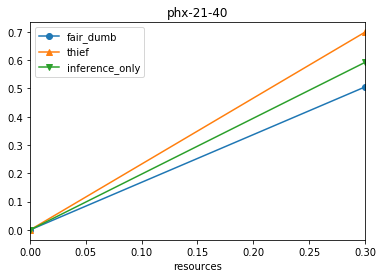

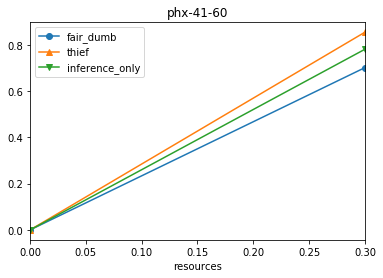

In [56]:
# Cost vs Resource

cities = d.city.unique()
for city in cities:
    temp_df = d[d['city']==city]
    ax = temp_df.plot(x='resources', y=scheds, kind='line',
                        title=city,
                        legend=True, style=['o-', '^-', 'v-'])

In [57]:
d

city  period  resources  use_oracle  fair_dumb     thief  \
1  phx-21-40     100        0.0       False   0.000000  0.000000   
3  phx-21-40     100        0.3       False   0.504749  0.698170   
5  phx-41-60     100        0.0       False   0.000000  0.000000   
7  phx-41-60     100        0.3       False   0.700924  0.853869   

   inference_only  
1        0.000000  
3        0.591501  
5        0.000000  
7        0.780291

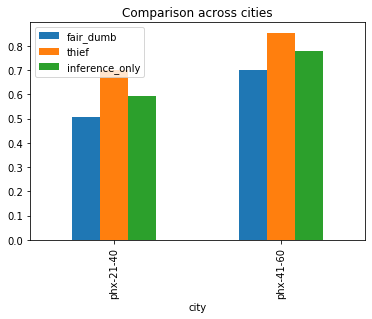

In [66]:
# Comparison across cameras
COMPARE_RES = 0.3
ax = d[d['resources']==COMPARE_RES].plot(x='city', y=scheds, kind='bar',
                  title="Comparison across cities")